In [18]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
import warnings
from imblearn.over_sampling import SMOTE
from model_helper import promotion_strategy_indicator, test_results, generate_offer_monthly_data,\
do_pca, scree_plot, grid_search_indicator_pca, print_pos_strat_params

%matplotlib inline

warnings.filterwarnings(action='once')
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
monthly_data = pd.read_csv("monthly_data_rolling.csv")
monthly_data.head()

,month_num,per_id,offer_id,monthly_amt_spent,num_trans,amt_spent_per_trans,num_offers,cost,profit,has_profit,...,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,offer_id_10,target,quadrant
0,3.0,2.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
1,3.0,3.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
2,3.0,4.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
3,3.0,5.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3
4,3.0,6.0,10.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,3


In [3]:
monthly_data['year_num'] = monthly_data['month_num'] // 12
monthly_data['month_in_year'] = monthly_data['month_num'] % 12
monthly_data['quarter_in_year'] = monthly_data['month_num'] // 4

In [4]:
monthly_data_8 = generate_offer_monthly_data('offer_id_8', monthly_data)

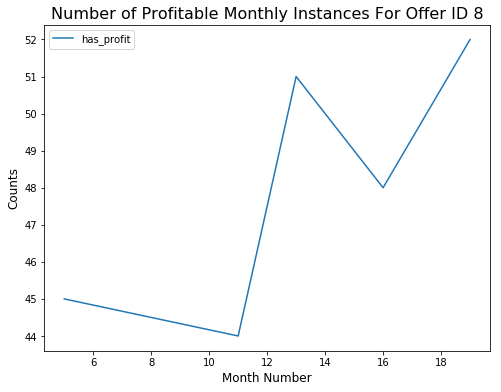

In [5]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_8[monthly_data_8['offer_id_8']==1].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For Offer ID 8", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

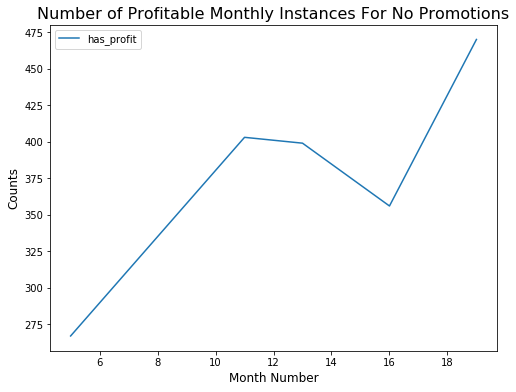

In [6]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_8[monthly_data_8['offer_id_8']==0].groupby('month_num').agg({'has_profit':'sum'}).reset_index().plot(x='month_num', y='has_profit', kind='line',ax=ax);
ax.set_title("Number of Profitable Monthly Instances For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Counts", fontsize=12);

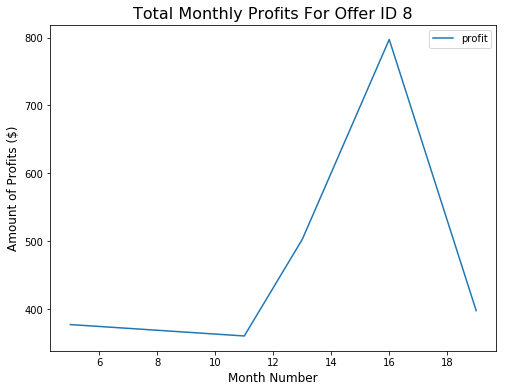

In [7]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_8[monthly_data_8['offer_id_8']==1].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For Offer ID 8", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

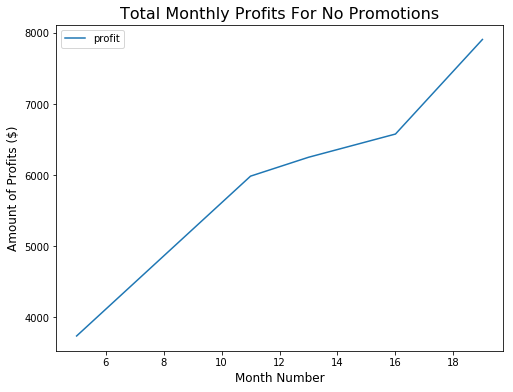

In [8]:
fig, ax = plt.subplots(figsize=(8,6));
monthly_data_8[monthly_data_8['offer_id_8']==0].groupby('month_num').agg({'profit':'sum'}).reset_index().plot(x='month_num', y='profit', kind='line',ax=ax);
ax.set_title("Total Monthly Profits For No Promotions", fontsize=16)
ax.set_xlabel("Month Number", fontsize=12);
ax.set_ylabel("Amount of Profits ($)", fontsize=12);

In [5]:
monthly_data_8.month_num.value_counts().sort_index()

5.0     2526
11.0    2494
13.0    2500
16.0    2610
19.0    2486
Name: month_num, dtype: int64

In [6]:
# use an approximately 70/15/15 split
train_last_month =  13# 3 months
valid_month = 16 # 1 month
test_month = 19 # 1 month

train_8 = monthly_data_8[monthly_data_8['month_num']<=train_last_month].reset_index(drop=True)
valid_8 = monthly_data_8[monthly_data_8['month_num']==valid_month].reset_index(drop=True)
test_8 = monthly_data_8[monthly_data_8['month_num']==test_month].reset_index(drop=True)

Months 5, 11 and 13 will be used for training, while month 16 will be used for the validating, and month 19 will be used for testing.

## Baseline Model

In [7]:
offer_num = 8

baseline_valid_strat = np.ones(valid_8.shape[0])
valid_irr, valid_nir = test_results(offer_num, baseline_valid_strat, valid_8)
print("Baseline Model Results")
print("Valid IRR:"+str(valid_irr))
print("Valid NIR:"+str(valid_nir))

print()

baseline_test_strat = np.ones(test_8.shape[0])
test_irr, test_nir = test_results(offer_num, baseline_test_strat, test_8)
print("Baseline Model Results")
print("Valid IRR:"+str(test_irr))
print("Valid NIR:"+str(test_nir))

Baseline Model Results
Valid IRR:-0.2842911877394636
Valid NIR:-5779.91

Baseline Model Results
Valid IRR:-0.42799678197908286
Valid NIR:-7508.97


## Model

In [8]:
features = ['month_num', 
            'year_num', 'month_in_year', 'quarter_in_year',
            'cum_monthly_amt_spent_offer_id_0',
           'cum_num_trans_offer_id_0', 'cum_profit_offer_id_0',
           'cum_monthly_amt_spent_offer_id_1', 'cum_num_trans_offer_id_1',
           'cum_profit_offer_id_1', 'cum_monthly_amt_spent_offer_id_2',
           'cum_num_trans_offer_id_2', 'cum_profit_offer_id_2',
           'cum_monthly_amt_spent_offer_id_3', 'cum_num_trans_offer_id_3',
           'cum_profit_offer_id_3', 'cum_monthly_amt_spent_offer_id_4',
           'cum_num_trans_offer_id_4', 'cum_profit_offer_id_4',
           'cum_monthly_amt_spent_offer_id_5', 'cum_num_trans_offer_id_5',
           'cum_profit_offer_id_5', 'cum_monthly_amt_spent_offer_id_6',
           'cum_num_trans_offer_id_6', 'cum_profit_offer_id_6',
           'cum_monthly_amt_spent_offer_id_7', 'cum_num_trans_offer_id_7',
           'cum_profit_offer_id_7', 'cum_monthly_amt_spent_offer_id_8',
           'cum_num_trans_offer_id_8', 'cum_profit_offer_id_8',
           'cum_monthly_amt_spent_offer_id_9', 'cum_num_trans_offer_id_9',
           'cum_profit_offer_id_9', 'cum_monthly_amt_spent_offer_id_10',
           'cum_num_trans_offer_id_10', 'cum_profit_offer_id_10',
           'cum_spent_per_trans_offer_id_0', 'cum_spent_per_trans_offer_id_1',
           'cum_spent_per_trans_offer_id_2', 'cum_spent_per_trans_offer_id_3',
           'cum_spent_per_trans_offer_id_4', 'cum_spent_per_trans_offer_id_5',
           'cum_spent_per_trans_offer_id_6', 'cum_spent_per_trans_offer_id_7',
           'cum_spent_per_trans_offer_id_8', 'cum_spent_per_trans_offer_id_9',
           'cum_spent_per_trans_offer_id_10',
           'cum_profit_per_trans_offer_id_0',
           'cum_profit_per_trans_offer_id_1',
           'cum_profit_per_trans_offer_id_2',
           'cum_profit_per_trans_offer_id_3',
           'cum_profit_per_trans_offer_id_4',
           'cum_profit_per_trans_offer_id_5',
           'cum_profit_per_trans_offer_id_6',
           'cum_profit_per_trans_offer_id_7',
           'cum_profit_per_trans_offer_id_8',
           'cum_profit_per_trans_offer_id_9',
           'cum_profit_per_trans_offer_id_10', 'cum_total_spend',
           'cum_num_trans', 'cum_profit', 'mov_avg_spent_offer_id_0',
           'mov_avg_spent_offer_id_1', 'mov_avg_spent_offer_id_2',
           'mov_avg_spent_offer_id_3', 'mov_avg_spent_offer_id_4',
           'mov_avg_spent_offer_id_5', 'mov_avg_spent_offer_id_6',
           'mov_avg_spent_offer_id_7', 'mov_avg_spent_offer_id_8',
           'mov_avg_spent_offer_id_9', 'mov_avg_spent_offer_id_10',
            'mov_avg_total_spent',
           'mov_avg_num_trans_offer_id_0', 'mov_avg_num_trans_offer_id_1',
           'mov_avg_num_trans_offer_id_2', 'mov_avg_num_trans_offer_id_3',
           'mov_avg_num_trans_offer_id_4', 'mov_avg_num_trans_offer_id_5',
           'mov_avg_num_trans_offer_id_6', 'mov_avg_num_trans_offer_id_7',
           'mov_avg_num_trans_offer_id_8', 'mov_avg_num_trans_offer_id_9',
           'mov_avg_num_trans_offer_id_10', 'mov_avg_total_num_trans',
            'mov_avg_profit_offer_id_0',
           'mov_avg_profit_offer_id_1', 'mov_avg_profit_offer_id_2',
           'mov_avg_profit_offer_id_3', 'mov_avg_profit_offer_id_4',
           'mov_avg_profit_offer_id_5', 'mov_avg_profit_offer_id_6',
           'mov_avg_profit_offer_id_7', 'mov_avg_profit_offer_id_8',
           'mov_avg_profit_offer_id_9', 'mov_avg_profit_offer_id_10',
            'mov_avg_total_profit',
           'cum_monthly_amt_spent_offer_id_0_1_mo_ago',
           'cum_num_trans_offer_id_0_1_mo_ago',
           'cum_profit_offer_id_0_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_1_1_mo_ago',
           'cum_num_trans_offer_id_1_1_mo_ago',
           'cum_profit_offer_id_1_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_2_1_mo_ago',
           'cum_num_trans_offer_id_2_1_mo_ago',
           'cum_profit_offer_id_2_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_3_1_mo_ago',
           'cum_num_trans_offer_id_3_1_mo_ago',
           'cum_profit_offer_id_3_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_4_1_mo_ago',
           'cum_num_trans_offer_id_4_1_mo_ago',
           'cum_profit_offer_id_4_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_5_1_mo_ago',
           'cum_num_trans_offer_id_5_1_mo_ago',
           'cum_profit_offer_id_5_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_6_1_mo_ago',
           'cum_num_trans_offer_id_6_1_mo_ago',
           'cum_profit_offer_id_6_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_7_1_mo_ago',
           'cum_num_trans_offer_id_7_1_mo_ago',
           'cum_profit_offer_id_7_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_8_1_mo_ago',
           'cum_num_trans_offer_id_8_1_mo_ago',
           'cum_profit_offer_id_8_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_9_1_mo_ago',
           'cum_num_trans_offer_id_9_1_mo_ago',
           'cum_profit_offer_id_9_1_mo_ago',
           'cum_monthly_amt_spent_offer_id_10_1_mo_ago',
           'cum_num_trans_offer_id_10_1_mo_ago',
           'cum_profit_offer_id_10_1_mo_ago',
           'cum_spent_per_trans_offer_id_0_1_mo_ago',
           'cum_spent_per_trans_offer_id_1_1_mo_ago',
           'cum_spent_per_trans_offer_id_2_1_mo_ago',
           'cum_spent_per_trans_offer_id_3_1_mo_ago',
           'cum_spent_per_trans_offer_id_4_1_mo_ago',
           'cum_spent_per_trans_offer_id_5_1_mo_ago',
           'cum_spent_per_trans_offer_id_6_1_mo_ago',
           'cum_spent_per_trans_offer_id_7_1_mo_ago',
           'cum_spent_per_trans_offer_id_8_1_mo_ago',
           'cum_spent_per_trans_offer_id_9_1_mo_ago',
           'cum_spent_per_trans_offer_id_10_1_mo_ago',
           'cum_profit_per_trans_offer_id_0_1_mo_ago',
           'cum_profit_per_trans_offer_id_1_1_mo_ago',
           'cum_profit_per_trans_offer_id_2_1_mo_ago',
           'cum_profit_per_trans_offer_id_3_1_mo_ago',
           'cum_profit_per_trans_offer_id_4_1_mo_ago',
           'cum_profit_per_trans_offer_id_5_1_mo_ago',
           'cum_profit_per_trans_offer_id_6_1_mo_ago',
           'cum_profit_per_trans_offer_id_7_1_mo_ago',
           'cum_profit_per_trans_offer_id_8_1_mo_ago',
           'cum_profit_per_trans_offer_id_9_1_mo_ago',
           'cum_profit_per_trans_offer_id_10_1_mo_ago',
           'cum_total_spend_1_mo_ago', 'cum_num_trans_1_mo_ago',
           'cum_profit_1_mo_ago', 'mov_avg_spent_offer_id_0_1_mo_ago',
           'mov_avg_spent_offer_id_1_1_mo_ago',
           'mov_avg_spent_offer_id_2_1_mo_ago',
           'mov_avg_spent_offer_id_3_1_mo_ago',
           'mov_avg_spent_offer_id_4_1_mo_ago',
           'mov_avg_spent_offer_id_5_1_mo_ago',
           'mov_avg_spent_offer_id_6_1_mo_ago',
           'mov_avg_spent_offer_id_7_1_mo_ago',
           'mov_avg_spent_offer_id_8_1_mo_ago',
           'mov_avg_spent_offer_id_9_1_mo_ago',
           'mov_avg_spent_offer_id_10_1_mo_ago',
            'mov_avg_total_spent_1_mo_ago',
           'mov_avg_num_trans_offer_id_0_1_mo_ago',
           'mov_avg_num_trans_offer_id_1_1_mo_ago',
           'mov_avg_num_trans_offer_id_2_1_mo_ago',
           'mov_avg_num_trans_offer_id_3_1_mo_ago',
           'mov_avg_num_trans_offer_id_4_1_mo_ago',
           'mov_avg_num_trans_offer_id_5_1_mo_ago',
           'mov_avg_num_trans_offer_id_6_1_mo_ago',
           'mov_avg_num_trans_offer_id_7_1_mo_ago',
           'mov_avg_num_trans_offer_id_8_1_mo_ago',
           'mov_avg_num_trans_offer_id_9_1_mo_ago',
           'mov_avg_num_trans_offer_id_10_1_mo_ago',
            'mov_avg_total_num_trans_1_mo_ago',
           'mov_avg_profit_offer_id_0_1_mo_ago',
           'mov_avg_profit_offer_id_1_1_mo_ago',
           'mov_avg_profit_offer_id_2_1_mo_ago',
           'mov_avg_profit_offer_id_3_1_mo_ago',
           'mov_avg_profit_offer_id_4_1_mo_ago',
           'mov_avg_profit_offer_id_5_1_mo_ago',
           'mov_avg_profit_offer_id_6_1_mo_ago',
           'mov_avg_profit_offer_id_7_1_mo_ago',
           'mov_avg_profit_offer_id_8_1_mo_ago',
           'mov_avg_profit_offer_id_9_1_mo_ago',
           'mov_avg_profit_offer_id_10_1_mo_ago',
            'mov_avg_total_profit_1_mo_ago',
            'age', 'income',
           'member_year', 'member_month', 'member_day', 'gender_F',
           'gender_M', 'gender_O']

X_train_8 = train_8[features]
X_valid_8 = valid_8[features]
X_test_8 = test_8[features]

Y_train_8 = train_8.has_profit
Y_valid_8 = valid_8.has_profit
Y_test_8 = test_8.has_profit

In [9]:
# Apply feature scaling
ss = StandardScaler()
X_train_scaled_8 = pd.DataFrame(ss.fit_transform(X_train_8))
X_train_scaled_8.columns = features
X_train_scaled_8.index = X_train_8.index
X_train_scaled_8.head()

X_valid_scaled_8 = pd.DataFrame(ss.transform(X_valid_8))
X_valid_scaled_8.columns = features
X_valid_scaled_8.index = X_valid_8.index

X_test_scaled_8 = pd.DataFrame(ss.transform(X_test_8))
X_test_scaled_8.columns = features
X_test_scaled_8.index = X_test_8.index

C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  
C:\Users\Josh Lee\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


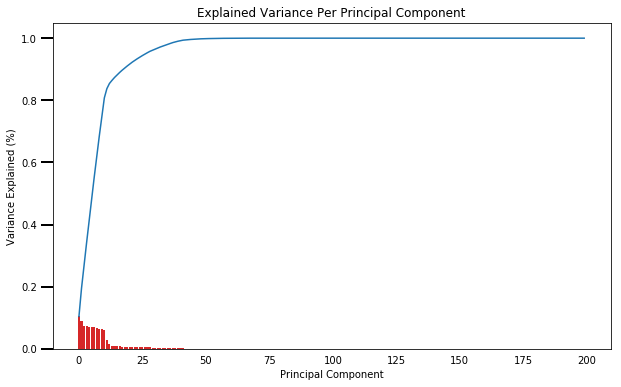

In [10]:
pca, X_train_pca_8 = do_pca(X_train_scaled_8)
scree_plot(pca)

In [11]:
# 40 components explained most variance
n_components = 40
pca, X_train_pca_8 = do_pca(X_train_scaled_8, n_components=n_components)
X_train_pca_8.head()

,pca_comp_0,pca_comp_1,pca_comp_2,pca_comp_3,pca_comp_4,pca_comp_5,pca_comp_6,pca_comp_7,pca_comp_8,pca_comp_9,...,pca_comp_30,pca_comp_31,pca_comp_32,pca_comp_33,pca_comp_34,pca_comp_35,pca_comp_36,pca_comp_37,pca_comp_38,pca_comp_39
0,-3.854699,0.551514,-0.004242,0.123129,-0.164722,-0.004575,-0.185464,-0.237573,-0.179666,0.340791,...,-0.245984,-0.262879,-0.105162,0.211438,0.105983,-0.007916,-0.289388,0.243003,-0.579355,-0.249863
1,-3.854699,0.551514,-0.004242,0.123129,-0.164722,-0.004575,-0.185464,-0.237573,-0.179666,0.340791,...,-0.245984,-0.262879,-0.105162,0.211438,0.105983,-0.007916,-0.289388,0.243003,-0.579355,-0.249863
2,-3.849341,0.544712,-0.013837,0.136806,-0.163553,0.008516,-0.183197,-0.247669,-0.185578,0.348577,...,-0.286862,-0.165789,-0.224471,0.201426,0.105477,-0.025891,-0.161036,0.164402,-0.617784,-0.270716
3,-3.849341,0.544712,-0.013837,0.136806,-0.163553,0.008516,-0.183197,-0.247669,-0.185578,0.348577,...,-0.286862,-0.165789,-0.224471,0.201426,0.105477,-0.025891,-0.161036,0.164402,-0.617784,-0.270716
4,-3.069792,0.398625,-0.016474,0.118071,-0.126647,0.026397,-0.153876,-0.163124,-0.097436,0.249067,...,-0.257242,-0.126561,-0.230542,0.548800,0.101164,0.449613,-0.318022,0.045452,-0.431268,-0.183059


In [12]:
# transform valid and test
X_valid_pca_8 = pd.DataFrame(pca.transform(X_valid_scaled_8))
X_valid_pca_8.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_valid_pca_8.index = X_valid_scaled_8.index

X_test_pca_8 = pd.DataFrame(pca.transform(X_test_scaled_8))
X_test_pca_8.columns = ["pca_comp_" + str(i) for i in range(n_components)]
X_test_pca_8.index = X_test_scaled_8.index

In [13]:
# concat offer ids with X_train, X_valid, X_test
train_ind = train_8['offer_id_8']
valid_ind = valid_8['offer_id_8']
test_ind = test_8['offer_id_8']

X_train_pca_8 = pd.concat([X_train_pca_8, train_ind], axis=1)
X_valid_pca_8 = pd.concat([X_valid_pca_8, valid_ind], axis=1)
X_test_pca_8 = pd.concat([X_test_pca_8, test_ind], axis=1)

In [15]:
# first search to see which parameters to try
max_depth_list = [7]
upsamp_ratio_list = np.arange(0.1, 0.91, 0.1)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 8

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir, pos_strat_params =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_8, Y_train_8, X_valid_pca_8, Y_valid_8, X_test_pca_8, train_8, valid_8, test_8)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/351, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -410.43, Test NIR: -193.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/351, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -403.24, Test NIR: -86.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/351, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -524.71, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/351, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -515.08, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/351, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -622.53, Test NIR: -888.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/351, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -468.77, Test NIR: -1128.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/351, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -223.09, Test NIR: -300.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/351, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -233.95, Test NIR: -373.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/351, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -233.95, Test NIR: -321.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/351, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -262.79, Test NIR: -151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/351, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -1164.16, Test NIR: -897.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/351, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/351, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/351, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: -1229.59, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/351, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: -1196.30, Test NIR: -901.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/351, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/351, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/351, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/351, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/351, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/351, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/351, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/351, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/351, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/351, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/351, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/351, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/351, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/351, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/351, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/351, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/351, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/351, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/351, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/351, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/351, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/351, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/351, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/351, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/351, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -1479.22, Test NIR: -2112.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/351, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -2260.16, Test NIR: -2130.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/351, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -1744.82, Test NIR: -1710.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/351, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -724.95, Test NIR: -1681.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/351, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -1674.61, Test NIR: -1761.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/351, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -1809.01, Test NIR: -2186.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/351, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -2259.96, Test NIR: -2954.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/351, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -2122.81, Test NIR: -1759.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/351, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -341.48, Test NIR: -52.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/351, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -305.75, Test NIR: -77.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/351, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -1552.32, Test NIR: -1134.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/351, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -1575.34, Test NIR: -1138.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/351, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -1484.71, Test NIR: -848.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/351, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: -1484.71, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/351, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -1385.50, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/351, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -8.82, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/351, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: 458.75, Test NIR: -864.98
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 90
Current Best Valid IRR: -0.15, NIR: 458.7500
Current Best Test IRR: -0.55, NIR: -864.9800


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/351, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/351, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/351, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: 480.99, Test NIR: -814.05
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 105
Current Best Valid IRR: -0.04, NIR: 480.9900
Current Best Test IRR: -0.50, NIR: -814.0500


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/351, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/351, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/351, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: 480.99, Test NIR: -792.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/351, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: 481.78, Test NIR: -786.33
Current Best Depth: 7, Upsampling Ratio: 0.2, Min Child Weight: 125
Current Best Valid IRR: -0.05, NIR: 481.7800
Current Best Test IRR: -0.43, NIR: -786.3300


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/351, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: 479.46, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/351, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/351, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/351, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/351, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/351, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/351, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -15.04, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/351, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: 0.08, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/351, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/351, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/351, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: -245.91, Test NIR: -785.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/351, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: -245.91, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/351, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: -197.58, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/351, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/351, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: -1463.42, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/351, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -742.62, Test NIR: -1430.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/351, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -368.57, Test NIR: -1466.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/351, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -396.95, Test NIR: -1447.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/351, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -975.62, Test NIR: -1433.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/351, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -173.83, Test NIR: -1264.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/351, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/351, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/351, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -537.99, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/351, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -480.17, Test NIR: -480.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/351, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/351, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/351, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/351, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/351, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/351, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/351, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/351, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/351, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/351, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/351, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/351, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/351, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/351, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/351, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/351, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/351, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/351, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/351, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/351, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/351, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/351, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/351, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/351, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/351, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/351, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/351, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/351, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/351, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/351, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/351, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: -670.04, Test NIR: -1183.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/351, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -374.28, Test NIR: -91.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/351, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: -387.08, Test NIR: -91.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/351, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -377.41, Test NIR: -88.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/351, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: -244.43, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/351, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/351, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: -651.73, Test NIR: -894.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/351, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: -1312.58, Test NIR: -361.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/351, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: -1711.04, Test NIR: -1227.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/351, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: -1485.56, Test NIR: -608.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/351, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: -432.85, Test NIR: -537.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/351, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: -1689.83, Test NIR: -933.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/351, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: -1612.82, Test NIR: -828.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/351, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/351, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/351, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: -2029.83, Test NIR: -801.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/351, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -2451.50, Test NIR: -2775.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/351, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -2199.73, Test NIR: -1053.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/351, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -1692.16, Test NIR: -282.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/351, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: -3023.28, Test NIR: -2632.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/351, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/351, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/351, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/351, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/351, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/351, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/351, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/351, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/351, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -3283.29, Test NIR: -3182.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/351, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -2873.32, Test NIR: -3537.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/351, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -910.42, Test NIR: -1563.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/351, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -668.31, Test NIR: -642.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/351, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: -1183.71, Test NIR: -1471.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/351, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: -526.01, Test NIR: -757.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/351, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: -2825.12, Test NIR: -3358.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/351, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: -2983.49, Test NIR: -3890.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/351, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/351, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/351, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/351, Depth: 7, Ratio: 0.500, Weight: 10, Valid NIR: -784.13, Test NIR: -1719.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/351, Depth: 7, Ratio: 0.500, Weight: 15, Valid NIR: -669.53, Test NIR: -1553.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/351, Depth: 7, Ratio: 0.500, Weight: 20, Valid NIR: -731.59, Test NIR: -764.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/351, Depth: 7, Ratio: 0.500, Weight: 25, Valid NIR: -728.02, Test NIR: -1770.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/351, Depth: 7, Ratio: 0.500, Weight: 30, Valid NIR: -657.83, Test NIR: -786.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/351, Depth: 7, Ratio: 0.500, Weight: 35, Valid NIR: -1540.60, Test NIR: -787.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/351, Depth: 7, Ratio: 0.500, Weight: 40, Valid NIR: -1581.24, Test NIR: -815.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/351, Depth: 7, Ratio: 0.500, Weight: 45, Valid NIR: -1737.02, Test NIR: -1494.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/351, Depth: 7, Ratio: 0.500, Weight: 50, Valid NIR: -1313.03, Test NIR: -416.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/351, Depth: 7, Ratio: 0.500, Weight: 55, Valid NIR: -1425.83, Test NIR: -446.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/351, Depth: 7, Ratio: 0.500, Weight: 60, Valid NIR: -1078.39, Test NIR: -471.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/351, Depth: 7, Ratio: 0.500, Weight: 65, Valid NIR: -2097.39, Test NIR: -516.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/351, Depth: 7, Ratio: 0.500, Weight: 70, Valid NIR: -2097.39, Test NIR: -499.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/351, Depth: 7, Ratio: 0.500, Weight: 75, Valid NIR: -3228.87, Test NIR: -2624.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/351, Depth: 7, Ratio: 0.500, Weight: 80, Valid NIR: -2096.83, Test NIR: -498.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/351, Depth: 7, Ratio: 0.500, Weight: 85, Valid NIR: -2961.15, Test NIR: -1122.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/351, Depth: 7, Ratio: 0.500, Weight: 90, Valid NIR: -1374.48, Test NIR: -824.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/351, Depth: 7, Ratio: 0.500, Weight: 95, Valid NIR: -3497.63, Test NIR: -3458.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/351, Depth: 7, Ratio: 0.500, Weight: 100, Valid NIR: -3797.27, Test NIR: -3823.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/351, Depth: 7, Ratio: 0.500, Weight: 105, Valid NIR: -2785.30, Test NIR: -3642.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/351, Depth: 7, Ratio: 0.500, Weight: 110, Valid NIR: -2292.55, Test NIR: -1677.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/351, Depth: 7, Ratio: 0.500, Weight: 115, Valid NIR: -4299.48, Test NIR: -5128.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/351, Depth: 7, Ratio: 0.500, Weight: 120, Valid NIR: -3252.24, Test NIR: -3661.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/351, Depth: 7, Ratio: 0.500, Weight: 125, Valid NIR: -2724.99, Test NIR: -1258.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/351, Depth: 7, Ratio: 0.500, Weight: 130, Valid NIR: -2727.63, Test NIR: -1553.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/351, Depth: 7, Ratio: 0.500, Weight: 135, Valid NIR: -1998.61, Test NIR: -601.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/351, Depth: 7, Ratio: 0.500, Weight: 140, Valid NIR: -4298.56, Test NIR: -4630.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/351, Depth: 7, Ratio: 0.500, Weight: 145, Valid NIR: -2008.92, Test NIR: -614.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/351, Depth: 7, Ratio: 0.500, Weight: 150, Valid NIR: -4039.85, Test NIR: -4229.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/351, Depth: 7, Ratio: 0.500, Weight: 155, Valid NIR: -4404.98, Test NIR: -5202.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/351, Depth: 7, Ratio: 0.500, Weight: 160, Valid NIR: -3989.15, Test NIR: -4784.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/351, Depth: 7, Ratio: 0.500, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/351, Depth: 7, Ratio: 0.500, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/351, Depth: 7, Ratio: 0.500, Weight: 175, Valid NIR: -3843.96, Test NIR: -5482.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/351, Depth: 7, Ratio: 0.500, Weight: 180, Valid NIR: -5431.02, Test NIR: -5784.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/351, Depth: 7, Ratio: 0.500, Weight: 185, Valid NIR: -4640.84, Test NIR: -5551.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/351, Depth: 7, Ratio: 0.500, Weight: 190, Valid NIR: -4470.42, Test NIR: -5240.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/351, Depth: 7, Ratio: 0.500, Weight: 195, Valid NIR: -3436.79, Test NIR: -5331.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/351, Depth: 7, Ratio: 0.500, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/351, Depth: 7, Ratio: 0.600, Weight: 10, Valid NIR: -2633.85, Test NIR: -1843.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/351, Depth: 7, Ratio: 0.600, Weight: 15, Valid NIR: -1215.85, Test NIR: -2020.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/351, Depth: 7, Ratio: 0.600, Weight: 20, Valid NIR: -1248.79, Test NIR: -503.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/351, Depth: 7, Ratio: 0.600, Weight: 25, Valid NIR: -1049.81, Test NIR: -1170.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/351, Depth: 7, Ratio: 0.600, Weight: 30, Valid NIR: -1373.48, Test NIR: -3212.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/351, Depth: 7, Ratio: 0.600, Weight: 35, Valid NIR: -1231.35, Test NIR: -1258.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/351, Depth: 7, Ratio: 0.600, Weight: 40, Valid NIR: -1255.30, Test NIR: -1258.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/351, Depth: 7, Ratio: 0.600, Weight: 45, Valid NIR: -2200.37, Test NIR: -958.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/351, Depth: 7, Ratio: 0.600, Weight: 50, Valid NIR: -2702.59, Test NIR: -3565.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/351, Depth: 7, Ratio: 0.600, Weight: 55, Valid NIR: -2192.95, Test NIR: -1599.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/351, Depth: 7, Ratio: 0.600, Weight: 60, Valid NIR: -3103.30, Test NIR: -2208.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/351, Depth: 7, Ratio: 0.600, Weight: 65, Valid NIR: -1876.03, Test NIR: -1625.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/351, Depth: 7, Ratio: 0.600, Weight: 70, Valid NIR: -2006.54, Test NIR: -1465.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/351, Depth: 7, Ratio: 0.600, Weight: 75, Valid NIR: -2717.49, Test NIR: -4514.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/351, Depth: 7, Ratio: 0.600, Weight: 80, Valid NIR: -1815.62, Test NIR: -1624.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/351, Depth: 7, Ratio: 0.600, Weight: 85, Valid NIR: -2875.20, Test NIR: -3547.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/351, Depth: 7, Ratio: 0.600, Weight: 90, Valid NIR: -2671.98, Test NIR: -2863.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/351, Depth: 7, Ratio: 0.600, Weight: 95, Valid NIR: -2671.98, Test NIR: -2863.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/351, Depth: 7, Ratio: 0.600, Weight: 100, Valid NIR: -2671.98, Test NIR: -2863.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/351, Depth: 7, Ratio: 0.600, Weight: 105, Valid NIR: -2744.37, Test NIR: -2788.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/351, Depth: 7, Ratio: 0.600, Weight: 110, Valid NIR: -3566.07, Test NIR: -3439.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/351, Depth: 7, Ratio: 0.600, Weight: 115, Valid NIR: -2806.82, Test NIR: -2909.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/351, Depth: 7, Ratio: 0.600, Weight: 120, Valid NIR: -2806.82, Test NIR: -2909.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/351, Depth: 7, Ratio: 0.600, Weight: 125, Valid NIR: -2434.76, Test NIR: -2746.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/351, Depth: 7, Ratio: 0.600, Weight: 130, Valid NIR: -2434.76, Test NIR: -2625.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/351, Depth: 7, Ratio: 0.600, Weight: 135, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/351, Depth: 7, Ratio: 0.600, Weight: 140, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/351, Depth: 7, Ratio: 0.600, Weight: 145, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/351, Depth: 7, Ratio: 0.600, Weight: 150, Valid NIR: -3133.66, Test NIR: -4126.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/351, Depth: 7, Ratio: 0.600, Weight: 155, Valid NIR: -3133.66, Test NIR: -4126.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/351, Depth: 7, Ratio: 0.600, Weight: 160, Valid NIR: -3133.66, Test NIR: -4126.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/351, Depth: 7, Ratio: 0.600, Weight: 165, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/351, Depth: 7, Ratio: 0.600, Weight: 170, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/351, Depth: 7, Ratio: 0.600, Weight: 175, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/351, Depth: 7, Ratio: 0.600, Weight: 180, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/351, Depth: 7, Ratio: 0.600, Weight: 185, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/351, Depth: 7, Ratio: 0.600, Weight: 190, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/351, Depth: 7, Ratio: 0.600, Weight: 195, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/351, Depth: 7, Ratio: 0.600, Weight: 200, Valid NIR: -2803.57, Test NIR: -3905.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/351, Depth: 7, Ratio: 0.700, Weight: 10, Valid NIR: -2213.68, Test NIR: -2166.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/351, Depth: 7, Ratio: 0.700, Weight: 15, Valid NIR: -2110.39, Test NIR: -1445.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/351, Depth: 7, Ratio: 0.700, Weight: 20, Valid NIR: -2277.11, Test NIR: -1736.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/351, Depth: 7, Ratio: 0.700, Weight: 25, Valid NIR: -2281.07, Test NIR: -1789.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/351, Depth: 7, Ratio: 0.700, Weight: 30, Valid NIR: -2233.63, Test NIR: -1681.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/351, Depth: 7, Ratio: 0.700, Weight: 35, Valid NIR: -2391.02, Test NIR: -2680.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/351, Depth: 7, Ratio: 0.700, Weight: 40, Valid NIR: -2048.40, Test NIR: -1830.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/351, Depth: 7, Ratio: 0.700, Weight: 45, Valid NIR: -2862.46, Test NIR: -1885.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/351, Depth: 7, Ratio: 0.700, Weight: 50, Valid NIR: -2249.64, Test NIR: -1869.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/351, Depth: 7, Ratio: 0.700, Weight: 55, Valid NIR: -2357.56, Test NIR: -1476.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/351, Depth: 7, Ratio: 0.700, Weight: 60, Valid NIR: -3252.82, Test NIR: -2042.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/351, Depth: 7, Ratio: 0.700, Weight: 65, Valid NIR: -3319.39, Test NIR: -2460.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/351, Depth: 7, Ratio: 0.700, Weight: 70, Valid NIR: -2804.47, Test NIR: -2329.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/351, Depth: 7, Ratio: 0.700, Weight: 75, Valid NIR: -2149.65, Test NIR: -1918.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/351, Depth: 7, Ratio: 0.700, Weight: 80, Valid NIR: -2790.00, Test NIR: -2753.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/351, Depth: 7, Ratio: 0.700, Weight: 85, Valid NIR: -3298.38, Test NIR: -3478.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/351, Depth: 7, Ratio: 0.700, Weight: 90, Valid NIR: -4231.99, Test NIR: -6197.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/351, Depth: 7, Ratio: 0.700, Weight: 95, Valid NIR: -2013.13, Test NIR: -1746.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/351, Depth: 7, Ratio: 0.700, Weight: 100, Valid NIR: -2996.53, Test NIR: -4205.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/351, Depth: 7, Ratio: 0.700, Weight: 105, Valid NIR: -2539.48, Test NIR: -2901.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/351, Depth: 7, Ratio: 0.700, Weight: 110, Valid NIR: -2539.48, Test NIR: -2901.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/351, Depth: 7, Ratio: 0.700, Weight: 115, Valid NIR: -2641.59, Test NIR: -3081.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/351, Depth: 7, Ratio: 0.700, Weight: 120, Valid NIR: -4611.78, Test NIR: -5393.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/351, Depth: 7, Ratio: 0.700, Weight: 125, Valid NIR: -4156.71, Test NIR: -5508.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/351, Depth: 7, Ratio: 0.700, Weight: 130, Valid NIR: -2910.39, Test NIR: -3150.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/351, Depth: 7, Ratio: 0.700, Weight: 135, Valid NIR: -2641.59, Test NIR: -3081.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/351, Depth: 7, Ratio: 0.700, Weight: 140, Valid NIR: -4476.48, Test NIR: -5478.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/351, Depth: 7, Ratio: 0.700, Weight: 145, Valid NIR: -2641.59, Test NIR: -3081.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/351, Depth: 7, Ratio: 0.700, Weight: 150, Valid NIR: -2641.59, Test NIR: -3081.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/351, Depth: 7, Ratio: 0.700, Weight: 155, Valid NIR: -5044.02, Test NIR: -6926.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/351, Depth: 7, Ratio: 0.700, Weight: 160, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/351, Depth: 7, Ratio: 0.700, Weight: 165, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/351, Depth: 7, Ratio: 0.700, Weight: 170, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/351, Depth: 7, Ratio: 0.700, Weight: 175, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/351, Depth: 7, Ratio: 0.700, Weight: 180, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/351, Depth: 7, Ratio: 0.700, Weight: 185, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/351, Depth: 7, Ratio: 0.700, Weight: 190, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/351, Depth: 7, Ratio: 0.700, Weight: 195, Valid NIR: -2787.29, Test NIR: -2984.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/351, Depth: 7, Ratio: 0.700, Weight: 200, Valid NIR: -3793.44, Test NIR: -5524.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/351, Depth: 7, Ratio: 0.800, Weight: 10, Valid NIR: -2437.51, Test NIR: -3888.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/351, Depth: 7, Ratio: 0.800, Weight: 15, Valid NIR: -2408.07, Test NIR: -3563.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/351, Depth: 7, Ratio: 0.800, Weight: 20, Valid NIR: -2302.15, Test NIR: -3337.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/351, Depth: 7, Ratio: 0.800, Weight: 25, Valid NIR: -1625.29, Test NIR: -2608.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/351, Depth: 7, Ratio: 0.800, Weight: 30, Valid NIR: -2729.73, Test NIR: -2928.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/351, Depth: 7, Ratio: 0.800, Weight: 35, Valid NIR: -2502.22, Test NIR: -2781.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/351, Depth: 7, Ratio: 0.800, Weight: 40, Valid NIR: -2382.58, Test NIR: -2907.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/351, Depth: 7, Ratio: 0.800, Weight: 45, Valid NIR: -2582.30, Test NIR: -3397.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/351, Depth: 7, Ratio: 0.800, Weight: 50, Valid NIR: -2726.09, Test NIR: -2936.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/351, Depth: 7, Ratio: 0.800, Weight: 55, Valid NIR: -2682.81, Test NIR: -3149.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/351, Depth: 7, Ratio: 0.800, Weight: 60, Valid NIR: -2881.03, Test NIR: -2750.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/351, Depth: 7, Ratio: 0.800, Weight: 65, Valid NIR: -2847.14, Test NIR: -2983.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/351, Depth: 7, Ratio: 0.800, Weight: 70, Valid NIR: -3923.02, Test NIR: -4988.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/351, Depth: 7, Ratio: 0.800, Weight: 75, Valid NIR: -2925.98, Test NIR: -3312.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/351, Depth: 7, Ratio: 0.800, Weight: 80, Valid NIR: -3678.43, Test NIR: -3918.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/351, Depth: 7, Ratio: 0.800, Weight: 85, Valid NIR: -3295.16, Test NIR: -4037.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/351, Depth: 7, Ratio: 0.800, Weight: 90, Valid NIR: -3002.63, Test NIR: -3809.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/351, Depth: 7, Ratio: 0.800, Weight: 95, Valid NIR: -3002.63, Test NIR: -3809.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/351, Depth: 7, Ratio: 0.800, Weight: 100, Valid NIR: -3012.68, Test NIR: -2909.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/351, Depth: 7, Ratio: 0.800, Weight: 105, Valid NIR: -2995.95, Test NIR: -3769.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/351, Depth: 7, Ratio: 0.800, Weight: 110, Valid NIR: -2995.95, Test NIR: -3769.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/351, Depth: 7, Ratio: 0.800, Weight: 115, Valid NIR: -4096.67, Test NIR: -5803.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/351, Depth: 7, Ratio: 0.800, Weight: 120, Valid NIR: -3082.16, Test NIR: -4174.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/351, Depth: 7, Ratio: 0.800, Weight: 125, Valid NIR: -3082.16, Test NIR: -4174.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/351, Depth: 7, Ratio: 0.800, Weight: 130, Valid NIR: -2955.99, Test NIR: -4131.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/351, Depth: 7, Ratio: 0.800, Weight: 135, Valid NIR: -3419.78, Test NIR: -4502.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/351, Depth: 7, Ratio: 0.800, Weight: 140, Valid NIR: -3537.04, Test NIR: -5319.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/351, Depth: 7, Ratio: 0.800, Weight: 145, Valid NIR: -3452.98, Test NIR: -4674.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/351, Depth: 7, Ratio: 0.800, Weight: 150, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/351, Depth: 7, Ratio: 0.800, Weight: 155, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/351, Depth: 7, Ratio: 0.800, Weight: 160, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/351, Depth: 7, Ratio: 0.800, Weight: 165, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/351, Depth: 7, Ratio: 0.800, Weight: 170, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/351, Depth: 7, Ratio: 0.800, Weight: 175, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/351, Depth: 7, Ratio: 0.800, Weight: 180, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/351, Depth: 7, Ratio: 0.800, Weight: 185, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/351, Depth: 7, Ratio: 0.800, Weight: 190, Valid NIR: -3343.05, Test NIR: -4592.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/351, Depth: 7, Ratio: 0.800, Weight: 195, Valid NIR: -3304.41, Test NIR: -4544.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/351, Depth: 7, Ratio: 0.800, Weight: 200, Valid NIR: -3267.85, Test NIR: -4456.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/351, Depth: 7, Ratio: 0.900, Weight: 10, Valid NIR: -1757.23, Test NIR: -1932.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/351, Depth: 7, Ratio: 0.900, Weight: 15, Valid NIR: -1532.04, Test NIR: -3361.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/351, Depth: 7, Ratio: 0.900, Weight: 20, Valid NIR: -2945.47, Test NIR: -2879.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/351, Depth: 7, Ratio: 0.900, Weight: 25, Valid NIR: -3122.38, Test NIR: -4503.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/351, Depth: 7, Ratio: 0.900, Weight: 30, Valid NIR: -1325.77, Test NIR: -1283.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/351, Depth: 7, Ratio: 0.900, Weight: 35, Valid NIR: -2438.42, Test NIR: -1192.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/351, Depth: 7, Ratio: 0.900, Weight: 40, Valid NIR: -2711.64, Test NIR: -2558.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/351, Depth: 7, Ratio: 0.900, Weight: 45, Valid NIR: -3383.73, Test NIR: -2916.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/351, Depth: 7, Ratio: 0.900, Weight: 50, Valid NIR: -2177.09, Test NIR: -2761.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/351, Depth: 7, Ratio: 0.900, Weight: 55, Valid NIR: -2849.70, Test NIR: -2705.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/351, Depth: 7, Ratio: 0.900, Weight: 60, Valid NIR: -3238.94, Test NIR: -3468.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/351, Depth: 7, Ratio: 0.900, Weight: 65, Valid NIR: -3890.24, Test NIR: -3674.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/351, Depth: 7, Ratio: 0.900, Weight: 70, Valid NIR: -4292.57, Test NIR: -4300.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/351, Depth: 7, Ratio: 0.900, Weight: 75, Valid NIR: -3530.01, Test NIR: -4037.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/351, Depth: 7, Ratio: 0.900, Weight: 80, Valid NIR: -3951.69, Test NIR: -2748.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/351, Depth: 7, Ratio: 0.900, Weight: 85, Valid NIR: -4162.51, Test NIR: -3419.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/351, Depth: 7, Ratio: 0.900, Weight: 90, Valid NIR: -4057.78, Test NIR: -4793.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/351, Depth: 7, Ratio: 0.900, Weight: 95, Valid NIR: -5081.52, Test NIR: -5480.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/351, Depth: 7, Ratio: 0.900, Weight: 100, Valid NIR: -3645.67, Test NIR: -3489.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/351, Depth: 7, Ratio: 0.900, Weight: 105, Valid NIR: -4634.06, Test NIR: -4875.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/351, Depth: 7, Ratio: 0.900, Weight: 110, Valid NIR: -4804.15, Test NIR: -5374.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/351, Depth: 7, Ratio: 0.900, Weight: 115, Valid NIR: -4977.69, Test NIR: -5320.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/351, Depth: 7, Ratio: 0.900, Weight: 120, Valid NIR: -5293.47, Test NIR: -5591.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/351, Depth: 7, Ratio: 0.900, Weight: 125, Valid NIR: -5015.84, Test NIR: -5806.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/351, Depth: 7, Ratio: 0.900, Weight: 130, Valid NIR: -5296.44, Test NIR: -5676.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/351, Depth: 7, Ratio: 0.900, Weight: 135, Valid NIR: -5258.74, Test NIR: -5968.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/351, Depth: 7, Ratio: 0.900, Weight: 140, Valid NIR: -5162.92, Test NIR: -5850.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/351, Depth: 7, Ratio: 0.900, Weight: 145, Valid NIR: -5282.66, Test NIR: -6105.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/351, Depth: 7, Ratio: 0.900, Weight: 150, Valid NIR: -5412.86, Test NIR: -6974.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/351, Depth: 7, Ratio: 0.900, Weight: 155, Valid NIR: -5417.06, Test NIR: -6422.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/351, Depth: 7, Ratio: 0.900, Weight: 160, Valid NIR: -5406.61, Test NIR: -6350.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/351, Depth: 7, Ratio: 0.900, Weight: 165, Valid NIR: -5468.03, Test NIR: -7327.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/351, Depth: 7, Ratio: 0.900, Weight: 170, Valid NIR: -5308.91, Test NIR: -5786.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/351, Depth: 7, Ratio: 0.900, Weight: 175, Valid NIR: -4730.24, Test NIR: -6593.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/351, Depth: 7, Ratio: 0.900, Weight: 180, Valid NIR: -5079.72, Test NIR: -6851.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/351, Depth: 7, Ratio: 0.900, Weight: 185, Valid NIR: -5624.76, Test NIR: -6864.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/351, Depth: 7, Ratio: 0.900, Weight: 190, Valid NIR: -5610.04, Test NIR: -6866.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/351, Depth: 7, Ratio: 0.900, Weight: 195, Valid NIR: -5629.08, Test NIR: -6869.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/351, Depth: 7, Ratio: 0.900, Weight: 200, Valid NIR: -5652.22, Test NIR: -6877.86


In [16]:
print(best_depth)
print(best_ratio)
print(best_weight)
print(best_valid_nir)
print(best_test_nir)

7
0.2
125
481.78
-786.33


In [19]:
print_pos_strat_params(pos_strat_params)

In [20]:
max_depth_list = [7,8,9]
upsamp_ratio_list = np.arange(0.04, 0.41, 0.01)
min_child_weight_list = np.arange(10, 205, 5)

offer_num = 8

best_depth, best_ratio, best_weight, best_valid_nir, best_test_nir, pos_strat_params =\
grid_search_indicator_pca(offer_num, max_depth_list, upsamp_ratio_list, min_child_weight_list,\
                          X_train_pca_8, Y_train_8, X_valid_pca_8, Y_valid_8, X_test_pca_8, train_8, valid_8, test_8)

C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1/4329, Depth: 7, Ratio: 0.040, Weight: 10, Valid NIR: -4.23, Test NIR: -4.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2/4329, Depth: 7, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3/4329, Depth: 7, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4/4329, Depth: 7, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 5/4329, Depth: 7, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 6/4329, Depth: 7, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 7/4329, Depth: 7, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 8/4329, Depth: 7, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 9/4329, Depth: 7, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 10/4329, Depth: 7, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 11/4329, Depth: 7, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 12/4329, Depth: 7, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 13/4329, Depth: 7, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 14/4329, Depth: 7, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 15/4329, Depth: 7, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 16/4329, Depth: 7, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 17/4329, Depth: 7, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 18/4329, Depth: 7, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 19/4329, Depth: 7, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 20/4329, Depth: 7, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 21/4329, Depth: 7, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 22/4329, Depth: 7, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 23/4329, Depth: 7, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 24/4329, Depth: 7, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 25/4329, Depth: 7, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 26/4329, Depth: 7, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 27/4329, Depth: 7, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 28/4329, Depth: 7, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 29/4329, Depth: 7, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 30/4329, Depth: 7, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 31/4329, Depth: 7, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 32/4329, Depth: 7, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 33/4329, Depth: 7, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 34/4329, Depth: 7, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 35/4329, Depth: 7, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 36/4329, Depth: 7, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 37/4329, Depth: 7, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 38/4329, Depth: 7, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 39/4329, Depth: 7, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 40/4329, Depth: 7, Ratio: 0.050, Weight: 10, Valid NIR: -21.81, Test NIR: -76.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 41/4329, Depth: 7, Ratio: 0.050, Weight: 15, Valid NIR: -21.81, Test NIR: -21.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 42/4329, Depth: 7, Ratio: 0.050, Weight: 20, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 43/4329, Depth: 7, Ratio: 0.050, Weight: 25, Valid NIR: -14.99, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 44/4329, Depth: 7, Ratio: 0.050, Weight: 30, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 45/4329, Depth: 7, Ratio: 0.050, Weight: 35, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 46/4329, Depth: 7, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 47/4329, Depth: 7, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 48/4329, Depth: 7, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 49/4329, Depth: 7, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 50/4329, Depth: 7, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 51/4329, Depth: 7, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 52/4329, Depth: 7, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 53/4329, Depth: 7, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 54/4329, Depth: 7, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 55/4329, Depth: 7, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 56/4329, Depth: 7, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 57/4329, Depth: 7, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 58/4329, Depth: 7, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 59/4329, Depth: 7, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 60/4329, Depth: 7, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 61/4329, Depth: 7, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 62/4329, Depth: 7, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 63/4329, Depth: 7, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 64/4329, Depth: 7, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 65/4329, Depth: 7, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 66/4329, Depth: 7, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 67/4329, Depth: 7, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 68/4329, Depth: 7, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 69/4329, Depth: 7, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 70/4329, Depth: 7, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 71/4329, Depth: 7, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 72/4329, Depth: 7, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 73/4329, Depth: 7, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 74/4329, Depth: 7, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 75/4329, Depth: 7, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 76/4329, Depth: 7, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 77/4329, Depth: 7, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 78/4329, Depth: 7, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 79/4329, Depth: 7, Ratio: 0.060, Weight: 10, Valid NIR: -256.15, Test NIR: -156.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 80/4329, Depth: 7, Ratio: 0.060, Weight: 15, Valid NIR: -23.81, Test NIR: -33.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 81/4329, Depth: 7, Ratio: 0.060, Weight: 20, Valid NIR: -809.42, Test NIR: -847.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 82/4329, Depth: 7, Ratio: 0.060, Weight: 25, Valid NIR: -716.14, Test NIR: -773.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 83/4329, Depth: 7, Ratio: 0.060, Weight: 30, Valid NIR: -754.59, Test NIR: -973.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 84/4329, Depth: 7, Ratio: 0.060, Weight: 35, Valid NIR: -773.74, Test NIR: -826.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 85/4329, Depth: 7, Ratio: 0.060, Weight: 40, Valid NIR: -91.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 86/4329, Depth: 7, Ratio: 0.060, Weight: 45, Valid NIR: -133.03, Test NIR: -122.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 87/4329, Depth: 7, Ratio: 0.060, Weight: 50, Valid NIR: -41.47, Test NIR: -47.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 88/4329, Depth: 7, Ratio: 0.060, Weight: 55, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 89/4329, Depth: 7, Ratio: 0.060, Weight: 60, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 90/4329, Depth: 7, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 91/4329, Depth: 7, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 92/4329, Depth: 7, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 93/4329, Depth: 7, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 94/4329, Depth: 7, Ratio: 0.060, Weight: 85, Valid NIR: -576.53, Test NIR: -775.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 95/4329, Depth: 7, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 96/4329, Depth: 7, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 97/4329, Depth: 7, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 98/4329, Depth: 7, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 99/4329, Depth: 7, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 100/4329, Depth: 7, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 101/4329, Depth: 7, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 102/4329, Depth: 7, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 103/4329, Depth: 7, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 104/4329, Depth: 7, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 105/4329, Depth: 7, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 106/4329, Depth: 7, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 107/4329, Depth: 7, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 108/4329, Depth: 7, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 109/4329, Depth: 7, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 110/4329, Depth: 7, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 111/4329, Depth: 7, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 112/4329, Depth: 7, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 113/4329, Depth: 7, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 114/4329, Depth: 7, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 115/4329, Depth: 7, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 116/4329, Depth: 7, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 117/4329, Depth: 7, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 118/4329, Depth: 7, Ratio: 0.070, Weight: 10, Valid NIR: -436.20, Test NIR: -200.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 119/4329, Depth: 7, Ratio: 0.070, Weight: 15, Valid NIR: -468.52, Test NIR: -847.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 120/4329, Depth: 7, Ratio: 0.070, Weight: 20, Valid NIR: -184.02, Test NIR: -802.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 121/4329, Depth: 7, Ratio: 0.070, Weight: 25, Valid NIR: -688.77, Test NIR: -781.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 122/4329, Depth: 7, Ratio: 0.070, Weight: 30, Valid NIR: -35.11, Test NIR: -781.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 123/4329, Depth: 7, Ratio: 0.070, Weight: 35, Valid NIR: -29.59, Test NIR: -827.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 124/4329, Depth: 7, Ratio: 0.070, Weight: 40, Valid NIR: -28.79, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 125/4329, Depth: 7, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 126/4329, Depth: 7, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: -5.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 127/4329, Depth: 7, Ratio: 0.070, Weight: 55, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 128/4329, Depth: 7, Ratio: 0.070, Weight: 60, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 129/4329, Depth: 7, Ratio: 0.070, Weight: 65, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 130/4329, Depth: 7, Ratio: 0.070, Weight: 70, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 131/4329, Depth: 7, Ratio: 0.070, Weight: 75, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 132/4329, Depth: 7, Ratio: 0.070, Weight: 80, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 133/4329, Depth: 7, Ratio: 0.070, Weight: 85, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 134/4329, Depth: 7, Ratio: 0.070, Weight: 90, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 135/4329, Depth: 7, Ratio: 0.070, Weight: 95, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 136/4329, Depth: 7, Ratio: 0.070, Weight: 100, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 137/4329, Depth: 7, Ratio: 0.070, Weight: 105, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 138/4329, Depth: 7, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 139/4329, Depth: 7, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 140/4329, Depth: 7, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 141/4329, Depth: 7, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 142/4329, Depth: 7, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 143/4329, Depth: 7, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 144/4329, Depth: 7, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 145/4329, Depth: 7, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 146/4329, Depth: 7, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 147/4329, Depth: 7, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 148/4329, Depth: 7, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 149/4329, Depth: 7, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 150/4329, Depth: 7, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 151/4329, Depth: 7, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 152/4329, Depth: 7, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 153/4329, Depth: 7, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 154/4329, Depth: 7, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 155/4329, Depth: 7, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 156/4329, Depth: 7, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 157/4329, Depth: 7, Ratio: 0.080, Weight: 10, Valid NIR: -538.14, Test NIR: -370.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 158/4329, Depth: 7, Ratio: 0.080, Weight: 15, Valid NIR: -665.77, Test NIR: -224.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 159/4329, Depth: 7, Ratio: 0.080, Weight: 20, Valid NIR: -765.00, Test NIR: -302.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 160/4329, Depth: 7, Ratio: 0.080, Weight: 25, Valid NIR: -852.86, Test NIR: -140.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 161/4329, Depth: 7, Ratio: 0.080, Weight: 30, Valid NIR: -978.49, Test NIR: -183.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 162/4329, Depth: 7, Ratio: 0.080, Weight: 35, Valid NIR: -225.29, Test NIR: -340.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 163/4329, Depth: 7, Ratio: 0.080, Weight: 40, Valid NIR: -204.74, Test NIR: -105.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 164/4329, Depth: 7, Ratio: 0.080, Weight: 45, Valid NIR: -161.36, Test NIR: -54.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 165/4329, Depth: 7, Ratio: 0.080, Weight: 50, Valid NIR: -90.22, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 166/4329, Depth: 7, Ratio: 0.080, Weight: 55, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 167/4329, Depth: 7, Ratio: 0.080, Weight: 60, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 168/4329, Depth: 7, Ratio: 0.080, Weight: 65, Valid NIR: -86.66, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 169/4329, Depth: 7, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 170/4329, Depth: 7, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 171/4329, Depth: 7, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 172/4329, Depth: 7, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 173/4329, Depth: 7, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 174/4329, Depth: 7, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 175/4329, Depth: 7, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 176/4329, Depth: 7, Ratio: 0.080, Weight: 105, Valid NIR: -1.92, Test NIR: -21.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 177/4329, Depth: 7, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 178/4329, Depth: 7, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 179/4329, Depth: 7, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 180/4329, Depth: 7, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 181/4329, Depth: 7, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 182/4329, Depth: 7, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 183/4329, Depth: 7, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 184/4329, Depth: 7, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 185/4329, Depth: 7, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 186/4329, Depth: 7, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 187/4329, Depth: 7, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 188/4329, Depth: 7, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 189/4329, Depth: 7, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 190/4329, Depth: 7, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 191/4329, Depth: 7, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 192/4329, Depth: 7, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 193/4329, Depth: 7, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 194/4329, Depth: 7, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 195/4329, Depth: 7, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 196/4329, Depth: 7, Ratio: 0.090, Weight: 10, Valid NIR: -519.19, Test NIR: -232.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 197/4329, Depth: 7, Ratio: 0.090, Weight: 15, Valid NIR: 180.60, Test NIR: -185.30
Current Best Depth: 7, Upsampling Ratio: 0.09000000000000001, Min Child Weight: 15
Current Best Valid IRR: -0.25, NIR: 180.6000
Current Best Test IRR: -0.40, NIR: -185.3000


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 198/4329, Depth: 7, Ratio: 0.090, Weight: 20, Valid NIR: -536.86, Test NIR: -980.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 199/4329, Depth: 7, Ratio: 0.090, Weight: 25, Valid NIR: -849.90, Test NIR: -945.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 200/4329, Depth: 7, Ratio: 0.090, Weight: 30, Valid NIR: -957.75, Test NIR: -1018.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 201/4329, Depth: 7, Ratio: 0.090, Weight: 35, Valid NIR: -805.49, Test NIR: -1153.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 202/4329, Depth: 7, Ratio: 0.090, Weight: 40, Valid NIR: -691.32, Test NIR: -139.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 203/4329, Depth: 7, Ratio: 0.090, Weight: 45, Valid NIR: -718.60, Test NIR: -105.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 204/4329, Depth: 7, Ratio: 0.090, Weight: 50, Valid NIR: -639.25, Test NIR: -107.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 205/4329, Depth: 7, Ratio: 0.090, Weight: 55, Valid NIR: -24.19, Test NIR: -827.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 206/4329, Depth: 7, Ratio: 0.090, Weight: 60, Valid NIR: -132.47, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 207/4329, Depth: 7, Ratio: 0.090, Weight: 65, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 208/4329, Depth: 7, Ratio: 0.090, Weight: 70, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 209/4329, Depth: 7, Ratio: 0.090, Weight: 75, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 210/4329, Depth: 7, Ratio: 0.090, Weight: 80, Valid NIR: -182.57, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 211/4329, Depth: 7, Ratio: 0.090, Weight: 85, Valid NIR: -20.28, Test NIR: -777.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 212/4329, Depth: 7, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 213/4329, Depth: 7, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 214/4329, Depth: 7, Ratio: 0.090, Weight: 100, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 215/4329, Depth: 7, Ratio: 0.090, Weight: 105, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 216/4329, Depth: 7, Ratio: 0.090, Weight: 110, Valid NIR: -25.74, Test NIR: -114.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 217/4329, Depth: 7, Ratio: 0.090, Weight: 115, Valid NIR: -6.00, Test NIR: -92.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 218/4329, Depth: 7, Ratio: 0.090, Weight: 120, Valid NIR: -46.86, Test NIR: -142.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 219/4329, Depth: 7, Ratio: 0.090, Weight: 125, Valid NIR: -23.04, Test NIR: -30.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 220/4329, Depth: 7, Ratio: 0.090, Weight: 130, Valid NIR: -2.21, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 221/4329, Depth: 7, Ratio: 0.090, Weight: 135, Valid NIR: -22.77, Test NIR: -45.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 222/4329, Depth: 7, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 223/4329, Depth: 7, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 224/4329, Depth: 7, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 225/4329, Depth: 7, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 226/4329, Depth: 7, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 227/4329, Depth: 7, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 228/4329, Depth: 7, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 229/4329, Depth: 7, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 230/4329, Depth: 7, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 231/4329, Depth: 7, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 232/4329, Depth: 7, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 233/4329, Depth: 7, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 234/4329, Depth: 7, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 235/4329, Depth: 7, Ratio: 0.100, Weight: 10, Valid NIR: -410.43, Test NIR: -193.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 236/4329, Depth: 7, Ratio: 0.100, Weight: 15, Valid NIR: -403.24, Test NIR: -86.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 237/4329, Depth: 7, Ratio: 0.100, Weight: 20, Valid NIR: -524.71, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 238/4329, Depth: 7, Ratio: 0.100, Weight: 25, Valid NIR: -515.08, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 239/4329, Depth: 7, Ratio: 0.100, Weight: 30, Valid NIR: -622.53, Test NIR: -888.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 240/4329, Depth: 7, Ratio: 0.100, Weight: 35, Valid NIR: -468.77, Test NIR: -1128.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 241/4329, Depth: 7, Ratio: 0.100, Weight: 40, Valid NIR: -223.09, Test NIR: -300.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 242/4329, Depth: 7, Ratio: 0.100, Weight: 45, Valid NIR: -233.95, Test NIR: -373.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 243/4329, Depth: 7, Ratio: 0.100, Weight: 50, Valid NIR: -233.95, Test NIR: -321.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 244/4329, Depth: 7, Ratio: 0.100, Weight: 55, Valid NIR: -262.79, Test NIR: -151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 245/4329, Depth: 7, Ratio: 0.100, Weight: 60, Valid NIR: -1164.16, Test NIR: -897.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 246/4329, Depth: 7, Ratio: 0.100, Weight: 65, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 247/4329, Depth: 7, Ratio: 0.100, Weight: 70, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 248/4329, Depth: 7, Ratio: 0.100, Weight: 75, Valid NIR: -1229.59, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 249/4329, Depth: 7, Ratio: 0.100, Weight: 80, Valid NIR: -1196.30, Test NIR: -901.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 250/4329, Depth: 7, Ratio: 0.100, Weight: 85, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 251/4329, Depth: 7, Ratio: 0.100, Weight: 90, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 252/4329, Depth: 7, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 253/4329, Depth: 7, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 254/4329, Depth: 7, Ratio: 0.100, Weight: 105, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 255/4329, Depth: 7, Ratio: 0.100, Weight: 110, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 256/4329, Depth: 7, Ratio: 0.100, Weight: 115, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 257/4329, Depth: 7, Ratio: 0.100, Weight: 120, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 258/4329, Depth: 7, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 259/4329, Depth: 7, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 260/4329, Depth: 7, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 261/4329, Depth: 7, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 262/4329, Depth: 7, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 263/4329, Depth: 7, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 264/4329, Depth: 7, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 265/4329, Depth: 7, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 266/4329, Depth: 7, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 267/4329, Depth: 7, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 268/4329, Depth: 7, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 269/4329, Depth: 7, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 270/4329, Depth: 7, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 271/4329, Depth: 7, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 272/4329, Depth: 7, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 273/4329, Depth: 7, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 274/4329, Depth: 7, Ratio: 0.110, Weight: 10, Valid NIR: -312.92, Test NIR: -1122.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 275/4329, Depth: 7, Ratio: 0.110, Weight: 15, Valid NIR: -145.44, Test NIR: -984.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 276/4329, Depth: 7, Ratio: 0.110, Weight: 20, Valid NIR: -381.58, Test NIR: -1015.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 277/4329, Depth: 7, Ratio: 0.110, Weight: 25, Valid NIR: -381.58, Test NIR: -990.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 278/4329, Depth: 7, Ratio: 0.110, Weight: 30, Valid NIR: -357.01, Test NIR: -1070.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 279/4329, Depth: 7, Ratio: 0.110, Weight: 35, Valid NIR: -345.23, Test NIR: -1104.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 280/4329, Depth: 7, Ratio: 0.110, Weight: 40, Valid NIR: -1243.97, Test NIR: -125.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 281/4329, Depth: 7, Ratio: 0.110, Weight: 45, Valid NIR: -215.50, Test NIR: -954.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 282/4329, Depth: 7, Ratio: 0.110, Weight: 50, Valid NIR: -200.41, Test NIR: -873.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 283/4329, Depth: 7, Ratio: 0.110, Weight: 55, Valid NIR: -1242.80, Test NIR: -876.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 284/4329, Depth: 7, Ratio: 0.110, Weight: 60, Valid NIR: -1215.26, Test NIR: -129.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 285/4329, Depth: 7, Ratio: 0.110, Weight: 65, Valid NIR: -1114.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 286/4329, Depth: 7, Ratio: 0.110, Weight: 70, Valid NIR: -1120.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 287/4329, Depth: 7, Ratio: 0.110, Weight: 75, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 288/4329, Depth: 7, Ratio: 0.110, Weight: 80, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 289/4329, Depth: 7, Ratio: 0.110, Weight: 85, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 290/4329, Depth: 7, Ratio: 0.110, Weight: 90, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 291/4329, Depth: 7, Ratio: 0.110, Weight: 95, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 292/4329, Depth: 7, Ratio: 0.110, Weight: 100, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 293/4329, Depth: 7, Ratio: 0.110, Weight: 105, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 294/4329, Depth: 7, Ratio: 0.110, Weight: 110, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 295/4329, Depth: 7, Ratio: 0.110, Weight: 115, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 296/4329, Depth: 7, Ratio: 0.110, Weight: 120, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 297/4329, Depth: 7, Ratio: 0.110, Weight: 125, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 298/4329, Depth: 7, Ratio: 0.110, Weight: 130, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 299/4329, Depth: 7, Ratio: 0.110, Weight: 135, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 300/4329, Depth: 7, Ratio: 0.110, Weight: 140, Valid NIR: -20.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 301/4329, Depth: 7, Ratio: 0.110, Weight: 145, Valid NIR: -3.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 302/4329, Depth: 7, Ratio: 0.110, Weight: 150, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 303/4329, Depth: 7, Ratio: 0.110, Weight: 155, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 304/4329, Depth: 7, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 305/4329, Depth: 7, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 306/4329, Depth: 7, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 307/4329, Depth: 7, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 308/4329, Depth: 7, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 309/4329, Depth: 7, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 310/4329, Depth: 7, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 311/4329, Depth: 7, Ratio: 0.110, Weight: 195, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 312/4329, Depth: 7, Ratio: 0.110, Weight: 200, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 313/4329, Depth: 7, Ratio: 0.120, Weight: 10, Valid NIR: -832.53, Test NIR: -307.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 314/4329, Depth: 7, Ratio: 0.120, Weight: 15, Valid NIR: -489.88, Test NIR: -207.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 315/4329, Depth: 7, Ratio: 0.120, Weight: 20, Valid NIR: -700.59, Test NIR: -1132.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 316/4329, Depth: 7, Ratio: 0.120, Weight: 25, Valid NIR: -676.67, Test NIR: -1124.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 317/4329, Depth: 7, Ratio: 0.120, Weight: 30, Valid NIR: -595.74, Test NIR: -967.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 318/4329, Depth: 7, Ratio: 0.120, Weight: 35, Valid NIR: -603.33, Test NIR: -1374.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 319/4329, Depth: 7, Ratio: 0.120, Weight: 40, Valid NIR: -452.24, Test NIR: -271.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 320/4329, Depth: 7, Ratio: 0.120, Weight: 45, Valid NIR: -449.88, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 321/4329, Depth: 7, Ratio: 0.120, Weight: 50, Valid NIR: -417.05, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 322/4329, Depth: 7, Ratio: 0.120, Weight: 55, Valid NIR: -454.66, Test NIR: -1086.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 323/4329, Depth: 7, Ratio: 0.120, Weight: 60, Valid NIR: -1932.56, Test NIR: -1138.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 324/4329, Depth: 7, Ratio: 0.120, Weight: 65, Valid NIR: -1511.32, Test NIR: -1125.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 325/4329, Depth: 7, Ratio: 0.120, Weight: 70, Valid NIR: -1394.50, Test NIR: -1196.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 326/4329, Depth: 7, Ratio: 0.120, Weight: 75, Valid NIR: -254.80, Test NIR: -1038.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 327/4329, Depth: 7, Ratio: 0.120, Weight: 80, Valid NIR: -245.38, Test NIR: -1044.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 328/4329, Depth: 7, Ratio: 0.120, Weight: 85, Valid NIR: -400.91, Test NIR: -880.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 329/4329, Depth: 7, Ratio: 0.120, Weight: 90, Valid NIR: -359.95, Test NIR: -840.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 330/4329, Depth: 7, Ratio: 0.120, Weight: 95, Valid NIR: -353.12, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 331/4329, Depth: 7, Ratio: 0.120, Weight: 100, Valid NIR: -349.83, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 332/4329, Depth: 7, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 333/4329, Depth: 7, Ratio: 0.120, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 334/4329, Depth: 7, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 335/4329, Depth: 7, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 336/4329, Depth: 7, Ratio: 0.120, Weight: 125, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 337/4329, Depth: 7, Ratio: 0.120, Weight: 130, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 338/4329, Depth: 7, Ratio: 0.120, Weight: 135, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 339/4329, Depth: 7, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 340/4329, Depth: 7, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 341/4329, Depth: 7, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 342/4329, Depth: 7, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 343/4329, Depth: 7, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 344/4329, Depth: 7, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 345/4329, Depth: 7, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 346/4329, Depth: 7, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 347/4329, Depth: 7, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 348/4329, Depth: 7, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 349/4329, Depth: 7, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 350/4329, Depth: 7, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 351/4329, Depth: 7, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 352/4329, Depth: 7, Ratio: 0.130, Weight: 10, Valid NIR: -732.80, Test NIR: -2437.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 353/4329, Depth: 7, Ratio: 0.130, Weight: 15, Valid NIR: -1091.34, Test NIR: -924.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 354/4329, Depth: 7, Ratio: 0.130, Weight: 20, Valid NIR: -907.69, Test NIR: -1345.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 355/4329, Depth: 7, Ratio: 0.130, Weight: 25, Valid NIR: -346.57, Test NIR: -1238.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 356/4329, Depth: 7, Ratio: 0.130, Weight: 30, Valid NIR: -334.50, Test NIR: -2230.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 357/4329, Depth: 7, Ratio: 0.130, Weight: 35, Valid NIR: -320.65, Test NIR: -2019.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 358/4329, Depth: 7, Ratio: 0.130, Weight: 40, Valid NIR: -269.90, Test NIR: -1870.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 359/4329, Depth: 7, Ratio: 0.130, Weight: 45, Valid NIR: -310.28, Test NIR: -2004.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 360/4329, Depth: 7, Ratio: 0.130, Weight: 50, Valid NIR: -294.77, Test NIR: -1947.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 361/4329, Depth: 7, Ratio: 0.130, Weight: 55, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 362/4329, Depth: 7, Ratio: 0.130, Weight: 60, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 363/4329, Depth: 7, Ratio: 0.130, Weight: 65, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 364/4329, Depth: 7, Ratio: 0.130, Weight: 70, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 365/4329, Depth: 7, Ratio: 0.130, Weight: 75, Valid NIR: -124.55, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 366/4329, Depth: 7, Ratio: 0.130, Weight: 80, Valid NIR: -129.99, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 367/4329, Depth: 7, Ratio: 0.130, Weight: 85, Valid NIR: -167.33, Test NIR: -1848.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 368/4329, Depth: 7, Ratio: 0.130, Weight: 90, Valid NIR: -158.13, Test NIR: -1997.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 369/4329, Depth: 7, Ratio: 0.130, Weight: 95, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 370/4329, Depth: 7, Ratio: 0.130, Weight: 100, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 371/4329, Depth: 7, Ratio: 0.130, Weight: 105, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 372/4329, Depth: 7, Ratio: 0.130, Weight: 110, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 373/4329, Depth: 7, Ratio: 0.130, Weight: 115, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 374/4329, Depth: 7, Ratio: 0.130, Weight: 120, Valid NIR: -1835.72, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 375/4329, Depth: 7, Ratio: 0.130, Weight: 125, Valid NIR: -1852.57, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 376/4329, Depth: 7, Ratio: 0.130, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 377/4329, Depth: 7, Ratio: 0.130, Weight: 135, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 378/4329, Depth: 7, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 379/4329, Depth: 7, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 380/4329, Depth: 7, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 381/4329, Depth: 7, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 382/4329, Depth: 7, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 383/4329, Depth: 7, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 384/4329, Depth: 7, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 385/4329, Depth: 7, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 386/4329, Depth: 7, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 387/4329, Depth: 7, Ratio: 0.130, Weight: 185, Valid NIR: -52.85, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 388/4329, Depth: 7, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 389/4329, Depth: 7, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 390/4329, Depth: 7, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 391/4329, Depth: 7, Ratio: 0.140, Weight: 10, Valid NIR: -1965.93, Test NIR: -2065.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 392/4329, Depth: 7, Ratio: 0.140, Weight: 15, Valid NIR: -475.55, Test NIR: -1766.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 393/4329, Depth: 7, Ratio: 0.140, Weight: 20, Valid NIR: -1747.88, Test NIR: -1062.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 394/4329, Depth: 7, Ratio: 0.140, Weight: 25, Valid NIR: -1772.92, Test NIR: -1293.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 395/4329, Depth: 7, Ratio: 0.140, Weight: 30, Valid NIR: -1873.20, Test NIR: -1317.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 396/4329, Depth: 7, Ratio: 0.140, Weight: 35, Valid NIR: -2078.45, Test NIR: -1832.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 397/4329, Depth: 7, Ratio: 0.140, Weight: 40, Valid NIR: -1347.81, Test NIR: -1258.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 398/4329, Depth: 7, Ratio: 0.140, Weight: 45, Valid NIR: -396.75, Test NIR: -1245.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 399/4329, Depth: 7, Ratio: 0.140, Weight: 50, Valid NIR: -1163.80, Test NIR: -1029.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 400/4329, Depth: 7, Ratio: 0.140, Weight: 55, Valid NIR: -2086.56, Test NIR: -973.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 401/4329, Depth: 7, Ratio: 0.140, Weight: 60, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 402/4329, Depth: 7, Ratio: 0.140, Weight: 65, Valid NIR: -1351.73, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 403/4329, Depth: 7, Ratio: 0.140, Weight: 70, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 404/4329, Depth: 7, Ratio: 0.140, Weight: 75, Valid NIR: -1174.67, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 405/4329, Depth: 7, Ratio: 0.140, Weight: 80, Valid NIR: -1159.73, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 406/4329, Depth: 7, Ratio: 0.140, Weight: 85, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 407/4329, Depth: 7, Ratio: 0.140, Weight: 90, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 408/4329, Depth: 7, Ratio: 0.140, Weight: 95, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 409/4329, Depth: 7, Ratio: 0.140, Weight: 100, Valid NIR: -1220.31, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 410/4329, Depth: 7, Ratio: 0.140, Weight: 105, Valid NIR: -1164.00, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 411/4329, Depth: 7, Ratio: 0.140, Weight: 110, Valid NIR: -1171.56, Test NIR: -93.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 412/4329, Depth: 7, Ratio: 0.140, Weight: 115, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 413/4329, Depth: 7, Ratio: 0.140, Weight: 120, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 414/4329, Depth: 7, Ratio: 0.140, Weight: 125, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 415/4329, Depth: 7, Ratio: 0.140, Weight: 130, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 416/4329, Depth: 7, Ratio: 0.140, Weight: 135, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 417/4329, Depth: 7, Ratio: 0.140, Weight: 140, Valid NIR: -1006.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 418/4329, Depth: 7, Ratio: 0.140, Weight: 145, Valid NIR: -993.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 419/4329, Depth: 7, Ratio: 0.140, Weight: 150, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 420/4329, Depth: 7, Ratio: 0.140, Weight: 155, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 421/4329, Depth: 7, Ratio: 0.140, Weight: 160, Valid NIR: -30.10, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 422/4329, Depth: 7, Ratio: 0.140, Weight: 165, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 423/4329, Depth: 7, Ratio: 0.140, Weight: 170, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 424/4329, Depth: 7, Ratio: 0.140, Weight: 175, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 425/4329, Depth: 7, Ratio: 0.140, Weight: 180, Valid NIR: -6.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 426/4329, Depth: 7, Ratio: 0.140, Weight: 185, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 427/4329, Depth: 7, Ratio: 0.140, Weight: 190, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 428/4329, Depth: 7, Ratio: 0.140, Weight: 195, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 429/4329, Depth: 7, Ratio: 0.140, Weight: 200, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 430/4329, Depth: 7, Ratio: 0.150, Weight: 10, Valid NIR: -502.90, Test NIR: -2095.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 431/4329, Depth: 7, Ratio: 0.150, Weight: 15, Valid NIR: -424.58, Test NIR: -1489.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 432/4329, Depth: 7, Ratio: 0.150, Weight: 20, Valid NIR: -373.68, Test NIR: -1221.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 433/4329, Depth: 7, Ratio: 0.150, Weight: 25, Valid NIR: -389.52, Test NIR: -1108.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 434/4329, Depth: 7, Ratio: 0.150, Weight: 30, Valid NIR: -931.12, Test NIR: -1129.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 435/4329, Depth: 7, Ratio: 0.150, Weight: 35, Valid NIR: -909.06, Test NIR: -1112.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 436/4329, Depth: 7, Ratio: 0.150, Weight: 40, Valid NIR: -1311.21, Test NIR: -483.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 437/4329, Depth: 7, Ratio: 0.150, Weight: 45, Valid NIR: -1395.38, Test NIR: -625.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 438/4329, Depth: 7, Ratio: 0.150, Weight: 50, Valid NIR: -1381.05, Test NIR: -539.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 439/4329, Depth: 7, Ratio: 0.150, Weight: 55, Valid NIR: -1370.87, Test NIR: -663.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 440/4329, Depth: 7, Ratio: 0.150, Weight: 60, Valid NIR: -1398.96, Test NIR: -568.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 441/4329, Depth: 7, Ratio: 0.150, Weight: 65, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 442/4329, Depth: 7, Ratio: 0.150, Weight: 70, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 443/4329, Depth: 7, Ratio: 0.150, Weight: 75, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 444/4329, Depth: 7, Ratio: 0.150, Weight: 80, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 445/4329, Depth: 7, Ratio: 0.150, Weight: 85, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 446/4329, Depth: 7, Ratio: 0.150, Weight: 90, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 447/4329, Depth: 7, Ratio: 0.150, Weight: 95, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 448/4329, Depth: 7, Ratio: 0.150, Weight: 100, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 449/4329, Depth: 7, Ratio: 0.150, Weight: 105, Valid NIR: -1139.77, Test NIR: -1057.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 450/4329, Depth: 7, Ratio: 0.150, Weight: 110, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 451/4329, Depth: 7, Ratio: 0.150, Weight: 115, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 452/4329, Depth: 7, Ratio: 0.150, Weight: 120, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 453/4329, Depth: 7, Ratio: 0.150, Weight: 125, Valid NIR: -1154.58, Test NIR: -274.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 454/4329, Depth: 7, Ratio: 0.150, Weight: 130, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 455/4329, Depth: 7, Ratio: 0.150, Weight: 135, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 456/4329, Depth: 7, Ratio: 0.150, Weight: 140, Valid NIR: -1088.61, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 457/4329, Depth: 7, Ratio: 0.150, Weight: 145, Valid NIR: -1132.46, Test NIR: -57.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 458/4329, Depth: 7, Ratio: 0.150, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 459/4329, Depth: 7, Ratio: 0.150, Weight: 155, Valid NIR: -1168.16, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 460/4329, Depth: 7, Ratio: 0.150, Weight: 160, Valid NIR: -144.36, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 461/4329, Depth: 7, Ratio: 0.150, Weight: 165, Valid NIR: -18.85, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 462/4329, Depth: 7, Ratio: 0.150, Weight: 170, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 463/4329, Depth: 7, Ratio: 0.150, Weight: 175, Valid NIR: -21.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 464/4329, Depth: 7, Ratio: 0.150, Weight: 180, Valid NIR: -109.71, Test NIR: -57.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 465/4329, Depth: 7, Ratio: 0.150, Weight: 185, Valid NIR: -181.10, Test NIR: -15.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 466/4329, Depth: 7, Ratio: 0.150, Weight: 190, Valid NIR: -84.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 467/4329, Depth: 7, Ratio: 0.150, Weight: 195, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 468/4329, Depth: 7, Ratio: 0.150, Weight: 200, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 469/4329, Depth: 7, Ratio: 0.160, Weight: 10, Valid NIR: -1510.32, Test NIR: -1587.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 470/4329, Depth: 7, Ratio: 0.160, Weight: 15, Valid NIR: -910.87, Test NIR: -622.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 471/4329, Depth: 7, Ratio: 0.160, Weight: 20, Valid NIR: -617.76, Test NIR: -207.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 472/4329, Depth: 7, Ratio: 0.160, Weight: 25, Valid NIR: -1147.63, Test NIR: -242.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 473/4329, Depth: 7, Ratio: 0.160, Weight: 30, Valid NIR: -1682.25, Test NIR: -338.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 474/4329, Depth: 7, Ratio: 0.160, Weight: 35, Valid NIR: -1191.71, Test NIR: -528.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 475/4329, Depth: 7, Ratio: 0.160, Weight: 40, Valid NIR: -1241.50, Test NIR: -493.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 476/4329, Depth: 7, Ratio: 0.160, Weight: 45, Valid NIR: -1226.25, Test NIR: -410.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 477/4329, Depth: 7, Ratio: 0.160, Weight: 50, Valid NIR: -1221.35, Test NIR: -322.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 478/4329, Depth: 7, Ratio: 0.160, Weight: 55, Valid NIR: -766.20, Test NIR: -637.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 479/4329, Depth: 7, Ratio: 0.160, Weight: 60, Valid NIR: -1259.19, Test NIR: -580.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 480/4329, Depth: 7, Ratio: 0.160, Weight: 65, Valid NIR: -1319.37, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 481/4329, Depth: 7, Ratio: 0.160, Weight: 70, Valid NIR: -1343.18, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 482/4329, Depth: 7, Ratio: 0.160, Weight: 75, Valid NIR: -1177.26, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 483/4329, Depth: 7, Ratio: 0.160, Weight: 80, Valid NIR: -1182.41, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 484/4329, Depth: 7, Ratio: 0.160, Weight: 85, Valid NIR: -1106.69, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 485/4329, Depth: 7, Ratio: 0.160, Weight: 90, Valid NIR: -1094.27, Test NIR: -138.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 486/4329, Depth: 7, Ratio: 0.160, Weight: 95, Valid NIR: -1156.86, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 487/4329, Depth: 7, Ratio: 0.160, Weight: 100, Valid NIR: -1205.27, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 488/4329, Depth: 7, Ratio: 0.160, Weight: 105, Valid NIR: -1205.27, Test NIR: -926.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 489/4329, Depth: 7, Ratio: 0.160, Weight: 110, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 490/4329, Depth: 7, Ratio: 0.160, Weight: 115, Valid NIR: -1085.96, Test NIR: -58.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 491/4329, Depth: 7, Ratio: 0.160, Weight: 120, Valid NIR: -1013.70, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 492/4329, Depth: 7, Ratio: 0.160, Weight: 125, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 493/4329, Depth: 7, Ratio: 0.160, Weight: 130, Valid NIR: -74.28, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 494/4329, Depth: 7, Ratio: 0.160, Weight: 135, Valid NIR: -1203.31, Test NIR: -128.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 495/4329, Depth: 7, Ratio: 0.160, Weight: 140, Valid NIR: -93.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 496/4329, Depth: 7, Ratio: 0.160, Weight: 145, Valid NIR: -1024.03, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 497/4329, Depth: 7, Ratio: 0.160, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 498/4329, Depth: 7, Ratio: 0.160, Weight: 155, Valid NIR: -1013.24, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 499/4329, Depth: 7, Ratio: 0.160, Weight: 160, Valid NIR: -230.63, Test NIR: -64.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 500/4329, Depth: 7, Ratio: 0.160, Weight: 165, Valid NIR: -172.72, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 501/4329, Depth: 7, Ratio: 0.160, Weight: 170, Valid NIR: -1156.26, Test NIR: -821.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 502/4329, Depth: 7, Ratio: 0.160, Weight: 175, Valid NIR: -1095.66, Test NIR: -26.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 503/4329, Depth: 7, Ratio: 0.160, Weight: 180, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 504/4329, Depth: 7, Ratio: 0.160, Weight: 185, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 505/4329, Depth: 7, Ratio: 0.160, Weight: 190, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 506/4329, Depth: 7, Ratio: 0.160, Weight: 195, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 507/4329, Depth: 7, Ratio: 0.160, Weight: 200, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 508/4329, Depth: 7, Ratio: 0.170, Weight: 10, Valid NIR: -652.89, Test NIR: -607.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 509/4329, Depth: 7, Ratio: 0.170, Weight: 15, Valid NIR: -495.32, Test NIR: -1422.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 510/4329, Depth: 7, Ratio: 0.170, Weight: 20, Valid NIR: -935.64, Test NIR: -1003.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 511/4329, Depth: 7, Ratio: 0.170, Weight: 25, Valid NIR: -945.27, Test NIR: -1100.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 512/4329, Depth: 7, Ratio: 0.170, Weight: 30, Valid NIR: -930.27, Test NIR: -1285.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 513/4329, Depth: 7, Ratio: 0.170, Weight: 35, Valid NIR: -1964.67, Test NIR: -1517.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 514/4329, Depth: 7, Ratio: 0.170, Weight: 40, Valid NIR: -1330.76, Test NIR: -519.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 515/4329, Depth: 7, Ratio: 0.170, Weight: 45, Valid NIR: -1373.89, Test NIR: -529.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 516/4329, Depth: 7, Ratio: 0.170, Weight: 50, Valid NIR: -1376.38, Test NIR: -435.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 517/4329, Depth: 7, Ratio: 0.170, Weight: 55, Valid NIR: -1602.99, Test NIR: -963.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 518/4329, Depth: 7, Ratio: 0.170, Weight: 60, Valid NIR: -1399.03, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 519/4329, Depth: 7, Ratio: 0.170, Weight: 65, Valid NIR: -1379.02, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 520/4329, Depth: 7, Ratio: 0.170, Weight: 70, Valid NIR: -1636.35, Test NIR: -1108.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 521/4329, Depth: 7, Ratio: 0.170, Weight: 75, Valid NIR: -1636.35, Test NIR: -1879.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 522/4329, Depth: 7, Ratio: 0.170, Weight: 80, Valid NIR: -1670.27, Test NIR: -1891.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 523/4329, Depth: 7, Ratio: 0.170, Weight: 85, Valid NIR: -1199.53, Test NIR: -1069.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 524/4329, Depth: 7, Ratio: 0.170, Weight: 90, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 525/4329, Depth: 7, Ratio: 0.170, Weight: 95, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 526/4329, Depth: 7, Ratio: 0.170, Weight: 100, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 527/4329, Depth: 7, Ratio: 0.170, Weight: 105, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 528/4329, Depth: 7, Ratio: 0.170, Weight: 110, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 529/4329, Depth: 7, Ratio: 0.170, Weight: 115, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 530/4329, Depth: 7, Ratio: 0.170, Weight: 120, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 531/4329, Depth: 7, Ratio: 0.170, Weight: 125, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 532/4329, Depth: 7, Ratio: 0.170, Weight: 130, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 533/4329, Depth: 7, Ratio: 0.170, Weight: 135, Valid NIR: -1205.27, Test NIR: -182.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 534/4329, Depth: 7, Ratio: 0.170, Weight: 140, Valid NIR: -1073.67, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 535/4329, Depth: 7, Ratio: 0.170, Weight: 145, Valid NIR: -1083.64, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 536/4329, Depth: 7, Ratio: 0.170, Weight: 150, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 537/4329, Depth: 7, Ratio: 0.170, Weight: 155, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 538/4329, Depth: 7, Ratio: 0.170, Weight: 160, Valid NIR: -189.75, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 539/4329, Depth: 7, Ratio: 0.170, Weight: 165, Valid NIR: -39.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 540/4329, Depth: 7, Ratio: 0.170, Weight: 170, Valid NIR: -15.06, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 541/4329, Depth: 7, Ratio: 0.170, Weight: 175, Valid NIR: -1060.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 542/4329, Depth: 7, Ratio: 0.170, Weight: 180, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 543/4329, Depth: 7, Ratio: 0.170, Weight: 185, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 544/4329, Depth: 7, Ratio: 0.170, Weight: 190, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 545/4329, Depth: 7, Ratio: 0.170, Weight: 195, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 546/4329, Depth: 7, Ratio: 0.170, Weight: 200, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 547/4329, Depth: 7, Ratio: 0.180, Weight: 10, Valid NIR: -1557.52, Test NIR: -1789.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 548/4329, Depth: 7, Ratio: 0.180, Weight: 15, Valid NIR: -878.60, Test NIR: -2068.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 549/4329, Depth: 7, Ratio: 0.180, Weight: 20, Valid NIR: -1565.24, Test NIR: -1418.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 550/4329, Depth: 7, Ratio: 0.180, Weight: 25, Valid NIR: -1509.25, Test NIR: -1445.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 551/4329, Depth: 7, Ratio: 0.180, Weight: 30, Valid NIR: -1416.09, Test NIR: -1513.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 552/4329, Depth: 7, Ratio: 0.180, Weight: 35, Valid NIR: -1544.10, Test NIR: -1762.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 553/4329, Depth: 7, Ratio: 0.180, Weight: 40, Valid NIR: -1342.85, Test NIR: -463.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 554/4329, Depth: 7, Ratio: 0.180, Weight: 45, Valid NIR: -1383.85, Test NIR: -505.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 555/4329, Depth: 7, Ratio: 0.180, Weight: 50, Valid NIR: -1524.96, Test NIR: -602.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 556/4329, Depth: 7, Ratio: 0.180, Weight: 55, Valid NIR: -1266.44, Test NIR: -241.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 557/4329, Depth: 7, Ratio: 0.180, Weight: 60, Valid NIR: -1519.93, Test NIR: -727.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 558/4329, Depth: 7, Ratio: 0.180, Weight: 65, Valid NIR: -1375.58, Test NIR: -556.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 559/4329, Depth: 7, Ratio: 0.180, Weight: 70, Valid NIR: -1348.56, Test NIR: -537.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 560/4329, Depth: 7, Ratio: 0.180, Weight: 75, Valid NIR: -1438.19, Test NIR: -849.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 561/4329, Depth: 7, Ratio: 0.180, Weight: 80, Valid NIR: -1472.11, Test NIR: -1640.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 562/4329, Depth: 7, Ratio: 0.180, Weight: 85, Valid NIR: -1373.66, Test NIR: -1598.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 563/4329, Depth: 7, Ratio: 0.180, Weight: 90, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 564/4329, Depth: 7, Ratio: 0.180, Weight: 95, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 565/4329, Depth: 7, Ratio: 0.180, Weight: 100, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 566/4329, Depth: 7, Ratio: 0.180, Weight: 105, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 567/4329, Depth: 7, Ratio: 0.180, Weight: 110, Valid NIR: -1250.33, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 568/4329, Depth: 7, Ratio: 0.180, Weight: 115, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 569/4329, Depth: 7, Ratio: 0.180, Weight: 120, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 570/4329, Depth: 7, Ratio: 0.180, Weight: 125, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 571/4329, Depth: 7, Ratio: 0.180, Weight: 130, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 572/4329, Depth: 7, Ratio: 0.180, Weight: 135, Valid NIR: -1240.67, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 573/4329, Depth: 7, Ratio: 0.180, Weight: 140, Valid NIR: -1132.46, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 574/4329, Depth: 7, Ratio: 0.180, Weight: 145, Valid NIR: -1147.50, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 575/4329, Depth: 7, Ratio: 0.180, Weight: 150, Valid NIR: -1212.17, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 576/4329, Depth: 7, Ratio: 0.180, Weight: 155, Valid NIR: -1465.09, Test NIR: -532.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 577/4329, Depth: 7, Ratio: 0.180, Weight: 160, Valid NIR: -283.32, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 578/4329, Depth: 7, Ratio: 0.180, Weight: 165, Valid NIR: -1617.53, Test NIR: -126.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 579/4329, Depth: 7, Ratio: 0.180, Weight: 170, Valid NIR: -1541.14, Test NIR: -101.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 580/4329, Depth: 7, Ratio: 0.180, Weight: 175, Valid NIR: -1555.95, Test NIR: -75.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 581/4329, Depth: 7, Ratio: 0.180, Weight: 180, Valid NIR: -1310.80, Test NIR: -17.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 582/4329, Depth: 7, Ratio: 0.180, Weight: 185, Valid NIR: -1339.71, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 583/4329, Depth: 7, Ratio: 0.180, Weight: 190, Valid NIR: -1334.99, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 584/4329, Depth: 7, Ratio: 0.180, Weight: 195, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 585/4329, Depth: 7, Ratio: 0.180, Weight: 200, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 586/4329, Depth: 7, Ratio: 0.190, Weight: 10, Valid NIR: -837.82, Test NIR: -582.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 587/4329, Depth: 7, Ratio: 0.190, Weight: 15, Valid NIR: -648.72, Test NIR: -1523.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 588/4329, Depth: 7, Ratio: 0.190, Weight: 20, Valid NIR: -451.28, Test NIR: -1217.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 589/4329, Depth: 7, Ratio: 0.190, Weight: 25, Valid NIR: -399.96, Test NIR: -1098.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 590/4329, Depth: 7, Ratio: 0.190, Weight: 30, Valid NIR: -1414.21, Test NIR: -1237.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 591/4329, Depth: 7, Ratio: 0.190, Weight: 35, Valid NIR: -1599.98, Test NIR: -1703.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 592/4329, Depth: 7, Ratio: 0.190, Weight: 40, Valid NIR: -1498.67, Test NIR: -600.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 593/4329, Depth: 7, Ratio: 0.190, Weight: 45, Valid NIR: -1429.76, Test NIR: -621.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 594/4329, Depth: 7, Ratio: 0.190, Weight: 50, Valid NIR: -452.94, Test NIR: -472.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 595/4329, Depth: 7, Ratio: 0.190, Weight: 55, Valid NIR: -1454.23, Test NIR: -638.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 596/4329, Depth: 7, Ratio: 0.190, Weight: 60, Valid NIR: -1568.48, Test NIR: -761.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 597/4329, Depth: 7, Ratio: 0.190, Weight: 65, Valid NIR: -1550.93, Test NIR: -719.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 598/4329, Depth: 7, Ratio: 0.190, Weight: 70, Valid NIR: -1617.41, Test NIR: -1619.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 599/4329, Depth: 7, Ratio: 0.190, Weight: 75, Valid NIR: -1558.81, Test NIR: -2314.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 600/4329, Depth: 7, Ratio: 0.190, Weight: 80, Valid NIR: -1540.98, Test NIR: -1479.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 601/4329, Depth: 7, Ratio: 0.190, Weight: 85, Valid NIR: -1316.07, Test NIR: -1464.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 602/4329, Depth: 7, Ratio: 0.190, Weight: 90, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 603/4329, Depth: 7, Ratio: 0.190, Weight: 95, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 604/4329, Depth: 7, Ratio: 0.190, Weight: 100, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 605/4329, Depth: 7, Ratio: 0.190, Weight: 105, Valid NIR: -1196.72, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 606/4329, Depth: 7, Ratio: 0.190, Weight: 110, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 607/4329, Depth: 7, Ratio: 0.190, Weight: 115, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 608/4329, Depth: 7, Ratio: 0.190, Weight: 120, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 609/4329, Depth: 7, Ratio: 0.190, Weight: 125, Valid NIR: -1265.76, Test NIR: -309.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 610/4329, Depth: 7, Ratio: 0.190, Weight: 130, Valid NIR: -1180.57, Test NIR: -195.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 611/4329, Depth: 7, Ratio: 0.190, Weight: 135, Valid NIR: -1265.76, Test NIR: -308.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 612/4329, Depth: 7, Ratio: 0.190, Weight: 140, Valid NIR: -1210.48, Test NIR: -1034.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 613/4329, Depth: 7, Ratio: 0.190, Weight: 145, Valid NIR: -1137.44, Test NIR: -144.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 614/4329, Depth: 7, Ratio: 0.190, Weight: 150, Valid NIR: -1241.60, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 615/4329, Depth: 7, Ratio: 0.190, Weight: 155, Valid NIR: -1485.53, Test NIR: -586.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 616/4329, Depth: 7, Ratio: 0.190, Weight: 160, Valid NIR: -1452.17, Test NIR: -1127.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 617/4329, Depth: 7, Ratio: 0.190, Weight: 165, Valid NIR: -1548.74, Test NIR: -994.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 618/4329, Depth: 7, Ratio: 0.190, Weight: 170, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 619/4329, Depth: 7, Ratio: 0.190, Weight: 175, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 620/4329, Depth: 7, Ratio: 0.190, Weight: 180, Valid NIR: -1510.22, Test NIR: -876.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 621/4329, Depth: 7, Ratio: 0.190, Weight: 185, Valid NIR: -1376.40, Test NIR: -107.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 622/4329, Depth: 7, Ratio: 0.190, Weight: 190, Valid NIR: -1566.19, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 623/4329, Depth: 7, Ratio: 0.190, Weight: 195, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 624/4329, Depth: 7, Ratio: 0.190, Weight: 200, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 625/4329, Depth: 7, Ratio: 0.200, Weight: 10, Valid NIR: -1479.22, Test NIR: -2112.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 626/4329, Depth: 7, Ratio: 0.200, Weight: 15, Valid NIR: -2260.16, Test NIR: -2130.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 627/4329, Depth: 7, Ratio: 0.200, Weight: 20, Valid NIR: -1744.82, Test NIR: -1710.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 628/4329, Depth: 7, Ratio: 0.200, Weight: 25, Valid NIR: -724.95, Test NIR: -1681.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 629/4329, Depth: 7, Ratio: 0.200, Weight: 30, Valid NIR: -1674.61, Test NIR: -1761.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 630/4329, Depth: 7, Ratio: 0.200, Weight: 35, Valid NIR: -1809.01, Test NIR: -2186.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 631/4329, Depth: 7, Ratio: 0.200, Weight: 40, Valid NIR: -2259.96, Test NIR: -2954.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 632/4329, Depth: 7, Ratio: 0.200, Weight: 45, Valid NIR: -2122.81, Test NIR: -1759.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 633/4329, Depth: 7, Ratio: 0.200, Weight: 50, Valid NIR: -341.48, Test NIR: -52.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 634/4329, Depth: 7, Ratio: 0.200, Weight: 55, Valid NIR: -305.75, Test NIR: -77.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 635/4329, Depth: 7, Ratio: 0.200, Weight: 60, Valid NIR: -1552.32, Test NIR: -1134.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 636/4329, Depth: 7, Ratio: 0.200, Weight: 65, Valid NIR: -1575.34, Test NIR: -1138.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 637/4329, Depth: 7, Ratio: 0.200, Weight: 70, Valid NIR: -1484.71, Test NIR: -848.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 638/4329, Depth: 7, Ratio: 0.200, Weight: 75, Valid NIR: -1484.71, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 639/4329, Depth: 7, Ratio: 0.200, Weight: 80, Valid NIR: -1385.50, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 640/4329, Depth: 7, Ratio: 0.200, Weight: 85, Valid NIR: -8.82, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 641/4329, Depth: 7, Ratio: 0.200, Weight: 90, Valid NIR: 458.75, Test NIR: -864.98
Current Best Depth: 7, Upsampling Ratio: 0.20000000000000004, Min Child Weight: 90
Current Best Valid IRR: -0.15, NIR: 458.7500
Current Best Test IRR: -0.55, NIR: -864.9800


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 642/4329, Depth: 7, Ratio: 0.200, Weight: 95, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 643/4329, Depth: 7, Ratio: 0.200, Weight: 100, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 644/4329, Depth: 7, Ratio: 0.200, Weight: 105, Valid NIR: 480.99, Test NIR: -814.05
Current Best Depth: 7, Upsampling Ratio: 0.20000000000000004, Min Child Weight: 105
Current Best Valid IRR: -0.04, NIR: 480.9900
Current Best Test IRR: -0.50, NIR: -814.0500


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 645/4329, Depth: 7, Ratio: 0.200, Weight: 110, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 646/4329, Depth: 7, Ratio: 0.200, Weight: 115, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 647/4329, Depth: 7, Ratio: 0.200, Weight: 120, Valid NIR: 480.99, Test NIR: -792.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 648/4329, Depth: 7, Ratio: 0.200, Weight: 125, Valid NIR: 481.78, Test NIR: -786.33
Current Best Depth: 7, Upsampling Ratio: 0.20000000000000004, Min Child Weight: 125
Current Best Valid IRR: -0.05, NIR: 481.7800
Current Best Test IRR: -0.43, NIR: -786.3300


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 649/4329, Depth: 7, Ratio: 0.200, Weight: 130, Valid NIR: 479.46, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 650/4329, Depth: 7, Ratio: 0.200, Weight: 135, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 651/4329, Depth: 7, Ratio: 0.200, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 652/4329, Depth: 7, Ratio: 0.200, Weight: 145, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 653/4329, Depth: 7, Ratio: 0.200, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 654/4329, Depth: 7, Ratio: 0.200, Weight: 155, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 655/4329, Depth: 7, Ratio: 0.200, Weight: 160, Valid NIR: -15.04, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 656/4329, Depth: 7, Ratio: 0.200, Weight: 165, Valid NIR: 0.08, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 657/4329, Depth: 7, Ratio: 0.200, Weight: 170, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 658/4329, Depth: 7, Ratio: 0.200, Weight: 175, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 659/4329, Depth: 7, Ratio: 0.200, Weight: 180, Valid NIR: -245.91, Test NIR: -785.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 660/4329, Depth: 7, Ratio: 0.200, Weight: 185, Valid NIR: -245.91, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 661/4329, Depth: 7, Ratio: 0.200, Weight: 190, Valid NIR: -197.58, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 662/4329, Depth: 7, Ratio: 0.200, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 663/4329, Depth: 7, Ratio: 0.200, Weight: 200, Valid NIR: -1463.42, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 664/4329, Depth: 7, Ratio: 0.210, Weight: 10, Valid NIR: -1169.76, Test NIR: -2261.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 665/4329, Depth: 7, Ratio: 0.210, Weight: 15, Valid NIR: -1621.53, Test NIR: -2134.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 666/4329, Depth: 7, Ratio: 0.210, Weight: 20, Valid NIR: -373.80, Test NIR: -235.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 667/4329, Depth: 7, Ratio: 0.210, Weight: 25, Valid NIR: -1766.37, Test NIR: -1996.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 668/4329, Depth: 7, Ratio: 0.210, Weight: 30, Valid NIR: -1685.30, Test NIR: -1832.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 669/4329, Depth: 7, Ratio: 0.210, Weight: 35, Valid NIR: -316.52, Test NIR: -294.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 670/4329, Depth: 7, Ratio: 0.210, Weight: 40, Valid NIR: -1175.81, Test NIR: -576.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 671/4329, Depth: 7, Ratio: 0.210, Weight: 45, Valid NIR: -1354.97, Test NIR: -2145.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 672/4329, Depth: 7, Ratio: 0.210, Weight: 50, Valid NIR: -399.42, Test NIR: -222.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 673/4329, Depth: 7, Ratio: 0.210, Weight: 55, Valid NIR: -220.51, Test NIR: -62.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 674/4329, Depth: 7, Ratio: 0.210, Weight: 60, Valid NIR: -97.46, Test NIR: -1186.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 675/4329, Depth: 7, Ratio: 0.210, Weight: 65, Valid NIR: -1114.03, Test NIR: -1137.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 676/4329, Depth: 7, Ratio: 0.210, Weight: 70, Valid NIR: -1038.49, Test NIR: -942.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 677/4329, Depth: 7, Ratio: 0.210, Weight: 75, Valid NIR: -1060.21, Test NIR: -939.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 678/4329, Depth: 7, Ratio: 0.210, Weight: 80, Valid NIR: -1216.87, Test NIR: -2005.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 679/4329, Depth: 7, Ratio: 0.210, Weight: 85, Valid NIR: -23.39, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 680/4329, Depth: 7, Ratio: 0.210, Weight: 90, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 681/4329, Depth: 7, Ratio: 0.210, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 682/4329, Depth: 7, Ratio: 0.210, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 683/4329, Depth: 7, Ratio: 0.210, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 684/4329, Depth: 7, Ratio: 0.210, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 685/4329, Depth: 7, Ratio: 0.210, Weight: 115, Valid NIR: -4.62, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 686/4329, Depth: 7, Ratio: 0.210, Weight: 120, Valid NIR: -4.62, Test NIR: -775.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 687/4329, Depth: 7, Ratio: 0.210, Weight: 125, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 688/4329, Depth: 7, Ratio: 0.210, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 689/4329, Depth: 7, Ratio: 0.210, Weight: 135, Valid NIR: -84.78, Test NIR: -837.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 690/4329, Depth: 7, Ratio: 0.210, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 691/4329, Depth: 7, Ratio: 0.210, Weight: 145, Valid NIR: -658.62, Test NIR: -35.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 692/4329, Depth: 7, Ratio: 0.210, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 693/4329, Depth: 7, Ratio: 0.210, Weight: 155, Valid NIR: -27.54, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 694/4329, Depth: 7, Ratio: 0.210, Weight: 160, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 695/4329, Depth: 7, Ratio: 0.210, Weight: 165, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 696/4329, Depth: 7, Ratio: 0.210, Weight: 170, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 697/4329, Depth: 7, Ratio: 0.210, Weight: 175, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 698/4329, Depth: 7, Ratio: 0.210, Weight: 180, Valid NIR: -1213.53, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 699/4329, Depth: 7, Ratio: 0.210, Weight: 185, Valid NIR: -1804.72, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 700/4329, Depth: 7, Ratio: 0.210, Weight: 190, Valid NIR: -1804.24, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 701/4329, Depth: 7, Ratio: 0.210, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 702/4329, Depth: 7, Ratio: 0.210, Weight: 200, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 703/4329, Depth: 7, Ratio: 0.220, Weight: 10, Valid NIR: -1571.52, Test NIR: -1630.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 704/4329, Depth: 7, Ratio: 0.220, Weight: 15, Valid NIR: -2296.90, Test NIR: -1326.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 705/4329, Depth: 7, Ratio: 0.220, Weight: 20, Valid NIR: -1227.30, Test NIR: -1044.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 706/4329, Depth: 7, Ratio: 0.220, Weight: 25, Valid NIR: -2308.78, Test NIR: -1296.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 707/4329, Depth: 7, Ratio: 0.220, Weight: 30, Valid NIR: -2307.32, Test NIR: -1208.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 708/4329, Depth: 7, Ratio: 0.220, Weight: 35, Valid NIR: -257.06, Test NIR: -291.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 709/4329, Depth: 7, Ratio: 0.220, Weight: 40, Valid NIR: -2085.58, Test NIR: -1021.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 710/4329, Depth: 7, Ratio: 0.220, Weight: 45, Valid NIR: -2334.72, Test NIR: -1553.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 711/4329, Depth: 7, Ratio: 0.220, Weight: 50, Valid NIR: -773.00, Test NIR: -1395.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 712/4329, Depth: 7, Ratio: 0.220, Weight: 55, Valid NIR: -1698.97, Test NIR: -1327.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 713/4329, Depth: 7, Ratio: 0.220, Weight: 60, Valid NIR: -1750.70, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 714/4329, Depth: 7, Ratio: 0.220, Weight: 65, Valid NIR: -1736.38, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 715/4329, Depth: 7, Ratio: 0.220, Weight: 70, Valid NIR: -1739.71, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 716/4329, Depth: 7, Ratio: 0.220, Weight: 75, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 717/4329, Depth: 7, Ratio: 0.220, Weight: 80, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 718/4329, Depth: 7, Ratio: 0.220, Weight: 85, Valid NIR: -1208.71, Test NIR: -155.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 719/4329, Depth: 7, Ratio: 0.220, Weight: 90, Valid NIR: -1221.96, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 720/4329, Depth: 7, Ratio: 0.220, Weight: 95, Valid NIR: -273.37, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 721/4329, Depth: 7, Ratio: 0.220, Weight: 100, Valid NIR: -218.24, Test NIR: -1144.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 722/4329, Depth: 7, Ratio: 0.220, Weight: 105, Valid NIR: -195.10, Test NIR: -1151.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 723/4329, Depth: 7, Ratio: 0.220, Weight: 110, Valid NIR: -287.43, Test NIR: -1275.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 724/4329, Depth: 7, Ratio: 0.220, Weight: 115, Valid NIR: -259.36, Test NIR: -1209.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 725/4329, Depth: 7, Ratio: 0.220, Weight: 120, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 726/4329, Depth: 7, Ratio: 0.220, Weight: 125, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 727/4329, Depth: 7, Ratio: 0.220, Weight: 130, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 728/4329, Depth: 7, Ratio: 0.220, Weight: 135, Valid NIR: -88.55, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 729/4329, Depth: 7, Ratio: 0.220, Weight: 140, Valid NIR: -266.20, Test NIR: -1018.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 730/4329, Depth: 7, Ratio: 0.220, Weight: 145, Valid NIR: -266.20, Test NIR: -999.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 731/4329, Depth: 7, Ratio: 0.220, Weight: 150, Valid NIR: -480.88, Test NIR: -1218.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 732/4329, Depth: 7, Ratio: 0.220, Weight: 155, Valid NIR: -480.88, Test NIR: -1173.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 733/4329, Depth: 7, Ratio: 0.220, Weight: 160, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 734/4329, Depth: 7, Ratio: 0.220, Weight: 165, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 735/4329, Depth: 7, Ratio: 0.220, Weight: 170, Valid NIR: -461.09, Test NIR: -327.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 736/4329, Depth: 7, Ratio: 0.220, Weight: 175, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 737/4329, Depth: 7, Ratio: 0.220, Weight: 180, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 738/4329, Depth: 7, Ratio: 0.220, Weight: 185, Valid NIR: -344.68, Test NIR: -910.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 739/4329, Depth: 7, Ratio: 0.220, Weight: 190, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 740/4329, Depth: 7, Ratio: 0.220, Weight: 195, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 741/4329, Depth: 7, Ratio: 0.220, Weight: 200, Valid NIR: -39.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 742/4329, Depth: 7, Ratio: 0.230, Weight: 10, Valid NIR: -1255.85, Test NIR: -1142.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 743/4329, Depth: 7, Ratio: 0.230, Weight: 15, Valid NIR: -1096.45, Test NIR: -1322.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 744/4329, Depth: 7, Ratio: 0.230, Weight: 20, Valid NIR: -999.08, Test NIR: -721.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 745/4329, Depth: 7, Ratio: 0.230, Weight: 25, Valid NIR: -987.86, Test NIR: -869.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 746/4329, Depth: 7, Ratio: 0.230, Weight: 30, Valid NIR: -321.30, Test NIR: -97.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 747/4329, Depth: 7, Ratio: 0.230, Weight: 35, Valid NIR: -258.66, Test NIR: -114.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 748/4329, Depth: 7, Ratio: 0.230, Weight: 40, Valid NIR: -404.53, Test NIR: -488.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 749/4329, Depth: 7, Ratio: 0.230, Weight: 45, Valid NIR: -241.41, Test NIR: -162.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 750/4329, Depth: 7, Ratio: 0.230, Weight: 50, Valid NIR: -281.21, Test NIR: -398.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 751/4329, Depth: 7, Ratio: 0.230, Weight: 55, Valid NIR: -407.81, Test NIR: -532.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 752/4329, Depth: 7, Ratio: 0.230, Weight: 60, Valid NIR: -480.82, Test NIR: -1277.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 753/4329, Depth: 7, Ratio: 0.230, Weight: 65, Valid NIR: -483.57, Test NIR: -1307.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 754/4329, Depth: 7, Ratio: 0.230, Weight: 70, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 755/4329, Depth: 7, Ratio: 0.230, Weight: 75, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 756/4329, Depth: 7, Ratio: 0.230, Weight: 80, Valid NIR: -527.92, Test NIR: -1264.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 757/4329, Depth: 7, Ratio: 0.230, Weight: 85, Valid NIR: -476.07, Test NIR: -1212.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 758/4329, Depth: 7, Ratio: 0.230, Weight: 90, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 759/4329, Depth: 7, Ratio: 0.230, Weight: 95, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 760/4329, Depth: 7, Ratio: 0.230, Weight: 100, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 761/4329, Depth: 7, Ratio: 0.230, Weight: 105, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 762/4329, Depth: 7, Ratio: 0.230, Weight: 110, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 763/4329, Depth: 7, Ratio: 0.230, Weight: 115, Valid NIR: 0.00, Test NIR: -3.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 764/4329, Depth: 7, Ratio: 0.230, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 765/4329, Depth: 7, Ratio: 0.230, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 766/4329, Depth: 7, Ratio: 0.230, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 767/4329, Depth: 7, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 768/4329, Depth: 7, Ratio: 0.230, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 769/4329, Depth: 7, Ratio: 0.230, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 770/4329, Depth: 7, Ratio: 0.230, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 771/4329, Depth: 7, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 772/4329, Depth: 7, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 773/4329, Depth: 7, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 774/4329, Depth: 7, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 775/4329, Depth: 7, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 776/4329, Depth: 7, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 777/4329, Depth: 7, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 778/4329, Depth: 7, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 779/4329, Depth: 7, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 780/4329, Depth: 7, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 781/4329, Depth: 7, Ratio: 0.240, Weight: 10, Valid NIR: -1215.58, Test NIR: -1325.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 782/4329, Depth: 7, Ratio: 0.240, Weight: 15, Valid NIR: -1419.76, Test NIR: -2196.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 783/4329, Depth: 7, Ratio: 0.240, Weight: 20, Valid NIR: -1784.82, Test NIR: -1763.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 784/4329, Depth: 7, Ratio: 0.240, Weight: 25, Valid NIR: -1221.84, Test NIR: -1734.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 785/4329, Depth: 7, Ratio: 0.240, Weight: 30, Valid NIR: -1101.61, Test NIR: -1488.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 786/4329, Depth: 7, Ratio: 0.240, Weight: 35, Valid NIR: -1377.30, Test NIR: -790.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 787/4329, Depth: 7, Ratio: 0.240, Weight: 40, Valid NIR: -1374.52, Test NIR: -655.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 788/4329, Depth: 7, Ratio: 0.240, Weight: 45, Valid NIR: -2678.28, Test NIR: -1885.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 789/4329, Depth: 7, Ratio: 0.240, Weight: 50, Valid NIR: -1975.05, Test NIR: -1832.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 790/4329, Depth: 7, Ratio: 0.240, Weight: 55, Valid NIR: -189.07, Test NIR: -83.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 791/4329, Depth: 7, Ratio: 0.240, Weight: 60, Valid NIR: -1697.78, Test NIR: -1062.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 792/4329, Depth: 7, Ratio: 0.240, Weight: 65, Valid NIR: -134.63, Test NIR: -322.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 793/4329, Depth: 7, Ratio: 0.240, Weight: 70, Valid NIR: -87.76, Test NIR: -145.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 794/4329, Depth: 7, Ratio: 0.240, Weight: 75, Valid NIR: -1077.84, Test NIR: -156.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 795/4329, Depth: 7, Ratio: 0.240, Weight: 80, Valid NIR: -1109.56, Test NIR: -961.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 796/4329, Depth: 7, Ratio: 0.240, Weight: 85, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 797/4329, Depth: 7, Ratio: 0.240, Weight: 90, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 798/4329, Depth: 7, Ratio: 0.240, Weight: 95, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 799/4329, Depth: 7, Ratio: 0.240, Weight: 100, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 800/4329, Depth: 7, Ratio: 0.240, Weight: 105, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 801/4329, Depth: 7, Ratio: 0.240, Weight: 110, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 802/4329, Depth: 7, Ratio: 0.240, Weight: 115, Valid NIR: -104.15, Test NIR: -141.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 803/4329, Depth: 7, Ratio: 0.240, Weight: 120, Valid NIR: -26.78, Test NIR: -33.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 804/4329, Depth: 7, Ratio: 0.240, Weight: 125, Valid NIR: -21.97, Test NIR: -20.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 805/4329, Depth: 7, Ratio: 0.240, Weight: 130, Valid NIR: -37.51, Test NIR: -160.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 806/4329, Depth: 7, Ratio: 0.240, Weight: 135, Valid NIR: -958.49, Test NIR: -163.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 807/4329, Depth: 7, Ratio: 0.240, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 808/4329, Depth: 7, Ratio: 0.240, Weight: 145, Valid NIR: -916.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 809/4329, Depth: 7, Ratio: 0.240, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 810/4329, Depth: 7, Ratio: 0.240, Weight: 155, Valid NIR: -677.79, Test NIR: -25.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 811/4329, Depth: 7, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 812/4329, Depth: 7, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 813/4329, Depth: 7, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 814/4329, Depth: 7, Ratio: 0.240, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 815/4329, Depth: 7, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 816/4329, Depth: 7, Ratio: 0.240, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 817/4329, Depth: 7, Ratio: 0.240, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 818/4329, Depth: 7, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 819/4329, Depth: 7, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 820/4329, Depth: 7, Ratio: 0.250, Weight: 10, Valid NIR: -802.24, Test NIR: -1565.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 821/4329, Depth: 7, Ratio: 0.250, Weight: 15, Valid NIR: -1840.00, Test NIR: -2220.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 822/4329, Depth: 7, Ratio: 0.250, Weight: 20, Valid NIR: -164.59, Test NIR: -73.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 823/4329, Depth: 7, Ratio: 0.250, Weight: 25, Valid NIR: -1727.25, Test NIR: -1825.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 824/4329, Depth: 7, Ratio: 0.250, Weight: 30, Valid NIR: -144.99, Test NIR: -59.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 825/4329, Depth: 7, Ratio: 0.250, Weight: 35, Valid NIR: -452.27, Test NIR: -270.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 826/4329, Depth: 7, Ratio: 0.250, Weight: 40, Valid NIR: -952.42, Test NIR: -906.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 827/4329, Depth: 7, Ratio: 0.250, Weight: 45, Valid NIR: -2000.67, Test NIR: -2451.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 828/4329, Depth: 7, Ratio: 0.250, Weight: 50, Valid NIR: -185.33, Test NIR: -159.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 829/4329, Depth: 7, Ratio: 0.250, Weight: 55, Valid NIR: -1541.88, Test NIR: -916.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 830/4329, Depth: 7, Ratio: 0.250, Weight: 60, Valid NIR: -1895.08, Test NIR: -2352.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 831/4329, Depth: 7, Ratio: 0.250, Weight: 65, Valid NIR: -1930.25, Test NIR: -2394.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 832/4329, Depth: 7, Ratio: 0.250, Weight: 70, Valid NIR: -1315.43, Test NIR: -2230.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 833/4329, Depth: 7, Ratio: 0.250, Weight: 75, Valid NIR: -1315.43, Test NIR: -2230.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 834/4329, Depth: 7, Ratio: 0.250, Weight: 80, Valid NIR: -809.29, Test NIR: -2196.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 835/4329, Depth: 7, Ratio: 0.250, Weight: 85, Valid NIR: -755.82, Test NIR: -2148.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 836/4329, Depth: 7, Ratio: 0.250, Weight: 90, Valid NIR: -1364.84, Test NIR: -2281.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 837/4329, Depth: 7, Ratio: 0.250, Weight: 95, Valid NIR: -1364.84, Test NIR: -2281.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 838/4329, Depth: 7, Ratio: 0.250, Weight: 100, Valid NIR: -303.07, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 839/4329, Depth: 7, Ratio: 0.250, Weight: 105, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 840/4329, Depth: 7, Ratio: 0.250, Weight: 110, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 841/4329, Depth: 7, Ratio: 0.250, Weight: 115, Valid NIR: 155.35, Test NIR: -113.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 842/4329, Depth: 7, Ratio: 0.250, Weight: 120, Valid NIR: 158.16, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 843/4329, Depth: 7, Ratio: 0.250, Weight: 125, Valid NIR: 156.63, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 844/4329, Depth: 7, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 845/4329, Depth: 7, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 846/4329, Depth: 7, Ratio: 0.250, Weight: 140, Valid NIR: -587.42, Test NIR: -282.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 847/4329, Depth: 7, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 848/4329, Depth: 7, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 849/4329, Depth: 7, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 850/4329, Depth: 7, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 851/4329, Depth: 7, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 852/4329, Depth: 7, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 853/4329, Depth: 7, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 854/4329, Depth: 7, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 855/4329, Depth: 7, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 856/4329, Depth: 7, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 857/4329, Depth: 7, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 858/4329, Depth: 7, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 859/4329, Depth: 7, Ratio: 0.260, Weight: 10, Valid NIR: 181.27, Test NIR: -341.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 860/4329, Depth: 7, Ratio: 0.260, Weight: 15, Valid NIR: -204.66, Test NIR: -148.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 861/4329, Depth: 7, Ratio: 0.260, Weight: 20, Valid NIR: 410.18, Test NIR: -128.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 862/4329, Depth: 7, Ratio: 0.260, Weight: 25, Valid NIR: -262.43, Test NIR: -999.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 863/4329, Depth: 7, Ratio: 0.260, Weight: 30, Valid NIR: -112.97, Test NIR: -111.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 864/4329, Depth: 7, Ratio: 0.260, Weight: 35, Valid NIR: -264.60, Test NIR: -1117.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 865/4329, Depth: 7, Ratio: 0.260, Weight: 40, Valid NIR: -266.85, Test NIR: -1069.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 866/4329, Depth: 7, Ratio: 0.260, Weight: 45, Valid NIR: -1034.76, Test NIR: -244.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 867/4329, Depth: 7, Ratio: 0.260, Weight: 50, Valid NIR: -259.66, Test NIR: -1035.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 868/4329, Depth: 7, Ratio: 0.260, Weight: 55, Valid NIR: -307.75, Test NIR: -1313.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 869/4329, Depth: 7, Ratio: 0.260, Weight: 60, Valid NIR: -1226.69, Test NIR: -177.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 870/4329, Depth: 7, Ratio: 0.260, Weight: 65, Valid NIR: -1319.98, Test NIR: -99.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 871/4329, Depth: 7, Ratio: 0.260, Weight: 70, Valid NIR: -106.63, Test NIR: -33.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 872/4329, Depth: 7, Ratio: 0.260, Weight: 75, Valid NIR: -210.21, Test NIR: -1019.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 873/4329, Depth: 7, Ratio: 0.260, Weight: 80, Valid NIR: -789.54, Test NIR: -461.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 874/4329, Depth: 7, Ratio: 0.260, Weight: 85, Valid NIR: -238.16, Test NIR: -909.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 875/4329, Depth: 7, Ratio: 0.260, Weight: 90, Valid NIR: -246.58, Test NIR: -1038.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 876/4329, Depth: 7, Ratio: 0.260, Weight: 95, Valid NIR: -246.58, Test NIR: -1038.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 877/4329, Depth: 7, Ratio: 0.260, Weight: 100, Valid NIR: -244.18, Test NIR: -1020.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 878/4329, Depth: 7, Ratio: 0.260, Weight: 105, Valid NIR: -160.52, Test NIR: -944.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 879/4329, Depth: 7, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 880/4329, Depth: 7, Ratio: 0.260, Weight: 115, Valid NIR: -73.72, Test NIR: -28.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 881/4329, Depth: 7, Ratio: 0.260, Weight: 120, Valid NIR: -578.88, Test NIR: -32.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 882/4329, Depth: 7, Ratio: 0.260, Weight: 125, Valid NIR: -576.07, Test NIR: -29.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 883/4329, Depth: 7, Ratio: 0.260, Weight: 130, Valid NIR: -858.72, Test NIR: -226.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 884/4329, Depth: 7, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 885/4329, Depth: 7, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 886/4329, Depth: 7, Ratio: 0.260, Weight: 145, Valid NIR: -616.59, Test NIR: -250.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 887/4329, Depth: 7, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 888/4329, Depth: 7, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 889/4329, Depth: 7, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 890/4329, Depth: 7, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 891/4329, Depth: 7, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 892/4329, Depth: 7, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 893/4329, Depth: 7, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 894/4329, Depth: 7, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 895/4329, Depth: 7, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 896/4329, Depth: 7, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 897/4329, Depth: 7, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 898/4329, Depth: 7, Ratio: 0.270, Weight: 10, Valid NIR: -24.16, Test NIR: -608.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 899/4329, Depth: 7, Ratio: 0.270, Weight: 15, Valid NIR: 76.19, Test NIR: -567.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 900/4329, Depth: 7, Ratio: 0.270, Weight: 20, Valid NIR: -300.53, Test NIR: -227.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 901/4329, Depth: 7, Ratio: 0.270, Weight: 25, Valid NIR: -187.46, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 902/4329, Depth: 7, Ratio: 0.270, Weight: 30, Valid NIR: -2175.15, Test NIR: -471.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 903/4329, Depth: 7, Ratio: 0.270, Weight: 35, Valid NIR: -2156.07, Test NIR: -507.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 904/4329, Depth: 7, Ratio: 0.270, Weight: 40, Valid NIR: -1958.13, Test NIR: -527.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 905/4329, Depth: 7, Ratio: 0.270, Weight: 45, Valid NIR: -574.35, Test NIR: -275.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 906/4329, Depth: 7, Ratio: 0.270, Weight: 50, Valid NIR: -467.88, Test NIR: -201.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 907/4329, Depth: 7, Ratio: 0.270, Weight: 55, Valid NIR: -149.88, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 908/4329, Depth: 7, Ratio: 0.270, Weight: 60, Valid NIR: -1341.28, Test NIR: -1378.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 909/4329, Depth: 7, Ratio: 0.270, Weight: 65, Valid NIR: -76.38, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 910/4329, Depth: 7, Ratio: 0.270, Weight: 70, Valid NIR: -98.10, Test NIR: -1.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 911/4329, Depth: 7, Ratio: 0.270, Weight: 75, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 912/4329, Depth: 7, Ratio: 0.270, Weight: 80, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 913/4329, Depth: 7, Ratio: 0.270, Weight: 85, Valid NIR: -1173.61, Test NIR: -392.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 914/4329, Depth: 7, Ratio: 0.270, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 915/4329, Depth: 7, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 916/4329, Depth: 7, Ratio: 0.270, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 917/4329, Depth: 7, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 918/4329, Depth: 7, Ratio: 0.270, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 919/4329, Depth: 7, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 920/4329, Depth: 7, Ratio: 0.270, Weight: 120, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 921/4329, Depth: 7, Ratio: 0.270, Weight: 125, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 922/4329, Depth: 7, Ratio: 0.270, Weight: 130, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 923/4329, Depth: 7, Ratio: 0.270, Weight: 135, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 924/4329, Depth: 7, Ratio: 0.270, Weight: 140, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 925/4329, Depth: 7, Ratio: 0.270, Weight: 145, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 926/4329, Depth: 7, Ratio: 0.270, Weight: 150, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 927/4329, Depth: 7, Ratio: 0.270, Weight: 155, Valid NIR: -147.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 928/4329, Depth: 7, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 929/4329, Depth: 7, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 930/4329, Depth: 7, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 931/4329, Depth: 7, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 932/4329, Depth: 7, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 933/4329, Depth: 7, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 934/4329, Depth: 7, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 935/4329, Depth: 7, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 936/4329, Depth: 7, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 937/4329, Depth: 7, Ratio: 0.280, Weight: 10, Valid NIR: -1743.71, Test NIR: -1579.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 938/4329, Depth: 7, Ratio: 0.280, Weight: 15, Valid NIR: -3006.69, Test NIR: -2050.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 939/4329, Depth: 7, Ratio: 0.280, Weight: 20, Valid NIR: -1663.99, Test NIR: -1404.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 940/4329, Depth: 7, Ratio: 0.280, Weight: 25, Valid NIR: -1416.23, Test NIR: -372.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 941/4329, Depth: 7, Ratio: 0.280, Weight: 30, Valid NIR: -2612.95, Test NIR: -2707.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 942/4329, Depth: 7, Ratio: 0.280, Weight: 35, Valid NIR: -2821.98, Test NIR: -2354.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 943/4329, Depth: 7, Ratio: 0.280, Weight: 40, Valid NIR: -2812.44, Test NIR: -2298.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 944/4329, Depth: 7, Ratio: 0.280, Weight: 45, Valid NIR: -2032.53, Test NIR: -1575.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 945/4329, Depth: 7, Ratio: 0.280, Weight: 50, Valid NIR: -567.71, Test NIR: -1371.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 946/4329, Depth: 7, Ratio: 0.280, Weight: 55, Valid NIR: -1413.80, Test NIR: -1006.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 947/4329, Depth: 7, Ratio: 0.280, Weight: 60, Valid NIR: -1429.44, Test NIR: -1143.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 948/4329, Depth: 7, Ratio: 0.280, Weight: 65, Valid NIR: -1337.95, Test NIR: -886.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 949/4329, Depth: 7, Ratio: 0.280, Weight: 70, Valid NIR: -1334.43, Test NIR: -920.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 950/4329, Depth: 7, Ratio: 0.280, Weight: 75, Valid NIR: -1348.94, Test NIR: -1004.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 951/4329, Depth: 7, Ratio: 0.280, Weight: 80, Valid NIR: -1345.44, Test NIR: -275.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 952/4329, Depth: 7, Ratio: 0.280, Weight: 85, Valid NIR: -753.67, Test NIR: -843.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 953/4329, Depth: 7, Ratio: 0.280, Weight: 90, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 954/4329, Depth: 7, Ratio: 0.280, Weight: 95, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 955/4329, Depth: 7, Ratio: 0.280, Weight: 100, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 956/4329, Depth: 7, Ratio: 0.280, Weight: 105, Valid NIR: -1469.67, Test NIR: -209.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 957/4329, Depth: 7, Ratio: 0.280, Weight: 110, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 958/4329, Depth: 7, Ratio: 0.280, Weight: 115, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 959/4329, Depth: 7, Ratio: 0.280, Weight: 120, Valid NIR: -87.09, Test NIR: -75.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 960/4329, Depth: 7, Ratio: 0.280, Weight: 125, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 961/4329, Depth: 7, Ratio: 0.280, Weight: 130, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 962/4329, Depth: 7, Ratio: 0.280, Weight: 135, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 963/4329, Depth: 7, Ratio: 0.280, Weight: 140, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 964/4329, Depth: 7, Ratio: 0.280, Weight: 145, Valid NIR: -670.65, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 965/4329, Depth: 7, Ratio: 0.280, Weight: 150, Valid NIR: -63.98, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 966/4329, Depth: 7, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 967/4329, Depth: 7, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 968/4329, Depth: 7, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 969/4329, Depth: 7, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 970/4329, Depth: 7, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 971/4329, Depth: 7, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 972/4329, Depth: 7, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 973/4329, Depth: 7, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 974/4329, Depth: 7, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 975/4329, Depth: 7, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 976/4329, Depth: 7, Ratio: 0.290, Weight: 10, Valid NIR: -80.27, Test NIR: -151.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 977/4329, Depth: 7, Ratio: 0.290, Weight: 15, Valid NIR: -52.18, Test NIR: -46.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 978/4329, Depth: 7, Ratio: 0.290, Weight: 20, Valid NIR: -118.28, Test NIR: 23.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 979/4329, Depth: 7, Ratio: 0.290, Weight: 25, Valid NIR: -121.68, Test NIR: 21.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 980/4329, Depth: 7, Ratio: 0.290, Weight: 30, Valid NIR: -248.60, Test NIR: -12.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 981/4329, Depth: 7, Ratio: 0.290, Weight: 35, Valid NIR: -538.24, Test NIR: -1553.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 982/4329, Depth: 7, Ratio: 0.290, Weight: 40, Valid NIR: -440.07, Test NIR: -667.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 983/4329, Depth: 7, Ratio: 0.290, Weight: 45, Valid NIR: -1.81, Test NIR: 23.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 984/4329, Depth: 7, Ratio: 0.290, Weight: 50, Valid NIR: -1.81, Test NIR: 23.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 985/4329, Depth: 7, Ratio: 0.290, Weight: 55, Valid NIR: -1172.91, Test NIR: -138.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 986/4329, Depth: 7, Ratio: 0.290, Weight: 60, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 987/4329, Depth: 7, Ratio: 0.290, Weight: 65, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 988/4329, Depth: 7, Ratio: 0.290, Weight: 70, Valid NIR: -272.68, Test NIR: -165.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 989/4329, Depth: 7, Ratio: 0.290, Weight: 75, Valid NIR: -1795.01, Test NIR: -314.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 990/4329, Depth: 7, Ratio: 0.290, Weight: 80, Valid NIR: -1199.24, Test NIR: -324.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 991/4329, Depth: 7, Ratio: 0.290, Weight: 85, Valid NIR: -1172.43, Test NIR: -448.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 992/4329, Depth: 7, Ratio: 0.290, Weight: 90, Valid NIR: -375.90, Test NIR: -1093.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 993/4329, Depth: 7, Ratio: 0.290, Weight: 95, Valid NIR: -3.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 994/4329, Depth: 7, Ratio: 0.290, Weight: 100, Valid NIR: -369.41, Test NIR: -571.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 995/4329, Depth: 7, Ratio: 0.290, Weight: 105, Valid NIR: -1279.02, Test NIR: -479.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 996/4329, Depth: 7, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 997/4329, Depth: 7, Ratio: 0.290, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 998/4329, Depth: 7, Ratio: 0.290, Weight: 120, Valid NIR: -1812.02, Test NIR: -1345.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 999/4329, Depth: 7, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1000/4329, Depth: 7, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1001/4329, Depth: 7, Ratio: 0.290, Weight: 135, Valid NIR: -437.59, Test NIR: -667.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1002/4329, Depth: 7, Ratio: 0.290, Weight: 140, Valid NIR: -327.87, Test NIR: -418.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1003/4329, Depth: 7, Ratio: 0.290, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1004/4329, Depth: 7, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1005/4329, Depth: 7, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1006/4329, Depth: 7, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1007/4329, Depth: 7, Ratio: 0.290, Weight: 165, Valid NIR: -113.98, Test NIR: -297.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1008/4329, Depth: 7, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1009/4329, Depth: 7, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1010/4329, Depth: 7, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1011/4329, Depth: 7, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1012/4329, Depth: 7, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1013/4329, Depth: 7, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1014/4329, Depth: 7, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1015/4329, Depth: 7, Ratio: 0.300, Weight: 10, Valid NIR: -742.62, Test NIR: -1430.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1016/4329, Depth: 7, Ratio: 0.300, Weight: 15, Valid NIR: -368.57, Test NIR: -1466.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1017/4329, Depth: 7, Ratio: 0.300, Weight: 20, Valid NIR: -396.95, Test NIR: -1447.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1018/4329, Depth: 7, Ratio: 0.300, Weight: 25, Valid NIR: -975.62, Test NIR: -1433.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1019/4329, Depth: 7, Ratio: 0.300, Weight: 30, Valid NIR: -173.83, Test NIR: -1264.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1020/4329, Depth: 7, Ratio: 0.300, Weight: 35, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1021/4329, Depth: 7, Ratio: 0.300, Weight: 40, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1022/4329, Depth: 7, Ratio: 0.300, Weight: 45, Valid NIR: -537.99, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1023/4329, Depth: 7, Ratio: 0.300, Weight: 50, Valid NIR: -480.17, Test NIR: -480.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1024/4329, Depth: 7, Ratio: 0.300, Weight: 55, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1025/4329, Depth: 7, Ratio: 0.300, Weight: 60, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1026/4329, Depth: 7, Ratio: 0.300, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1027/4329, Depth: 7, Ratio: 0.300, Weight: 70, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1028/4329, Depth: 7, Ratio: 0.300, Weight: 75, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1029/4329, Depth: 7, Ratio: 0.300, Weight: 80, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1030/4329, Depth: 7, Ratio: 0.300, Weight: 85, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1031/4329, Depth: 7, Ratio: 0.300, Weight: 90, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1032/4329, Depth: 7, Ratio: 0.300, Weight: 95, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1033/4329, Depth: 7, Ratio: 0.300, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1034/4329, Depth: 7, Ratio: 0.300, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1035/4329, Depth: 7, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1036/4329, Depth: 7, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1037/4329, Depth: 7, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1038/4329, Depth: 7, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1039/4329, Depth: 7, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1040/4329, Depth: 7, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1041/4329, Depth: 7, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1042/4329, Depth: 7, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1043/4329, Depth: 7, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1044/4329, Depth: 7, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1045/4329, Depth: 7, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1046/4329, Depth: 7, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1047/4329, Depth: 7, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1048/4329, Depth: 7, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1049/4329, Depth: 7, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1050/4329, Depth: 7, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1051/4329, Depth: 7, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1052/4329, Depth: 7, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1053/4329, Depth: 7, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1054/4329, Depth: 7, Ratio: 0.310, Weight: 10, Valid NIR: -275.89, Test NIR: -40.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1055/4329, Depth: 7, Ratio: 0.310, Weight: 15, Valid NIR: -257.84, Test NIR: -63.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1056/4329, Depth: 7, Ratio: 0.310, Weight: 20, Valid NIR: -1323.80, Test NIR: -185.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1057/4329, Depth: 7, Ratio: 0.310, Weight: 25, Valid NIR: -1291.29, Test NIR: -176.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1058/4329, Depth: 7, Ratio: 0.310, Weight: 30, Valid NIR: -1242.45, Test NIR: -262.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1059/4329, Depth: 7, Ratio: 0.310, Weight: 35, Valid NIR: -1194.71, Test NIR: -154.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1060/4329, Depth: 7, Ratio: 0.310, Weight: 40, Valid NIR: -1008.69, Test NIR: -222.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1061/4329, Depth: 7, Ratio: 0.310, Weight: 45, Valid NIR: -1879.76, Test NIR: -233.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1062/4329, Depth: 7, Ratio: 0.310, Weight: 50, Valid NIR: -85.61, Test NIR: -19.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1063/4329, Depth: 7, Ratio: 0.310, Weight: 55, Valid NIR: -209.85, Test NIR: -111.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1064/4329, Depth: 7, Ratio: 0.310, Weight: 60, Valid NIR: -222.69, Test NIR: -44.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1065/4329, Depth: 7, Ratio: 0.310, Weight: 65, Valid NIR: -1089.83, Test NIR: -287.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1066/4329, Depth: 7, Ratio: 0.310, Weight: 70, Valid NIR: -1118.61, Test NIR: -425.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1067/4329, Depth: 7, Ratio: 0.310, Weight: 75, Valid NIR: -222.54, Test NIR: -222.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1068/4329, Depth: 7, Ratio: 0.310, Weight: 80, Valid NIR: -427.90, Test NIR: -430.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1069/4329, Depth: 7, Ratio: 0.310, Weight: 85, Valid NIR: -1121.33, Test NIR: -486.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1070/4329, Depth: 7, Ratio: 0.310, Weight: 90, Valid NIR: -1448.01, Test NIR: -851.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1071/4329, Depth: 7, Ratio: 0.310, Weight: 95, Valid NIR: -1012.77, Test NIR: -69.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1072/4329, Depth: 7, Ratio: 0.310, Weight: 100, Valid NIR: -55.88, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1073/4329, Depth: 7, Ratio: 0.310, Weight: 105, Valid NIR: -128.31, Test NIR: -250.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1074/4329, Depth: 7, Ratio: 0.310, Weight: 110, Valid NIR: -20.94, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1075/4329, Depth: 7, Ratio: 0.310, Weight: 115, Valid NIR: -28.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1076/4329, Depth: 7, Ratio: 0.310, Weight: 120, Valid NIR: -1502.21, Test NIR: -944.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1077/4329, Depth: 7, Ratio: 0.310, Weight: 125, Valid NIR: -1694.38, Test NIR: -992.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1078/4329, Depth: 7, Ratio: 0.310, Weight: 130, Valid NIR: -489.18, Test NIR: -215.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1079/4329, Depth: 7, Ratio: 0.310, Weight: 135, Valid NIR: -1571.05, Test NIR: -1060.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1080/4329, Depth: 7, Ratio: 0.310, Weight: 140, Valid NIR: -1885.79, Test NIR: -1619.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1081/4329, Depth: 7, Ratio: 0.310, Weight: 145, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1082/4329, Depth: 7, Ratio: 0.310, Weight: 150, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1083/4329, Depth: 7, Ratio: 0.310, Weight: 155, Valid NIR: -19.79, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1084/4329, Depth: 7, Ratio: 0.310, Weight: 160, Valid NIR: -1002.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1085/4329, Depth: 7, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1086/4329, Depth: 7, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1087/4329, Depth: 7, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1088/4329, Depth: 7, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1089/4329, Depth: 7, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1090/4329, Depth: 7, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1091/4329, Depth: 7, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1092/4329, Depth: 7, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1093/4329, Depth: 7, Ratio: 0.320, Weight: 10, Valid NIR: -863.21, Test NIR: -264.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1094/4329, Depth: 7, Ratio: 0.320, Weight: 15, Valid NIR: -870.07, Test NIR: -181.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1095/4329, Depth: 7, Ratio: 0.320, Weight: 20, Valid NIR: -850.60, Test NIR: -189.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1096/4329, Depth: 7, Ratio: 0.320, Weight: 25, Valid NIR: -270.57, Test NIR: -207.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1097/4329, Depth: 7, Ratio: 0.320, Weight: 30, Valid NIR: -548.43, Test NIR: -486.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1098/4329, Depth: 7, Ratio: 0.320, Weight: 35, Valid NIR: -1414.70, Test NIR: -642.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1099/4329, Depth: 7, Ratio: 0.320, Weight: 40, Valid NIR: -351.09, Test NIR: -349.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1100/4329, Depth: 7, Ratio: 0.320, Weight: 45, Valid NIR: -104.39, Test NIR: -89.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1101/4329, Depth: 7, Ratio: 0.320, Weight: 50, Valid NIR: -104.39, Test NIR: -89.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1102/4329, Depth: 7, Ratio: 0.320, Weight: 55, Valid NIR: 272.78, Test NIR: -58.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1103/4329, Depth: 7, Ratio: 0.320, Weight: 60, Valid NIR: 272.78, Test NIR: -58.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1104/4329, Depth: 7, Ratio: 0.320, Weight: 65, Valid NIR: 334.09, Test NIR: -156.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1105/4329, Depth: 7, Ratio: 0.320, Weight: 70, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1106/4329, Depth: 7, Ratio: 0.320, Weight: 75, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1107/4329, Depth: 7, Ratio: 0.320, Weight: 80, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1108/4329, Depth: 7, Ratio: 0.320, Weight: 85, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1109/4329, Depth: 7, Ratio: 0.320, Weight: 90, Valid NIR: -1691.77, Test NIR: -1240.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1110/4329, Depth: 7, Ratio: 0.320, Weight: 95, Valid NIR: -1615.56, Test NIR: -1067.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1111/4329, Depth: 7, Ratio: 0.320, Weight: 100, Valid NIR: -267.37, Test NIR: -631.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1112/4329, Depth: 7, Ratio: 0.320, Weight: 105, Valid NIR: -387.24, Test NIR: -100.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1113/4329, Depth: 7, Ratio: 0.320, Weight: 110, Valid NIR: -85.50, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1114/4329, Depth: 7, Ratio: 0.320, Weight: 115, Valid NIR: -1375.30, Test NIR: -613.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1115/4329, Depth: 7, Ratio: 0.320, Weight: 120, Valid NIR: -1653.86, Test NIR: -216.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1116/4329, Depth: 7, Ratio: 0.320, Weight: 125, Valid NIR: -1259.78, Test NIR: -61.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1117/4329, Depth: 7, Ratio: 0.320, Weight: 130, Valid NIR: -1415.77, Test NIR: -693.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1118/4329, Depth: 7, Ratio: 0.320, Weight: 135, Valid NIR: -1256.53, Test NIR: -595.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1119/4329, Depth: 7, Ratio: 0.320, Weight: 140, Valid NIR: -1740.17, Test NIR: -1214.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1120/4329, Depth: 7, Ratio: 0.320, Weight: 145, Valid NIR: -1763.30, Test NIR: -1207.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1121/4329, Depth: 7, Ratio: 0.320, Weight: 150, Valid NIR: -745.42, Test NIR: -628.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1122/4329, Depth: 7, Ratio: 0.320, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1123/4329, Depth: 7, Ratio: 0.320, Weight: 160, Valid NIR: -106.86, Test NIR: -87.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1124/4329, Depth: 7, Ratio: 0.320, Weight: 165, Valid NIR: -130.20, Test NIR: -154.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1125/4329, Depth: 7, Ratio: 0.320, Weight: 170, Valid NIR: -109.50, Test NIR: -62.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1126/4329, Depth: 7, Ratio: 0.320, Weight: 175, Valid NIR: -1327.67, Test NIR: -1080.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1127/4329, Depth: 7, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1128/4329, Depth: 7, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1129/4329, Depth: 7, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1130/4329, Depth: 7, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1131/4329, Depth: 7, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1132/4329, Depth: 7, Ratio: 0.330, Weight: 10, Valid NIR: -763.42, Test NIR: -421.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1133/4329, Depth: 7, Ratio: 0.330, Weight: 15, Valid NIR: -689.09, Test NIR: -490.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1134/4329, Depth: 7, Ratio: 0.330, Weight: 20, Valid NIR: -693.33, Test NIR: -614.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1135/4329, Depth: 7, Ratio: 0.330, Weight: 25, Valid NIR: -14.88, Test NIR: -543.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1136/4329, Depth: 7, Ratio: 0.330, Weight: 30, Valid NIR: -514.55, Test NIR: -370.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1137/4329, Depth: 7, Ratio: 0.330, Weight: 35, Valid NIR: -494.07, Test NIR: -383.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1138/4329, Depth: 7, Ratio: 0.330, Weight: 40, Valid NIR: -380.97, Test NIR: -214.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1139/4329, Depth: 7, Ratio: 0.330, Weight: 45, Valid NIR: -439.75, Test NIR: -302.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1140/4329, Depth: 7, Ratio: 0.330, Weight: 50, Valid NIR: -471.65, Test NIR: -348.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1141/4329, Depth: 7, Ratio: 0.330, Weight: 55, Valid NIR: -471.65, Test NIR: -348.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1142/4329, Depth: 7, Ratio: 0.330, Weight: 60, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1143/4329, Depth: 7, Ratio: 0.330, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1144/4329, Depth: 7, Ratio: 0.330, Weight: 70, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1145/4329, Depth: 7, Ratio: 0.330, Weight: 75, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1146/4329, Depth: 7, Ratio: 0.330, Weight: 80, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1147/4329, Depth: 7, Ratio: 0.330, Weight: 85, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1148/4329, Depth: 7, Ratio: 0.330, Weight: 90, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1149/4329, Depth: 7, Ratio: 0.330, Weight: 95, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1150/4329, Depth: 7, Ratio: 0.330, Weight: 100, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1151/4329, Depth: 7, Ratio: 0.330, Weight: 105, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1152/4329, Depth: 7, Ratio: 0.330, Weight: 110, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1153/4329, Depth: 7, Ratio: 0.330, Weight: 115, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1154/4329, Depth: 7, Ratio: 0.330, Weight: 120, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1155/4329, Depth: 7, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1156/4329, Depth: 7, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1157/4329, Depth: 7, Ratio: 0.330, Weight: 135, Valid NIR: -705.88, Test NIR: -33.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1158/4329, Depth: 7, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1159/4329, Depth: 7, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1160/4329, Depth: 7, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1161/4329, Depth: 7, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1162/4329, Depth: 7, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1163/4329, Depth: 7, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1164/4329, Depth: 7, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1165/4329, Depth: 7, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1166/4329, Depth: 7, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1167/4329, Depth: 7, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1168/4329, Depth: 7, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1169/4329, Depth: 7, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1170/4329, Depth: 7, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1171/4329, Depth: 7, Ratio: 0.340, Weight: 10, Valid NIR: -46.25, Test NIR: -86.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1172/4329, Depth: 7, Ratio: 0.340, Weight: 15, Valid NIR: -253.85, Test NIR: -428.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1173/4329, Depth: 7, Ratio: 0.340, Weight: 20, Valid NIR: -25.09, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1174/4329, Depth: 7, Ratio: 0.340, Weight: 25, Valid NIR: -2.96, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1175/4329, Depth: 7, Ratio: 0.340, Weight: 30, Valid NIR: 13.52, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1176/4329, Depth: 7, Ratio: 0.340, Weight: 35, Valid NIR: -231.77, Test NIR: -197.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1177/4329, Depth: 7, Ratio: 0.340, Weight: 40, Valid NIR: -297.11, Test NIR: -48.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1178/4329, Depth: 7, Ratio: 0.340, Weight: 45, Valid NIR: -193.60, Test NIR: -70.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1179/4329, Depth: 7, Ratio: 0.340, Weight: 50, Valid NIR: -226.27, Test NIR: -158.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1180/4329, Depth: 7, Ratio: 0.340, Weight: 55, Valid NIR: -170.97, Test NIR: -44.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1181/4329, Depth: 7, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1182/4329, Depth: 7, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1183/4329, Depth: 7, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1184/4329, Depth: 7, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1185/4329, Depth: 7, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1186/4329, Depth: 7, Ratio: 0.340, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1187/4329, Depth: 7, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1188/4329, Depth: 7, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1189/4329, Depth: 7, Ratio: 0.340, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1190/4329, Depth: 7, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1191/4329, Depth: 7, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1192/4329, Depth: 7, Ratio: 0.340, Weight: 115, Valid NIR: -507.54, Test NIR: -972.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1193/4329, Depth: 7, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1194/4329, Depth: 7, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1195/4329, Depth: 7, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1196/4329, Depth: 7, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1197/4329, Depth: 7, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1198/4329, Depth: 7, Ratio: 0.340, Weight: 145, Valid NIR: -1810.82, Test NIR: -2186.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1199/4329, Depth: 7, Ratio: 0.340, Weight: 150, Valid NIR: -1788.56, Test NIR: -1361.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1200/4329, Depth: 7, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1201/4329, Depth: 7, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1202/4329, Depth: 7, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1203/4329, Depth: 7, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1204/4329, Depth: 7, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1205/4329, Depth: 7, Ratio: 0.340, Weight: 180, Valid NIR: -1904.14, Test NIR: -1428.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1206/4329, Depth: 7, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1207/4329, Depth: 7, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1208/4329, Depth: 7, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1209/4329, Depth: 7, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1210/4329, Depth: 7, Ratio: 0.350, Weight: 10, Valid NIR: -509.37, Test NIR: -444.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1211/4329, Depth: 7, Ratio: 0.350, Weight: 15, Valid NIR: -326.82, Test NIR: -184.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1212/4329, Depth: 7, Ratio: 0.350, Weight: 20, Valid NIR: -1321.49, Test NIR: -113.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1213/4329, Depth: 7, Ratio: 0.350, Weight: 25, Valid NIR: -1006.70, Test NIR: -228.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1214/4329, Depth: 7, Ratio: 0.350, Weight: 30, Valid NIR: -1245.34, Test NIR: -1331.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1215/4329, Depth: 7, Ratio: 0.350, Weight: 35, Valid NIR: -289.21, Test NIR: -72.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1216/4329, Depth: 7, Ratio: 0.350, Weight: 40, Valid NIR: -281.65, Test NIR: -255.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1217/4329, Depth: 7, Ratio: 0.350, Weight: 45, Valid NIR: -1246.68, Test NIR: -132.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1218/4329, Depth: 7, Ratio: 0.350, Weight: 50, Valid NIR: 105.73, Test NIR: -113.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1219/4329, Depth: 7, Ratio: 0.350, Weight: 55, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1220/4329, Depth: 7, Ratio: 0.350, Weight: 60, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1221/4329, Depth: 7, Ratio: 0.350, Weight: 65, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1222/4329, Depth: 7, Ratio: 0.350, Weight: 70, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1223/4329, Depth: 7, Ratio: 0.350, Weight: 75, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1224/4329, Depth: 7, Ratio: 0.350, Weight: 80, Valid NIR: 367.52, Test NIR: -66.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1225/4329, Depth: 7, Ratio: 0.350, Weight: 85, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1226/4329, Depth: 7, Ratio: 0.350, Weight: 90, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1227/4329, Depth: 7, Ratio: 0.350, Weight: 95, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1228/4329, Depth: 7, Ratio: 0.350, Weight: 100, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1229/4329, Depth: 7, Ratio: 0.350, Weight: 105, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1230/4329, Depth: 7, Ratio: 0.350, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1231/4329, Depth: 7, Ratio: 0.350, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1232/4329, Depth: 7, Ratio: 0.350, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1233/4329, Depth: 7, Ratio: 0.350, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1234/4329, Depth: 7, Ratio: 0.350, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1235/4329, Depth: 7, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1236/4329, Depth: 7, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1237/4329, Depth: 7, Ratio: 0.350, Weight: 145, Valid NIR: -1940.79, Test NIR: -1601.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1238/4329, Depth: 7, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1239/4329, Depth: 7, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1240/4329, Depth: 7, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1241/4329, Depth: 7, Ratio: 0.350, Weight: 165, Valid NIR: -211.26, Test NIR: -465.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1242/4329, Depth: 7, Ratio: 0.350, Weight: 170, Valid NIR: -147.36, Test NIR: -517.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1243/4329, Depth: 7, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1244/4329, Depth: 7, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1245/4329, Depth: 7, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1246/4329, Depth: 7, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1247/4329, Depth: 7, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1248/4329, Depth: 7, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1249/4329, Depth: 7, Ratio: 0.360, Weight: 10, Valid NIR: -550.44, Test NIR: -1197.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1250/4329, Depth: 7, Ratio: 0.360, Weight: 15, Valid NIR: -302.24, Test NIR: -1054.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1251/4329, Depth: 7, Ratio: 0.360, Weight: 20, Valid NIR: -270.81, Test NIR: -862.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1252/4329, Depth: 7, Ratio: 0.360, Weight: 25, Valid NIR: -1178.56, Test NIR: -126.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1253/4329, Depth: 7, Ratio: 0.360, Weight: 30, Valid NIR: -327.17, Test NIR: -356.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1254/4329, Depth: 7, Ratio: 0.360, Weight: 35, Valid NIR: -352.47, Test NIR: -737.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1255/4329, Depth: 7, Ratio: 0.360, Weight: 40, Valid NIR: -280.65, Test NIR: -104.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1256/4329, Depth: 7, Ratio: 0.360, Weight: 45, Valid NIR: -1262.84, Test NIR: -403.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1257/4329, Depth: 7, Ratio: 0.360, Weight: 50, Valid NIR: -1782.49, Test NIR: -908.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1258/4329, Depth: 7, Ratio: 0.360, Weight: 55, Valid NIR: -1393.00, Test NIR: -885.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1259/4329, Depth: 7, Ratio: 0.360, Weight: 60, Valid NIR: -1367.50, Test NIR: -470.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1260/4329, Depth: 7, Ratio: 0.360, Weight: 65, Valid NIR: -318.00, Test NIR: -70.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1261/4329, Depth: 7, Ratio: 0.360, Weight: 70, Valid NIR: -1897.95, Test NIR: -1475.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1262/4329, Depth: 7, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1263/4329, Depth: 7, Ratio: 0.360, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1264/4329, Depth: 7, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1265/4329, Depth: 7, Ratio: 0.360, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1266/4329, Depth: 7, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1267/4329, Depth: 7, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1268/4329, Depth: 7, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1269/4329, Depth: 7, Ratio: 0.360, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1270/4329, Depth: 7, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1271/4329, Depth: 7, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1272/4329, Depth: 7, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1273/4329, Depth: 7, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1274/4329, Depth: 7, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1275/4329, Depth: 7, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1276/4329, Depth: 7, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1277/4329, Depth: 7, Ratio: 0.360, Weight: 150, Valid NIR: -1822.23, Test NIR: -1361.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1278/4329, Depth: 7, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1279/4329, Depth: 7, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1280/4329, Depth: 7, Ratio: 0.360, Weight: 165, Valid NIR: -1830.68, Test NIR: -1681.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1281/4329, Depth: 7, Ratio: 0.360, Weight: 170, Valid NIR: -1883.01, Test NIR: -1874.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1282/4329, Depth: 7, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1283/4329, Depth: 7, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1284/4329, Depth: 7, Ratio: 0.360, Weight: 185, Valid NIR: -43.03, Test NIR: -137.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1285/4329, Depth: 7, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1286/4329, Depth: 7, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1287/4329, Depth: 7, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1288/4329, Depth: 7, Ratio: 0.370, Weight: 10, Valid NIR: -1544.10, Test NIR: -2373.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1289/4329, Depth: 7, Ratio: 0.370, Weight: 15, Valid NIR: -180.51, Test NIR: -106.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1290/4329, Depth: 7, Ratio: 0.370, Weight: 20, Valid NIR: -1556.76, Test NIR: -1608.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1291/4329, Depth: 7, Ratio: 0.370, Weight: 25, Valid NIR: -1480.67, Test NIR: -1531.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1292/4329, Depth: 7, Ratio: 0.370, Weight: 30, Valid NIR: -1589.91, Test NIR: -1570.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1293/4329, Depth: 7, Ratio: 0.370, Weight: 35, Valid NIR: -599.94, Test NIR: -538.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1294/4329, Depth: 7, Ratio: 0.370, Weight: 40, Valid NIR: -258.70, Test NIR: -116.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1295/4329, Depth: 7, Ratio: 0.370, Weight: 45, Valid NIR: -1383.74, Test NIR: -430.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1296/4329, Depth: 7, Ratio: 0.370, Weight: 50, Valid NIR: -1302.81, Test NIR: -431.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1297/4329, Depth: 7, Ratio: 0.370, Weight: 55, Valid NIR: -1295.68, Test NIR: -268.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1298/4329, Depth: 7, Ratio: 0.370, Weight: 60, Valid NIR: -1485.31, Test NIR: -628.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1299/4329, Depth: 7, Ratio: 0.370, Weight: 65, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1300/4329, Depth: 7, Ratio: 0.370, Weight: 70, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1301/4329, Depth: 7, Ratio: 0.370, Weight: 75, Valid NIR: -1497.36, Test NIR: -1583.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1302/4329, Depth: 7, Ratio: 0.370, Weight: 80, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1303/4329, Depth: 7, Ratio: 0.370, Weight: 85, Valid NIR: -1704.22, Test NIR: -1474.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1304/4329, Depth: 7, Ratio: 0.370, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1305/4329, Depth: 7, Ratio: 0.370, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1306/4329, Depth: 7, Ratio: 0.370, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1307/4329, Depth: 7, Ratio: 0.370, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1308/4329, Depth: 7, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1309/4329, Depth: 7, Ratio: 0.370, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1310/4329, Depth: 7, Ratio: 0.370, Weight: 120, Valid NIR: -31.43, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1311/4329, Depth: 7, Ratio: 0.370, Weight: 125, Valid NIR: -1799.31, Test NIR: -1275.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1312/4329, Depth: 7, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1313/4329, Depth: 7, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1314/4329, Depth: 7, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1315/4329, Depth: 7, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1316/4329, Depth: 7, Ratio: 0.370, Weight: 150, Valid NIR: -2942.50, Test NIR: -2709.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1317/4329, Depth: 7, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1318/4329, Depth: 7, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1319/4329, Depth: 7, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1320/4329, Depth: 7, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1321/4329, Depth: 7, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1322/4329, Depth: 7, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1323/4329, Depth: 7, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1324/4329, Depth: 7, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1325/4329, Depth: 7, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1326/4329, Depth: 7, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1327/4329, Depth: 7, Ratio: 0.380, Weight: 10, Valid NIR: -444.95, Test NIR: -930.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1328/4329, Depth: 7, Ratio: 0.380, Weight: 15, Valid NIR: -394.33, Test NIR: -190.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1329/4329, Depth: 7, Ratio: 0.380, Weight: 20, Valid NIR: -393.86, Test NIR: -169.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1330/4329, Depth: 7, Ratio: 0.380, Weight: 25, Valid NIR: -262.56, Test NIR: -109.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1331/4329, Depth: 7, Ratio: 0.380, Weight: 30, Valid NIR: -394.41, Test NIR: -909.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1332/4329, Depth: 7, Ratio: 0.380, Weight: 35, Valid NIR: -392.73, Test NIR: -163.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1333/4329, Depth: 7, Ratio: 0.380, Weight: 40, Valid NIR: -658.17, Test NIR: -192.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1334/4329, Depth: 7, Ratio: 0.380, Weight: 45, Valid NIR: -643.45, Test NIR: -192.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1335/4329, Depth: 7, Ratio: 0.380, Weight: 50, Valid NIR: -554.25, Test NIR: -168.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1336/4329, Depth: 7, Ratio: 0.380, Weight: 55, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1337/4329, Depth: 7, Ratio: 0.380, Weight: 60, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1338/4329, Depth: 7, Ratio: 0.380, Weight: 65, Valid NIR: -765.42, Test NIR: -599.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1339/4329, Depth: 7, Ratio: 0.380, Weight: 70, Valid NIR: -1898.03, Test NIR: -1187.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1340/4329, Depth: 7, Ratio: 0.380, Weight: 75, Valid NIR: -2027.75, Test NIR: -1745.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1341/4329, Depth: 7, Ratio: 0.380, Weight: 80, Valid NIR: -897.64, Test NIR: -662.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1342/4329, Depth: 7, Ratio: 0.380, Weight: 85, Valid NIR: -2528.58, Test NIR: -1632.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1343/4329, Depth: 7, Ratio: 0.380, Weight: 90, Valid NIR: -2645.77, Test NIR: -2455.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1344/4329, Depth: 7, Ratio: 0.380, Weight: 95, Valid NIR: -2065.04, Test NIR: -1847.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1345/4329, Depth: 7, Ratio: 0.380, Weight: 100, Valid NIR: -2259.02, Test NIR: -2239.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1346/4329, Depth: 7, Ratio: 0.380, Weight: 105, Valid NIR: -1616.03, Test NIR: -411.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1347/4329, Depth: 7, Ratio: 0.380, Weight: 110, Valid NIR: -1595.84, Test NIR: -643.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1348/4329, Depth: 7, Ratio: 0.380, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1349/4329, Depth: 7, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1350/4329, Depth: 7, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1351/4329, Depth: 7, Ratio: 0.380, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1352/4329, Depth: 7, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1353/4329, Depth: 7, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1354/4329, Depth: 7, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1355/4329, Depth: 7, Ratio: 0.380, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1356/4329, Depth: 7, Ratio: 0.380, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1357/4329, Depth: 7, Ratio: 0.380, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1358/4329, Depth: 7, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1359/4329, Depth: 7, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1360/4329, Depth: 7, Ratio: 0.380, Weight: 175, Valid NIR: -2852.67, Test NIR: -3167.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1361/4329, Depth: 7, Ratio: 0.380, Weight: 180, Valid NIR: -1438.89, Test NIR: -559.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1362/4329, Depth: 7, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1363/4329, Depth: 7, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1364/4329, Depth: 7, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1365/4329, Depth: 7, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1366/4329, Depth: 7, Ratio: 0.390, Weight: 10, Valid NIR: -169.65, Test NIR: -119.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1367/4329, Depth: 7, Ratio: 0.390, Weight: 15, Valid NIR: -603.17, Test NIR: -139.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1368/4329, Depth: 7, Ratio: 0.390, Weight: 20, Valid NIR: -937.22, Test NIR: -633.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1369/4329, Depth: 7, Ratio: 0.390, Weight: 25, Valid NIR: -936.95, Test NIR: -599.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1370/4329, Depth: 7, Ratio: 0.390, Weight: 30, Valid NIR: -587.11, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1371/4329, Depth: 7, Ratio: 0.390, Weight: 35, Valid NIR: -597.08, Test NIR: -180.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1372/4329, Depth: 7, Ratio: 0.390, Weight: 40, Valid NIR: -579.72, Test NIR: -136.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1373/4329, Depth: 7, Ratio: 0.390, Weight: 45, Valid NIR: -1748.79, Test NIR: -897.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1374/4329, Depth: 7, Ratio: 0.390, Weight: 50, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1375/4329, Depth: 7, Ratio: 0.390, Weight: 55, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1376/4329, Depth: 7, Ratio: 0.390, Weight: 60, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1377/4329, Depth: 7, Ratio: 0.390, Weight: 65, Valid NIR: -1889.84, Test NIR: -1347.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1378/4329, Depth: 7, Ratio: 0.390, Weight: 70, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1379/4329, Depth: 7, Ratio: 0.390, Weight: 75, Valid NIR: -1722.94, Test NIR: -1241.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1380/4329, Depth: 7, Ratio: 0.390, Weight: 80, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1381/4329, Depth: 7, Ratio: 0.390, Weight: 85, Valid NIR: -2340.51, Test NIR: -2315.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1382/4329, Depth: 7, Ratio: 0.390, Weight: 90, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1383/4329, Depth: 7, Ratio: 0.390, Weight: 95, Valid NIR: -697.44, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1384/4329, Depth: 7, Ratio: 0.390, Weight: 100, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1385/4329, Depth: 7, Ratio: 0.390, Weight: 105, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1386/4329, Depth: 7, Ratio: 0.390, Weight: 110, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1387/4329, Depth: 7, Ratio: 0.390, Weight: 115, Valid NIR: -3100.97, Test NIR: -4141.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1388/4329, Depth: 7, Ratio: 0.390, Weight: 120, Valid NIR: -2461.47, Test NIR: -2135.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1389/4329, Depth: 7, Ratio: 0.390, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1390/4329, Depth: 7, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1391/4329, Depth: 7, Ratio: 0.390, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1392/4329, Depth: 7, Ratio: 0.390, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1393/4329, Depth: 7, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1394/4329, Depth: 7, Ratio: 0.390, Weight: 150, Valid NIR: -3053.96, Test NIR: -3611.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1395/4329, Depth: 7, Ratio: 0.390, Weight: 155, Valid NIR: -2002.02, Test NIR: -2332.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1396/4329, Depth: 7, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1397/4329, Depth: 7, Ratio: 0.390, Weight: 165, Valid NIR: -2298.16, Test NIR: -2969.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1398/4329, Depth: 7, Ratio: 0.390, Weight: 170, Valid NIR: -2723.50, Test NIR: -3391.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1399/4329, Depth: 7, Ratio: 0.390, Weight: 175, Valid NIR: -2026.92, Test NIR: -2472.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1400/4329, Depth: 7, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1401/4329, Depth: 7, Ratio: 0.390, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1402/4329, Depth: 7, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1403/4329, Depth: 7, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1404/4329, Depth: 7, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1405/4329, Depth: 7, Ratio: 0.400, Weight: 10, Valid NIR: -670.04, Test NIR: -1183.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1406/4329, Depth: 7, Ratio: 0.400, Weight: 15, Valid NIR: -374.28, Test NIR: -91.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1407/4329, Depth: 7, Ratio: 0.400, Weight: 20, Valid NIR: -387.08, Test NIR: -91.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1408/4329, Depth: 7, Ratio: 0.400, Weight: 25, Valid NIR: -377.41, Test NIR: -88.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1409/4329, Depth: 7, Ratio: 0.400, Weight: 30, Valid NIR: -244.43, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1410/4329, Depth: 7, Ratio: 0.400, Weight: 35, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1411/4329, Depth: 7, Ratio: 0.400, Weight: 40, Valid NIR: -651.73, Test NIR: -894.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1412/4329, Depth: 7, Ratio: 0.400, Weight: 45, Valid NIR: -1312.58, Test NIR: -361.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1413/4329, Depth: 7, Ratio: 0.400, Weight: 50, Valid NIR: -1711.04, Test NIR: -1227.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1414/4329, Depth: 7, Ratio: 0.400, Weight: 55, Valid NIR: -1485.56, Test NIR: -608.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1415/4329, Depth: 7, Ratio: 0.400, Weight: 60, Valid NIR: -432.85, Test NIR: -537.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1416/4329, Depth: 7, Ratio: 0.400, Weight: 65, Valid NIR: -1689.83, Test NIR: -933.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1417/4329, Depth: 7, Ratio: 0.400, Weight: 70, Valid NIR: -1612.82, Test NIR: -828.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1418/4329, Depth: 7, Ratio: 0.400, Weight: 75, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1419/4329, Depth: 7, Ratio: 0.400, Weight: 80, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1420/4329, Depth: 7, Ratio: 0.400, Weight: 85, Valid NIR: -2029.83, Test NIR: -801.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1421/4329, Depth: 7, Ratio: 0.400, Weight: 90, Valid NIR: -2451.50, Test NIR: -2775.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1422/4329, Depth: 7, Ratio: 0.400, Weight: 95, Valid NIR: -2199.73, Test NIR: -1053.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1423/4329, Depth: 7, Ratio: 0.400, Weight: 100, Valid NIR: -1692.16, Test NIR: -282.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1424/4329, Depth: 7, Ratio: 0.400, Weight: 105, Valid NIR: -3023.28, Test NIR: -2632.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1425/4329, Depth: 7, Ratio: 0.400, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1426/4329, Depth: 7, Ratio: 0.400, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1427/4329, Depth: 7, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1428/4329, Depth: 7, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1429/4329, Depth: 7, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1430/4329, Depth: 7, Ratio: 0.400, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1431/4329, Depth: 7, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1432/4329, Depth: 7, Ratio: 0.400, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1433/4329, Depth: 7, Ratio: 0.400, Weight: 150, Valid NIR: -3283.29, Test NIR: -3182.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1434/4329, Depth: 7, Ratio: 0.400, Weight: 155, Valid NIR: -2873.32, Test NIR: -3537.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1435/4329, Depth: 7, Ratio: 0.400, Weight: 160, Valid NIR: -910.42, Test NIR: -1563.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1436/4329, Depth: 7, Ratio: 0.400, Weight: 165, Valid NIR: -668.31, Test NIR: -642.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1437/4329, Depth: 7, Ratio: 0.400, Weight: 170, Valid NIR: -1183.71, Test NIR: -1471.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1438/4329, Depth: 7, Ratio: 0.400, Weight: 175, Valid NIR: -526.01, Test NIR: -757.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1439/4329, Depth: 7, Ratio: 0.400, Weight: 180, Valid NIR: -2825.12, Test NIR: -3358.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1440/4329, Depth: 7, Ratio: 0.400, Weight: 185, Valid NIR: -2983.49, Test NIR: -3890.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1441/4329, Depth: 7, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1442/4329, Depth: 7, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1443/4329, Depth: 7, Ratio: 0.400, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1444/4329, Depth: 8, Ratio: 0.040, Weight: 10, Valid NIR: -4.23, Test NIR: -4.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1445/4329, Depth: 8, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1446/4329, Depth: 8, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1447/4329, Depth: 8, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1448/4329, Depth: 8, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1449/4329, Depth: 8, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1450/4329, Depth: 8, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1451/4329, Depth: 8, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1452/4329, Depth: 8, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1453/4329, Depth: 8, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1454/4329, Depth: 8, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1455/4329, Depth: 8, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1456/4329, Depth: 8, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1457/4329, Depth: 8, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1458/4329, Depth: 8, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1459/4329, Depth: 8, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1460/4329, Depth: 8, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1461/4329, Depth: 8, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1462/4329, Depth: 8, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1463/4329, Depth: 8, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1464/4329, Depth: 8, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1465/4329, Depth: 8, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1466/4329, Depth: 8, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1467/4329, Depth: 8, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1468/4329, Depth: 8, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1469/4329, Depth: 8, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1470/4329, Depth: 8, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1471/4329, Depth: 8, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1472/4329, Depth: 8, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1473/4329, Depth: 8, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1474/4329, Depth: 8, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1475/4329, Depth: 8, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1476/4329, Depth: 8, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1477/4329, Depth: 8, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1478/4329, Depth: 8, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1479/4329, Depth: 8, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1480/4329, Depth: 8, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1481/4329, Depth: 8, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1482/4329, Depth: 8, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1483/4329, Depth: 8, Ratio: 0.050, Weight: 10, Valid NIR: -21.81, Test NIR: -67.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1484/4329, Depth: 8, Ratio: 0.050, Weight: 15, Valid NIR: -11.84, Test NIR: -832.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1485/4329, Depth: 8, Ratio: 0.050, Weight: 20, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1486/4329, Depth: 8, Ratio: 0.050, Weight: 25, Valid NIR: -14.99, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1487/4329, Depth: 8, Ratio: 0.050, Weight: 30, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1488/4329, Depth: 8, Ratio: 0.050, Weight: 35, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1489/4329, Depth: 8, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1490/4329, Depth: 8, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1491/4329, Depth: 8, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1492/4329, Depth: 8, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1493/4329, Depth: 8, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1494/4329, Depth: 8, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1495/4329, Depth: 8, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1496/4329, Depth: 8, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1497/4329, Depth: 8, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1498/4329, Depth: 8, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1499/4329, Depth: 8, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1500/4329, Depth: 8, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1501/4329, Depth: 8, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1502/4329, Depth: 8, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1503/4329, Depth: 8, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1504/4329, Depth: 8, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1505/4329, Depth: 8, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1506/4329, Depth: 8, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1507/4329, Depth: 8, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1508/4329, Depth: 8, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1509/4329, Depth: 8, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1510/4329, Depth: 8, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1511/4329, Depth: 8, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1512/4329, Depth: 8, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1513/4329, Depth: 8, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1514/4329, Depth: 8, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1515/4329, Depth: 8, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1516/4329, Depth: 8, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1517/4329, Depth: 8, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1518/4329, Depth: 8, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1519/4329, Depth: 8, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1520/4329, Depth: 8, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1521/4329, Depth: 8, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1522/4329, Depth: 8, Ratio: 0.060, Weight: 10, Valid NIR: -256.15, Test NIR: -156.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1523/4329, Depth: 8, Ratio: 0.060, Weight: 15, Valid NIR: -600.34, Test NIR: -779.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1524/4329, Depth: 8, Ratio: 0.060, Weight: 20, Valid NIR: -809.42, Test NIR: -847.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1525/4329, Depth: 8, Ratio: 0.060, Weight: 25, Valid NIR: -716.14, Test NIR: -773.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1526/4329, Depth: 8, Ratio: 0.060, Weight: 30, Valid NIR: -754.59, Test NIR: -975.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1527/4329, Depth: 8, Ratio: 0.060, Weight: 35, Valid NIR: -773.74, Test NIR: -826.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1528/4329, Depth: 8, Ratio: 0.060, Weight: 40, Valid NIR: -91.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1529/4329, Depth: 8, Ratio: 0.060, Weight: 45, Valid NIR: -133.03, Test NIR: -122.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1530/4329, Depth: 8, Ratio: 0.060, Weight: 50, Valid NIR: -41.47, Test NIR: -46.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1531/4329, Depth: 8, Ratio: 0.060, Weight: 55, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1532/4329, Depth: 8, Ratio: 0.060, Weight: 60, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1533/4329, Depth: 8, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1534/4329, Depth: 8, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1535/4329, Depth: 8, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1536/4329, Depth: 8, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1537/4329, Depth: 8, Ratio: 0.060, Weight: 85, Valid NIR: -576.53, Test NIR: -775.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1538/4329, Depth: 8, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1539/4329, Depth: 8, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1540/4329, Depth: 8, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1541/4329, Depth: 8, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1542/4329, Depth: 8, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1543/4329, Depth: 8, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1544/4329, Depth: 8, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1545/4329, Depth: 8, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1546/4329, Depth: 8, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1547/4329, Depth: 8, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1548/4329, Depth: 8, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1549/4329, Depth: 8, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1550/4329, Depth: 8, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1551/4329, Depth: 8, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1552/4329, Depth: 8, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1553/4329, Depth: 8, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1554/4329, Depth: 8, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1555/4329, Depth: 8, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1556/4329, Depth: 8, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1557/4329, Depth: 8, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1558/4329, Depth: 8, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1559/4329, Depth: 8, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1560/4329, Depth: 8, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1561/4329, Depth: 8, Ratio: 0.070, Weight: 10, Valid NIR: -425.31, Test NIR: -311.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1562/4329, Depth: 8, Ratio: 0.070, Weight: 15, Valid NIR: -472.70, Test NIR: -1070.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1563/4329, Depth: 8, Ratio: 0.070, Weight: 20, Valid NIR: -184.02, Test NIR: -802.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1564/4329, Depth: 8, Ratio: 0.070, Weight: 25, Valid NIR: -688.77, Test NIR: -781.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1565/4329, Depth: 8, Ratio: 0.070, Weight: 30, Valid NIR: -35.11, Test NIR: -781.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1566/4329, Depth: 8, Ratio: 0.070, Weight: 35, Valid NIR: -29.59, Test NIR: -827.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1567/4329, Depth: 8, Ratio: 0.070, Weight: 40, Valid NIR: -29.59, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1568/4329, Depth: 8, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1569/4329, Depth: 8, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: -4.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1570/4329, Depth: 8, Ratio: 0.070, Weight: 55, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1571/4329, Depth: 8, Ratio: 0.070, Weight: 60, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1572/4329, Depth: 8, Ratio: 0.070, Weight: 65, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1573/4329, Depth: 8, Ratio: 0.070, Weight: 70, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1574/4329, Depth: 8, Ratio: 0.070, Weight: 75, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1575/4329, Depth: 8, Ratio: 0.070, Weight: 80, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1576/4329, Depth: 8, Ratio: 0.070, Weight: 85, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1577/4329, Depth: 8, Ratio: 0.070, Weight: 90, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1578/4329, Depth: 8, Ratio: 0.070, Weight: 95, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1579/4329, Depth: 8, Ratio: 0.070, Weight: 100, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1580/4329, Depth: 8, Ratio: 0.070, Weight: 105, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1581/4329, Depth: 8, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1582/4329, Depth: 8, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1583/4329, Depth: 8, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1584/4329, Depth: 8, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1585/4329, Depth: 8, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1586/4329, Depth: 8, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1587/4329, Depth: 8, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1588/4329, Depth: 8, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1589/4329, Depth: 8, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1590/4329, Depth: 8, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1591/4329, Depth: 8, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1592/4329, Depth: 8, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1593/4329, Depth: 8, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1594/4329, Depth: 8, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1595/4329, Depth: 8, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1596/4329, Depth: 8, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1597/4329, Depth: 8, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1598/4329, Depth: 8, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1599/4329, Depth: 8, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1600/4329, Depth: 8, Ratio: 0.080, Weight: 10, Valid NIR: -1019.10, Test NIR: -557.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1601/4329, Depth: 8, Ratio: 0.080, Weight: 15, Valid NIR: -665.62, Test NIR: -263.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1602/4329, Depth: 8, Ratio: 0.080, Weight: 20, Valid NIR: -765.00, Test NIR: -302.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1603/4329, Depth: 8, Ratio: 0.080, Weight: 25, Valid NIR: -852.86, Test NIR: -139.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1604/4329, Depth: 8, Ratio: 0.080, Weight: 30, Valid NIR: -978.49, Test NIR: -183.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1605/4329, Depth: 8, Ratio: 0.080, Weight: 35, Valid NIR: -225.29, Test NIR: -340.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1606/4329, Depth: 8, Ratio: 0.080, Weight: 40, Valid NIR: -204.74, Test NIR: -105.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1607/4329, Depth: 8, Ratio: 0.080, Weight: 45, Valid NIR: -161.36, Test NIR: -53.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1608/4329, Depth: 8, Ratio: 0.080, Weight: 50, Valid NIR: -90.22, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1609/4329, Depth: 8, Ratio: 0.080, Weight: 55, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1610/4329, Depth: 8, Ratio: 0.080, Weight: 60, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1611/4329, Depth: 8, Ratio: 0.080, Weight: 65, Valid NIR: -86.66, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1612/4329, Depth: 8, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1613/4329, Depth: 8, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1614/4329, Depth: 8, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1615/4329, Depth: 8, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1616/4329, Depth: 8, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1617/4329, Depth: 8, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1618/4329, Depth: 8, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1619/4329, Depth: 8, Ratio: 0.080, Weight: 105, Valid NIR: -1.92, Test NIR: -21.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1620/4329, Depth: 8, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1621/4329, Depth: 8, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1622/4329, Depth: 8, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1623/4329, Depth: 8, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1624/4329, Depth: 8, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1625/4329, Depth: 8, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1626/4329, Depth: 8, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1627/4329, Depth: 8, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1628/4329, Depth: 8, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1629/4329, Depth: 8, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1630/4329, Depth: 8, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1631/4329, Depth: 8, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1632/4329, Depth: 8, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1633/4329, Depth: 8, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1634/4329, Depth: 8, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1635/4329, Depth: 8, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1636/4329, Depth: 8, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1637/4329, Depth: 8, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1638/4329, Depth: 8, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1639/4329, Depth: 8, Ratio: 0.090, Weight: 10, Valid NIR: -468.75, Test NIR: -257.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1640/4329, Depth: 8, Ratio: 0.090, Weight: 15, Valid NIR: 168.32, Test NIR: -952.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1641/4329, Depth: 8, Ratio: 0.090, Weight: 20, Valid NIR: -526.82, Test NIR: -988.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1642/4329, Depth: 8, Ratio: 0.090, Weight: 25, Valid NIR: -849.90, Test NIR: -945.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1643/4329, Depth: 8, Ratio: 0.090, Weight: 30, Valid NIR: -932.50, Test NIR: -989.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1644/4329, Depth: 8, Ratio: 0.090, Weight: 35, Valid NIR: -780.24, Test NIR: -1125.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1645/4329, Depth: 8, Ratio: 0.090, Weight: 40, Valid NIR: -696.30, Test NIR: -165.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1646/4329, Depth: 8, Ratio: 0.090, Weight: 45, Valid NIR: -718.60, Test NIR: -105.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1647/4329, Depth: 8, Ratio: 0.090, Weight: 50, Valid NIR: -639.25, Test NIR: -79.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1648/4329, Depth: 8, Ratio: 0.090, Weight: 55, Valid NIR: -24.19, Test NIR: -827.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1649/4329, Depth: 8, Ratio: 0.090, Weight: 60, Valid NIR: -132.47, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1650/4329, Depth: 8, Ratio: 0.090, Weight: 65, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1651/4329, Depth: 8, Ratio: 0.090, Weight: 70, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1652/4329, Depth: 8, Ratio: 0.090, Weight: 75, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1653/4329, Depth: 8, Ratio: 0.090, Weight: 80, Valid NIR: -182.57, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1654/4329, Depth: 8, Ratio: 0.090, Weight: 85, Valid NIR: -20.28, Test NIR: -777.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1655/4329, Depth: 8, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1656/4329, Depth: 8, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1657/4329, Depth: 8, Ratio: 0.090, Weight: 100, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1658/4329, Depth: 8, Ratio: 0.090, Weight: 105, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1659/4329, Depth: 8, Ratio: 0.090, Weight: 110, Valid NIR: -25.74, Test NIR: -114.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1660/4329, Depth: 8, Ratio: 0.090, Weight: 115, Valid NIR: -6.00, Test NIR: -92.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1661/4329, Depth: 8, Ratio: 0.090, Weight: 120, Valid NIR: -46.86, Test NIR: -142.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1662/4329, Depth: 8, Ratio: 0.090, Weight: 125, Valid NIR: -23.04, Test NIR: -30.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1663/4329, Depth: 8, Ratio: 0.090, Weight: 130, Valid NIR: -2.21, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1664/4329, Depth: 8, Ratio: 0.090, Weight: 135, Valid NIR: -22.77, Test NIR: -45.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1665/4329, Depth: 8, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1666/4329, Depth: 8, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1667/4329, Depth: 8, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1668/4329, Depth: 8, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1669/4329, Depth: 8, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1670/4329, Depth: 8, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1671/4329, Depth: 8, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1672/4329, Depth: 8, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1673/4329, Depth: 8, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1674/4329, Depth: 8, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1675/4329, Depth: 8, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1676/4329, Depth: 8, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1677/4329, Depth: 8, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1678/4329, Depth: 8, Ratio: 0.100, Weight: 10, Valid NIR: -505.55, Test NIR: -237.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1679/4329, Depth: 8, Ratio: 0.100, Weight: 15, Valid NIR: -438.14, Test NIR: -840.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1680/4329, Depth: 8, Ratio: 0.100, Weight: 20, Valid NIR: -524.71, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1681/4329, Depth: 8, Ratio: 0.100, Weight: 25, Valid NIR: -515.08, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1682/4329, Depth: 8, Ratio: 0.100, Weight: 30, Valid NIR: -622.53, Test NIR: -888.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1683/4329, Depth: 8, Ratio: 0.100, Weight: 35, Valid NIR: -468.77, Test NIR: -1128.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1684/4329, Depth: 8, Ratio: 0.100, Weight: 40, Valid NIR: -225.09, Test NIR: -300.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1685/4329, Depth: 8, Ratio: 0.100, Weight: 45, Valid NIR: -235.95, Test NIR: -331.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1686/4329, Depth: 8, Ratio: 0.100, Weight: 50, Valid NIR: -235.95, Test NIR: -305.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1687/4329, Depth: 8, Ratio: 0.100, Weight: 55, Valid NIR: -262.79, Test NIR: -151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1688/4329, Depth: 8, Ratio: 0.100, Weight: 60, Valid NIR: -1164.16, Test NIR: -897.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1689/4329, Depth: 8, Ratio: 0.100, Weight: 65, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1690/4329, Depth: 8, Ratio: 0.100, Weight: 70, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1691/4329, Depth: 8, Ratio: 0.100, Weight: 75, Valid NIR: -1229.59, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1692/4329, Depth: 8, Ratio: 0.100, Weight: 80, Valid NIR: -1196.30, Test NIR: -901.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1693/4329, Depth: 8, Ratio: 0.100, Weight: 85, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1694/4329, Depth: 8, Ratio: 0.100, Weight: 90, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1695/4329, Depth: 8, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1696/4329, Depth: 8, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1697/4329, Depth: 8, Ratio: 0.100, Weight: 105, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1698/4329, Depth: 8, Ratio: 0.100, Weight: 110, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1699/4329, Depth: 8, Ratio: 0.100, Weight: 115, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1700/4329, Depth: 8, Ratio: 0.100, Weight: 120, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1701/4329, Depth: 8, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1702/4329, Depth: 8, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1703/4329, Depth: 8, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1704/4329, Depth: 8, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1705/4329, Depth: 8, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1706/4329, Depth: 8, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1707/4329, Depth: 8, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1708/4329, Depth: 8, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1709/4329, Depth: 8, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1710/4329, Depth: 8, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1711/4329, Depth: 8, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1712/4329, Depth: 8, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1713/4329, Depth: 8, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1714/4329, Depth: 8, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1715/4329, Depth: 8, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1716/4329, Depth: 8, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1717/4329, Depth: 8, Ratio: 0.110, Weight: 10, Valid NIR: -350.75, Test NIR: -1042.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1718/4329, Depth: 8, Ratio: 0.110, Weight: 15, Valid NIR: -284.68, Test NIR: -1204.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1719/4329, Depth: 8, Ratio: 0.110, Weight: 20, Valid NIR: -345.75, Test NIR: -1048.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1720/4329, Depth: 8, Ratio: 0.110, Weight: 25, Valid NIR: -382.56, Test NIR: -990.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1721/4329, Depth: 8, Ratio: 0.110, Weight: 30, Valid NIR: -418.03, Test NIR: -1139.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1722/4329, Depth: 8, Ratio: 0.110, Weight: 35, Valid NIR: -345.23, Test NIR: -1104.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1723/4329, Depth: 8, Ratio: 0.110, Weight: 40, Valid NIR: -1243.97, Test NIR: -150.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1724/4329, Depth: 8, Ratio: 0.110, Weight: 45, Valid NIR: -215.50, Test NIR: -953.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1725/4329, Depth: 8, Ratio: 0.110, Weight: 50, Valid NIR: -200.41, Test NIR: -872.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1726/4329, Depth: 8, Ratio: 0.110, Weight: 55, Valid NIR: -1242.80, Test NIR: -876.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1727/4329, Depth: 8, Ratio: 0.110, Weight: 60, Valid NIR: -1215.26, Test NIR: -129.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1728/4329, Depth: 8, Ratio: 0.110, Weight: 65, Valid NIR: -1114.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1729/4329, Depth: 8, Ratio: 0.110, Weight: 70, Valid NIR: -1120.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1730/4329, Depth: 8, Ratio: 0.110, Weight: 75, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1731/4329, Depth: 8, Ratio: 0.110, Weight: 80, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1732/4329, Depth: 8, Ratio: 0.110, Weight: 85, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1733/4329, Depth: 8, Ratio: 0.110, Weight: 90, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1734/4329, Depth: 8, Ratio: 0.110, Weight: 95, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1735/4329, Depth: 8, Ratio: 0.110, Weight: 100, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1736/4329, Depth: 8, Ratio: 0.110, Weight: 105, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1737/4329, Depth: 8, Ratio: 0.110, Weight: 110, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1738/4329, Depth: 8, Ratio: 0.110, Weight: 115, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1739/4329, Depth: 8, Ratio: 0.110, Weight: 120, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1740/4329, Depth: 8, Ratio: 0.110, Weight: 125, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1741/4329, Depth: 8, Ratio: 0.110, Weight: 130, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1742/4329, Depth: 8, Ratio: 0.110, Weight: 135, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1743/4329, Depth: 8, Ratio: 0.110, Weight: 140, Valid NIR: -20.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1744/4329, Depth: 8, Ratio: 0.110, Weight: 145, Valid NIR: -3.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1745/4329, Depth: 8, Ratio: 0.110, Weight: 150, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1746/4329, Depth: 8, Ratio: 0.110, Weight: 155, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1747/4329, Depth: 8, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1748/4329, Depth: 8, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1749/4329, Depth: 8, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1750/4329, Depth: 8, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1751/4329, Depth: 8, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1752/4329, Depth: 8, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1753/4329, Depth: 8, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1754/4329, Depth: 8, Ratio: 0.110, Weight: 195, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1755/4329, Depth: 8, Ratio: 0.110, Weight: 200, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1756/4329, Depth: 8, Ratio: 0.120, Weight: 10, Valid NIR: -476.91, Test NIR: -227.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1757/4329, Depth: 8, Ratio: 0.120, Weight: 15, Valid NIR: -464.04, Test NIR: -1028.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1758/4329, Depth: 8, Ratio: 0.120, Weight: 20, Valid NIR: -634.47, Test NIR: -1116.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1759/4329, Depth: 8, Ratio: 0.120, Weight: 25, Valid NIR: -1105.63, Test NIR: -1131.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1760/4329, Depth: 8, Ratio: 0.120, Weight: 30, Valid NIR: -1172.80, Test NIR: -988.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1761/4329, Depth: 8, Ratio: 0.120, Weight: 35, Valid NIR: -620.35, Test NIR: -1374.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1762/4329, Depth: 8, Ratio: 0.120, Weight: 40, Valid NIR: -452.24, Test NIR: -271.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1763/4329, Depth: 8, Ratio: 0.120, Weight: 45, Valid NIR: -449.88, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1764/4329, Depth: 8, Ratio: 0.120, Weight: 50, Valid NIR: -417.05, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1765/4329, Depth: 8, Ratio: 0.120, Weight: 55, Valid NIR: -454.66, Test NIR: -1086.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1766/4329, Depth: 8, Ratio: 0.120, Weight: 60, Valid NIR: -1932.56, Test NIR: -1138.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1767/4329, Depth: 8, Ratio: 0.120, Weight: 65, Valid NIR: -1511.32, Test NIR: -1125.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1768/4329, Depth: 8, Ratio: 0.120, Weight: 70, Valid NIR: -1394.50, Test NIR: -1196.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1769/4329, Depth: 8, Ratio: 0.120, Weight: 75, Valid NIR: -254.80, Test NIR: -1038.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1770/4329, Depth: 8, Ratio: 0.120, Weight: 80, Valid NIR: -245.38, Test NIR: -1044.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1771/4329, Depth: 8, Ratio: 0.120, Weight: 85, Valid NIR: -400.91, Test NIR: -880.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1772/4329, Depth: 8, Ratio: 0.120, Weight: 90, Valid NIR: -359.95, Test NIR: -840.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1773/4329, Depth: 8, Ratio: 0.120, Weight: 95, Valid NIR: -353.12, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1774/4329, Depth: 8, Ratio: 0.120, Weight: 100, Valid NIR: -349.83, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1775/4329, Depth: 8, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1776/4329, Depth: 8, Ratio: 0.120, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1777/4329, Depth: 8, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1778/4329, Depth: 8, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1779/4329, Depth: 8, Ratio: 0.120, Weight: 125, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1780/4329, Depth: 8, Ratio: 0.120, Weight: 130, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1781/4329, Depth: 8, Ratio: 0.120, Weight: 135, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1782/4329, Depth: 8, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1783/4329, Depth: 8, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1784/4329, Depth: 8, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1785/4329, Depth: 8, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1786/4329, Depth: 8, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1787/4329, Depth: 8, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1788/4329, Depth: 8, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1789/4329, Depth: 8, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1790/4329, Depth: 8, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1791/4329, Depth: 8, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1792/4329, Depth: 8, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1793/4329, Depth: 8, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1794/4329, Depth: 8, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1795/4329, Depth: 8, Ratio: 0.130, Weight: 10, Valid NIR: -1067.53, Test NIR: -3151.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1796/4329, Depth: 8, Ratio: 0.130, Weight: 15, Valid NIR: -1101.59, Test NIR: -1196.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1797/4329, Depth: 8, Ratio: 0.130, Weight: 20, Valid NIR: -1009.41, Test NIR: -1538.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1798/4329, Depth: 8, Ratio: 0.130, Weight: 25, Valid NIR: -346.57, Test NIR: -1238.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1799/4329, Depth: 8, Ratio: 0.130, Weight: 30, Valid NIR: -334.50, Test NIR: -2230.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1800/4329, Depth: 8, Ratio: 0.130, Weight: 35, Valid NIR: -320.65, Test NIR: -2019.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1801/4329, Depth: 8, Ratio: 0.130, Weight: 40, Valid NIR: -262.77, Test NIR: -1870.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1802/4329, Depth: 8, Ratio: 0.130, Weight: 45, Valid NIR: -310.28, Test NIR: -2004.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1803/4329, Depth: 8, Ratio: 0.130, Weight: 50, Valid NIR: -294.77, Test NIR: -1947.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1804/4329, Depth: 8, Ratio: 0.130, Weight: 55, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1805/4329, Depth: 8, Ratio: 0.130, Weight: 60, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1806/4329, Depth: 8, Ratio: 0.130, Weight: 65, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1807/4329, Depth: 8, Ratio: 0.130, Weight: 70, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1808/4329, Depth: 8, Ratio: 0.130, Weight: 75, Valid NIR: -124.55, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1809/4329, Depth: 8, Ratio: 0.130, Weight: 80, Valid NIR: -129.99, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1810/4329, Depth: 8, Ratio: 0.130, Weight: 85, Valid NIR: -167.33, Test NIR: -1848.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1811/4329, Depth: 8, Ratio: 0.130, Weight: 90, Valid NIR: -158.13, Test NIR: -1997.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1812/4329, Depth: 8, Ratio: 0.130, Weight: 95, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1813/4329, Depth: 8, Ratio: 0.130, Weight: 100, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1814/4329, Depth: 8, Ratio: 0.130, Weight: 105, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1815/4329, Depth: 8, Ratio: 0.130, Weight: 110, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1816/4329, Depth: 8, Ratio: 0.130, Weight: 115, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1817/4329, Depth: 8, Ratio: 0.130, Weight: 120, Valid NIR: -1835.72, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1818/4329, Depth: 8, Ratio: 0.130, Weight: 125, Valid NIR: -1852.57, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1819/4329, Depth: 8, Ratio: 0.130, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1820/4329, Depth: 8, Ratio: 0.130, Weight: 135, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1821/4329, Depth: 8, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1822/4329, Depth: 8, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1823/4329, Depth: 8, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1824/4329, Depth: 8, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1825/4329, Depth: 8, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1826/4329, Depth: 8, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1827/4329, Depth: 8, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1828/4329, Depth: 8, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1829/4329, Depth: 8, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1830/4329, Depth: 8, Ratio: 0.130, Weight: 185, Valid NIR: -52.85, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1831/4329, Depth: 8, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1832/4329, Depth: 8, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1833/4329, Depth: 8, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1834/4329, Depth: 8, Ratio: 0.140, Weight: 10, Valid NIR: -1922.94, Test NIR: -2119.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1835/4329, Depth: 8, Ratio: 0.140, Weight: 15, Valid NIR: -1756.62, Test NIR: -1268.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1836/4329, Depth: 8, Ratio: 0.140, Weight: 20, Valid NIR: -1750.19, Test NIR: -1073.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1837/4329, Depth: 8, Ratio: 0.140, Weight: 25, Valid NIR: -886.03, Test NIR: -1328.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1838/4329, Depth: 8, Ratio: 0.140, Weight: 30, Valid NIR: -1179.50, Test NIR: -1534.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1839/4329, Depth: 8, Ratio: 0.140, Weight: 35, Valid NIR: -2145.25, Test NIR: -1870.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1840/4329, Depth: 8, Ratio: 0.140, Weight: 40, Valid NIR: -1910.53, Test NIR: -1106.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1841/4329, Depth: 8, Ratio: 0.140, Weight: 45, Valid NIR: -1395.81, Test NIR: -1290.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1842/4329, Depth: 8, Ratio: 0.140, Weight: 50, Valid NIR: -1323.42, Test NIR: -400.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1843/4329, Depth: 8, Ratio: 0.140, Weight: 55, Valid NIR: -2086.56, Test NIR: -973.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1844/4329, Depth: 8, Ratio: 0.140, Weight: 60, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1845/4329, Depth: 8, Ratio: 0.140, Weight: 65, Valid NIR: -1351.73, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1846/4329, Depth: 8, Ratio: 0.140, Weight: 70, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1847/4329, Depth: 8, Ratio: 0.140, Weight: 75, Valid NIR: -1174.67, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1848/4329, Depth: 8, Ratio: 0.140, Weight: 80, Valid NIR: -1159.73, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1849/4329, Depth: 8, Ratio: 0.140, Weight: 85, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1850/4329, Depth: 8, Ratio: 0.140, Weight: 90, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1851/4329, Depth: 8, Ratio: 0.140, Weight: 95, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1852/4329, Depth: 8, Ratio: 0.140, Weight: 100, Valid NIR: -1220.31, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1853/4329, Depth: 8, Ratio: 0.140, Weight: 105, Valid NIR: -1164.00, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1854/4329, Depth: 8, Ratio: 0.140, Weight: 110, Valid NIR: -1171.56, Test NIR: -93.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1855/4329, Depth: 8, Ratio: 0.140, Weight: 115, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1856/4329, Depth: 8, Ratio: 0.140, Weight: 120, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1857/4329, Depth: 8, Ratio: 0.140, Weight: 125, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1858/4329, Depth: 8, Ratio: 0.140, Weight: 130, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1859/4329, Depth: 8, Ratio: 0.140, Weight: 135, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1860/4329, Depth: 8, Ratio: 0.140, Weight: 140, Valid NIR: -1006.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1861/4329, Depth: 8, Ratio: 0.140, Weight: 145, Valid NIR: -993.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1862/4329, Depth: 8, Ratio: 0.140, Weight: 150, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1863/4329, Depth: 8, Ratio: 0.140, Weight: 155, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1864/4329, Depth: 8, Ratio: 0.140, Weight: 160, Valid NIR: -30.10, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1865/4329, Depth: 8, Ratio: 0.140, Weight: 165, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1866/4329, Depth: 8, Ratio: 0.140, Weight: 170, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1867/4329, Depth: 8, Ratio: 0.140, Weight: 175, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1868/4329, Depth: 8, Ratio: 0.140, Weight: 180, Valid NIR: -6.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1869/4329, Depth: 8, Ratio: 0.140, Weight: 185, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1870/4329, Depth: 8, Ratio: 0.140, Weight: 190, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1871/4329, Depth: 8, Ratio: 0.140, Weight: 195, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1872/4329, Depth: 8, Ratio: 0.140, Weight: 200, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1873/4329, Depth: 8, Ratio: 0.150, Weight: 10, Valid NIR: -560.99, Test NIR: -2564.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1874/4329, Depth: 8, Ratio: 0.150, Weight: 15, Valid NIR: -263.92, Test NIR: -1304.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1875/4329, Depth: 8, Ratio: 0.150, Weight: 20, Valid NIR: -356.49, Test NIR: -1183.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1876/4329, Depth: 8, Ratio: 0.150, Weight: 25, Valid NIR: -415.16, Test NIR: -1182.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1877/4329, Depth: 8, Ratio: 0.150, Weight: 30, Valid NIR: -981.26, Test NIR: -1136.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1878/4329, Depth: 8, Ratio: 0.150, Weight: 35, Valid NIR: -1133.21, Test NIR: -1553.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1879/4329, Depth: 8, Ratio: 0.150, Weight: 40, Valid NIR: -1370.12, Test NIR: -716.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1880/4329, Depth: 8, Ratio: 0.150, Weight: 45, Valid NIR: -1371.57, Test NIR: -563.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1881/4329, Depth: 8, Ratio: 0.150, Weight: 50, Valid NIR: -1359.08, Test NIR: -516.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1882/4329, Depth: 8, Ratio: 0.150, Weight: 55, Valid NIR: -1370.87, Test NIR: -663.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1883/4329, Depth: 8, Ratio: 0.150, Weight: 60, Valid NIR: -1398.96, Test NIR: -568.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1884/4329, Depth: 8, Ratio: 0.150, Weight: 65, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1885/4329, Depth: 8, Ratio: 0.150, Weight: 70, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1886/4329, Depth: 8, Ratio: 0.150, Weight: 75, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1887/4329, Depth: 8, Ratio: 0.150, Weight: 80, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1888/4329, Depth: 8, Ratio: 0.150, Weight: 85, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1889/4329, Depth: 8, Ratio: 0.150, Weight: 90, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1890/4329, Depth: 8, Ratio: 0.150, Weight: 95, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1891/4329, Depth: 8, Ratio: 0.150, Weight: 100, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1892/4329, Depth: 8, Ratio: 0.150, Weight: 105, Valid NIR: -1139.77, Test NIR: -1057.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1893/4329, Depth: 8, Ratio: 0.150, Weight: 110, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1894/4329, Depth: 8, Ratio: 0.150, Weight: 115, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1895/4329, Depth: 8, Ratio: 0.150, Weight: 120, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1896/4329, Depth: 8, Ratio: 0.150, Weight: 125, Valid NIR: -1154.58, Test NIR: -274.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1897/4329, Depth: 8, Ratio: 0.150, Weight: 130, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1898/4329, Depth: 8, Ratio: 0.150, Weight: 135, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1899/4329, Depth: 8, Ratio: 0.150, Weight: 140, Valid NIR: -1088.61, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1900/4329, Depth: 8, Ratio: 0.150, Weight: 145, Valid NIR: -1132.46, Test NIR: -57.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1901/4329, Depth: 8, Ratio: 0.150, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1902/4329, Depth: 8, Ratio: 0.150, Weight: 155, Valid NIR: -1168.16, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1903/4329, Depth: 8, Ratio: 0.150, Weight: 160, Valid NIR: -144.36, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1904/4329, Depth: 8, Ratio: 0.150, Weight: 165, Valid NIR: -18.85, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1905/4329, Depth: 8, Ratio: 0.150, Weight: 170, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1906/4329, Depth: 8, Ratio: 0.150, Weight: 175, Valid NIR: -21.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1907/4329, Depth: 8, Ratio: 0.150, Weight: 180, Valid NIR: -109.71, Test NIR: -57.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1908/4329, Depth: 8, Ratio: 0.150, Weight: 185, Valid NIR: -181.10, Test NIR: -15.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1909/4329, Depth: 8, Ratio: 0.150, Weight: 190, Valid NIR: -84.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1910/4329, Depth: 8, Ratio: 0.150, Weight: 195, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1911/4329, Depth: 8, Ratio: 0.150, Weight: 200, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1912/4329, Depth: 8, Ratio: 0.160, Weight: 10, Valid NIR: -758.33, Test NIR: -879.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1913/4329, Depth: 8, Ratio: 0.160, Weight: 15, Valid NIR: -908.88, Test NIR: -962.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1914/4329, Depth: 8, Ratio: 0.160, Weight: 20, Valid NIR: 175.80, Test NIR: -272.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1915/4329, Depth: 8, Ratio: 0.160, Weight: 25, Valid NIR: -381.80, Test NIR: -261.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1916/4329, Depth: 8, Ratio: 0.160, Weight: 30, Valid NIR: -442.08, Test NIR: -377.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1917/4329, Depth: 8, Ratio: 0.160, Weight: 35, Valid NIR: 150.24, Test NIR: -492.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1918/4329, Depth: 8, Ratio: 0.160, Weight: 40, Valid NIR: -1178.70, Test NIR: -266.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1919/4329, Depth: 8, Ratio: 0.160, Weight: 45, Valid NIR: -1245.03, Test NIR: -331.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1920/4329, Depth: 8, Ratio: 0.160, Weight: 50, Valid NIR: -1217.83, Test NIR: -322.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1921/4329, Depth: 8, Ratio: 0.160, Weight: 55, Valid NIR: -766.20, Test NIR: -637.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1922/4329, Depth: 8, Ratio: 0.160, Weight: 60, Valid NIR: -1259.19, Test NIR: -580.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1923/4329, Depth: 8, Ratio: 0.160, Weight: 65, Valid NIR: -1319.37, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1924/4329, Depth: 8, Ratio: 0.160, Weight: 70, Valid NIR: -1343.18, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1925/4329, Depth: 8, Ratio: 0.160, Weight: 75, Valid NIR: -1177.26, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1926/4329, Depth: 8, Ratio: 0.160, Weight: 80, Valid NIR: -1182.41, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1927/4329, Depth: 8, Ratio: 0.160, Weight: 85, Valid NIR: -1106.69, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1928/4329, Depth: 8, Ratio: 0.160, Weight: 90, Valid NIR: -1094.27, Test NIR: -138.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1929/4329, Depth: 8, Ratio: 0.160, Weight: 95, Valid NIR: -1156.86, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1930/4329, Depth: 8, Ratio: 0.160, Weight: 100, Valid NIR: -1205.27, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1931/4329, Depth: 8, Ratio: 0.160, Weight: 105, Valid NIR: -1205.27, Test NIR: -926.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1932/4329, Depth: 8, Ratio: 0.160, Weight: 110, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1933/4329, Depth: 8, Ratio: 0.160, Weight: 115, Valid NIR: -1085.96, Test NIR: -58.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1934/4329, Depth: 8, Ratio: 0.160, Weight: 120, Valid NIR: -1013.70, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1935/4329, Depth: 8, Ratio: 0.160, Weight: 125, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1936/4329, Depth: 8, Ratio: 0.160, Weight: 130, Valid NIR: -74.28, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1937/4329, Depth: 8, Ratio: 0.160, Weight: 135, Valid NIR: -1203.31, Test NIR: -128.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1938/4329, Depth: 8, Ratio: 0.160, Weight: 140, Valid NIR: -93.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1939/4329, Depth: 8, Ratio: 0.160, Weight: 145, Valid NIR: -1024.03, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1940/4329, Depth: 8, Ratio: 0.160, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1941/4329, Depth: 8, Ratio: 0.160, Weight: 155, Valid NIR: -1013.24, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1942/4329, Depth: 8, Ratio: 0.160, Weight: 160, Valid NIR: -230.63, Test NIR: -64.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1943/4329, Depth: 8, Ratio: 0.160, Weight: 165, Valid NIR: -172.72, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1944/4329, Depth: 8, Ratio: 0.160, Weight: 170, Valid NIR: -1156.26, Test NIR: -821.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1945/4329, Depth: 8, Ratio: 0.160, Weight: 175, Valid NIR: -1095.66, Test NIR: -26.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1946/4329, Depth: 8, Ratio: 0.160, Weight: 180, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1947/4329, Depth: 8, Ratio: 0.160, Weight: 185, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1948/4329, Depth: 8, Ratio: 0.160, Weight: 190, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1949/4329, Depth: 8, Ratio: 0.160, Weight: 195, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1950/4329, Depth: 8, Ratio: 0.160, Weight: 200, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1951/4329, Depth: 8, Ratio: 0.170, Weight: 10, Valid NIR: -576.90, Test NIR: -1081.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1952/4329, Depth: 8, Ratio: 0.170, Weight: 15, Valid NIR: -665.97, Test NIR: -1607.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1953/4329, Depth: 8, Ratio: 0.170, Weight: 20, Valid NIR: -1192.36, Test NIR: -1492.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1954/4329, Depth: 8, Ratio: 0.170, Weight: 25, Valid NIR: -1173.21, Test NIR: -1456.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1955/4329, Depth: 8, Ratio: 0.170, Weight: 30, Valid NIR: -1138.43, Test NIR: -1617.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1956/4329, Depth: 8, Ratio: 0.170, Weight: 35, Valid NIR: -900.81, Test NIR: -1261.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1957/4329, Depth: 8, Ratio: 0.170, Weight: 40, Valid NIR: -1407.82, Test NIR: -678.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1958/4329, Depth: 8, Ratio: 0.170, Weight: 45, Valid NIR: -1385.94, Test NIR: -579.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1959/4329, Depth: 8, Ratio: 0.170, Weight: 50, Valid NIR: -1346.76, Test NIR: -532.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1960/4329, Depth: 8, Ratio: 0.170, Weight: 55, Valid NIR: -1602.99, Test NIR: -963.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1961/4329, Depth: 8, Ratio: 0.170, Weight: 60, Valid NIR: -1399.03, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1962/4329, Depth: 8, Ratio: 0.170, Weight: 65, Valid NIR: -1379.02, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1963/4329, Depth: 8, Ratio: 0.170, Weight: 70, Valid NIR: -1636.35, Test NIR: -1108.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1964/4329, Depth: 8, Ratio: 0.170, Weight: 75, Valid NIR: -1636.35, Test NIR: -1879.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1965/4329, Depth: 8, Ratio: 0.170, Weight: 80, Valid NIR: -1670.27, Test NIR: -1891.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1966/4329, Depth: 8, Ratio: 0.170, Weight: 85, Valid NIR: -1199.53, Test NIR: -1069.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1967/4329, Depth: 8, Ratio: 0.170, Weight: 90, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1968/4329, Depth: 8, Ratio: 0.170, Weight: 95, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1969/4329, Depth: 8, Ratio: 0.170, Weight: 100, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1970/4329, Depth: 8, Ratio: 0.170, Weight: 105, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1971/4329, Depth: 8, Ratio: 0.170, Weight: 110, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1972/4329, Depth: 8, Ratio: 0.170, Weight: 115, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1973/4329, Depth: 8, Ratio: 0.170, Weight: 120, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1974/4329, Depth: 8, Ratio: 0.170, Weight: 125, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1975/4329, Depth: 8, Ratio: 0.170, Weight: 130, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1976/4329, Depth: 8, Ratio: 0.170, Weight: 135, Valid NIR: -1205.27, Test NIR: -182.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1977/4329, Depth: 8, Ratio: 0.170, Weight: 140, Valid NIR: -1073.67, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1978/4329, Depth: 8, Ratio: 0.170, Weight: 145, Valid NIR: -1083.64, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1979/4329, Depth: 8, Ratio: 0.170, Weight: 150, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1980/4329, Depth: 8, Ratio: 0.170, Weight: 155, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1981/4329, Depth: 8, Ratio: 0.170, Weight: 160, Valid NIR: -189.75, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1982/4329, Depth: 8, Ratio: 0.170, Weight: 165, Valid NIR: -39.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1983/4329, Depth: 8, Ratio: 0.170, Weight: 170, Valid NIR: -15.06, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1984/4329, Depth: 8, Ratio: 0.170, Weight: 175, Valid NIR: -1060.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1985/4329, Depth: 8, Ratio: 0.170, Weight: 180, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1986/4329, Depth: 8, Ratio: 0.170, Weight: 185, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1987/4329, Depth: 8, Ratio: 0.170, Weight: 190, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1988/4329, Depth: 8, Ratio: 0.170, Weight: 195, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1989/4329, Depth: 8, Ratio: 0.170, Weight: 200, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1990/4329, Depth: 8, Ratio: 0.180, Weight: 10, Valid NIR: -1501.44, Test NIR: -1597.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1991/4329, Depth: 8, Ratio: 0.180, Weight: 15, Valid NIR: -1595.15, Test NIR: -1875.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1992/4329, Depth: 8, Ratio: 0.180, Weight: 20, Valid NIR: -1411.78, Test NIR: -1542.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1993/4329, Depth: 8, Ratio: 0.180, Weight: 25, Valid NIR: -1437.19, Test NIR: -1398.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1994/4329, Depth: 8, Ratio: 0.180, Weight: 30, Valid NIR: -1501.75, Test NIR: -1492.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1995/4329, Depth: 8, Ratio: 0.180, Weight: 35, Valid NIR: -1470.88, Test NIR: -1458.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1996/4329, Depth: 8, Ratio: 0.180, Weight: 40, Valid NIR: -1383.59, Test NIR: -603.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1997/4329, Depth: 8, Ratio: 0.180, Weight: 45, Valid NIR: -1449.16, Test NIR: -1396.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1998/4329, Depth: 8, Ratio: 0.180, Weight: 50, Valid NIR: -1205.08, Test NIR: -295.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 1999/4329, Depth: 8, Ratio: 0.180, Weight: 55, Valid NIR: -1170.65, Test NIR: -247.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2000/4329, Depth: 8, Ratio: 0.180, Weight: 60, Valid NIR: -1519.93, Test NIR: -727.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2001/4329, Depth: 8, Ratio: 0.180, Weight: 65, Valid NIR: -1375.58, Test NIR: -556.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2002/4329, Depth: 8, Ratio: 0.180, Weight: 70, Valid NIR: -1348.56, Test NIR: -537.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2003/4329, Depth: 8, Ratio: 0.180, Weight: 75, Valid NIR: -1438.19, Test NIR: -849.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2004/4329, Depth: 8, Ratio: 0.180, Weight: 80, Valid NIR: -1472.11, Test NIR: -1640.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2005/4329, Depth: 8, Ratio: 0.180, Weight: 85, Valid NIR: -1373.66, Test NIR: -1598.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2006/4329, Depth: 8, Ratio: 0.180, Weight: 90, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2007/4329, Depth: 8, Ratio: 0.180, Weight: 95, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2008/4329, Depth: 8, Ratio: 0.180, Weight: 100, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2009/4329, Depth: 8, Ratio: 0.180, Weight: 105, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2010/4329, Depth: 8, Ratio: 0.180, Weight: 110, Valid NIR: -1250.33, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2011/4329, Depth: 8, Ratio: 0.180, Weight: 115, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2012/4329, Depth: 8, Ratio: 0.180, Weight: 120, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2013/4329, Depth: 8, Ratio: 0.180, Weight: 125, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2014/4329, Depth: 8, Ratio: 0.180, Weight: 130, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2015/4329, Depth: 8, Ratio: 0.180, Weight: 135, Valid NIR: -1240.67, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2016/4329, Depth: 8, Ratio: 0.180, Weight: 140, Valid NIR: -1132.46, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2017/4329, Depth: 8, Ratio: 0.180, Weight: 145, Valid NIR: -1147.50, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2018/4329, Depth: 8, Ratio: 0.180, Weight: 150, Valid NIR: -1212.17, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2019/4329, Depth: 8, Ratio: 0.180, Weight: 155, Valid NIR: -1465.09, Test NIR: -532.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2020/4329, Depth: 8, Ratio: 0.180, Weight: 160, Valid NIR: -283.32, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2021/4329, Depth: 8, Ratio: 0.180, Weight: 165, Valid NIR: -1617.53, Test NIR: -126.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2022/4329, Depth: 8, Ratio: 0.180, Weight: 170, Valid NIR: -1541.14, Test NIR: -101.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2023/4329, Depth: 8, Ratio: 0.180, Weight: 175, Valid NIR: -1555.95, Test NIR: -75.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2024/4329, Depth: 8, Ratio: 0.180, Weight: 180, Valid NIR: -1310.80, Test NIR: -17.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2025/4329, Depth: 8, Ratio: 0.180, Weight: 185, Valid NIR: -1339.71, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2026/4329, Depth: 8, Ratio: 0.180, Weight: 190, Valid NIR: -1334.99, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2027/4329, Depth: 8, Ratio: 0.180, Weight: 195, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2028/4329, Depth: 8, Ratio: 0.180, Weight: 200, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2029/4329, Depth: 8, Ratio: 0.190, Weight: 10, Valid NIR: -1823.34, Test NIR: -1028.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2030/4329, Depth: 8, Ratio: 0.190, Weight: 15, Valid NIR: -845.90, Test NIR: -1860.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2031/4329, Depth: 8, Ratio: 0.190, Weight: 20, Valid NIR: -875.20, Test NIR: -1886.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2032/4329, Depth: 8, Ratio: 0.190, Weight: 25, Valid NIR: -803.43, Test NIR: -1714.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2033/4329, Depth: 8, Ratio: 0.190, Weight: 30, Valid NIR: -1614.16, Test NIR: -1609.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2034/4329, Depth: 8, Ratio: 0.190, Weight: 35, Valid NIR: -1467.69, Test NIR: -1500.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2035/4329, Depth: 8, Ratio: 0.190, Weight: 40, Valid NIR: -1468.25, Test NIR: -651.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2036/4329, Depth: 8, Ratio: 0.190, Weight: 45, Valid NIR: -1505.64, Test NIR: -690.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2037/4329, Depth: 8, Ratio: 0.190, Weight: 50, Valid NIR: -310.97, Test NIR: -284.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2038/4329, Depth: 8, Ratio: 0.190, Weight: 55, Valid NIR: -1454.23, Test NIR: -638.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2039/4329, Depth: 8, Ratio: 0.190, Weight: 60, Valid NIR: -1568.48, Test NIR: -761.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2040/4329, Depth: 8, Ratio: 0.190, Weight: 65, Valid NIR: -1550.93, Test NIR: -719.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2041/4329, Depth: 8, Ratio: 0.190, Weight: 70, Valid NIR: -1617.41, Test NIR: -1619.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2042/4329, Depth: 8, Ratio: 0.190, Weight: 75, Valid NIR: -1558.81, Test NIR: -2314.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2043/4329, Depth: 8, Ratio: 0.190, Weight: 80, Valid NIR: -1540.98, Test NIR: -1479.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2044/4329, Depth: 8, Ratio: 0.190, Weight: 85, Valid NIR: -1316.07, Test NIR: -1464.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2045/4329, Depth: 8, Ratio: 0.190, Weight: 90, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2046/4329, Depth: 8, Ratio: 0.190, Weight: 95, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2047/4329, Depth: 8, Ratio: 0.190, Weight: 100, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2048/4329, Depth: 8, Ratio: 0.190, Weight: 105, Valid NIR: -1196.72, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2049/4329, Depth: 8, Ratio: 0.190, Weight: 110, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2050/4329, Depth: 8, Ratio: 0.190, Weight: 115, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2051/4329, Depth: 8, Ratio: 0.190, Weight: 120, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2052/4329, Depth: 8, Ratio: 0.190, Weight: 125, Valid NIR: -1265.76, Test NIR: -309.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2053/4329, Depth: 8, Ratio: 0.190, Weight: 130, Valid NIR: -1180.57, Test NIR: -195.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2054/4329, Depth: 8, Ratio: 0.190, Weight: 135, Valid NIR: -1265.76, Test NIR: -308.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2055/4329, Depth: 8, Ratio: 0.190, Weight: 140, Valid NIR: -1210.48, Test NIR: -1034.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2056/4329, Depth: 8, Ratio: 0.190, Weight: 145, Valid NIR: -1137.44, Test NIR: -144.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2057/4329, Depth: 8, Ratio: 0.190, Weight: 150, Valid NIR: -1241.60, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2058/4329, Depth: 8, Ratio: 0.190, Weight: 155, Valid NIR: -1485.53, Test NIR: -586.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2059/4329, Depth: 8, Ratio: 0.190, Weight: 160, Valid NIR: -1452.17, Test NIR: -1127.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2060/4329, Depth: 8, Ratio: 0.190, Weight: 165, Valid NIR: -1548.74, Test NIR: -994.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2061/4329, Depth: 8, Ratio: 0.190, Weight: 170, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2062/4329, Depth: 8, Ratio: 0.190, Weight: 175, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2063/4329, Depth: 8, Ratio: 0.190, Weight: 180, Valid NIR: -1510.22, Test NIR: -876.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2064/4329, Depth: 8, Ratio: 0.190, Weight: 185, Valid NIR: -1376.40, Test NIR: -107.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2065/4329, Depth: 8, Ratio: 0.190, Weight: 190, Valid NIR: -1566.19, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2066/4329, Depth: 8, Ratio: 0.190, Weight: 195, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2067/4329, Depth: 8, Ratio: 0.190, Weight: 200, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2068/4329, Depth: 8, Ratio: 0.200, Weight: 10, Valid NIR: -1338.92, Test NIR: -2068.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2069/4329, Depth: 8, Ratio: 0.200, Weight: 15, Valid NIR: -2248.85, Test NIR: -2104.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2070/4329, Depth: 8, Ratio: 0.200, Weight: 20, Valid NIR: -1744.82, Test NIR: -1710.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2071/4329, Depth: 8, Ratio: 0.200, Weight: 25, Valid NIR: -724.95, Test NIR: -1681.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2072/4329, Depth: 8, Ratio: 0.200, Weight: 30, Valid NIR: -1668.16, Test NIR: -1761.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2073/4329, Depth: 8, Ratio: 0.200, Weight: 35, Valid NIR: -310.87, Test NIR: -242.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2074/4329, Depth: 8, Ratio: 0.200, Weight: 40, Valid NIR: -2223.15, Test NIR: -2097.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2075/4329, Depth: 8, Ratio: 0.200, Weight: 45, Valid NIR: -2120.67, Test NIR: -936.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2076/4329, Depth: 8, Ratio: 0.200, Weight: 50, Valid NIR: -1980.08, Test NIR: -1642.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2077/4329, Depth: 8, Ratio: 0.200, Weight: 55, Valid NIR: -1972.51, Test NIR: -1438.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2078/4329, Depth: 8, Ratio: 0.200, Weight: 60, Valid NIR: -1552.32, Test NIR: -1134.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2079/4329, Depth: 8, Ratio: 0.200, Weight: 65, Valid NIR: -1575.34, Test NIR: -1138.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2080/4329, Depth: 8, Ratio: 0.200, Weight: 70, Valid NIR: -1484.71, Test NIR: -848.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2081/4329, Depth: 8, Ratio: 0.200, Weight: 75, Valid NIR: -1484.71, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2082/4329, Depth: 8, Ratio: 0.200, Weight: 80, Valid NIR: -1385.50, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2083/4329, Depth: 8, Ratio: 0.200, Weight: 85, Valid NIR: -8.82, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2084/4329, Depth: 8, Ratio: 0.200, Weight: 90, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2085/4329, Depth: 8, Ratio: 0.200, Weight: 95, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2086/4329, Depth: 8, Ratio: 0.200, Weight: 100, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2087/4329, Depth: 8, Ratio: 0.200, Weight: 105, Valid NIR: 480.99, Test NIR: -814.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2088/4329, Depth: 8, Ratio: 0.200, Weight: 110, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2089/4329, Depth: 8, Ratio: 0.200, Weight: 115, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2090/4329, Depth: 8, Ratio: 0.200, Weight: 120, Valid NIR: 480.99, Test NIR: -792.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2091/4329, Depth: 8, Ratio: 0.200, Weight: 125, Valid NIR: 481.78, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2092/4329, Depth: 8, Ratio: 0.200, Weight: 130, Valid NIR: 479.46, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2093/4329, Depth: 8, Ratio: 0.200, Weight: 135, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2094/4329, Depth: 8, Ratio: 0.200, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2095/4329, Depth: 8, Ratio: 0.200, Weight: 145, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2096/4329, Depth: 8, Ratio: 0.200, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2097/4329, Depth: 8, Ratio: 0.200, Weight: 155, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2098/4329, Depth: 8, Ratio: 0.200, Weight: 160, Valid NIR: -15.04, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2099/4329, Depth: 8, Ratio: 0.200, Weight: 165, Valid NIR: 0.08, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2100/4329, Depth: 8, Ratio: 0.200, Weight: 170, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2101/4329, Depth: 8, Ratio: 0.200, Weight: 175, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2102/4329, Depth: 8, Ratio: 0.200, Weight: 180, Valid NIR: -245.91, Test NIR: -785.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2103/4329, Depth: 8, Ratio: 0.200, Weight: 185, Valid NIR: -245.91, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2104/4329, Depth: 8, Ratio: 0.200, Weight: 190, Valid NIR: -197.58, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2105/4329, Depth: 8, Ratio: 0.200, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2106/4329, Depth: 8, Ratio: 0.200, Weight: 200, Valid NIR: -1463.42, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2107/4329, Depth: 8, Ratio: 0.210, Weight: 10, Valid NIR: -1136.49, Test NIR: -2275.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2108/4329, Depth: 8, Ratio: 0.210, Weight: 15, Valid NIR: -1555.80, Test NIR: -1935.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2109/4329, Depth: 8, Ratio: 0.210, Weight: 20, Valid NIR: -1627.87, Test NIR: -1841.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2110/4329, Depth: 8, Ratio: 0.210, Weight: 25, Valid NIR: -1771.07, Test NIR: -2008.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2111/4329, Depth: 8, Ratio: 0.210, Weight: 30, Valid NIR: -359.96, Test NIR: -488.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2112/4329, Depth: 8, Ratio: 0.210, Weight: 35, Valid NIR: -1769.05, Test NIR: -2228.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2113/4329, Depth: 8, Ratio: 0.210, Weight: 40, Valid NIR: -307.52, Test NIR: -263.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2114/4329, Depth: 8, Ratio: 0.210, Weight: 45, Valid NIR: -280.63, Test NIR: -285.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2115/4329, Depth: 8, Ratio: 0.210, Weight: 50, Valid NIR: -301.54, Test NIR: -280.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2116/4329, Depth: 8, Ratio: 0.210, Weight: 55, Valid NIR: -280.43, Test NIR: -339.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2117/4329, Depth: 8, Ratio: 0.210, Weight: 60, Valid NIR: -165.66, Test NIR: -105.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2118/4329, Depth: 8, Ratio: 0.210, Weight: 65, Valid NIR: -1114.03, Test NIR: -1137.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2119/4329, Depth: 8, Ratio: 0.210, Weight: 70, Valid NIR: -1038.49, Test NIR: -942.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2120/4329, Depth: 8, Ratio: 0.210, Weight: 75, Valid NIR: -1060.21, Test NIR: -939.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2121/4329, Depth: 8, Ratio: 0.210, Weight: 80, Valid NIR: -1216.87, Test NIR: -2005.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2122/4329, Depth: 8, Ratio: 0.210, Weight: 85, Valid NIR: -23.39, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2123/4329, Depth: 8, Ratio: 0.210, Weight: 90, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2124/4329, Depth: 8, Ratio: 0.210, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2125/4329, Depth: 8, Ratio: 0.210, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2126/4329, Depth: 8, Ratio: 0.210, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2127/4329, Depth: 8, Ratio: 0.210, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2128/4329, Depth: 8, Ratio: 0.210, Weight: 115, Valid NIR: -4.62, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2129/4329, Depth: 8, Ratio: 0.210, Weight: 120, Valid NIR: -4.62, Test NIR: -775.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2130/4329, Depth: 8, Ratio: 0.210, Weight: 125, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2131/4329, Depth: 8, Ratio: 0.210, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2132/4329, Depth: 8, Ratio: 0.210, Weight: 135, Valid NIR: -84.78, Test NIR: -837.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2133/4329, Depth: 8, Ratio: 0.210, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2134/4329, Depth: 8, Ratio: 0.210, Weight: 145, Valid NIR: -658.62, Test NIR: -35.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2135/4329, Depth: 8, Ratio: 0.210, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2136/4329, Depth: 8, Ratio: 0.210, Weight: 155, Valid NIR: -27.54, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2137/4329, Depth: 8, Ratio: 0.210, Weight: 160, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2138/4329, Depth: 8, Ratio: 0.210, Weight: 165, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2139/4329, Depth: 8, Ratio: 0.210, Weight: 170, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2140/4329, Depth: 8, Ratio: 0.210, Weight: 175, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2141/4329, Depth: 8, Ratio: 0.210, Weight: 180, Valid NIR: -1213.53, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2142/4329, Depth: 8, Ratio: 0.210, Weight: 185, Valid NIR: -1804.72, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2143/4329, Depth: 8, Ratio: 0.210, Weight: 190, Valid NIR: -1804.24, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2144/4329, Depth: 8, Ratio: 0.210, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2145/4329, Depth: 8, Ratio: 0.210, Weight: 200, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2146/4329, Depth: 8, Ratio: 0.220, Weight: 10, Valid NIR: -1203.20, Test NIR: -2017.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2147/4329, Depth: 8, Ratio: 0.220, Weight: 15, Valid NIR: -1331.84, Test NIR: -1437.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2148/4329, Depth: 8, Ratio: 0.220, Weight: 20, Valid NIR: -1296.21, Test NIR: -1200.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2149/4329, Depth: 8, Ratio: 0.220, Weight: 25, Valid NIR: -1358.98, Test NIR: -1216.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2150/4329, Depth: 8, Ratio: 0.220, Weight: 30, Valid NIR: -2346.94, Test NIR: -1152.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2151/4329, Depth: 8, Ratio: 0.220, Weight: 35, Valid NIR: -307.72, Test NIR: -314.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2152/4329, Depth: 8, Ratio: 0.220, Weight: 40, Valid NIR: -269.05, Test NIR: -337.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2153/4329, Depth: 8, Ratio: 0.220, Weight: 45, Valid NIR: -2334.72, Test NIR: -1553.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2154/4329, Depth: 8, Ratio: 0.220, Weight: 50, Valid NIR: -773.00, Test NIR: -1395.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2155/4329, Depth: 8, Ratio: 0.220, Weight: 55, Valid NIR: -1698.97, Test NIR: -1327.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2156/4329, Depth: 8, Ratio: 0.220, Weight: 60, Valid NIR: -1750.70, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2157/4329, Depth: 8, Ratio: 0.220, Weight: 65, Valid NIR: -1736.38, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2158/4329, Depth: 8, Ratio: 0.220, Weight: 70, Valid NIR: -1739.71, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2159/4329, Depth: 8, Ratio: 0.220, Weight: 75, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2160/4329, Depth: 8, Ratio: 0.220, Weight: 80, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2161/4329, Depth: 8, Ratio: 0.220, Weight: 85, Valid NIR: -1208.71, Test NIR: -155.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2162/4329, Depth: 8, Ratio: 0.220, Weight: 90, Valid NIR: -1221.96, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2163/4329, Depth: 8, Ratio: 0.220, Weight: 95, Valid NIR: -273.37, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2164/4329, Depth: 8, Ratio: 0.220, Weight: 100, Valid NIR: -218.24, Test NIR: -1144.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2165/4329, Depth: 8, Ratio: 0.220, Weight: 105, Valid NIR: -195.10, Test NIR: -1151.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2166/4329, Depth: 8, Ratio: 0.220, Weight: 110, Valid NIR: -287.43, Test NIR: -1275.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2167/4329, Depth: 8, Ratio: 0.220, Weight: 115, Valid NIR: -259.36, Test NIR: -1209.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2168/4329, Depth: 8, Ratio: 0.220, Weight: 120, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2169/4329, Depth: 8, Ratio: 0.220, Weight: 125, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2170/4329, Depth: 8, Ratio: 0.220, Weight: 130, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2171/4329, Depth: 8, Ratio: 0.220, Weight: 135, Valid NIR: -88.55, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2172/4329, Depth: 8, Ratio: 0.220, Weight: 140, Valid NIR: -266.20, Test NIR: -1018.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2173/4329, Depth: 8, Ratio: 0.220, Weight: 145, Valid NIR: -266.20, Test NIR: -999.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2174/4329, Depth: 8, Ratio: 0.220, Weight: 150, Valid NIR: -480.88, Test NIR: -1218.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2175/4329, Depth: 8, Ratio: 0.220, Weight: 155, Valid NIR: -480.88, Test NIR: -1173.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2176/4329, Depth: 8, Ratio: 0.220, Weight: 160, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2177/4329, Depth: 8, Ratio: 0.220, Weight: 165, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2178/4329, Depth: 8, Ratio: 0.220, Weight: 170, Valid NIR: -461.09, Test NIR: -327.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2179/4329, Depth: 8, Ratio: 0.220, Weight: 175, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2180/4329, Depth: 8, Ratio: 0.220, Weight: 180, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2181/4329, Depth: 8, Ratio: 0.220, Weight: 185, Valid NIR: -344.68, Test NIR: -910.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2182/4329, Depth: 8, Ratio: 0.220, Weight: 190, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2183/4329, Depth: 8, Ratio: 0.220, Weight: 195, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2184/4329, Depth: 8, Ratio: 0.220, Weight: 200, Valid NIR: -39.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2185/4329, Depth: 8, Ratio: 0.230, Weight: 10, Valid NIR: -1054.34, Test NIR: -973.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2186/4329, Depth: 8, Ratio: 0.230, Weight: 15, Valid NIR: -1389.30, Test NIR: -1324.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2187/4329, Depth: 8, Ratio: 0.230, Weight: 20, Valid NIR: -434.74, Test NIR: -329.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2188/4329, Depth: 8, Ratio: 0.230, Weight: 25, Valid NIR: -1171.95, Test NIR: -895.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2189/4329, Depth: 8, Ratio: 0.230, Weight: 30, Valid NIR: -364.39, Test NIR: -399.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2190/4329, Depth: 8, Ratio: 0.230, Weight: 35, Valid NIR: -313.47, Test NIR: -378.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2191/4329, Depth: 8, Ratio: 0.230, Weight: 40, Valid NIR: -328.25, Test NIR: -495.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2192/4329, Depth: 8, Ratio: 0.230, Weight: 45, Valid NIR: -286.12, Test NIR: -92.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2193/4329, Depth: 8, Ratio: 0.230, Weight: 50, Valid NIR: -388.44, Test NIR: -535.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2194/4329, Depth: 8, Ratio: 0.230, Weight: 55, Valid NIR: -1092.77, Test NIR: -1392.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2195/4329, Depth: 8, Ratio: 0.230, Weight: 60, Valid NIR: -480.82, Test NIR: -1277.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2196/4329, Depth: 8, Ratio: 0.230, Weight: 65, Valid NIR: -483.57, Test NIR: -1307.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2197/4329, Depth: 8, Ratio: 0.230, Weight: 70, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2198/4329, Depth: 8, Ratio: 0.230, Weight: 75, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2199/4329, Depth: 8, Ratio: 0.230, Weight: 80, Valid NIR: -527.92, Test NIR: -1264.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2200/4329, Depth: 8, Ratio: 0.230, Weight: 85, Valid NIR: -476.07, Test NIR: -1212.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2201/4329, Depth: 8, Ratio: 0.230, Weight: 90, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2202/4329, Depth: 8, Ratio: 0.230, Weight: 95, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2203/4329, Depth: 8, Ratio: 0.230, Weight: 100, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2204/4329, Depth: 8, Ratio: 0.230, Weight: 105, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2205/4329, Depth: 8, Ratio: 0.230, Weight: 110, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2206/4329, Depth: 8, Ratio: 0.230, Weight: 115, Valid NIR: 0.00, Test NIR: -3.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2207/4329, Depth: 8, Ratio: 0.230, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2208/4329, Depth: 8, Ratio: 0.230, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2209/4329, Depth: 8, Ratio: 0.230, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2210/4329, Depth: 8, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2211/4329, Depth: 8, Ratio: 0.230, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2212/4329, Depth: 8, Ratio: 0.230, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2213/4329, Depth: 8, Ratio: 0.230, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2214/4329, Depth: 8, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2215/4329, Depth: 8, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2216/4329, Depth: 8, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2217/4329, Depth: 8, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2218/4329, Depth: 8, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2219/4329, Depth: 8, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2220/4329, Depth: 8, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2221/4329, Depth: 8, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2222/4329, Depth: 8, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2223/4329, Depth: 8, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2224/4329, Depth: 8, Ratio: 0.240, Weight: 10, Valid NIR: -1189.80, Test NIR: -1190.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2225/4329, Depth: 8, Ratio: 0.240, Weight: 15, Valid NIR: -1384.75, Test NIR: -1980.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2226/4329, Depth: 8, Ratio: 0.240, Weight: 20, Valid NIR: -1242.21, Test NIR: -162.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2227/4329, Depth: 8, Ratio: 0.240, Weight: 25, Valid NIR: -1331.64, Test NIR: -1589.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2228/4329, Depth: 8, Ratio: 0.240, Weight: 30, Valid NIR: -1392.98, Test NIR: -1682.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2229/4329, Depth: 8, Ratio: 0.240, Weight: 35, Valid NIR: -1645.71, Test NIR: -984.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2230/4329, Depth: 8, Ratio: 0.240, Weight: 40, Valid NIR: -931.17, Test NIR: -348.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2231/4329, Depth: 8, Ratio: 0.240, Weight: 45, Valid NIR: -314.13, Test NIR: -415.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2232/4329, Depth: 8, Ratio: 0.240, Weight: 50, Valid NIR: -838.36, Test NIR: -546.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2233/4329, Depth: 8, Ratio: 0.240, Weight: 55, Valid NIR: -288.09, Test NIR: -300.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2234/4329, Depth: 8, Ratio: 0.240, Weight: 60, Valid NIR: -1697.78, Test NIR: -1062.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2235/4329, Depth: 8, Ratio: 0.240, Weight: 65, Valid NIR: -217.73, Test NIR: -123.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2236/4329, Depth: 8, Ratio: 0.240, Weight: 70, Valid NIR: -205.96, Test NIR: -84.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2237/4329, Depth: 8, Ratio: 0.240, Weight: 75, Valid NIR: -1708.71, Test NIR: -1013.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2238/4329, Depth: 8, Ratio: 0.240, Weight: 80, Valid NIR: -1109.56, Test NIR: -961.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2239/4329, Depth: 8, Ratio: 0.240, Weight: 85, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2240/4329, Depth: 8, Ratio: 0.240, Weight: 90, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2241/4329, Depth: 8, Ratio: 0.240, Weight: 95, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2242/4329, Depth: 8, Ratio: 0.240, Weight: 100, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2243/4329, Depth: 8, Ratio: 0.240, Weight: 105, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2244/4329, Depth: 8, Ratio: 0.240, Weight: 110, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2245/4329, Depth: 8, Ratio: 0.240, Weight: 115, Valid NIR: -104.15, Test NIR: -141.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2246/4329, Depth: 8, Ratio: 0.240, Weight: 120, Valid NIR: -26.78, Test NIR: -33.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2247/4329, Depth: 8, Ratio: 0.240, Weight: 125, Valid NIR: -21.97, Test NIR: -20.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2248/4329, Depth: 8, Ratio: 0.240, Weight: 130, Valid NIR: -37.51, Test NIR: -160.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2249/4329, Depth: 8, Ratio: 0.240, Weight: 135, Valid NIR: -958.49, Test NIR: -163.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2250/4329, Depth: 8, Ratio: 0.240, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2251/4329, Depth: 8, Ratio: 0.240, Weight: 145, Valid NIR: -916.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2252/4329, Depth: 8, Ratio: 0.240, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2253/4329, Depth: 8, Ratio: 0.240, Weight: 155, Valid NIR: -677.79, Test NIR: -25.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2254/4329, Depth: 8, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2255/4329, Depth: 8, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2256/4329, Depth: 8, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2257/4329, Depth: 8, Ratio: 0.240, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2258/4329, Depth: 8, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2259/4329, Depth: 8, Ratio: 0.240, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2260/4329, Depth: 8, Ratio: 0.240, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2261/4329, Depth: 8, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2262/4329, Depth: 8, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2263/4329, Depth: 8, Ratio: 0.250, Weight: 10, Valid NIR: -974.49, Test NIR: -1403.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2264/4329, Depth: 8, Ratio: 0.250, Weight: 15, Valid NIR: -460.39, Test NIR: -1060.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2265/4329, Depth: 8, Ratio: 0.250, Weight: 20, Valid NIR: -368.14, Test NIR: -507.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2266/4329, Depth: 8, Ratio: 0.250, Weight: 25, Valid NIR: -345.71, Test NIR: -651.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2267/4329, Depth: 8, Ratio: 0.250, Weight: 30, Valid NIR: -388.65, Test NIR: -722.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2268/4329, Depth: 8, Ratio: 0.250, Weight: 35, Valid NIR: -473.47, Test NIR: -366.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2269/4329, Depth: 8, Ratio: 0.250, Weight: 40, Valid NIR: -267.42, Test NIR: -490.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2270/4329, Depth: 8, Ratio: 0.250, Weight: 45, Valid NIR: -1005.22, Test NIR: -779.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2271/4329, Depth: 8, Ratio: 0.250, Weight: 50, Valid NIR: -904.23, Test NIR: -770.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2272/4329, Depth: 8, Ratio: 0.250, Weight: 55, Valid NIR: -880.93, Test NIR: -1496.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2273/4329, Depth: 8, Ratio: 0.250, Weight: 60, Valid NIR: -984.79, Test NIR: -1165.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2274/4329, Depth: 8, Ratio: 0.250, Weight: 65, Valid NIR: -1062.78, Test NIR: -1207.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2275/4329, Depth: 8, Ratio: 0.250, Weight: 70, Valid NIR: -1080.47, Test NIR: -1206.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2276/4329, Depth: 8, Ratio: 0.250, Weight: 75, Valid NIR: -1080.47, Test NIR: -1206.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2277/4329, Depth: 8, Ratio: 0.250, Weight: 80, Valid NIR: -809.29, Test NIR: -2196.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2278/4329, Depth: 8, Ratio: 0.250, Weight: 85, Valid NIR: -755.82, Test NIR: -2148.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2279/4329, Depth: 8, Ratio: 0.250, Weight: 90, Valid NIR: -1179.78, Test NIR: -155.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2280/4329, Depth: 8, Ratio: 0.250, Weight: 95, Valid NIR: -1364.84, Test NIR: -2281.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2281/4329, Depth: 8, Ratio: 0.250, Weight: 100, Valid NIR: -303.07, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2282/4329, Depth: 8, Ratio: 0.250, Weight: 105, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2283/4329, Depth: 8, Ratio: 0.250, Weight: 110, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2284/4329, Depth: 8, Ratio: 0.250, Weight: 115, Valid NIR: 155.35, Test NIR: -113.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2285/4329, Depth: 8, Ratio: 0.250, Weight: 120, Valid NIR: 158.16, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2286/4329, Depth: 8, Ratio: 0.250, Weight: 125, Valid NIR: 156.63, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2287/4329, Depth: 8, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2288/4329, Depth: 8, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2289/4329, Depth: 8, Ratio: 0.250, Weight: 140, Valid NIR: -587.42, Test NIR: -282.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2290/4329, Depth: 8, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2291/4329, Depth: 8, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2292/4329, Depth: 8, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2293/4329, Depth: 8, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2294/4329, Depth: 8, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2295/4329, Depth: 8, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2296/4329, Depth: 8, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2297/4329, Depth: 8, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2298/4329, Depth: 8, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2299/4329, Depth: 8, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2300/4329, Depth: 8, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2301/4329, Depth: 8, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2302/4329, Depth: 8, Ratio: 0.260, Weight: 10, Valid NIR: -42.77, Test NIR: -192.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2303/4329, Depth: 8, Ratio: 0.260, Weight: 15, Valid NIR: -238.61, Test NIR: -1210.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2304/4329, Depth: 8, Ratio: 0.260, Weight: 20, Valid NIR: 410.18, Test NIR: -128.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2305/4329, Depth: 8, Ratio: 0.260, Weight: 25, Valid NIR: -279.73, Test NIR: -558.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2306/4329, Depth: 8, Ratio: 0.260, Weight: 30, Valid NIR: -112.97, Test NIR: -111.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2307/4329, Depth: 8, Ratio: 0.260, Weight: 35, Valid NIR: -264.60, Test NIR: -1117.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2308/4329, Depth: 8, Ratio: 0.260, Weight: 40, Valid NIR: -266.85, Test NIR: -1069.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2309/4329, Depth: 8, Ratio: 0.260, Weight: 45, Valid NIR: -269.33, Test NIR: -1078.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2310/4329, Depth: 8, Ratio: 0.260, Weight: 50, Valid NIR: -259.66, Test NIR: -1035.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2311/4329, Depth: 8, Ratio: 0.260, Weight: 55, Valid NIR: -330.89, Test NIR: -1313.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2312/4329, Depth: 8, Ratio: 0.260, Weight: 60, Valid NIR: -1148.69, Test NIR: -161.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2313/4329, Depth: 8, Ratio: 0.260, Weight: 65, Valid NIR: -95.42, Test NIR: -28.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2314/4329, Depth: 8, Ratio: 0.260, Weight: 70, Valid NIR: -1387.36, Test NIR: -186.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2315/4329, Depth: 8, Ratio: 0.260, Weight: 75, Valid NIR: -210.21, Test NIR: -1019.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2316/4329, Depth: 8, Ratio: 0.260, Weight: 80, Valid NIR: -816.55, Test NIR: -461.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2317/4329, Depth: 8, Ratio: 0.260, Weight: 85, Valid NIR: -238.16, Test NIR: -909.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2318/4329, Depth: 8, Ratio: 0.260, Weight: 90, Valid NIR: -295.58, Test NIR: -286.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2319/4329, Depth: 8, Ratio: 0.260, Weight: 95, Valid NIR: -246.58, Test NIR: -1038.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2320/4329, Depth: 8, Ratio: 0.260, Weight: 100, Valid NIR: -244.18, Test NIR: -1020.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2321/4329, Depth: 8, Ratio: 0.260, Weight: 105, Valid NIR: -160.52, Test NIR: -944.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2322/4329, Depth: 8, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2323/4329, Depth: 8, Ratio: 0.260, Weight: 115, Valid NIR: -73.72, Test NIR: -28.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2324/4329, Depth: 8, Ratio: 0.260, Weight: 120, Valid NIR: -578.88, Test NIR: -32.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2325/4329, Depth: 8, Ratio: 0.260, Weight: 125, Valid NIR: -576.07, Test NIR: -29.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2326/4329, Depth: 8, Ratio: 0.260, Weight: 130, Valid NIR: -858.72, Test NIR: -226.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2327/4329, Depth: 8, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2328/4329, Depth: 8, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2329/4329, Depth: 8, Ratio: 0.260, Weight: 145, Valid NIR: -616.59, Test NIR: -250.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2330/4329, Depth: 8, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2331/4329, Depth: 8, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2332/4329, Depth: 8, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2333/4329, Depth: 8, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2334/4329, Depth: 8, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2335/4329, Depth: 8, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2336/4329, Depth: 8, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2337/4329, Depth: 8, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2338/4329, Depth: 8, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2339/4329, Depth: 8, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2340/4329, Depth: 8, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2341/4329, Depth: 8, Ratio: 0.270, Weight: 10, Valid NIR: -410.52, Test NIR: -611.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2342/4329, Depth: 8, Ratio: 0.270, Weight: 15, Valid NIR: -713.70, Test NIR: -733.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2343/4329, Depth: 8, Ratio: 0.270, Weight: 20, Valid NIR: -333.00, Test NIR: -262.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2344/4329, Depth: 8, Ratio: 0.270, Weight: 25, Valid NIR: -795.49, Test NIR: -210.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2345/4329, Depth: 8, Ratio: 0.270, Weight: 30, Valid NIR: -2142.19, Test NIR: -446.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2346/4329, Depth: 8, Ratio: 0.270, Weight: 35, Valid NIR: -211.78, Test NIR: -73.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2347/4329, Depth: 8, Ratio: 0.270, Weight: 40, Valid NIR: -1070.21, Test NIR: -462.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2348/4329, Depth: 8, Ratio: 0.270, Weight: 45, Valid NIR: -599.52, Test NIR: -325.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2349/4329, Depth: 8, Ratio: 0.270, Weight: 50, Valid NIR: -493.05, Test NIR: -251.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2350/4329, Depth: 8, Ratio: 0.270, Weight: 55, Valid NIR: -149.88, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2351/4329, Depth: 8, Ratio: 0.270, Weight: 60, Valid NIR: -171.17, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2352/4329, Depth: 8, Ratio: 0.270, Weight: 65, Valid NIR: -76.38, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2353/4329, Depth: 8, Ratio: 0.270, Weight: 70, Valid NIR: -98.10, Test NIR: -1.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2354/4329, Depth: 8, Ratio: 0.270, Weight: 75, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2355/4329, Depth: 8, Ratio: 0.270, Weight: 80, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2356/4329, Depth: 8, Ratio: 0.270, Weight: 85, Valid NIR: 439.10, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2357/4329, Depth: 8, Ratio: 0.270, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2358/4329, Depth: 8, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2359/4329, Depth: 8, Ratio: 0.270, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2360/4329, Depth: 8, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2361/4329, Depth: 8, Ratio: 0.270, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2362/4329, Depth: 8, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2363/4329, Depth: 8, Ratio: 0.270, Weight: 120, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2364/4329, Depth: 8, Ratio: 0.270, Weight: 125, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2365/4329, Depth: 8, Ratio: 0.270, Weight: 130, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2366/4329, Depth: 8, Ratio: 0.270, Weight: 135, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2367/4329, Depth: 8, Ratio: 0.270, Weight: 140, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2368/4329, Depth: 8, Ratio: 0.270, Weight: 145, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2369/4329, Depth: 8, Ratio: 0.270, Weight: 150, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2370/4329, Depth: 8, Ratio: 0.270, Weight: 155, Valid NIR: -147.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2371/4329, Depth: 8, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2372/4329, Depth: 8, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2373/4329, Depth: 8, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2374/4329, Depth: 8, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2375/4329, Depth: 8, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2376/4329, Depth: 8, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2377/4329, Depth: 8, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2378/4329, Depth: 8, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2379/4329, Depth: 8, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2380/4329, Depth: 8, Ratio: 0.280, Weight: 10, Valid NIR: -2097.14, Test NIR: -2090.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2381/4329, Depth: 8, Ratio: 0.280, Weight: 15, Valid NIR: -2743.87, Test NIR: -1798.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2382/4329, Depth: 8, Ratio: 0.280, Weight: 20, Valid NIR: -2055.22, Test NIR: -2670.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2383/4329, Depth: 8, Ratio: 0.280, Weight: 25, Valid NIR: -123.59, Test NIR: -139.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2384/4329, Depth: 8, Ratio: 0.280, Weight: 30, Valid NIR: -2612.95, Test NIR: -2707.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2385/4329, Depth: 8, Ratio: 0.280, Weight: 35, Valid NIR: -2821.98, Test NIR: -2354.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2386/4329, Depth: 8, Ratio: 0.280, Weight: 40, Valid NIR: -2812.44, Test NIR: -2298.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2387/4329, Depth: 8, Ratio: 0.280, Weight: 45, Valid NIR: -2107.24, Test NIR: -1286.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2388/4329, Depth: 8, Ratio: 0.280, Weight: 50, Valid NIR: -841.96, Test NIR: -1766.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2389/4329, Depth: 8, Ratio: 0.280, Weight: 55, Valid NIR: -1413.80, Test NIR: -1006.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2390/4329, Depth: 8, Ratio: 0.280, Weight: 60, Valid NIR: -1553.74, Test NIR: -1308.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2391/4329, Depth: 8, Ratio: 0.280, Weight: 65, Valid NIR: -1337.95, Test NIR: -886.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2392/4329, Depth: 8, Ratio: 0.280, Weight: 70, Valid NIR: -1334.43, Test NIR: -920.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2393/4329, Depth: 8, Ratio: 0.280, Weight: 75, Valid NIR: -1348.94, Test NIR: -1004.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2394/4329, Depth: 8, Ratio: 0.280, Weight: 80, Valid NIR: -1345.44, Test NIR: -275.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2395/4329, Depth: 8, Ratio: 0.280, Weight: 85, Valid NIR: -753.67, Test NIR: -843.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2396/4329, Depth: 8, Ratio: 0.280, Weight: 90, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2397/4329, Depth: 8, Ratio: 0.280, Weight: 95, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2398/4329, Depth: 8, Ratio: 0.280, Weight: 100, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2399/4329, Depth: 8, Ratio: 0.280, Weight: 105, Valid NIR: -1469.67, Test NIR: -209.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2400/4329, Depth: 8, Ratio: 0.280, Weight: 110, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2401/4329, Depth: 8, Ratio: 0.280, Weight: 115, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2402/4329, Depth: 8, Ratio: 0.280, Weight: 120, Valid NIR: -1075.04, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2403/4329, Depth: 8, Ratio: 0.280, Weight: 125, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2404/4329, Depth: 8, Ratio: 0.280, Weight: 130, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2405/4329, Depth: 8, Ratio: 0.280, Weight: 135, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2406/4329, Depth: 8, Ratio: 0.280, Weight: 140, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2407/4329, Depth: 8, Ratio: 0.280, Weight: 145, Valid NIR: -670.65, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2408/4329, Depth: 8, Ratio: 0.280, Weight: 150, Valid NIR: -63.98, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2409/4329, Depth: 8, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2410/4329, Depth: 8, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2411/4329, Depth: 8, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2412/4329, Depth: 8, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2413/4329, Depth: 8, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2414/4329, Depth: 8, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2415/4329, Depth: 8, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2416/4329, Depth: 8, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2417/4329, Depth: 8, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2418/4329, Depth: 8, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2419/4329, Depth: 8, Ratio: 0.290, Weight: 10, Valid NIR: -534.39, Test NIR: -652.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2420/4329, Depth: 8, Ratio: 0.290, Weight: 15, Valid NIR: -1304.99, Test NIR: -334.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2421/4329, Depth: 8, Ratio: 0.290, Weight: 20, Valid NIR: -1258.38, Test NIR: -92.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2422/4329, Depth: 8, Ratio: 0.290, Weight: 25, Valid NIR: -573.49, Test NIR: -476.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2423/4329, Depth: 8, Ratio: 0.290, Weight: 30, Valid NIR: -285.51, Test NIR: -303.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2424/4329, Depth: 8, Ratio: 0.290, Weight: 35, Valid NIR: -1056.11, Test NIR: -130.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2425/4329, Depth: 8, Ratio: 0.290, Weight: 40, Valid NIR: -216.47, Test NIR: -132.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2426/4329, Depth: 8, Ratio: 0.290, Weight: 45, Valid NIR: -148.46, Test NIR: -89.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2427/4329, Depth: 8, Ratio: 0.290, Weight: 50, Valid NIR: -1402.00, Test NIR: -495.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2428/4329, Depth: 8, Ratio: 0.290, Weight: 55, Valid NIR: -1.81, Test NIR: 23.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2429/4329, Depth: 8, Ratio: 0.290, Weight: 60, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2430/4329, Depth: 8, Ratio: 0.290, Weight: 65, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2431/4329, Depth: 8, Ratio: 0.290, Weight: 70, Valid NIR: -1225.03, Test NIR: -411.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2432/4329, Depth: 8, Ratio: 0.290, Weight: 75, Valid NIR: -1174.93, Test NIR: -328.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2433/4329, Depth: 8, Ratio: 0.290, Weight: 80, Valid NIR: -1205.45, Test NIR: -372.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2434/4329, Depth: 8, Ratio: 0.290, Weight: 85, Valid NIR: -1273.46, Test NIR: -249.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2435/4329, Depth: 8, Ratio: 0.290, Weight: 90, Valid NIR: -237.50, Test NIR: -412.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2436/4329, Depth: 8, Ratio: 0.290, Weight: 95, Valid NIR: -3.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2437/4329, Depth: 8, Ratio: 0.290, Weight: 100, Valid NIR: -369.41, Test NIR: -571.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2438/4329, Depth: 8, Ratio: 0.290, Weight: 105, Valid NIR: -1257.01, Test NIR: -249.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2439/4329, Depth: 8, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2440/4329, Depth: 8, Ratio: 0.290, Weight: 115, Valid NIR: -1708.17, Test NIR: -1139.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2441/4329, Depth: 8, Ratio: 0.290, Weight: 120, Valid NIR: -1812.02, Test NIR: -1345.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2442/4329, Depth: 8, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2443/4329, Depth: 8, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2444/4329, Depth: 8, Ratio: 0.290, Weight: 135, Valid NIR: -437.59, Test NIR: -667.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2445/4329, Depth: 8, Ratio: 0.290, Weight: 140, Valid NIR: -118.28, Test NIR: -181.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2446/4329, Depth: 8, Ratio: 0.290, Weight: 145, Valid NIR: -34.70, Test NIR: -25.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2447/4329, Depth: 8, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2448/4329, Depth: 8, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2449/4329, Depth: 8, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2450/4329, Depth: 8, Ratio: 0.290, Weight: 165, Valid NIR: -113.98, Test NIR: -297.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2451/4329, Depth: 8, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2452/4329, Depth: 8, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2453/4329, Depth: 8, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2454/4329, Depth: 8, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2455/4329, Depth: 8, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2456/4329, Depth: 8, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2457/4329, Depth: 8, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2458/4329, Depth: 8, Ratio: 0.300, Weight: 10, Valid NIR: 116.61, Test NIR: -939.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2459/4329, Depth: 8, Ratio: 0.300, Weight: 15, Valid NIR: -146.82, Test NIR: -1033.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2460/4329, Depth: 8, Ratio: 0.300, Weight: 20, Valid NIR: -28.61, Test NIR: -328.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2461/4329, Depth: 8, Ratio: 0.300, Weight: 25, Valid NIR: -796.84, Test NIR: -1129.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2462/4329, Depth: 8, Ratio: 0.300, Weight: 30, Valid NIR: -173.83, Test NIR: -1264.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2463/4329, Depth: 8, Ratio: 0.300, Weight: 35, Valid NIR: -215.78, Test NIR: -245.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2464/4329, Depth: 8, Ratio: 0.300, Weight: 40, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2465/4329, Depth: 8, Ratio: 0.300, Weight: 45, Valid NIR: -537.99, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2466/4329, Depth: 8, Ratio: 0.300, Weight: 50, Valid NIR: -480.17, Test NIR: -480.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2467/4329, Depth: 8, Ratio: 0.300, Weight: 55, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2468/4329, Depth: 8, Ratio: 0.300, Weight: 60, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2469/4329, Depth: 8, Ratio: 0.300, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2470/4329, Depth: 8, Ratio: 0.300, Weight: 70, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2471/4329, Depth: 8, Ratio: 0.300, Weight: 75, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2472/4329, Depth: 8, Ratio: 0.300, Weight: 80, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2473/4329, Depth: 8, Ratio: 0.300, Weight: 85, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2474/4329, Depth: 8, Ratio: 0.300, Weight: 90, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2475/4329, Depth: 8, Ratio: 0.300, Weight: 95, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2476/4329, Depth: 8, Ratio: 0.300, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2477/4329, Depth: 8, Ratio: 0.300, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2478/4329, Depth: 8, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2479/4329, Depth: 8, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2480/4329, Depth: 8, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2481/4329, Depth: 8, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2482/4329, Depth: 8, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2483/4329, Depth: 8, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2484/4329, Depth: 8, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2485/4329, Depth: 8, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2486/4329, Depth: 8, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2487/4329, Depth: 8, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2488/4329, Depth: 8, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2489/4329, Depth: 8, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2490/4329, Depth: 8, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2491/4329, Depth: 8, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2492/4329, Depth: 8, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2493/4329, Depth: 8, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2494/4329, Depth: 8, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2495/4329, Depth: 8, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2496/4329, Depth: 8, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2497/4329, Depth: 8, Ratio: 0.310, Weight: 10, Valid NIR: -1253.38, Test NIR: -40.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2498/4329, Depth: 8, Ratio: 0.310, Weight: 15, Valid NIR: -287.22, Test NIR: -78.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2499/4329, Depth: 8, Ratio: 0.310, Weight: 20, Valid NIR: -1343.06, Test NIR: -209.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2500/4329, Depth: 8, Ratio: 0.310, Weight: 25, Valid NIR: -1291.29, Test NIR: -167.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2501/4329, Depth: 8, Ratio: 0.310, Weight: 30, Valid NIR: -1268.19, Test NIR: -1307.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2502/4329, Depth: 8, Ratio: 0.310, Weight: 35, Valid NIR: -219.68, Test NIR: -116.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2503/4329, Depth: 8, Ratio: 0.310, Weight: 40, Valid NIR: -1525.01, Test NIR: -847.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2504/4329, Depth: 8, Ratio: 0.310, Weight: 45, Valid NIR: -1879.76, Test NIR: -233.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2505/4329, Depth: 8, Ratio: 0.310, Weight: 50, Valid NIR: -135.72, Test NIR: -53.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2506/4329, Depth: 8, Ratio: 0.310, Weight: 55, Valid NIR: -1166.53, Test NIR: -419.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2507/4329, Depth: 8, Ratio: 0.310, Weight: 60, Valid NIR: -222.69, Test NIR: -44.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2508/4329, Depth: 8, Ratio: 0.310, Weight: 65, Valid NIR: -292.50, Test NIR: -115.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2509/4329, Depth: 8, Ratio: 0.310, Weight: 70, Valid NIR: -169.80, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2510/4329, Depth: 8, Ratio: 0.310, Weight: 75, Valid NIR: -688.01, Test NIR: -966.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2511/4329, Depth: 8, Ratio: 0.310, Weight: 80, Valid NIR: -1316.46, Test NIR: -187.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2512/4329, Depth: 8, Ratio: 0.310, Weight: 85, Valid NIR: -215.95, Test NIR: -129.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2513/4329, Depth: 8, Ratio: 0.310, Weight: 90, Valid NIR: -1269.44, Test NIR: -173.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2514/4329, Depth: 8, Ratio: 0.310, Weight: 95, Valid NIR: -1193.65, Test NIR: -41.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2515/4329, Depth: 8, Ratio: 0.310, Weight: 100, Valid NIR: -55.88, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2516/4329, Depth: 8, Ratio: 0.310, Weight: 105, Valid NIR: -97.66, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2517/4329, Depth: 8, Ratio: 0.310, Weight: 110, Valid NIR: -485.82, Test NIR: -293.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2518/4329, Depth: 8, Ratio: 0.310, Weight: 115, Valid NIR: -28.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2519/4329, Depth: 8, Ratio: 0.310, Weight: 120, Valid NIR: -1208.92, Test NIR: -287.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2520/4329, Depth: 8, Ratio: 0.310, Weight: 125, Valid NIR: -1694.38, Test NIR: -992.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2521/4329, Depth: 8, Ratio: 0.310, Weight: 130, Valid NIR: -615.53, Test NIR: -200.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2522/4329, Depth: 8, Ratio: 0.310, Weight: 135, Valid NIR: -1909.88, Test NIR: -1876.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2523/4329, Depth: 8, Ratio: 0.310, Weight: 140, Valid NIR: -1885.79, Test NIR: -1619.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2524/4329, Depth: 8, Ratio: 0.310, Weight: 145, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2525/4329, Depth: 8, Ratio: 0.310, Weight: 150, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2526/4329, Depth: 8, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2527/4329, Depth: 8, Ratio: 0.310, Weight: 160, Valid NIR: -1002.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2528/4329, Depth: 8, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2529/4329, Depth: 8, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2530/4329, Depth: 8, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2531/4329, Depth: 8, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2532/4329, Depth: 8, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2533/4329, Depth: 8, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2534/4329, Depth: 8, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2535/4329, Depth: 8, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2536/4329, Depth: 8, Ratio: 0.320, Weight: 10, Valid NIR: -68.66, Test NIR: -333.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2537/4329, Depth: 8, Ratio: 0.320, Weight: 15, Valid NIR: -73.34, Test NIR: -102.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2538/4329, Depth: 8, Ratio: 0.320, Weight: 20, Valid NIR: -52.44, Test NIR: -71.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2539/4329, Depth: 8, Ratio: 0.320, Weight: 25, Valid NIR: -236.40, Test NIR: -143.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2540/4329, Depth: 8, Ratio: 0.320, Weight: 30, Valid NIR: -558.01, Test NIR: -486.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2541/4329, Depth: 8, Ratio: 0.320, Weight: 35, Valid NIR: -293.11, Test NIR: -131.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2542/4329, Depth: 8, Ratio: 0.320, Weight: 40, Valid NIR: -17.00, Test NIR: -434.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2543/4329, Depth: 8, Ratio: 0.320, Weight: 45, Valid NIR: -84.20, Test NIR: -89.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2544/4329, Depth: 8, Ratio: 0.320, Weight: 50, Valid NIR: -84.20, Test NIR: -89.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2545/4329, Depth: 8, Ratio: 0.320, Weight: 55, Valid NIR: 334.09, Test NIR: -23.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2546/4329, Depth: 8, Ratio: 0.320, Weight: 60, Valid NIR: -1472.01, Test NIR: -1726.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2547/4329, Depth: 8, Ratio: 0.320, Weight: 65, Valid NIR: -1584.23, Test NIR: -1129.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2548/4329, Depth: 8, Ratio: 0.320, Weight: 70, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2549/4329, Depth: 8, Ratio: 0.320, Weight: 75, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2550/4329, Depth: 8, Ratio: 0.320, Weight: 80, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2551/4329, Depth: 8, Ratio: 0.320, Weight: 85, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2552/4329, Depth: 8, Ratio: 0.320, Weight: 90, Valid NIR: -1578.57, Test NIR: -1122.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2553/4329, Depth: 8, Ratio: 0.320, Weight: 95, Valid NIR: -1305.15, Test NIR: -136.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2554/4329, Depth: 8, Ratio: 0.320, Weight: 100, Valid NIR: -1298.34, Test NIR: -168.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2555/4329, Depth: 8, Ratio: 0.320, Weight: 105, Valid NIR: -70.91, Test NIR: -5.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2556/4329, Depth: 8, Ratio: 0.320, Weight: 110, Valid NIR: -33.99, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2557/4329, Depth: 8, Ratio: 0.320, Weight: 115, Valid NIR: -1260.71, Test NIR: -139.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2558/4329, Depth: 8, Ratio: 0.320, Weight: 120, Valid NIR: -1533.75, Test NIR: -1121.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2559/4329, Depth: 8, Ratio: 0.320, Weight: 125, Valid NIR: -1562.08, Test NIR: -1119.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2560/4329, Depth: 8, Ratio: 0.320, Weight: 130, Valid NIR: -1415.77, Test NIR: -693.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2561/4329, Depth: 8, Ratio: 0.320, Weight: 135, Valid NIR: -1256.53, Test NIR: -595.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2562/4329, Depth: 8, Ratio: 0.320, Weight: 140, Valid NIR: -1740.17, Test NIR: -1214.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2563/4329, Depth: 8, Ratio: 0.320, Weight: 145, Valid NIR: -1763.30, Test NIR: -1207.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2564/4329, Depth: 8, Ratio: 0.320, Weight: 150, Valid NIR: -745.42, Test NIR: -628.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2565/4329, Depth: 8, Ratio: 0.320, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2566/4329, Depth: 8, Ratio: 0.320, Weight: 160, Valid NIR: -106.86, Test NIR: -87.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2567/4329, Depth: 8, Ratio: 0.320, Weight: 165, Valid NIR: -145.60, Test NIR: -80.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2568/4329, Depth: 8, Ratio: 0.320, Weight: 170, Valid NIR: -109.50, Test NIR: -62.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2569/4329, Depth: 8, Ratio: 0.320, Weight: 175, Valid NIR: -1327.67, Test NIR: -1080.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2570/4329, Depth: 8, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2571/4329, Depth: 8, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2572/4329, Depth: 8, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2573/4329, Depth: 8, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2574/4329, Depth: 8, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2575/4329, Depth: 8, Ratio: 0.330, Weight: 10, Valid NIR: -622.76, Test NIR: -134.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2576/4329, Depth: 8, Ratio: 0.330, Weight: 15, Valid NIR: -537.19, Test NIR: -199.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2577/4329, Depth: 8, Ratio: 0.330, Weight: 20, Valid NIR: -679.54, Test NIR: -464.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2578/4329, Depth: 8, Ratio: 0.330, Weight: 25, Valid NIR: -1120.65, Test NIR: -347.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2579/4329, Depth: 8, Ratio: 0.330, Weight: 30, Valid NIR: -514.55, Test NIR: -370.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2580/4329, Depth: 8, Ratio: 0.330, Weight: 35, Valid NIR: -413.41, Test NIR: -538.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2581/4329, Depth: 8, Ratio: 0.330, Weight: 40, Valid NIR: -1263.63, Test NIR: -492.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2582/4329, Depth: 8, Ratio: 0.330, Weight: 45, Valid NIR: -439.75, Test NIR: -302.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2583/4329, Depth: 8, Ratio: 0.330, Weight: 50, Valid NIR: -435.73, Test NIR: -346.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2584/4329, Depth: 8, Ratio: 0.330, Weight: 55, Valid NIR: -471.65, Test NIR: -348.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2585/4329, Depth: 8, Ratio: 0.330, Weight: 60, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2586/4329, Depth: 8, Ratio: 0.330, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2587/4329, Depth: 8, Ratio: 0.330, Weight: 70, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2588/4329, Depth: 8, Ratio: 0.330, Weight: 75, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2589/4329, Depth: 8, Ratio: 0.330, Weight: 80, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2590/4329, Depth: 8, Ratio: 0.330, Weight: 85, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2591/4329, Depth: 8, Ratio: 0.330, Weight: 90, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2592/4329, Depth: 8, Ratio: 0.330, Weight: 95, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2593/4329, Depth: 8, Ratio: 0.330, Weight: 100, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2594/4329, Depth: 8, Ratio: 0.330, Weight: 105, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2595/4329, Depth: 8, Ratio: 0.330, Weight: 110, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2596/4329, Depth: 8, Ratio: 0.330, Weight: 115, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2597/4329, Depth: 8, Ratio: 0.330, Weight: 120, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2598/4329, Depth: 8, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2599/4329, Depth: 8, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2600/4329, Depth: 8, Ratio: 0.330, Weight: 135, Valid NIR: -705.88, Test NIR: -33.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2601/4329, Depth: 8, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2602/4329, Depth: 8, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2603/4329, Depth: 8, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2604/4329, Depth: 8, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2605/4329, Depth: 8, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2606/4329, Depth: 8, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2607/4329, Depth: 8, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2608/4329, Depth: 8, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2609/4329, Depth: 8, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2610/4329, Depth: 8, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2611/4329, Depth: 8, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2612/4329, Depth: 8, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2613/4329, Depth: 8, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2614/4329, Depth: 8, Ratio: 0.340, Weight: 10, Valid NIR: -46.72, Test NIR: -108.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2615/4329, Depth: 8, Ratio: 0.340, Weight: 15, Valid NIR: -92.17, Test NIR: -52.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2616/4329, Depth: 8, Ratio: 0.340, Weight: 20, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2617/4329, Depth: 8, Ratio: 0.340, Weight: 25, Valid NIR: -2.96, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2618/4329, Depth: 8, Ratio: 0.340, Weight: 30, Valid NIR: 13.52, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2619/4329, Depth: 8, Ratio: 0.340, Weight: 35, Valid NIR: -393.60, Test NIR: -232.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2620/4329, Depth: 8, Ratio: 0.340, Weight: 40, Valid NIR: -240.97, Test NIR: -174.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2621/4329, Depth: 8, Ratio: 0.340, Weight: 45, Valid NIR: -874.44, Test NIR: -368.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2622/4329, Depth: 8, Ratio: 0.340, Weight: 50, Valid NIR: -1359.88, Test NIR: -307.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2623/4329, Depth: 8, Ratio: 0.340, Weight: 55, Valid NIR: -840.43, Test NIR: -147.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2624/4329, Depth: 8, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2625/4329, Depth: 8, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2626/4329, Depth: 8, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2627/4329, Depth: 8, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2628/4329, Depth: 8, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2629/4329, Depth: 8, Ratio: 0.340, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2630/4329, Depth: 8, Ratio: 0.340, Weight: 90, Valid NIR: -448.23, Test NIR: -1064.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2631/4329, Depth: 8, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2632/4329, Depth: 8, Ratio: 0.340, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2633/4329, Depth: 8, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2634/4329, Depth: 8, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2635/4329, Depth: 8, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2636/4329, Depth: 8, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2637/4329, Depth: 8, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2638/4329, Depth: 8, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2639/4329, Depth: 8, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2640/4329, Depth: 8, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2641/4329, Depth: 8, Ratio: 0.340, Weight: 145, Valid NIR: -1810.82, Test NIR: -2186.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2642/4329, Depth: 8, Ratio: 0.340, Weight: 150, Valid NIR: -1788.56, Test NIR: -1361.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2643/4329, Depth: 8, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2644/4329, Depth: 8, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2645/4329, Depth: 8, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2646/4329, Depth: 8, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2647/4329, Depth: 8, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2648/4329, Depth: 8, Ratio: 0.340, Weight: 180, Valid NIR: -1904.14, Test NIR: -1428.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2649/4329, Depth: 8, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2650/4329, Depth: 8, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2651/4329, Depth: 8, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2652/4329, Depth: 8, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2653/4329, Depth: 8, Ratio: 0.350, Weight: 10, Valid NIR: -508.94, Test NIR: -245.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2654/4329, Depth: 8, Ratio: 0.350, Weight: 15, Valid NIR: -1415.83, Test NIR: -918.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2655/4329, Depth: 8, Ratio: 0.350, Weight: 20, Valid NIR: -1566.57, Test NIR: -246.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2656/4329, Depth: 8, Ratio: 0.350, Weight: 25, Valid NIR: -2370.79, Test NIR: -1285.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2657/4329, Depth: 8, Ratio: 0.350, Weight: 30, Valid NIR: -1166.91, Test NIR: -102.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2658/4329, Depth: 8, Ratio: 0.350, Weight: 35, Valid NIR: -428.08, Test NIR: -231.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2659/4329, Depth: 8, Ratio: 0.350, Weight: 40, Valid NIR: -1408.85, Test NIR: -967.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2660/4329, Depth: 8, Ratio: 0.350, Weight: 45, Valid NIR: 73.81, Test NIR: -113.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2661/4329, Depth: 8, Ratio: 0.350, Weight: 50, Valid NIR: 105.73, Test NIR: -113.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2662/4329, Depth: 8, Ratio: 0.350, Weight: 55, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2663/4329, Depth: 8, Ratio: 0.350, Weight: 60, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2664/4329, Depth: 8, Ratio: 0.350, Weight: 65, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2665/4329, Depth: 8, Ratio: 0.350, Weight: 70, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2666/4329, Depth: 8, Ratio: 0.350, Weight: 75, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2667/4329, Depth: 8, Ratio: 0.350, Weight: 80, Valid NIR: 367.52, Test NIR: -66.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2668/4329, Depth: 8, Ratio: 0.350, Weight: 85, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2669/4329, Depth: 8, Ratio: 0.350, Weight: 90, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2670/4329, Depth: 8, Ratio: 0.350, Weight: 95, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2671/4329, Depth: 8, Ratio: 0.350, Weight: 100, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2672/4329, Depth: 8, Ratio: 0.350, Weight: 105, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2673/4329, Depth: 8, Ratio: 0.350, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2674/4329, Depth: 8, Ratio: 0.350, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2675/4329, Depth: 8, Ratio: 0.350, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2676/4329, Depth: 8, Ratio: 0.350, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2677/4329, Depth: 8, Ratio: 0.350, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2678/4329, Depth: 8, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2679/4329, Depth: 8, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2680/4329, Depth: 8, Ratio: 0.350, Weight: 145, Valid NIR: -1940.79, Test NIR: -1601.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2681/4329, Depth: 8, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2682/4329, Depth: 8, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2683/4329, Depth: 8, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2684/4329, Depth: 8, Ratio: 0.350, Weight: 165, Valid NIR: -211.26, Test NIR: -465.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2685/4329, Depth: 8, Ratio: 0.350, Weight: 170, Valid NIR: -147.36, Test NIR: -517.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2686/4329, Depth: 8, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2687/4329, Depth: 8, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2688/4329, Depth: 8, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2689/4329, Depth: 8, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2690/4329, Depth: 8, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2691/4329, Depth: 8, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2692/4329, Depth: 8, Ratio: 0.360, Weight: 10, Valid NIR: -504.44, Test NIR: -1322.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2693/4329, Depth: 8, Ratio: 0.360, Weight: 15, Valid NIR: -326.97, Test NIR: -962.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2694/4329, Depth: 8, Ratio: 0.360, Weight: 20, Valid NIR: -130.22, Test NIR: -90.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2695/4329, Depth: 8, Ratio: 0.360, Weight: 25, Valid NIR: -287.00, Test NIR: -189.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2696/4329, Depth: 8, Ratio: 0.360, Weight: 30, Valid NIR: -210.12, Test NIR: -486.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2697/4329, Depth: 8, Ratio: 0.360, Weight: 35, Valid NIR: -1533.37, Test NIR: -1169.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2698/4329, Depth: 8, Ratio: 0.360, Weight: 40, Valid NIR: -476.33, Test NIR: -886.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2699/4329, Depth: 8, Ratio: 0.360, Weight: 45, Valid NIR: -1225.01, Test NIR: -269.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2700/4329, Depth: 8, Ratio: 0.360, Weight: 50, Valid NIR: -203.18, Test NIR: -243.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2701/4329, Depth: 8, Ratio: 0.360, Weight: 55, Valid NIR: -1428.35, Test NIR: -567.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2702/4329, Depth: 8, Ratio: 0.360, Weight: 60, Valid NIR: -1365.06, Test NIR: -154.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2703/4329, Depth: 8, Ratio: 0.360, Weight: 65, Valid NIR: -318.00, Test NIR: -70.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2704/4329, Depth: 8, Ratio: 0.360, Weight: 70, Valid NIR: -1284.23, Test NIR: -175.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2705/4329, Depth: 8, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2706/4329, Depth: 8, Ratio: 0.360, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2707/4329, Depth: 8, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2708/4329, Depth: 8, Ratio: 0.360, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2709/4329, Depth: 8, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2710/4329, Depth: 8, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2711/4329, Depth: 8, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2712/4329, Depth: 8, Ratio: 0.360, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2713/4329, Depth: 8, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2714/4329, Depth: 8, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2715/4329, Depth: 8, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2716/4329, Depth: 8, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2717/4329, Depth: 8, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2718/4329, Depth: 8, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2719/4329, Depth: 8, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2720/4329, Depth: 8, Ratio: 0.360, Weight: 150, Valid NIR: -1822.23, Test NIR: -1361.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2721/4329, Depth: 8, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2722/4329, Depth: 8, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2723/4329, Depth: 8, Ratio: 0.360, Weight: 165, Valid NIR: -1830.68, Test NIR: -1681.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2724/4329, Depth: 8, Ratio: 0.360, Weight: 170, Valid NIR: -1883.01, Test NIR: -1874.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2725/4329, Depth: 8, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2726/4329, Depth: 8, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2727/4329, Depth: 8, Ratio: 0.360, Weight: 185, Valid NIR: -43.03, Test NIR: -137.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2728/4329, Depth: 8, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2729/4329, Depth: 8, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2730/4329, Depth: 8, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2731/4329, Depth: 8, Ratio: 0.370, Weight: 10, Valid NIR: -557.54, Test NIR: -555.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2732/4329, Depth: 8, Ratio: 0.370, Weight: 15, Valid NIR: -585.06, Test NIR: -397.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2733/4329, Depth: 8, Ratio: 0.370, Weight: 20, Valid NIR: -489.09, Test NIR: -233.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2734/4329, Depth: 8, Ratio: 0.370, Weight: 25, Valid NIR: -198.50, Test NIR: -119.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2735/4329, Depth: 8, Ratio: 0.370, Weight: 30, Valid NIR: -1214.96, Test NIR: -476.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2736/4329, Depth: 8, Ratio: 0.370, Weight: 35, Valid NIR: -309.77, Test NIR: -337.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2737/4329, Depth: 8, Ratio: 0.370, Weight: 40, Valid NIR: -214.06, Test NIR: -48.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2738/4329, Depth: 8, Ratio: 0.370, Weight: 45, Valid NIR: -305.65, Test NIR: -189.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2739/4329, Depth: 8, Ratio: 0.370, Weight: 50, Valid NIR: -1495.56, Test NIR: -446.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2740/4329, Depth: 8, Ratio: 0.370, Weight: 55, Valid NIR: -1539.83, Test NIR: -404.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2741/4329, Depth: 8, Ratio: 0.370, Weight: 60, Valid NIR: -1685.65, Test NIR: -854.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2742/4329, Depth: 8, Ratio: 0.370, Weight: 65, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2743/4329, Depth: 8, Ratio: 0.370, Weight: 70, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2744/4329, Depth: 8, Ratio: 0.370, Weight: 75, Valid NIR: -1497.36, Test NIR: -1583.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2745/4329, Depth: 8, Ratio: 0.370, Weight: 80, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2746/4329, Depth: 8, Ratio: 0.370, Weight: 85, Valid NIR: -1557.13, Test NIR: -1653.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2747/4329, Depth: 8, Ratio: 0.370, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2748/4329, Depth: 8, Ratio: 0.370, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2749/4329, Depth: 8, Ratio: 0.370, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2750/4329, Depth: 8, Ratio: 0.370, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2751/4329, Depth: 8, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2752/4329, Depth: 8, Ratio: 0.370, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2753/4329, Depth: 8, Ratio: 0.370, Weight: 120, Valid NIR: -31.43, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2754/4329, Depth: 8, Ratio: 0.370, Weight: 125, Valid NIR: -1799.31, Test NIR: -1275.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2755/4329, Depth: 8, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2756/4329, Depth: 8, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2757/4329, Depth: 8, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2758/4329, Depth: 8, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2759/4329, Depth: 8, Ratio: 0.370, Weight: 150, Valid NIR: -2942.50, Test NIR: -2709.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2760/4329, Depth: 8, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2761/4329, Depth: 8, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2762/4329, Depth: 8, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2763/4329, Depth: 8, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2764/4329, Depth: 8, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2765/4329, Depth: 8, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2766/4329, Depth: 8, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2767/4329, Depth: 8, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2768/4329, Depth: 8, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2769/4329, Depth: 8, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2770/4329, Depth: 8, Ratio: 0.380, Weight: 10, Valid NIR: 185.52, Test NIR: -882.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2771/4329, Depth: 8, Ratio: 0.380, Weight: 15, Valid NIR: 25.35, Test NIR: -370.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2772/4329, Depth: 8, Ratio: 0.380, Weight: 20, Valid NIR: -376.59, Test NIR: -147.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2773/4329, Depth: 8, Ratio: 0.380, Weight: 25, Valid NIR: -390.62, Test NIR: -140.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2774/4329, Depth: 8, Ratio: 0.380, Weight: 30, Valid NIR: -459.93, Test NIR: -1009.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2775/4329, Depth: 8, Ratio: 0.380, Weight: 35, Valid NIR: -252.53, Test NIR: -117.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2776/4329, Depth: 8, Ratio: 0.380, Weight: 40, Valid NIR: -537.47, Test NIR: -146.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2777/4329, Depth: 8, Ratio: 0.380, Weight: 45, Valid NIR: -643.45, Test NIR: -192.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2778/4329, Depth: 8, Ratio: 0.380, Weight: 50, Valid NIR: -554.25, Test NIR: -168.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2779/4329, Depth: 8, Ratio: 0.380, Weight: 55, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2780/4329, Depth: 8, Ratio: 0.380, Weight: 60, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2781/4329, Depth: 8, Ratio: 0.380, Weight: 65, Valid NIR: -1698.55, Test NIR: -1072.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2782/4329, Depth: 8, Ratio: 0.380, Weight: 70, Valid NIR: -583.48, Test NIR: -444.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2783/4329, Depth: 8, Ratio: 0.380, Weight: 75, Valid NIR: -2080.32, Test NIR: -1235.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2784/4329, Depth: 8, Ratio: 0.380, Weight: 80, Valid NIR: -2209.65, Test NIR: -2199.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2785/4329, Depth: 8, Ratio: 0.380, Weight: 85, Valid NIR: -2192.51, Test NIR: -2062.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2786/4329, Depth: 8, Ratio: 0.380, Weight: 90, Valid NIR: -1724.62, Test NIR: -357.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2787/4329, Depth: 8, Ratio: 0.380, Weight: 95, Valid NIR: -583.48, Test NIR: -444.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2788/4329, Depth: 8, Ratio: 0.380, Weight: 100, Valid NIR: -1880.43, Test NIR: -1900.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2789/4329, Depth: 8, Ratio: 0.380, Weight: 105, Valid NIR: -2076.08, Test NIR: -1563.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2790/4329, Depth: 8, Ratio: 0.380, Weight: 110, Valid NIR: -565.80, Test NIR: -418.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2791/4329, Depth: 8, Ratio: 0.380, Weight: 115, Valid NIR: -2954.01, Test NIR: -4005.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2792/4329, Depth: 8, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2793/4329, Depth: 8, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2794/4329, Depth: 8, Ratio: 0.380, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2795/4329, Depth: 8, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2796/4329, Depth: 8, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2797/4329, Depth: 8, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2798/4329, Depth: 8, Ratio: 0.380, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2799/4329, Depth: 8, Ratio: 0.380, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2800/4329, Depth: 8, Ratio: 0.380, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2801/4329, Depth: 8, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2802/4329, Depth: 8, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2803/4329, Depth: 8, Ratio: 0.380, Weight: 175, Valid NIR: -2852.67, Test NIR: -3167.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2804/4329, Depth: 8, Ratio: 0.380, Weight: 180, Valid NIR: -1438.89, Test NIR: -559.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2805/4329, Depth: 8, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2806/4329, Depth: 8, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2807/4329, Depth: 8, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2808/4329, Depth: 8, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2809/4329, Depth: 8, Ratio: 0.390, Weight: 10, Valid NIR: -475.42, Test NIR: -257.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2810/4329, Depth: 8, Ratio: 0.390, Weight: 15, Valid NIR: -497.51, Test NIR: -181.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2811/4329, Depth: 8, Ratio: 0.390, Weight: 20, Valid NIR: -336.13, Test NIR: -79.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2812/4329, Depth: 8, Ratio: 0.390, Weight: 25, Valid NIR: -456.47, Test NIR: -89.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2813/4329, Depth: 8, Ratio: 0.390, Weight: 30, Valid NIR: -619.21, Test NIR: -173.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2814/4329, Depth: 8, Ratio: 0.390, Weight: 35, Valid NIR: -549.57, Test NIR: -134.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2815/4329, Depth: 8, Ratio: 0.390, Weight: 40, Valid NIR: -579.72, Test NIR: -136.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2816/4329, Depth: 8, Ratio: 0.390, Weight: 45, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2817/4329, Depth: 8, Ratio: 0.390, Weight: 50, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2818/4329, Depth: 8, Ratio: 0.390, Weight: 55, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2819/4329, Depth: 8, Ratio: 0.390, Weight: 60, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2820/4329, Depth: 8, Ratio: 0.390, Weight: 65, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2821/4329, Depth: 8, Ratio: 0.390, Weight: 70, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2822/4329, Depth: 8, Ratio: 0.390, Weight: 75, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2823/4329, Depth: 8, Ratio: 0.390, Weight: 80, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2824/4329, Depth: 8, Ratio: 0.390, Weight: 85, Valid NIR: -2132.79, Test NIR: -2032.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2825/4329, Depth: 8, Ratio: 0.390, Weight: 90, Valid NIR: -1694.92, Test NIR: -1132.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2826/4329, Depth: 8, Ratio: 0.390, Weight: 95, Valid NIR: -697.44, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2827/4329, Depth: 8, Ratio: 0.390, Weight: 100, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2828/4329, Depth: 8, Ratio: 0.390, Weight: 105, Valid NIR: -2324.95, Test NIR: -2090.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2829/4329, Depth: 8, Ratio: 0.390, Weight: 110, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2830/4329, Depth: 8, Ratio: 0.390, Weight: 115, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2831/4329, Depth: 8, Ratio: 0.390, Weight: 120, Valid NIR: -2552.98, Test NIR: -3126.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2832/4329, Depth: 8, Ratio: 0.390, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2833/4329, Depth: 8, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2834/4329, Depth: 8, Ratio: 0.390, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2835/4329, Depth: 8, Ratio: 0.390, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2836/4329, Depth: 8, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2837/4329, Depth: 8, Ratio: 0.390, Weight: 150, Valid NIR: -2056.13, Test NIR: -1044.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2838/4329, Depth: 8, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2839/4329, Depth: 8, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2840/4329, Depth: 8, Ratio: 0.390, Weight: 165, Valid NIR: -2298.16, Test NIR: -2969.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2841/4329, Depth: 8, Ratio: 0.390, Weight: 170, Valid NIR: -2723.50, Test NIR: -3391.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2842/4329, Depth: 8, Ratio: 0.390, Weight: 175, Valid NIR: -2026.92, Test NIR: -2472.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2843/4329, Depth: 8, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2844/4329, Depth: 8, Ratio: 0.390, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2845/4329, Depth: 8, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2846/4329, Depth: 8, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2847/4329, Depth: 8, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2848/4329, Depth: 8, Ratio: 0.400, Weight: 10, Valid NIR: 16.59, Test NIR: -212.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2849/4329, Depth: 8, Ratio: 0.400, Weight: 15, Valid NIR: -813.81, Test NIR: -1374.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2850/4329, Depth: 8, Ratio: 0.400, Weight: 20, Valid NIR: -309.68, Test NIR: -84.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2851/4329, Depth: 8, Ratio: 0.400, Weight: 25, Valid NIR: -375.73, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2852/4329, Depth: 8, Ratio: 0.400, Weight: 30, Valid NIR: -134.09, Test NIR: -75.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2853/4329, Depth: 8, Ratio: 0.400, Weight: 35, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2854/4329, Depth: 8, Ratio: 0.400, Weight: 40, Valid NIR: -1511.05, Test NIR: -1788.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2855/4329, Depth: 8, Ratio: 0.400, Weight: 45, Valid NIR: -678.01, Test NIR: -1216.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2856/4329, Depth: 8, Ratio: 0.400, Weight: 50, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2857/4329, Depth: 8, Ratio: 0.400, Weight: 55, Valid NIR: -566.65, Test NIR: -333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2858/4329, Depth: 8, Ratio: 0.400, Weight: 60, Valid NIR: -1997.09, Test NIR: -1629.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2859/4329, Depth: 8, Ratio: 0.400, Weight: 65, Valid NIR: -1804.71, Test NIR: -1316.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2860/4329, Depth: 8, Ratio: 0.400, Weight: 70, Valid NIR: -1630.80, Test NIR: -552.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2861/4329, Depth: 8, Ratio: 0.400, Weight: 75, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2862/4329, Depth: 8, Ratio: 0.400, Weight: 80, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2863/4329, Depth: 8, Ratio: 0.400, Weight: 85, Valid NIR: -2223.02, Test NIR: -1115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2864/4329, Depth: 8, Ratio: 0.400, Weight: 90, Valid NIR: -1820.44, Test NIR: -592.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2865/4329, Depth: 8, Ratio: 0.400, Weight: 95, Valid NIR: -2710.25, Test NIR: -3434.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2866/4329, Depth: 8, Ratio: 0.400, Weight: 100, Valid NIR: -2462.39, Test NIR: -1332.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2867/4329, Depth: 8, Ratio: 0.400, Weight: 105, Valid NIR: -2392.08, Test NIR: -1746.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2868/4329, Depth: 8, Ratio: 0.400, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2869/4329, Depth: 8, Ratio: 0.400, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2870/4329, Depth: 8, Ratio: 0.400, Weight: 120, Valid NIR: -3010.39, Test NIR: -2473.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2871/4329, Depth: 8, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2872/4329, Depth: 8, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2873/4329, Depth: 8, Ratio: 0.400, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2874/4329, Depth: 8, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2875/4329, Depth: 8, Ratio: 0.400, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2876/4329, Depth: 8, Ratio: 0.400, Weight: 150, Valid NIR: -3283.29, Test NIR: -3182.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2877/4329, Depth: 8, Ratio: 0.400, Weight: 155, Valid NIR: -2421.32, Test NIR: -1959.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2878/4329, Depth: 8, Ratio: 0.400, Weight: 160, Valid NIR: -1325.07, Test NIR: -1672.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2879/4329, Depth: 8, Ratio: 0.400, Weight: 165, Valid NIR: -580.53, Test NIR: -185.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2880/4329, Depth: 8, Ratio: 0.400, Weight: 170, Valid NIR: -1183.71, Test NIR: -1471.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2881/4329, Depth: 8, Ratio: 0.400, Weight: 175, Valid NIR: -832.77, Test NIR: -1087.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2882/4329, Depth: 8, Ratio: 0.400, Weight: 180, Valid NIR: -2825.12, Test NIR: -3358.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2883/4329, Depth: 8, Ratio: 0.400, Weight: 185, Valid NIR: -2983.49, Test NIR: -3890.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2884/4329, Depth: 8, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2885/4329, Depth: 8, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2886/4329, Depth: 8, Ratio: 0.400, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2887/4329, Depth: 9, Ratio: 0.040, Weight: 10, Valid NIR: -4.23, Test NIR: -4.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2888/4329, Depth: 9, Ratio: 0.040, Weight: 15, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2889/4329, Depth: 9, Ratio: 0.040, Weight: 20, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2890/4329, Depth: 9, Ratio: 0.040, Weight: 25, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2891/4329, Depth: 9, Ratio: 0.040, Weight: 30, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2892/4329, Depth: 9, Ratio: 0.040, Weight: 35, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2893/4329, Depth: 9, Ratio: 0.040, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2894/4329, Depth: 9, Ratio: 0.040, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2895/4329, Depth: 9, Ratio: 0.040, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2896/4329, Depth: 9, Ratio: 0.040, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2897/4329, Depth: 9, Ratio: 0.040, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2898/4329, Depth: 9, Ratio: 0.040, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2899/4329, Depth: 9, Ratio: 0.040, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2900/4329, Depth: 9, Ratio: 0.040, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2901/4329, Depth: 9, Ratio: 0.040, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2902/4329, Depth: 9, Ratio: 0.040, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2903/4329, Depth: 9, Ratio: 0.040, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2904/4329, Depth: 9, Ratio: 0.040, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2905/4329, Depth: 9, Ratio: 0.040, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2906/4329, Depth: 9, Ratio: 0.040, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2907/4329, Depth: 9, Ratio: 0.040, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2908/4329, Depth: 9, Ratio: 0.040, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2909/4329, Depth: 9, Ratio: 0.040, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2910/4329, Depth: 9, Ratio: 0.040, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2911/4329, Depth: 9, Ratio: 0.040, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2912/4329, Depth: 9, Ratio: 0.040, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2913/4329, Depth: 9, Ratio: 0.040, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2914/4329, Depth: 9, Ratio: 0.040, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2915/4329, Depth: 9, Ratio: 0.040, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2916/4329, Depth: 9, Ratio: 0.040, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2917/4329, Depth: 9, Ratio: 0.040, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2918/4329, Depth: 9, Ratio: 0.040, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2919/4329, Depth: 9, Ratio: 0.040, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2920/4329, Depth: 9, Ratio: 0.040, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2921/4329, Depth: 9, Ratio: 0.040, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2922/4329, Depth: 9, Ratio: 0.040, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2923/4329, Depth: 9, Ratio: 0.040, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2924/4329, Depth: 9, Ratio: 0.040, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2925/4329, Depth: 9, Ratio: 0.040, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2926/4329, Depth: 9, Ratio: 0.050, Weight: 10, Valid NIR: -21.81, Test NIR: -67.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2927/4329, Depth: 9, Ratio: 0.050, Weight: 15, Valid NIR: -11.84, Test NIR: -832.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2928/4329, Depth: 9, Ratio: 0.050, Weight: 20, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2929/4329, Depth: 9, Ratio: 0.050, Weight: 25, Valid NIR: -14.99, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2930/4329, Depth: 9, Ratio: 0.050, Weight: 30, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2931/4329, Depth: 9, Ratio: 0.050, Weight: 35, Valid NIR: -28.23, Test NIR: -798.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2932/4329, Depth: 9, Ratio: 0.050, Weight: 40, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2933/4329, Depth: 9, Ratio: 0.050, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2934/4329, Depth: 9, Ratio: 0.050, Weight: 50, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2935/4329, Depth: 9, Ratio: 0.050, Weight: 55, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2936/4329, Depth: 9, Ratio: 0.050, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2937/4329, Depth: 9, Ratio: 0.050, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2938/4329, Depth: 9, Ratio: 0.050, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2939/4329, Depth: 9, Ratio: 0.050, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2940/4329, Depth: 9, Ratio: 0.050, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2941/4329, Depth: 9, Ratio: 0.050, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2942/4329, Depth: 9, Ratio: 0.050, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2943/4329, Depth: 9, Ratio: 0.050, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2944/4329, Depth: 9, Ratio: 0.050, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2945/4329, Depth: 9, Ratio: 0.050, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2946/4329, Depth: 9, Ratio: 0.050, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2947/4329, Depth: 9, Ratio: 0.050, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2948/4329, Depth: 9, Ratio: 0.050, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2949/4329, Depth: 9, Ratio: 0.050, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2950/4329, Depth: 9, Ratio: 0.050, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2951/4329, Depth: 9, Ratio: 0.050, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2952/4329, Depth: 9, Ratio: 0.050, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2953/4329, Depth: 9, Ratio: 0.050, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2954/4329, Depth: 9, Ratio: 0.050, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2955/4329, Depth: 9, Ratio: 0.050, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2956/4329, Depth: 9, Ratio: 0.050, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2957/4329, Depth: 9, Ratio: 0.050, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2958/4329, Depth: 9, Ratio: 0.050, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2959/4329, Depth: 9, Ratio: 0.050, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2960/4329, Depth: 9, Ratio: 0.050, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2961/4329, Depth: 9, Ratio: 0.050, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2962/4329, Depth: 9, Ratio: 0.050, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2963/4329, Depth: 9, Ratio: 0.050, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2964/4329, Depth: 9, Ratio: 0.050, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2965/4329, Depth: 9, Ratio: 0.060, Weight: 10, Valid NIR: -256.15, Test NIR: -123.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2966/4329, Depth: 9, Ratio: 0.060, Weight: 15, Valid NIR: -600.34, Test NIR: -779.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2967/4329, Depth: 9, Ratio: 0.060, Weight: 20, Valid NIR: -809.42, Test NIR: -847.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2968/4329, Depth: 9, Ratio: 0.060, Weight: 25, Valid NIR: -716.14, Test NIR: -773.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2969/4329, Depth: 9, Ratio: 0.060, Weight: 30, Valid NIR: -754.59, Test NIR: -975.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2970/4329, Depth: 9, Ratio: 0.060, Weight: 35, Valid NIR: -773.74, Test NIR: -826.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2971/4329, Depth: 9, Ratio: 0.060, Weight: 40, Valid NIR: -91.56, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2972/4329, Depth: 9, Ratio: 0.060, Weight: 45, Valid NIR: -133.03, Test NIR: -122.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2973/4329, Depth: 9, Ratio: 0.060, Weight: 50, Valid NIR: -41.47, Test NIR: -46.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2974/4329, Depth: 9, Ratio: 0.060, Weight: 55, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2975/4329, Depth: 9, Ratio: 0.060, Weight: 60, Valid NIR: -135.29, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2976/4329, Depth: 9, Ratio: 0.060, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2977/4329, Depth: 9, Ratio: 0.060, Weight: 70, Valid NIR: 0.00, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2978/4329, Depth: 9, Ratio: 0.060, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2979/4329, Depth: 9, Ratio: 0.060, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2980/4329, Depth: 9, Ratio: 0.060, Weight: 85, Valid NIR: -576.53, Test NIR: -775.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2981/4329, Depth: 9, Ratio: 0.060, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2982/4329, Depth: 9, Ratio: 0.060, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2983/4329, Depth: 9, Ratio: 0.060, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2984/4329, Depth: 9, Ratio: 0.060, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2985/4329, Depth: 9, Ratio: 0.060, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2986/4329, Depth: 9, Ratio: 0.060, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2987/4329, Depth: 9, Ratio: 0.060, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2988/4329, Depth: 9, Ratio: 0.060, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2989/4329, Depth: 9, Ratio: 0.060, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2990/4329, Depth: 9, Ratio: 0.060, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2991/4329, Depth: 9, Ratio: 0.060, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2992/4329, Depth: 9, Ratio: 0.060, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2993/4329, Depth: 9, Ratio: 0.060, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2994/4329, Depth: 9, Ratio: 0.060, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2995/4329, Depth: 9, Ratio: 0.060, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2996/4329, Depth: 9, Ratio: 0.060, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2997/4329, Depth: 9, Ratio: 0.060, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2998/4329, Depth: 9, Ratio: 0.060, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 2999/4329, Depth: 9, Ratio: 0.060, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3000/4329, Depth: 9, Ratio: 0.060, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3001/4329, Depth: 9, Ratio: 0.060, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3002/4329, Depth: 9, Ratio: 0.060, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3003/4329, Depth: 9, Ratio: 0.060, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3004/4329, Depth: 9, Ratio: 0.070, Weight: 10, Valid NIR: -425.31, Test NIR: -236.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3005/4329, Depth: 9, Ratio: 0.070, Weight: 15, Valid NIR: -472.70, Test NIR: -1070.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3006/4329, Depth: 9, Ratio: 0.070, Weight: 20, Valid NIR: -184.02, Test NIR: -802.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3007/4329, Depth: 9, Ratio: 0.070, Weight: 25, Valid NIR: -688.77, Test NIR: -781.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3008/4329, Depth: 9, Ratio: 0.070, Weight: 30, Valid NIR: -35.11, Test NIR: -781.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3009/4329, Depth: 9, Ratio: 0.070, Weight: 35, Valid NIR: -29.59, Test NIR: -827.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3010/4329, Depth: 9, Ratio: 0.070, Weight: 40, Valid NIR: -29.59, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3011/4329, Depth: 9, Ratio: 0.070, Weight: 45, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3012/4329, Depth: 9, Ratio: 0.070, Weight: 50, Valid NIR: 0.00, Test NIR: -4.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3013/4329, Depth: 9, Ratio: 0.070, Weight: 55, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3014/4329, Depth: 9, Ratio: 0.070, Weight: 60, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3015/4329, Depth: 9, Ratio: 0.070, Weight: 65, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3016/4329, Depth: 9, Ratio: 0.070, Weight: 70, Valid NIR: -49.87, Test NIR: -774.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3017/4329, Depth: 9, Ratio: 0.070, Weight: 75, Valid NIR: -25.25, Test NIR: -27.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3018/4329, Depth: 9, Ratio: 0.070, Weight: 80, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3019/4329, Depth: 9, Ratio: 0.070, Weight: 85, Valid NIR: -4.65, Test NIR: -747.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3020/4329, Depth: 9, Ratio: 0.070, Weight: 90, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3021/4329, Depth: 9, Ratio: 0.070, Weight: 95, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3022/4329, Depth: 9, Ratio: 0.070, Weight: 100, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3023/4329, Depth: 9, Ratio: 0.070, Weight: 105, Valid NIR: -29.90, Test NIR: -775.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3024/4329, Depth: 9, Ratio: 0.070, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3025/4329, Depth: 9, Ratio: 0.070, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3026/4329, Depth: 9, Ratio: 0.070, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3027/4329, Depth: 9, Ratio: 0.070, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3028/4329, Depth: 9, Ratio: 0.070, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3029/4329, Depth: 9, Ratio: 0.070, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3030/4329, Depth: 9, Ratio: 0.070, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3031/4329, Depth: 9, Ratio: 0.070, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3032/4329, Depth: 9, Ratio: 0.070, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3033/4329, Depth: 9, Ratio: 0.070, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3034/4329, Depth: 9, Ratio: 0.070, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3035/4329, Depth: 9, Ratio: 0.070, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3036/4329, Depth: 9, Ratio: 0.070, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3037/4329, Depth: 9, Ratio: 0.070, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3038/4329, Depth: 9, Ratio: 0.070, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3039/4329, Depth: 9, Ratio: 0.070, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3040/4329, Depth: 9, Ratio: 0.070, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3041/4329, Depth: 9, Ratio: 0.070, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3042/4329, Depth: 9, Ratio: 0.070, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3043/4329, Depth: 9, Ratio: 0.080, Weight: 10, Valid NIR: -1007.67, Test NIR: -452.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3044/4329, Depth: 9, Ratio: 0.080, Weight: 15, Valid NIR: -665.62, Test NIR: -262.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3045/4329, Depth: 9, Ratio: 0.080, Weight: 20, Valid NIR: -765.00, Test NIR: -302.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3046/4329, Depth: 9, Ratio: 0.080, Weight: 25, Valid NIR: -852.86, Test NIR: -139.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3047/4329, Depth: 9, Ratio: 0.080, Weight: 30, Valid NIR: -978.49, Test NIR: -183.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3048/4329, Depth: 9, Ratio: 0.080, Weight: 35, Valid NIR: -225.29, Test NIR: -340.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3049/4329, Depth: 9, Ratio: 0.080, Weight: 40, Valid NIR: -204.74, Test NIR: -105.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3050/4329, Depth: 9, Ratio: 0.080, Weight: 45, Valid NIR: -161.36, Test NIR: -53.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3051/4329, Depth: 9, Ratio: 0.080, Weight: 50, Valid NIR: -90.22, Test NIR: -1.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3052/4329, Depth: 9, Ratio: 0.080, Weight: 55, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3053/4329, Depth: 9, Ratio: 0.080, Weight: 60, Valid NIR: -83.92, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3054/4329, Depth: 9, Ratio: 0.080, Weight: 65, Valid NIR: -86.66, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3055/4329, Depth: 9, Ratio: 0.080, Weight: 70, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3056/4329, Depth: 9, Ratio: 0.080, Weight: 75, Valid NIR: 0.00, Test NIR: -7.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3057/4329, Depth: 9, Ratio: 0.080, Weight: 80, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3058/4329, Depth: 9, Ratio: 0.080, Weight: 85, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3059/4329, Depth: 9, Ratio: 0.080, Weight: 90, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3060/4329, Depth: 9, Ratio: 0.080, Weight: 95, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3061/4329, Depth: 9, Ratio: 0.080, Weight: 100, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3062/4329, Depth: 9, Ratio: 0.080, Weight: 105, Valid NIR: -1.92, Test NIR: -21.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3063/4329, Depth: 9, Ratio: 0.080, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3064/4329, Depth: 9, Ratio: 0.080, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3065/4329, Depth: 9, Ratio: 0.080, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3066/4329, Depth: 9, Ratio: 0.080, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3067/4329, Depth: 9, Ratio: 0.080, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3068/4329, Depth: 9, Ratio: 0.080, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3069/4329, Depth: 9, Ratio: 0.080, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3070/4329, Depth: 9, Ratio: 0.080, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3071/4329, Depth: 9, Ratio: 0.080, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3072/4329, Depth: 9, Ratio: 0.080, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3073/4329, Depth: 9, Ratio: 0.080, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3074/4329, Depth: 9, Ratio: 0.080, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3075/4329, Depth: 9, Ratio: 0.080, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3076/4329, Depth: 9, Ratio: 0.080, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3077/4329, Depth: 9, Ratio: 0.080, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3078/4329, Depth: 9, Ratio: 0.080, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3079/4329, Depth: 9, Ratio: 0.080, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3080/4329, Depth: 9, Ratio: 0.080, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3081/4329, Depth: 9, Ratio: 0.080, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3082/4329, Depth: 9, Ratio: 0.090, Weight: 10, Valid NIR: -515.42, Test NIR: -261.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3083/4329, Depth: 9, Ratio: 0.090, Weight: 15, Valid NIR: 239.21, Test NIR: -931.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3084/4329, Depth: 9, Ratio: 0.090, Weight: 20, Valid NIR: -526.82, Test NIR: -988.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3085/4329, Depth: 9, Ratio: 0.090, Weight: 25, Valid NIR: -849.90, Test NIR: -945.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3086/4329, Depth: 9, Ratio: 0.090, Weight: 30, Valid NIR: -957.75, Test NIR: -989.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3087/4329, Depth: 9, Ratio: 0.090, Weight: 35, Valid NIR: -780.24, Test NIR: -1125.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3088/4329, Depth: 9, Ratio: 0.090, Weight: 40, Valid NIR: -696.30, Test NIR: -165.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3089/4329, Depth: 9, Ratio: 0.090, Weight: 45, Valid NIR: -718.60, Test NIR: -105.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3090/4329, Depth: 9, Ratio: 0.090, Weight: 50, Valid NIR: -639.25, Test NIR: -79.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3091/4329, Depth: 9, Ratio: 0.090, Weight: 55, Valid NIR: -24.19, Test NIR: -827.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3092/4329, Depth: 9, Ratio: 0.090, Weight: 60, Valid NIR: -132.47, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3093/4329, Depth: 9, Ratio: 0.090, Weight: 65, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3094/4329, Depth: 9, Ratio: 0.090, Weight: 70, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3095/4329, Depth: 9, Ratio: 0.090, Weight: 75, Valid NIR: -192.46, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3096/4329, Depth: 9, Ratio: 0.090, Weight: 80, Valid NIR: -182.57, Test NIR: -797.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3097/4329, Depth: 9, Ratio: 0.090, Weight: 85, Valid NIR: -20.28, Test NIR: -777.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3098/4329, Depth: 9, Ratio: 0.090, Weight: 90, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3099/4329, Depth: 9, Ratio: 0.090, Weight: 95, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3100/4329, Depth: 9, Ratio: 0.090, Weight: 100, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3101/4329, Depth: 9, Ratio: 0.090, Weight: 105, Valid NIR: -50.99, Test NIR: -888.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3102/4329, Depth: 9, Ratio: 0.090, Weight: 110, Valid NIR: -25.74, Test NIR: -114.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3103/4329, Depth: 9, Ratio: 0.090, Weight: 115, Valid NIR: -6.00, Test NIR: -92.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3104/4329, Depth: 9, Ratio: 0.090, Weight: 120, Valid NIR: -46.86, Test NIR: -142.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3105/4329, Depth: 9, Ratio: 0.090, Weight: 125, Valid NIR: -23.04, Test NIR: -30.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3106/4329, Depth: 9, Ratio: 0.090, Weight: 130, Valid NIR: -2.21, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3107/4329, Depth: 9, Ratio: 0.090, Weight: 135, Valid NIR: -22.77, Test NIR: -45.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3108/4329, Depth: 9, Ratio: 0.090, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3109/4329, Depth: 9, Ratio: 0.090, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3110/4329, Depth: 9, Ratio: 0.090, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3111/4329, Depth: 9, Ratio: 0.090, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3112/4329, Depth: 9, Ratio: 0.090, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3113/4329, Depth: 9, Ratio: 0.090, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3114/4329, Depth: 9, Ratio: 0.090, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3115/4329, Depth: 9, Ratio: 0.090, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3116/4329, Depth: 9, Ratio: 0.090, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3117/4329, Depth: 9, Ratio: 0.090, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3118/4329, Depth: 9, Ratio: 0.090, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3119/4329, Depth: 9, Ratio: 0.090, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3120/4329, Depth: 9, Ratio: 0.090, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3121/4329, Depth: 9, Ratio: 0.100, Weight: 10, Valid NIR: -492.42, Test NIR: -245.62


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3122/4329, Depth: 9, Ratio: 0.100, Weight: 15, Valid NIR: -414.84, Test NIR: -840.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3123/4329, Depth: 9, Ratio: 0.100, Weight: 20, Valid NIR: -524.71, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3124/4329, Depth: 9, Ratio: 0.100, Weight: 25, Valid NIR: -515.08, Test NIR: -861.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3125/4329, Depth: 9, Ratio: 0.100, Weight: 30, Valid NIR: -622.53, Test NIR: -888.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3126/4329, Depth: 9, Ratio: 0.100, Weight: 35, Valid NIR: -468.77, Test NIR: -1128.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3127/4329, Depth: 9, Ratio: 0.100, Weight: 40, Valid NIR: -225.09, Test NIR: -300.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3128/4329, Depth: 9, Ratio: 0.100, Weight: 45, Valid NIR: -235.95, Test NIR: -331.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3129/4329, Depth: 9, Ratio: 0.100, Weight: 50, Valid NIR: -235.95, Test NIR: -305.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3130/4329, Depth: 9, Ratio: 0.100, Weight: 55, Valid NIR: -262.79, Test NIR: -151.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3131/4329, Depth: 9, Ratio: 0.100, Weight: 60, Valid NIR: -1164.16, Test NIR: -897.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3132/4329, Depth: 9, Ratio: 0.100, Weight: 65, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3133/4329, Depth: 9, Ratio: 0.100, Weight: 70, Valid NIR: -1224.15, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3134/4329, Depth: 9, Ratio: 0.100, Weight: 75, Valid NIR: -1229.59, Test NIR: -913.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3135/4329, Depth: 9, Ratio: 0.100, Weight: 80, Valid NIR: -1196.30, Test NIR: -901.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3136/4329, Depth: 9, Ratio: 0.100, Weight: 85, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3137/4329, Depth: 9, Ratio: 0.100, Weight: 90, Valid NIR: -29.24, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3138/4329, Depth: 9, Ratio: 0.100, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3139/4329, Depth: 9, Ratio: 0.100, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3140/4329, Depth: 9, Ratio: 0.100, Weight: 105, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3141/4329, Depth: 9, Ratio: 0.100, Weight: 110, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3142/4329, Depth: 9, Ratio: 0.100, Weight: 115, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3143/4329, Depth: 9, Ratio: 0.100, Weight: 120, Valid NIR: -1.81, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3144/4329, Depth: 9, Ratio: 0.100, Weight: 125, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3145/4329, Depth: 9, Ratio: 0.100, Weight: 130, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3146/4329, Depth: 9, Ratio: 0.100, Weight: 135, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3147/4329, Depth: 9, Ratio: 0.100, Weight: 140, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3148/4329, Depth: 9, Ratio: 0.100, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3149/4329, Depth: 9, Ratio: 0.100, Weight: 150, Valid NIR: 0.00, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3150/4329, Depth: 9, Ratio: 0.100, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3151/4329, Depth: 9, Ratio: 0.100, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3152/4329, Depth: 9, Ratio: 0.100, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3153/4329, Depth: 9, Ratio: 0.100, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3154/4329, Depth: 9, Ratio: 0.100, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3155/4329, Depth: 9, Ratio: 0.100, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3156/4329, Depth: 9, Ratio: 0.100, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3157/4329, Depth: 9, Ratio: 0.100, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3158/4329, Depth: 9, Ratio: 0.100, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3159/4329, Depth: 9, Ratio: 0.100, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3160/4329, Depth: 9, Ratio: 0.110, Weight: 10, Valid NIR: -370.67, Test NIR: -1058.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3161/4329, Depth: 9, Ratio: 0.110, Weight: 15, Valid NIR: -284.68, Test NIR: -1204.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3162/4329, Depth: 9, Ratio: 0.110, Weight: 20, Valid NIR: -345.75, Test NIR: -1048.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3163/4329, Depth: 9, Ratio: 0.110, Weight: 25, Valid NIR: -382.56, Test NIR: -990.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3164/4329, Depth: 9, Ratio: 0.110, Weight: 30, Valid NIR: -418.03, Test NIR: -1139.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3165/4329, Depth: 9, Ratio: 0.110, Weight: 35, Valid NIR: -345.23, Test NIR: -1104.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3166/4329, Depth: 9, Ratio: 0.110, Weight: 40, Valid NIR: -1243.97, Test NIR: -150.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3167/4329, Depth: 9, Ratio: 0.110, Weight: 45, Valid NIR: -215.50, Test NIR: -953.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3168/4329, Depth: 9, Ratio: 0.110, Weight: 50, Valid NIR: -200.41, Test NIR: -872.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3169/4329, Depth: 9, Ratio: 0.110, Weight: 55, Valid NIR: -1242.80, Test NIR: -876.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3170/4329, Depth: 9, Ratio: 0.110, Weight: 60, Valid NIR: -1215.26, Test NIR: -129.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3171/4329, Depth: 9, Ratio: 0.110, Weight: 65, Valid NIR: -1114.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3172/4329, Depth: 9, Ratio: 0.110, Weight: 70, Valid NIR: -1120.40, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3173/4329, Depth: 9, Ratio: 0.110, Weight: 75, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3174/4329, Depth: 9, Ratio: 0.110, Weight: 80, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3175/4329, Depth: 9, Ratio: 0.110, Weight: 85, Valid NIR: -1137.42, Test NIR: -856.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3176/4329, Depth: 9, Ratio: 0.110, Weight: 90, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3177/4329, Depth: 9, Ratio: 0.110, Weight: 95, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3178/4329, Depth: 9, Ratio: 0.110, Weight: 100, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3179/4329, Depth: 9, Ratio: 0.110, Weight: 105, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3180/4329, Depth: 9, Ratio: 0.110, Weight: 110, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3181/4329, Depth: 9, Ratio: 0.110, Weight: 115, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3182/4329, Depth: 9, Ratio: 0.110, Weight: 120, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3183/4329, Depth: 9, Ratio: 0.110, Weight: 125, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3184/4329, Depth: 9, Ratio: 0.110, Weight: 130, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3185/4329, Depth: 9, Ratio: 0.110, Weight: 135, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3186/4329, Depth: 9, Ratio: 0.110, Weight: 140, Valid NIR: -20.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3187/4329, Depth: 9, Ratio: 0.110, Weight: 145, Valid NIR: -3.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3188/4329, Depth: 9, Ratio: 0.110, Weight: 150, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3189/4329, Depth: 9, Ratio: 0.110, Weight: 155, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3190/4329, Depth: 9, Ratio: 0.110, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3191/4329, Depth: 9, Ratio: 0.110, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3192/4329, Depth: 9, Ratio: 0.110, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3193/4329, Depth: 9, Ratio: 0.110, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3194/4329, Depth: 9, Ratio: 0.110, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3195/4329, Depth: 9, Ratio: 0.110, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3196/4329, Depth: 9, Ratio: 0.110, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3197/4329, Depth: 9, Ratio: 0.110, Weight: 195, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3198/4329, Depth: 9, Ratio: 0.110, Weight: 200, Valid NIR: -24.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3199/4329, Depth: 9, Ratio: 0.120, Weight: 10, Valid NIR: -637.64, Test NIR: -322.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3200/4329, Depth: 9, Ratio: 0.120, Weight: 15, Valid NIR: -682.02, Test NIR: -1077.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3201/4329, Depth: 9, Ratio: 0.120, Weight: 20, Valid NIR: -671.38, Test NIR: -1116.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3202/4329, Depth: 9, Ratio: 0.120, Weight: 25, Valid NIR: -1105.63, Test NIR: -1137.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3203/4329, Depth: 9, Ratio: 0.120, Weight: 30, Valid NIR: -1172.80, Test NIR: -988.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3204/4329, Depth: 9, Ratio: 0.120, Weight: 35, Valid NIR: -620.35, Test NIR: -1374.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3205/4329, Depth: 9, Ratio: 0.120, Weight: 40, Valid NIR: -452.24, Test NIR: -271.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3206/4329, Depth: 9, Ratio: 0.120, Weight: 45, Valid NIR: -449.88, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3207/4329, Depth: 9, Ratio: 0.120, Weight: 50, Valid NIR: -417.05, Test NIR: -296.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3208/4329, Depth: 9, Ratio: 0.120, Weight: 55, Valid NIR: -454.66, Test NIR: -1086.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3209/4329, Depth: 9, Ratio: 0.120, Weight: 60, Valid NIR: -1932.56, Test NIR: -1138.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3210/4329, Depth: 9, Ratio: 0.120, Weight: 65, Valid NIR: -1511.32, Test NIR: -1125.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3211/4329, Depth: 9, Ratio: 0.120, Weight: 70, Valid NIR: -1394.50, Test NIR: -1196.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3212/4329, Depth: 9, Ratio: 0.120, Weight: 75, Valid NIR: -254.80, Test NIR: -1038.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3213/4329, Depth: 9, Ratio: 0.120, Weight: 80, Valid NIR: -245.38, Test NIR: -1044.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3214/4329, Depth: 9, Ratio: 0.120, Weight: 85, Valid NIR: -400.91, Test NIR: -880.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3215/4329, Depth: 9, Ratio: 0.120, Weight: 90, Valid NIR: -359.95, Test NIR: -840.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3216/4329, Depth: 9, Ratio: 0.120, Weight: 95, Valid NIR: -353.12, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3217/4329, Depth: 9, Ratio: 0.120, Weight: 100, Valid NIR: -349.83, Test NIR: -802.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3218/4329, Depth: 9, Ratio: 0.120, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3219/4329, Depth: 9, Ratio: 0.120, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3220/4329, Depth: 9, Ratio: 0.120, Weight: 115, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3221/4329, Depth: 9, Ratio: 0.120, Weight: 120, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3222/4329, Depth: 9, Ratio: 0.120, Weight: 125, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3223/4329, Depth: 9, Ratio: 0.120, Weight: 130, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3224/4329, Depth: 9, Ratio: 0.120, Weight: 135, Valid NIR: -26.10, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3225/4329, Depth: 9, Ratio: 0.120, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3226/4329, Depth: 9, Ratio: 0.120, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3227/4329, Depth: 9, Ratio: 0.120, Weight: 150, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3228/4329, Depth: 9, Ratio: 0.120, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3229/4329, Depth: 9, Ratio: 0.120, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3230/4329, Depth: 9, Ratio: 0.120, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3231/4329, Depth: 9, Ratio: 0.120, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3232/4329, Depth: 9, Ratio: 0.120, Weight: 175, Valid NIR: 0.00, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3233/4329, Depth: 9, Ratio: 0.120, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3234/4329, Depth: 9, Ratio: 0.120, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3235/4329, Depth: 9, Ratio: 0.120, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3236/4329, Depth: 9, Ratio: 0.120, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3237/4329, Depth: 9, Ratio: 0.120, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3238/4329, Depth: 9, Ratio: 0.130, Weight: 10, Valid NIR: -951.42, Test NIR: -2603.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3239/4329, Depth: 9, Ratio: 0.130, Weight: 15, Valid NIR: -1079.09, Test NIR: -1037.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3240/4329, Depth: 9, Ratio: 0.130, Weight: 20, Valid NIR: -1009.41, Test NIR: -1538.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3241/4329, Depth: 9, Ratio: 0.130, Weight: 25, Valid NIR: -346.57, Test NIR: -1238.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3242/4329, Depth: 9, Ratio: 0.130, Weight: 30, Valid NIR: -334.50, Test NIR: -2230.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3243/4329, Depth: 9, Ratio: 0.130, Weight: 35, Valid NIR: -320.65, Test NIR: -2019.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3244/4329, Depth: 9, Ratio: 0.130, Weight: 40, Valid NIR: -262.77, Test NIR: -1870.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3245/4329, Depth: 9, Ratio: 0.130, Weight: 45, Valid NIR: -310.28, Test NIR: -2004.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3246/4329, Depth: 9, Ratio: 0.130, Weight: 50, Valid NIR: -294.77, Test NIR: -1947.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3247/4329, Depth: 9, Ratio: 0.130, Weight: 55, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3248/4329, Depth: 9, Ratio: 0.130, Weight: 60, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3249/4329, Depth: 9, Ratio: 0.130, Weight: 65, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3250/4329, Depth: 9, Ratio: 0.130, Weight: 70, Valid NIR: -150.29, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3251/4329, Depth: 9, Ratio: 0.130, Weight: 75, Valid NIR: -124.55, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3252/4329, Depth: 9, Ratio: 0.130, Weight: 80, Valid NIR: -129.99, Test NIR: -1830.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3253/4329, Depth: 9, Ratio: 0.130, Weight: 85, Valid NIR: -167.33, Test NIR: -1848.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3254/4329, Depth: 9, Ratio: 0.130, Weight: 90, Valid NIR: -158.13, Test NIR: -1997.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3255/4329, Depth: 9, Ratio: 0.130, Weight: 95, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3256/4329, Depth: 9, Ratio: 0.130, Weight: 100, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3257/4329, Depth: 9, Ratio: 0.130, Weight: 105, Valid NIR: -14.20, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3258/4329, Depth: 9, Ratio: 0.130, Weight: 110, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3259/4329, Depth: 9, Ratio: 0.130, Weight: 115, Valid NIR: -14.20, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3260/4329, Depth: 9, Ratio: 0.130, Weight: 120, Valid NIR: -1835.72, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3261/4329, Depth: 9, Ratio: 0.130, Weight: 125, Valid NIR: -1852.57, Test NIR: -1875.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3262/4329, Depth: 9, Ratio: 0.130, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3263/4329, Depth: 9, Ratio: 0.130, Weight: 135, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3264/4329, Depth: 9, Ratio: 0.130, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3265/4329, Depth: 9, Ratio: 0.130, Weight: 145, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3266/4329, Depth: 9, Ratio: 0.130, Weight: 150, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3267/4329, Depth: 9, Ratio: 0.130, Weight: 155, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3268/4329, Depth: 9, Ratio: 0.130, Weight: 160, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3269/4329, Depth: 9, Ratio: 0.130, Weight: 165, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3270/4329, Depth: 9, Ratio: 0.130, Weight: 170, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3271/4329, Depth: 9, Ratio: 0.130, Weight: 175, Valid NIR: 0.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3272/4329, Depth: 9, Ratio: 0.130, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3273/4329, Depth: 9, Ratio: 0.130, Weight: 185, Valid NIR: -52.85, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3274/4329, Depth: 9, Ratio: 0.130, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3275/4329, Depth: 9, Ratio: 0.130, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3276/4329, Depth: 9, Ratio: 0.130, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3277/4329, Depth: 9, Ratio: 0.140, Weight: 10, Valid NIR: -1907.50, Test NIR: -2101.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3278/4329, Depth: 9, Ratio: 0.140, Weight: 15, Valid NIR: -1742.03, Test NIR: -1268.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3279/4329, Depth: 9, Ratio: 0.140, Weight: 20, Valid NIR: -1750.82, Test NIR: -1073.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3280/4329, Depth: 9, Ratio: 0.140, Weight: 25, Valid NIR: -882.32, Test NIR: -1328.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3281/4329, Depth: 9, Ratio: 0.140, Weight: 30, Valid NIR: -1179.50, Test NIR: -1534.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3282/4329, Depth: 9, Ratio: 0.140, Weight: 35, Valid NIR: -2145.25, Test NIR: -1870.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3283/4329, Depth: 9, Ratio: 0.140, Weight: 40, Valid NIR: -1910.53, Test NIR: -1106.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3284/4329, Depth: 9, Ratio: 0.140, Weight: 45, Valid NIR: -1395.81, Test NIR: -1290.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3285/4329, Depth: 9, Ratio: 0.140, Weight: 50, Valid NIR: -1323.42, Test NIR: -400.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3286/4329, Depth: 9, Ratio: 0.140, Weight: 55, Valid NIR: -2086.56, Test NIR: -973.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3287/4329, Depth: 9, Ratio: 0.140, Weight: 60, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3288/4329, Depth: 9, Ratio: 0.140, Weight: 65, Valid NIR: -1351.73, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3289/4329, Depth: 9, Ratio: 0.140, Weight: 70, Valid NIR: -1361.31, Test NIR: -1302.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3290/4329, Depth: 9, Ratio: 0.140, Weight: 75, Valid NIR: -1174.67, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3291/4329, Depth: 9, Ratio: 0.140, Weight: 80, Valid NIR: -1159.73, Test NIR: -1018.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3292/4329, Depth: 9, Ratio: 0.140, Weight: 85, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3293/4329, Depth: 9, Ratio: 0.140, Weight: 90, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3294/4329, Depth: 9, Ratio: 0.140, Weight: 95, Valid NIR: -1159.73, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3295/4329, Depth: 9, Ratio: 0.140, Weight: 100, Valid NIR: -1220.31, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3296/4329, Depth: 9, Ratio: 0.140, Weight: 105, Valid NIR: -1164.00, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3297/4329, Depth: 9, Ratio: 0.140, Weight: 110, Valid NIR: -1171.56, Test NIR: -93.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3298/4329, Depth: 9, Ratio: 0.140, Weight: 115, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3299/4329, Depth: 9, Ratio: 0.140, Weight: 120, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3300/4329, Depth: 9, Ratio: 0.140, Weight: 125, Valid NIR: -1127.67, Test NIR: -50.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3301/4329, Depth: 9, Ratio: 0.140, Weight: 130, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3302/4329, Depth: 9, Ratio: 0.140, Weight: 135, Valid NIR: -1127.67, Test NIR: -25.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3303/4329, Depth: 9, Ratio: 0.140, Weight: 140, Valid NIR: -1006.63, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3304/4329, Depth: 9, Ratio: 0.140, Weight: 145, Valid NIR: -993.88, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3305/4329, Depth: 9, Ratio: 0.140, Weight: 150, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3306/4329, Depth: 9, Ratio: 0.140, Weight: 155, Valid NIR: -1156.91, Test NIR: -787.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3307/4329, Depth: 9, Ratio: 0.140, Weight: 160, Valid NIR: -30.10, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3308/4329, Depth: 9, Ratio: 0.140, Weight: 165, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3309/4329, Depth: 9, Ratio: 0.140, Weight: 170, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3310/4329, Depth: 9, Ratio: 0.140, Weight: 175, Valid NIR: -4.19, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3311/4329, Depth: 9, Ratio: 0.140, Weight: 180, Valid NIR: -6.00, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3312/4329, Depth: 9, Ratio: 0.140, Weight: 185, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3313/4329, Depth: 9, Ratio: 0.140, Weight: 190, Valid NIR: -86.92, Test NIR: -25.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3314/4329, Depth: 9, Ratio: 0.140, Weight: 195, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3315/4329, Depth: 9, Ratio: 0.140, Weight: 200, Valid NIR: -1346.32, Test NIR: -941.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3316/4329, Depth: 9, Ratio: 0.150, Weight: 10, Valid NIR: -1438.57, Test NIR: -2282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3317/4329, Depth: 9, Ratio: 0.150, Weight: 15, Valid NIR: -218.76, Test NIR: -1269.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3318/4329, Depth: 9, Ratio: 0.150, Weight: 20, Valid NIR: -424.43, Test NIR: -1346.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3319/4329, Depth: 9, Ratio: 0.150, Weight: 25, Valid NIR: -468.47, Test NIR: -948.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3320/4329, Depth: 9, Ratio: 0.150, Weight: 30, Valid NIR: -1071.06, Test NIR: -1148.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3321/4329, Depth: 9, Ratio: 0.150, Weight: 35, Valid NIR: -1133.92, Test NIR: -1553.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3322/4329, Depth: 9, Ratio: 0.150, Weight: 40, Valid NIR: -1370.12, Test NIR: -716.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3323/4329, Depth: 9, Ratio: 0.150, Weight: 45, Valid NIR: -1371.57, Test NIR: -563.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3324/4329, Depth: 9, Ratio: 0.150, Weight: 50, Valid NIR: -1359.08, Test NIR: -516.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3325/4329, Depth: 9, Ratio: 0.150, Weight: 55, Valid NIR: -1370.87, Test NIR: -663.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3326/4329, Depth: 9, Ratio: 0.150, Weight: 60, Valid NIR: -1398.96, Test NIR: -568.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3327/4329, Depth: 9, Ratio: 0.150, Weight: 65, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3328/4329, Depth: 9, Ratio: 0.150, Weight: 70, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3329/4329, Depth: 9, Ratio: 0.150, Weight: 75, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3330/4329, Depth: 9, Ratio: 0.150, Weight: 80, Valid NIR: -1110.52, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3331/4329, Depth: 9, Ratio: 0.150, Weight: 85, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3332/4329, Depth: 9, Ratio: 0.150, Weight: 90, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3333/4329, Depth: 9, Ratio: 0.150, Weight: 95, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3334/4329, Depth: 9, Ratio: 0.150, Weight: 100, Valid NIR: -1095.58, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3335/4329, Depth: 9, Ratio: 0.150, Weight: 105, Valid NIR: -1139.77, Test NIR: -1057.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3336/4329, Depth: 9, Ratio: 0.150, Weight: 110, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3337/4329, Depth: 9, Ratio: 0.150, Weight: 115, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3338/4329, Depth: 9, Ratio: 0.150, Weight: 120, Valid NIR: -1139.77, Test NIR: -305.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3339/4329, Depth: 9, Ratio: 0.150, Weight: 125, Valid NIR: -1154.58, Test NIR: -274.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3340/4329, Depth: 9, Ratio: 0.150, Weight: 130, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3341/4329, Depth: 9, Ratio: 0.150, Weight: 135, Valid NIR: -1138.46, Test NIR: -168.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3342/4329, Depth: 9, Ratio: 0.150, Weight: 140, Valid NIR: -1088.61, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3343/4329, Depth: 9, Ratio: 0.150, Weight: 145, Valid NIR: -1132.46, Test NIR: -57.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3344/4329, Depth: 9, Ratio: 0.150, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3345/4329, Depth: 9, Ratio: 0.150, Weight: 155, Valid NIR: -1168.16, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3346/4329, Depth: 9, Ratio: 0.150, Weight: 160, Valid NIR: -144.36, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3347/4329, Depth: 9, Ratio: 0.150, Weight: 165, Valid NIR: -18.85, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3348/4329, Depth: 9, Ratio: 0.150, Weight: 170, Valid NIR: -4.27, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3349/4329, Depth: 9, Ratio: 0.150, Weight: 175, Valid NIR: -21.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3350/4329, Depth: 9, Ratio: 0.150, Weight: 180, Valid NIR: -109.71, Test NIR: -57.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3351/4329, Depth: 9, Ratio: 0.150, Weight: 185, Valid NIR: -181.10, Test NIR: -15.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3352/4329, Depth: 9, Ratio: 0.150, Weight: 190, Valid NIR: -84.93, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3353/4329, Depth: 9, Ratio: 0.150, Weight: 195, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3354/4329, Depth: 9, Ratio: 0.150, Weight: 200, Valid NIR: -1149.16, Test NIR: -26.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3355/4329, Depth: 9, Ratio: 0.160, Weight: 10, Valid NIR: -1696.47, Test NIR: -838.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3356/4329, Depth: 9, Ratio: 0.160, Weight: 15, Valid NIR: -949.67, Test NIR: -884.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3357/4329, Depth: 9, Ratio: 0.160, Weight: 20, Valid NIR: -683.85, Test NIR: -212.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3358/4329, Depth: 9, Ratio: 0.160, Weight: 25, Valid NIR: -1266.15, Test NIR: -195.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3359/4329, Depth: 9, Ratio: 0.160, Weight: 30, Valid NIR: -442.08, Test NIR: -377.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3360/4329, Depth: 9, Ratio: 0.160, Weight: 35, Valid NIR: 150.24, Test NIR: -492.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3361/4329, Depth: 9, Ratio: 0.160, Weight: 40, Valid NIR: -1178.70, Test NIR: -266.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3362/4329, Depth: 9, Ratio: 0.160, Weight: 45, Valid NIR: -1245.03, Test NIR: -331.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3363/4329, Depth: 9, Ratio: 0.160, Weight: 50, Valid NIR: -1217.83, Test NIR: -322.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3364/4329, Depth: 9, Ratio: 0.160, Weight: 55, Valid NIR: -766.20, Test NIR: -637.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3365/4329, Depth: 9, Ratio: 0.160, Weight: 60, Valid NIR: -1259.19, Test NIR: -580.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3366/4329, Depth: 9, Ratio: 0.160, Weight: 65, Valid NIR: -1319.37, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3367/4329, Depth: 9, Ratio: 0.160, Weight: 70, Valid NIR: -1343.18, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3368/4329, Depth: 9, Ratio: 0.160, Weight: 75, Valid NIR: -1177.26, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3369/4329, Depth: 9, Ratio: 0.160, Weight: 80, Valid NIR: -1182.41, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3370/4329, Depth: 9, Ratio: 0.160, Weight: 85, Valid NIR: -1106.69, Test NIR: -212.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3371/4329, Depth: 9, Ratio: 0.160, Weight: 90, Valid NIR: -1094.27, Test NIR: -138.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3372/4329, Depth: 9, Ratio: 0.160, Weight: 95, Valid NIR: -1156.86, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3373/4329, Depth: 9, Ratio: 0.160, Weight: 100, Valid NIR: -1205.27, Test NIR: -154.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3374/4329, Depth: 9, Ratio: 0.160, Weight: 105, Valid NIR: -1205.27, Test NIR: -926.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3375/4329, Depth: 9, Ratio: 0.160, Weight: 110, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3376/4329, Depth: 9, Ratio: 0.160, Weight: 115, Valid NIR: -1085.96, Test NIR: -58.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3377/4329, Depth: 9, Ratio: 0.160, Weight: 120, Valid NIR: -1013.70, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3378/4329, Depth: 9, Ratio: 0.160, Weight: 125, Valid NIR: -1205.27, Test NIR: -173.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3379/4329, Depth: 9, Ratio: 0.160, Weight: 130, Valid NIR: -74.28, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3380/4329, Depth: 9, Ratio: 0.160, Weight: 135, Valid NIR: -1203.31, Test NIR: -128.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3381/4329, Depth: 9, Ratio: 0.160, Weight: 140, Valid NIR: -93.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3382/4329, Depth: 9, Ratio: 0.160, Weight: 145, Valid NIR: -1024.03, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3383/4329, Depth: 9, Ratio: 0.160, Weight: 150, Valid NIR: -1168.16, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3384/4329, Depth: 9, Ratio: 0.160, Weight: 155, Valid NIR: -1013.24, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3385/4329, Depth: 9, Ratio: 0.160, Weight: 160, Valid NIR: -230.63, Test NIR: -64.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3386/4329, Depth: 9, Ratio: 0.160, Weight: 165, Valid NIR: -172.72, Test NIR: -31.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3387/4329, Depth: 9, Ratio: 0.160, Weight: 170, Valid NIR: -1156.26, Test NIR: -821.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3388/4329, Depth: 9, Ratio: 0.160, Weight: 175, Valid NIR: -1095.66, Test NIR: -26.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3389/4329, Depth: 9, Ratio: 0.160, Weight: 180, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3390/4329, Depth: 9, Ratio: 0.160, Weight: 185, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3391/4329, Depth: 9, Ratio: 0.160, Weight: 190, Valid NIR: -1041.92, Test NIR: -20.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3392/4329, Depth: 9, Ratio: 0.160, Weight: 195, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3393/4329, Depth: 9, Ratio: 0.160, Weight: 200, Valid NIR: -1470.93, Test NIR: -937.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3394/4329, Depth: 9, Ratio: 0.170, Weight: 10, Valid NIR: -544.97, Test NIR: -950.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3395/4329, Depth: 9, Ratio: 0.170, Weight: 15, Valid NIR: -524.37, Test NIR: -1580.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3396/4329, Depth: 9, Ratio: 0.170, Weight: 20, Valid NIR: -944.76, Test NIR: -1238.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3397/4329, Depth: 9, Ratio: 0.170, Weight: 25, Valid NIR: -1152.05, Test NIR: -1424.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3398/4329, Depth: 9, Ratio: 0.170, Weight: 30, Valid NIR: -1125.53, Test NIR: -1585.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3399/4329, Depth: 9, Ratio: 0.170, Weight: 35, Valid NIR: -900.81, Test NIR: -1261.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3400/4329, Depth: 9, Ratio: 0.170, Weight: 40, Valid NIR: -1407.82, Test NIR: -678.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3401/4329, Depth: 9, Ratio: 0.170, Weight: 45, Valid NIR: -393.59, Test NIR: -202.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3402/4329, Depth: 9, Ratio: 0.170, Weight: 50, Valid NIR: -1346.76, Test NIR: -532.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3403/4329, Depth: 9, Ratio: 0.170, Weight: 55, Valid NIR: -1602.99, Test NIR: -963.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3404/4329, Depth: 9, Ratio: 0.170, Weight: 60, Valid NIR: -1399.03, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3405/4329, Depth: 9, Ratio: 0.170, Weight: 65, Valid NIR: -1379.02, Test NIR: -656.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3406/4329, Depth: 9, Ratio: 0.170, Weight: 70, Valid NIR: -1636.35, Test NIR: -1108.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3407/4329, Depth: 9, Ratio: 0.170, Weight: 75, Valid NIR: -1636.35, Test NIR: -1879.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3408/4329, Depth: 9, Ratio: 0.170, Weight: 80, Valid NIR: -1670.27, Test NIR: -1891.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3409/4329, Depth: 9, Ratio: 0.170, Weight: 85, Valid NIR: -1199.53, Test NIR: -1069.92


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3410/4329, Depth: 9, Ratio: 0.170, Weight: 90, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3411/4329, Depth: 9, Ratio: 0.170, Weight: 95, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3412/4329, Depth: 9, Ratio: 0.170, Weight: 100, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3413/4329, Depth: 9, Ratio: 0.170, Weight: 105, Valid NIR: -1154.82, Test NIR: -1042.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3414/4329, Depth: 9, Ratio: 0.170, Weight: 110, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3415/4329, Depth: 9, Ratio: 0.170, Weight: 115, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3416/4329, Depth: 9, Ratio: 0.170, Weight: 120, Valid NIR: -1248.03, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3417/4329, Depth: 9, Ratio: 0.170, Weight: 125, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3418/4329, Depth: 9, Ratio: 0.170, Weight: 130, Valid NIR: -1235.60, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3419/4329, Depth: 9, Ratio: 0.170, Weight: 135, Valid NIR: -1205.27, Test NIR: -182.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3420/4329, Depth: 9, Ratio: 0.170, Weight: 140, Valid NIR: -1073.67, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3421/4329, Depth: 9, Ratio: 0.170, Weight: 145, Valid NIR: -1083.64, Test NIR: -84.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3422/4329, Depth: 9, Ratio: 0.170, Weight: 150, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3423/4329, Depth: 9, Ratio: 0.170, Weight: 155, Valid NIR: -1153.50, Test NIR: -103.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3424/4329, Depth: 9, Ratio: 0.170, Weight: 160, Valid NIR: -189.75, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3425/4329, Depth: 9, Ratio: 0.170, Weight: 165, Valid NIR: -39.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3426/4329, Depth: 9, Ratio: 0.170, Weight: 170, Valid NIR: -15.06, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3427/4329, Depth: 9, Ratio: 0.170, Weight: 175, Valid NIR: -1060.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3428/4329, Depth: 9, Ratio: 0.170, Weight: 180, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3429/4329, Depth: 9, Ratio: 0.170, Weight: 185, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3430/4329, Depth: 9, Ratio: 0.170, Weight: 190, Valid NIR: -1022.90, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3431/4329, Depth: 9, Ratio: 0.170, Weight: 195, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3432/4329, Depth: 9, Ratio: 0.170, Weight: 200, Valid NIR: -1496.67, Test NIR: -379.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3433/4329, Depth: 9, Ratio: 0.180, Weight: 10, Valid NIR: -1481.17, Test NIR: -1581.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3434/4329, Depth: 9, Ratio: 0.180, Weight: 15, Valid NIR: -1482.95, Test NIR: -1577.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3435/4329, Depth: 9, Ratio: 0.180, Weight: 20, Valid NIR: -1535.97, Test NIR: -1695.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3436/4329, Depth: 9, Ratio: 0.180, Weight: 25, Valid NIR: -1529.93, Test NIR: -1353.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3437/4329, Depth: 9, Ratio: 0.180, Weight: 30, Valid NIR: -1478.91, Test NIR: -1464.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3438/4329, Depth: 9, Ratio: 0.180, Weight: 35, Valid NIR: -1470.88, Test NIR: -1466.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3439/4329, Depth: 9, Ratio: 0.180, Weight: 40, Valid NIR: -1383.59, Test NIR: -603.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3440/4329, Depth: 9, Ratio: 0.180, Weight: 45, Valid NIR: -1449.16, Test NIR: -1396.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3441/4329, Depth: 9, Ratio: 0.180, Weight: 50, Valid NIR: -397.51, Test NIR: -250.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3442/4329, Depth: 9, Ratio: 0.180, Weight: 55, Valid NIR: -1115.45, Test NIR: -244.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3443/4329, Depth: 9, Ratio: 0.180, Weight: 60, Valid NIR: -1519.93, Test NIR: -727.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3444/4329, Depth: 9, Ratio: 0.180, Weight: 65, Valid NIR: -1375.58, Test NIR: -556.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3445/4329, Depth: 9, Ratio: 0.180, Weight: 70, Valid NIR: -1348.56, Test NIR: -537.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3446/4329, Depth: 9, Ratio: 0.180, Weight: 75, Valid NIR: -1438.19, Test NIR: -849.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3447/4329, Depth: 9, Ratio: 0.180, Weight: 80, Valid NIR: -1472.11, Test NIR: -1640.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3448/4329, Depth: 9, Ratio: 0.180, Weight: 85, Valid NIR: -1373.66, Test NIR: -1598.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3449/4329, Depth: 9, Ratio: 0.180, Weight: 90, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3450/4329, Depth: 9, Ratio: 0.180, Weight: 95, Valid NIR: -1250.33, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3451/4329, Depth: 9, Ratio: 0.180, Weight: 100, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3452/4329, Depth: 9, Ratio: 0.180, Weight: 105, Valid NIR: -1237.40, Test NIR: -1079.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3453/4329, Depth: 9, Ratio: 0.180, Weight: 110, Valid NIR: -1250.33, Test NIR: -326.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3454/4329, Depth: 9, Ratio: 0.180, Weight: 115, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3455/4329, Depth: 9, Ratio: 0.180, Weight: 120, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3456/4329, Depth: 9, Ratio: 0.180, Weight: 125, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3457/4329, Depth: 9, Ratio: 0.180, Weight: 130, Valid NIR: -1246.26, Test NIR: -295.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3458/4329, Depth: 9, Ratio: 0.180, Weight: 135, Valid NIR: -1240.67, Test NIR: -295.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3459/4329, Depth: 9, Ratio: 0.180, Weight: 140, Valid NIR: -1132.46, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3460/4329, Depth: 9, Ratio: 0.180, Weight: 145, Valid NIR: -1147.50, Test NIR: -101.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3461/4329, Depth: 9, Ratio: 0.180, Weight: 150, Valid NIR: -1212.17, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3462/4329, Depth: 9, Ratio: 0.180, Weight: 155, Valid NIR: -1465.09, Test NIR: -532.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3463/4329, Depth: 9, Ratio: 0.180, Weight: 160, Valid NIR: -283.32, Test NIR: -115.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3464/4329, Depth: 9, Ratio: 0.180, Weight: 165, Valid NIR: -1617.53, Test NIR: -126.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3465/4329, Depth: 9, Ratio: 0.180, Weight: 170, Valid NIR: -1541.14, Test NIR: -101.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3466/4329, Depth: 9, Ratio: 0.180, Weight: 175, Valid NIR: -1555.95, Test NIR: -75.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3467/4329, Depth: 9, Ratio: 0.180, Weight: 180, Valid NIR: -1310.80, Test NIR: -17.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3468/4329, Depth: 9, Ratio: 0.180, Weight: 185, Valid NIR: -1339.71, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3469/4329, Depth: 9, Ratio: 0.180, Weight: 190, Valid NIR: -1334.99, Test NIR: -56.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3470/4329, Depth: 9, Ratio: 0.180, Weight: 195, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3471/4329, Depth: 9, Ratio: 0.180, Weight: 200, Valid NIR: -1628.33, Test NIR: -605.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3472/4329, Depth: 9, Ratio: 0.190, Weight: 10, Valid NIR: -1807.81, Test NIR: -1095.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3473/4329, Depth: 9, Ratio: 0.190, Weight: 15, Valid NIR: -677.61, Test NIR: -1837.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3474/4329, Depth: 9, Ratio: 0.190, Weight: 20, Valid NIR: -605.37, Test NIR: -1632.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3475/4329, Depth: 9, Ratio: 0.190, Weight: 25, Valid NIR: -760.46, Test NIR: -1699.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3476/4329, Depth: 9, Ratio: 0.190, Weight: 30, Valid NIR: -1667.52, Test NIR: -1572.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3477/4329, Depth: 9, Ratio: 0.190, Weight: 35, Valid NIR: -1467.69, Test NIR: -1500.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3478/4329, Depth: 9, Ratio: 0.190, Weight: 40, Valid NIR: -1468.25, Test NIR: -651.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3479/4329, Depth: 9, Ratio: 0.190, Weight: 45, Valid NIR: -1505.64, Test NIR: -690.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3480/4329, Depth: 9, Ratio: 0.190, Weight: 50, Valid NIR: -1495.32, Test NIR: -701.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3481/4329, Depth: 9, Ratio: 0.190, Weight: 55, Valid NIR: -1454.23, Test NIR: -638.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3482/4329, Depth: 9, Ratio: 0.190, Weight: 60, Valid NIR: -1568.48, Test NIR: -761.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3483/4329, Depth: 9, Ratio: 0.190, Weight: 65, Valid NIR: -1550.93, Test NIR: -719.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3484/4329, Depth: 9, Ratio: 0.190, Weight: 70, Valid NIR: -1617.41, Test NIR: -1619.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3485/4329, Depth: 9, Ratio: 0.190, Weight: 75, Valid NIR: -1558.81, Test NIR: -2314.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3486/4329, Depth: 9, Ratio: 0.190, Weight: 80, Valid NIR: -1540.98, Test NIR: -1479.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3487/4329, Depth: 9, Ratio: 0.190, Weight: 85, Valid NIR: -1316.07, Test NIR: -1464.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3488/4329, Depth: 9, Ratio: 0.190, Weight: 90, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3489/4329, Depth: 9, Ratio: 0.190, Weight: 95, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3490/4329, Depth: 9, Ratio: 0.190, Weight: 100, Valid NIR: -1183.79, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3491/4329, Depth: 9, Ratio: 0.190, Weight: 105, Valid NIR: -1196.72, Test NIR: -1048.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3492/4329, Depth: 9, Ratio: 0.190, Weight: 110, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3493/4329, Depth: 9, Ratio: 0.190, Weight: 115, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3494/4329, Depth: 9, Ratio: 0.190, Weight: 120, Valid NIR: -1265.76, Test NIR: -1055.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3495/4329, Depth: 9, Ratio: 0.190, Weight: 125, Valid NIR: -1265.76, Test NIR: -309.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3496/4329, Depth: 9, Ratio: 0.190, Weight: 130, Valid NIR: -1180.57, Test NIR: -195.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3497/4329, Depth: 9, Ratio: 0.190, Weight: 135, Valid NIR: -1265.76, Test NIR: -308.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3498/4329, Depth: 9, Ratio: 0.190, Weight: 140, Valid NIR: -1210.48, Test NIR: -1034.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3499/4329, Depth: 9, Ratio: 0.190, Weight: 145, Valid NIR: -1137.44, Test NIR: -144.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3500/4329, Depth: 9, Ratio: 0.190, Weight: 150, Valid NIR: -1241.60, Test NIR: -117.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3501/4329, Depth: 9, Ratio: 0.190, Weight: 155, Valid NIR: -1485.53, Test NIR: -586.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3502/4329, Depth: 9, Ratio: 0.190, Weight: 160, Valid NIR: -1452.17, Test NIR: -1127.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3503/4329, Depth: 9, Ratio: 0.190, Weight: 165, Valid NIR: -1548.74, Test NIR: -994.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3504/4329, Depth: 9, Ratio: 0.190, Weight: 170, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3505/4329, Depth: 9, Ratio: 0.190, Weight: 175, Valid NIR: -1682.28, Test NIR: -1333.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3506/4329, Depth: 9, Ratio: 0.190, Weight: 180, Valid NIR: -1510.22, Test NIR: -876.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3507/4329, Depth: 9, Ratio: 0.190, Weight: 185, Valid NIR: -1376.40, Test NIR: -107.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3508/4329, Depth: 9, Ratio: 0.190, Weight: 190, Valid NIR: -1566.19, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3509/4329, Depth: 9, Ratio: 0.190, Weight: 195, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3510/4329, Depth: 9, Ratio: 0.190, Weight: 200, Valid NIR: -1724.21, Test NIR: -606.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3511/4329, Depth: 9, Ratio: 0.200, Weight: 10, Valid NIR: -1211.90, Test NIR: -1802.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3512/4329, Depth: 9, Ratio: 0.200, Weight: 15, Valid NIR: -2248.85, Test NIR: -2104.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3513/4329, Depth: 9, Ratio: 0.200, Weight: 20, Valid NIR: -1742.50, Test NIR: -1710.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3514/4329, Depth: 9, Ratio: 0.200, Weight: 25, Valid NIR: -1228.15, Test NIR: -1681.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3515/4329, Depth: 9, Ratio: 0.200, Weight: 30, Valid NIR: -1693.41, Test NIR: -1761.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3516/4329, Depth: 9, Ratio: 0.200, Weight: 35, Valid NIR: -1802.56, Test NIR: -2187.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3517/4329, Depth: 9, Ratio: 0.200, Weight: 40, Valid NIR: -365.65, Test NIR: -305.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3518/4329, Depth: 9, Ratio: 0.200, Weight: 45, Valid NIR: -2120.67, Test NIR: -936.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3519/4329, Depth: 9, Ratio: 0.200, Weight: 50, Valid NIR: -1980.08, Test NIR: -1642.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3520/4329, Depth: 9, Ratio: 0.200, Weight: 55, Valid NIR: -1972.51, Test NIR: -1438.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3521/4329, Depth: 9, Ratio: 0.200, Weight: 60, Valid NIR: -1552.32, Test NIR: -1134.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3522/4329, Depth: 9, Ratio: 0.200, Weight: 65, Valid NIR: -1575.34, Test NIR: -1138.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3523/4329, Depth: 9, Ratio: 0.200, Weight: 70, Valid NIR: -1484.71, Test NIR: -848.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3524/4329, Depth: 9, Ratio: 0.200, Weight: 75, Valid NIR: -1484.71, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3525/4329, Depth: 9, Ratio: 0.200, Weight: 80, Valid NIR: -1385.50, Test NIR: -865.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3526/4329, Depth: 9, Ratio: 0.200, Weight: 85, Valid NIR: -8.82, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3527/4329, Depth: 9, Ratio: 0.200, Weight: 90, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3528/4329, Depth: 9, Ratio: 0.200, Weight: 95, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3529/4329, Depth: 9, Ratio: 0.200, Weight: 100, Valid NIR: 458.75, Test NIR: -864.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3530/4329, Depth: 9, Ratio: 0.200, Weight: 105, Valid NIR: 480.99, Test NIR: -814.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3531/4329, Depth: 9, Ratio: 0.200, Weight: 110, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3532/4329, Depth: 9, Ratio: 0.200, Weight: 115, Valid NIR: 480.99, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3533/4329, Depth: 9, Ratio: 0.200, Weight: 120, Valid NIR: 480.99, Test NIR: -792.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3534/4329, Depth: 9, Ratio: 0.200, Weight: 125, Valid NIR: 481.78, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3535/4329, Depth: 9, Ratio: 0.200, Weight: 130, Valid NIR: 479.46, Test NIR: -786.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3536/4329, Depth: 9, Ratio: 0.200, Weight: 135, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3537/4329, Depth: 9, Ratio: 0.200, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3538/4329, Depth: 9, Ratio: 0.200, Weight: 145, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3539/4329, Depth: 9, Ratio: 0.200, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3540/4329, Depth: 9, Ratio: 0.200, Weight: 155, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3541/4329, Depth: 9, Ratio: 0.200, Weight: 160, Valid NIR: -15.04, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3542/4329, Depth: 9, Ratio: 0.200, Weight: 165, Valid NIR: 0.08, Test NIR: -6.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3543/4329, Depth: 9, Ratio: 0.200, Weight: 170, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3544/4329, Depth: 9, Ratio: 0.200, Weight: 175, Valid NIR: -30.04, Test NIR: -752.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3545/4329, Depth: 9, Ratio: 0.200, Weight: 180, Valid NIR: -245.91, Test NIR: -785.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3546/4329, Depth: 9, Ratio: 0.200, Weight: 185, Valid NIR: -245.91, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3547/4329, Depth: 9, Ratio: 0.200, Weight: 190, Valid NIR: -197.58, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3548/4329, Depth: 9, Ratio: 0.200, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3549/4329, Depth: 9, Ratio: 0.200, Weight: 200, Valid NIR: -1463.42, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3550/4329, Depth: 9, Ratio: 0.210, Weight: 10, Valid NIR: -1117.29, Test NIR: -2142.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3551/4329, Depth: 9, Ratio: 0.210, Weight: 15, Valid NIR: -1551.10, Test NIR: -1923.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3552/4329, Depth: 9, Ratio: 0.210, Weight: 20, Valid NIR: -1610.71, Test NIR: -1841.36


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3553/4329, Depth: 9, Ratio: 0.210, Weight: 25, Valid NIR: -1766.84, Test NIR: -2008.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3554/4329, Depth: 9, Ratio: 0.210, Weight: 30, Valid NIR: -1687.68, Test NIR: -1844.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3555/4329, Depth: 9, Ratio: 0.210, Weight: 35, Valid NIR: -1769.05, Test NIR: -2228.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3556/4329, Depth: 9, Ratio: 0.210, Weight: 40, Valid NIR: -249.30, Test NIR: -248.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3557/4329, Depth: 9, Ratio: 0.210, Weight: 45, Valid NIR: -313.20, Test NIR: -319.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3558/4329, Depth: 9, Ratio: 0.210, Weight: 50, Valid NIR: -763.04, Test NIR: -1782.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3559/4329, Depth: 9, Ratio: 0.210, Weight: 55, Valid NIR: -303.46, Test NIR: -339.22


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3560/4329, Depth: 9, Ratio: 0.210, Weight: 60, Valid NIR: -165.66, Test NIR: -105.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3561/4329, Depth: 9, Ratio: 0.210, Weight: 65, Valid NIR: -1114.03, Test NIR: -1137.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3562/4329, Depth: 9, Ratio: 0.210, Weight: 70, Valid NIR: -1038.49, Test NIR: -942.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3563/4329, Depth: 9, Ratio: 0.210, Weight: 75, Valid NIR: -1060.21, Test NIR: -939.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3564/4329, Depth: 9, Ratio: 0.210, Weight: 80, Valid NIR: -1216.87, Test NIR: -2005.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3565/4329, Depth: 9, Ratio: 0.210, Weight: 85, Valid NIR: -23.39, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3566/4329, Depth: 9, Ratio: 0.210, Weight: 90, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3567/4329, Depth: 9, Ratio: 0.210, Weight: 95, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3568/4329, Depth: 9, Ratio: 0.210, Weight: 100, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3569/4329, Depth: 9, Ratio: 0.210, Weight: 105, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3570/4329, Depth: 9, Ratio: 0.210, Weight: 110, Valid NIR: 0.00, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3571/4329, Depth: 9, Ratio: 0.210, Weight: 115, Valid NIR: -4.62, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3572/4329, Depth: 9, Ratio: 0.210, Weight: 120, Valid NIR: -4.62, Test NIR: -775.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3573/4329, Depth: 9, Ratio: 0.210, Weight: 125, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3574/4329, Depth: 9, Ratio: 0.210, Weight: 130, Valid NIR: -1.81, Test NIR: -771.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3575/4329, Depth: 9, Ratio: 0.210, Weight: 135, Valid NIR: -84.78, Test NIR: -837.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3576/4329, Depth: 9, Ratio: 0.210, Weight: 140, Valid NIR: -59.70, Test NIR: -24.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3577/4329, Depth: 9, Ratio: 0.210, Weight: 145, Valid NIR: -658.62, Test NIR: -35.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3578/4329, Depth: 9, Ratio: 0.210, Weight: 150, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3579/4329, Depth: 9, Ratio: 0.210, Weight: 155, Valid NIR: -27.54, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3580/4329, Depth: 9, Ratio: 0.210, Weight: 160, Valid NIR: -78.26, Test NIR: -46.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3581/4329, Depth: 9, Ratio: 0.210, Weight: 165, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3582/4329, Depth: 9, Ratio: 0.210, Weight: 170, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3583/4329, Depth: 9, Ratio: 0.210, Weight: 175, Valid NIR: -76.45, Test NIR: -39.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3584/4329, Depth: 9, Ratio: 0.210, Weight: 180, Valid NIR: -1213.53, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3585/4329, Depth: 9, Ratio: 0.210, Weight: 185, Valid NIR: -1804.72, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3586/4329, Depth: 9, Ratio: 0.210, Weight: 190, Valid NIR: -1804.24, Test NIR: -855.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3587/4329, Depth: 9, Ratio: 0.210, Weight: 195, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3588/4329, Depth: 9, Ratio: 0.210, Weight: 200, Valid NIR: -1448.61, Test NIR: -87.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3589/4329, Depth: 9, Ratio: 0.220, Weight: 10, Valid NIR: -1530.84, Test NIR: -1631.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3590/4329, Depth: 9, Ratio: 0.220, Weight: 15, Valid NIR: -2250.67, Test NIR: -1555.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3591/4329, Depth: 9, Ratio: 0.220, Weight: 20, Valid NIR: -2024.46, Test NIR: -1034.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3592/4329, Depth: 9, Ratio: 0.220, Weight: 25, Valid NIR: -1358.98, Test NIR: -1239.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3593/4329, Depth: 9, Ratio: 0.220, Weight: 30, Valid NIR: -2346.94, Test NIR: -1152.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3594/4329, Depth: 9, Ratio: 0.220, Weight: 35, Valid NIR: -312.53, Test NIR: -172.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3595/4329, Depth: 9, Ratio: 0.220, Weight: 40, Valid NIR: -2085.58, Test NIR: -1021.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3596/4329, Depth: 9, Ratio: 0.220, Weight: 45, Valid NIR: -2334.72, Test NIR: -1553.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3597/4329, Depth: 9, Ratio: 0.220, Weight: 50, Valid NIR: -773.00, Test NIR: -1395.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3598/4329, Depth: 9, Ratio: 0.220, Weight: 55, Valid NIR: -1698.97, Test NIR: -1327.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3599/4329, Depth: 9, Ratio: 0.220, Weight: 60, Valid NIR: -1750.70, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3600/4329, Depth: 9, Ratio: 0.220, Weight: 65, Valid NIR: -1736.38, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3601/4329, Depth: 9, Ratio: 0.220, Weight: 70, Valid NIR: -1739.71, Test NIR: -1333.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3602/4329, Depth: 9, Ratio: 0.220, Weight: 75, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3603/4329, Depth: 9, Ratio: 0.220, Weight: 80, Valid NIR: -1671.54, Test NIR: -1282.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3604/4329, Depth: 9, Ratio: 0.220, Weight: 85, Valid NIR: -1208.71, Test NIR: -155.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3605/4329, Depth: 9, Ratio: 0.220, Weight: 90, Valid NIR: -1221.96, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3606/4329, Depth: 9, Ratio: 0.220, Weight: 95, Valid NIR: -273.37, Test NIR: -162.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3607/4329, Depth: 9, Ratio: 0.220, Weight: 100, Valid NIR: -218.24, Test NIR: -1144.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3608/4329, Depth: 9, Ratio: 0.220, Weight: 105, Valid NIR: -195.10, Test NIR: -1151.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3609/4329, Depth: 9, Ratio: 0.220, Weight: 110, Valid NIR: -287.43, Test NIR: -1275.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3610/4329, Depth: 9, Ratio: 0.220, Weight: 115, Valid NIR: -259.36, Test NIR: -1209.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3611/4329, Depth: 9, Ratio: 0.220, Weight: 120, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3612/4329, Depth: 9, Ratio: 0.220, Weight: 125, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3613/4329, Depth: 9, Ratio: 0.220, Weight: 130, Valid NIR: -134.36, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3614/4329, Depth: 9, Ratio: 0.220, Weight: 135, Valid NIR: -88.55, Test NIR: -990.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3615/4329, Depth: 9, Ratio: 0.220, Weight: 140, Valid NIR: -266.20, Test NIR: -1018.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3616/4329, Depth: 9, Ratio: 0.220, Weight: 145, Valid NIR: -266.20, Test NIR: -999.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3617/4329, Depth: 9, Ratio: 0.220, Weight: 150, Valid NIR: -480.88, Test NIR: -1218.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3618/4329, Depth: 9, Ratio: 0.220, Weight: 155, Valid NIR: -480.88, Test NIR: -1173.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3619/4329, Depth: 9, Ratio: 0.220, Weight: 160, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3620/4329, Depth: 9, Ratio: 0.220, Weight: 165, Valid NIR: -461.09, Test NIR: -341.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3621/4329, Depth: 9, Ratio: 0.220, Weight: 170, Valid NIR: -461.09, Test NIR: -327.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3622/4329, Depth: 9, Ratio: 0.220, Weight: 175, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3623/4329, Depth: 9, Ratio: 0.220, Weight: 180, Valid NIR: -433.55, Test NIR: -264.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3624/4329, Depth: 9, Ratio: 0.220, Weight: 185, Valid NIR: -344.68, Test NIR: -910.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3625/4329, Depth: 9, Ratio: 0.220, Weight: 190, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3626/4329, Depth: 9, Ratio: 0.220, Weight: 195, Valid NIR: -325.64, Test NIR: -884.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3627/4329, Depth: 9, Ratio: 0.220, Weight: 200, Valid NIR: -39.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3628/4329, Depth: 9, Ratio: 0.230, Weight: 10, Valid NIR: -2151.77, Test NIR: -1327.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3629/4329, Depth: 9, Ratio: 0.230, Weight: 15, Valid NIR: -1378.45, Test NIR: -1324.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3630/4329, Depth: 9, Ratio: 0.230, Weight: 20, Valid NIR: -1143.69, Test NIR: -747.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3631/4329, Depth: 9, Ratio: 0.230, Weight: 25, Valid NIR: -1171.95, Test NIR: -895.89


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3632/4329, Depth: 9, Ratio: 0.230, Weight: 30, Valid NIR: -431.39, Test NIR: -1319.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3633/4329, Depth: 9, Ratio: 0.230, Weight: 35, Valid NIR: -216.59, Test NIR: -261.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3634/4329, Depth: 9, Ratio: 0.230, Weight: 40, Valid NIR: -492.74, Test NIR: -586.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3635/4329, Depth: 9, Ratio: 0.230, Weight: 45, Valid NIR: -315.75, Test NIR: -124.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3636/4329, Depth: 9, Ratio: 0.230, Weight: 50, Valid NIR: -388.44, Test NIR: -535.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3637/4329, Depth: 9, Ratio: 0.230, Weight: 55, Valid NIR: -378.39, Test NIR: -330.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3638/4329, Depth: 9, Ratio: 0.230, Weight: 60, Valid NIR: -480.82, Test NIR: -1277.49


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3639/4329, Depth: 9, Ratio: 0.230, Weight: 65, Valid NIR: -483.57, Test NIR: -1307.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3640/4329, Depth: 9, Ratio: 0.230, Weight: 70, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3641/4329, Depth: 9, Ratio: 0.230, Weight: 75, Valid NIR: -512.87, Test NIR: -1260.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3642/4329, Depth: 9, Ratio: 0.230, Weight: 80, Valid NIR: -527.92, Test NIR: -1264.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3643/4329, Depth: 9, Ratio: 0.230, Weight: 85, Valid NIR: -476.07, Test NIR: -1212.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3644/4329, Depth: 9, Ratio: 0.230, Weight: 90, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3645/4329, Depth: 9, Ratio: 0.230, Weight: 95, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3646/4329, Depth: 9, Ratio: 0.230, Weight: 100, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3647/4329, Depth: 9, Ratio: 0.230, Weight: 105, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3648/4329, Depth: 9, Ratio: 0.230, Weight: 110, Valid NIR: -2.81, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3649/4329, Depth: 9, Ratio: 0.230, Weight: 115, Valid NIR: 0.00, Test NIR: -3.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3650/4329, Depth: 9, Ratio: 0.230, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3651/4329, Depth: 9, Ratio: 0.230, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3652/4329, Depth: 9, Ratio: 0.230, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3653/4329, Depth: 9, Ratio: 0.230, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3654/4329, Depth: 9, Ratio: 0.230, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3655/4329, Depth: 9, Ratio: 0.230, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3656/4329, Depth: 9, Ratio: 0.230, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3657/4329, Depth: 9, Ratio: 0.230, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3658/4329, Depth: 9, Ratio: 0.230, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3659/4329, Depth: 9, Ratio: 0.230, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3660/4329, Depth: 9, Ratio: 0.230, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3661/4329, Depth: 9, Ratio: 0.230, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3662/4329, Depth: 9, Ratio: 0.230, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3663/4329, Depth: 9, Ratio: 0.230, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3664/4329, Depth: 9, Ratio: 0.230, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3665/4329, Depth: 9, Ratio: 0.230, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3666/4329, Depth: 9, Ratio: 0.230, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3667/4329, Depth: 9, Ratio: 0.240, Weight: 10, Valid NIR: -1151.34, Test NIR: -1052.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3668/4329, Depth: 9, Ratio: 0.240, Weight: 15, Valid NIR: -1368.00, Test NIR: -1984.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3669/4329, Depth: 9, Ratio: 0.240, Weight: 20, Valid NIR: -2654.33, Test NIR: -1661.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3670/4329, Depth: 9, Ratio: 0.240, Weight: 25, Valid NIR: -1312.58, Test NIR: -1589.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3671/4329, Depth: 9, Ratio: 0.240, Weight: 30, Valid NIR: -379.52, Test NIR: -404.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3672/4329, Depth: 9, Ratio: 0.240, Weight: 35, Valid NIR: -1645.71, Test NIR: -984.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3673/4329, Depth: 9, Ratio: 0.240, Weight: 40, Valid NIR: -157.70, Test NIR: -100.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3674/4329, Depth: 9, Ratio: 0.240, Weight: 45, Valid NIR: -1218.21, Test NIR: -550.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3675/4329, Depth: 9, Ratio: 0.240, Weight: 50, Valid NIR: -345.05, Test NIR: -576.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3676/4329, Depth: 9, Ratio: 0.240, Weight: 55, Valid NIR: -207.42, Test NIR: -287.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3677/4329, Depth: 9, Ratio: 0.240, Weight: 60, Valid NIR: -1697.78, Test NIR: -1062.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3678/4329, Depth: 9, Ratio: 0.240, Weight: 65, Valid NIR: -91.48, Test NIR: -75.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3679/4329, Depth: 9, Ratio: 0.240, Weight: 70, Valid NIR: -165.41, Test NIR: -173.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3680/4329, Depth: 9, Ratio: 0.240, Weight: 75, Valid NIR: -1708.71, Test NIR: -1013.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3681/4329, Depth: 9, Ratio: 0.240, Weight: 80, Valid NIR: -1109.56, Test NIR: -961.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3682/4329, Depth: 9, Ratio: 0.240, Weight: 85, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3683/4329, Depth: 9, Ratio: 0.240, Weight: 90, Valid NIR: -273.95, Test NIR: -158.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3684/4329, Depth: 9, Ratio: 0.240, Weight: 95, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3685/4329, Depth: 9, Ratio: 0.240, Weight: 100, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3686/4329, Depth: 9, Ratio: 0.240, Weight: 105, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3687/4329, Depth: 9, Ratio: 0.240, Weight: 110, Valid NIR: -104.15, Test NIR: -140.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3688/4329, Depth: 9, Ratio: 0.240, Weight: 115, Valid NIR: -104.15, Test NIR: -141.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3689/4329, Depth: 9, Ratio: 0.240, Weight: 120, Valid NIR: -26.78, Test NIR: -33.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3690/4329, Depth: 9, Ratio: 0.240, Weight: 125, Valid NIR: -21.97, Test NIR: -20.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3691/4329, Depth: 9, Ratio: 0.240, Weight: 130, Valid NIR: -37.51, Test NIR: -160.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3692/4329, Depth: 9, Ratio: 0.240, Weight: 135, Valid NIR: -958.49, Test NIR: -163.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3693/4329, Depth: 9, Ratio: 0.240, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3694/4329, Depth: 9, Ratio: 0.240, Weight: 145, Valid NIR: -916.31, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3695/4329, Depth: 9, Ratio: 0.240, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3696/4329, Depth: 9, Ratio: 0.240, Weight: 155, Valid NIR: -677.79, Test NIR: -25.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3697/4329, Depth: 9, Ratio: 0.240, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3698/4329, Depth: 9, Ratio: 0.240, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3699/4329, Depth: 9, Ratio: 0.240, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3700/4329, Depth: 9, Ratio: 0.240, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3701/4329, Depth: 9, Ratio: 0.240, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3702/4329, Depth: 9, Ratio: 0.240, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3703/4329, Depth: 9, Ratio: 0.240, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3704/4329, Depth: 9, Ratio: 0.240, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3705/4329, Depth: 9, Ratio: 0.240, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3706/4329, Depth: 9, Ratio: 0.250, Weight: 10, Valid NIR: -1212.84, Test NIR: -1283.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3707/4329, Depth: 9, Ratio: 0.250, Weight: 15, Valid NIR: -609.47, Test NIR: -1185.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3708/4329, Depth: 9, Ratio: 0.250, Weight: 20, Valid NIR: -1434.70, Test NIR: -505.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3709/4329, Depth: 9, Ratio: 0.250, Weight: 25, Valid NIR: -447.73, Test NIR: -775.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3710/4329, Depth: 9, Ratio: 0.250, Weight: 30, Valid NIR: -176.73, Test NIR: -187.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3711/4329, Depth: 9, Ratio: 0.250, Weight: 35, Valid NIR: -1092.60, Test NIR: -1325.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3712/4329, Depth: 9, Ratio: 0.250, Weight: 40, Valid NIR: -229.19, Test NIR: -334.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3713/4329, Depth: 9, Ratio: 0.250, Weight: 45, Valid NIR: -132.11, Test NIR: -453.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3714/4329, Depth: 9, Ratio: 0.250, Weight: 50, Valid NIR: -335.77, Test NIR: -107.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3715/4329, Depth: 9, Ratio: 0.250, Weight: 55, Valid NIR: -880.93, Test NIR: -1496.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3716/4329, Depth: 9, Ratio: 0.250, Weight: 60, Valid NIR: -984.79, Test NIR: -1165.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3717/4329, Depth: 9, Ratio: 0.250, Weight: 65, Valid NIR: -1062.78, Test NIR: -1207.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3718/4329, Depth: 9, Ratio: 0.250, Weight: 70, Valid NIR: -1080.47, Test NIR: -1206.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3719/4329, Depth: 9, Ratio: 0.250, Weight: 75, Valid NIR: -1080.47, Test NIR: -1206.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3720/4329, Depth: 9, Ratio: 0.250, Weight: 80, Valid NIR: -72.24, Test NIR: -129.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3721/4329, Depth: 9, Ratio: 0.250, Weight: 85, Valid NIR: -755.82, Test NIR: -2148.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3722/4329, Depth: 9, Ratio: 0.250, Weight: 90, Valid NIR: -308.64, Test NIR: -106.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3723/4329, Depth: 9, Ratio: 0.250, Weight: 95, Valid NIR: -1364.84, Test NIR: -2281.50


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3724/4329, Depth: 9, Ratio: 0.250, Weight: 100, Valid NIR: -303.07, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3725/4329, Depth: 9, Ratio: 0.250, Weight: 105, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3726/4329, Depth: 9, Ratio: 0.250, Weight: 110, Valid NIR: -305.88, Test NIR: -1025.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3727/4329, Depth: 9, Ratio: 0.250, Weight: 115, Valid NIR: 155.35, Test NIR: -113.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3728/4329, Depth: 9, Ratio: 0.250, Weight: 120, Valid NIR: 158.16, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3729/4329, Depth: 9, Ratio: 0.250, Weight: 125, Valid NIR: 156.63, Test NIR: -149.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3730/4329, Depth: 9, Ratio: 0.250, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3731/4329, Depth: 9, Ratio: 0.250, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3732/4329, Depth: 9, Ratio: 0.250, Weight: 140, Valid NIR: -587.42, Test NIR: -282.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3733/4329, Depth: 9, Ratio: 0.250, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3734/4329, Depth: 9, Ratio: 0.250, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3735/4329, Depth: 9, Ratio: 0.250, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3736/4329, Depth: 9, Ratio: 0.250, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3737/4329, Depth: 9, Ratio: 0.250, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3738/4329, Depth: 9, Ratio: 0.250, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3739/4329, Depth: 9, Ratio: 0.250, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3740/4329, Depth: 9, Ratio: 0.250, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3741/4329, Depth: 9, Ratio: 0.250, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3742/4329, Depth: 9, Ratio: 0.250, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3743/4329, Depth: 9, Ratio: 0.250, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3744/4329, Depth: 9, Ratio: 0.250, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3745/4329, Depth: 9, Ratio: 0.260, Weight: 10, Valid NIR: -108.93, Test NIR: -110.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3746/4329, Depth: 9, Ratio: 0.260, Weight: 15, Valid NIR: 302.82, Test NIR: -144.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3747/4329, Depth: 9, Ratio: 0.260, Weight: 20, Valid NIR: -209.75, Test NIR: -155.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3748/4329, Depth: 9, Ratio: 0.260, Weight: 25, Valid NIR: -247.08, Test NIR: -558.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3749/4329, Depth: 9, Ratio: 0.260, Weight: 30, Valid NIR: -112.97, Test NIR: -111.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3750/4329, Depth: 9, Ratio: 0.260, Weight: 35, Valid NIR: -264.60, Test NIR: -1117.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3751/4329, Depth: 9, Ratio: 0.260, Weight: 40, Valid NIR: -266.85, Test NIR: -1069.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3752/4329, Depth: 9, Ratio: 0.260, Weight: 45, Valid NIR: -1177.63, Test NIR: -528.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3753/4329, Depth: 9, Ratio: 0.260, Weight: 50, Valid NIR: -259.66, Test NIR: -1035.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3754/4329, Depth: 9, Ratio: 0.260, Weight: 55, Valid NIR: -330.89, Test NIR: -1313.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3755/4329, Depth: 9, Ratio: 0.260, Weight: 60, Valid NIR: -1148.69, Test NIR: -161.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3756/4329, Depth: 9, Ratio: 0.260, Weight: 65, Valid NIR: -1241.98, Test NIR: -99.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3757/4329, Depth: 9, Ratio: 0.260, Weight: 70, Valid NIR: -1387.36, Test NIR: -186.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3758/4329, Depth: 9, Ratio: 0.260, Weight: 75, Valid NIR: -210.21, Test NIR: -1019.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3759/4329, Depth: 9, Ratio: 0.260, Weight: 80, Valid NIR: -816.55, Test NIR: -461.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3760/4329, Depth: 9, Ratio: 0.260, Weight: 85, Valid NIR: -238.16, Test NIR: -909.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3761/4329, Depth: 9, Ratio: 0.260, Weight: 90, Valid NIR: -270.81, Test NIR: -238.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3762/4329, Depth: 9, Ratio: 0.260, Weight: 95, Valid NIR: -191.16, Test NIR: -183.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3763/4329, Depth: 9, Ratio: 0.260, Weight: 100, Valid NIR: -244.18, Test NIR: -1020.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3764/4329, Depth: 9, Ratio: 0.260, Weight: 105, Valid NIR: -160.52, Test NIR: -944.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3765/4329, Depth: 9, Ratio: 0.260, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3766/4329, Depth: 9, Ratio: 0.260, Weight: 115, Valid NIR: -73.72, Test NIR: -28.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3767/4329, Depth: 9, Ratio: 0.260, Weight: 120, Valid NIR: -578.88, Test NIR: -32.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3768/4329, Depth: 9, Ratio: 0.260, Weight: 125, Valid NIR: -576.07, Test NIR: -29.98


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3769/4329, Depth: 9, Ratio: 0.260, Weight: 130, Valid NIR: -858.72, Test NIR: -226.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3770/4329, Depth: 9, Ratio: 0.260, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3771/4329, Depth: 9, Ratio: 0.260, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3772/4329, Depth: 9, Ratio: 0.260, Weight: 145, Valid NIR: -616.59, Test NIR: -250.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3773/4329, Depth: 9, Ratio: 0.260, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3774/4329, Depth: 9, Ratio: 0.260, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3775/4329, Depth: 9, Ratio: 0.260, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3776/4329, Depth: 9, Ratio: 0.260, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3777/4329, Depth: 9, Ratio: 0.260, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3778/4329, Depth: 9, Ratio: 0.260, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3779/4329, Depth: 9, Ratio: 0.260, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3780/4329, Depth: 9, Ratio: 0.260, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3781/4329, Depth: 9, Ratio: 0.260, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3782/4329, Depth: 9, Ratio: 0.260, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3783/4329, Depth: 9, Ratio: 0.260, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3784/4329, Depth: 9, Ratio: 0.270, Weight: 10, Valid NIR: -519.77, Test NIR: -855.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3785/4329, Depth: 9, Ratio: 0.270, Weight: 15, Valid NIR: -314.28, Test NIR: -225.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3786/4329, Depth: 9, Ratio: 0.270, Weight: 20, Valid NIR: -360.98, Test NIR: -312.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3787/4329, Depth: 9, Ratio: 0.270, Weight: 25, Valid NIR: -221.88, Test NIR: -76.14


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3788/4329, Depth: 9, Ratio: 0.270, Weight: 30, Valid NIR: -416.54, Test NIR: -493.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3789/4329, Depth: 9, Ratio: 0.270, Weight: 35, Valid NIR: -2160.18, Test NIR: -500.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3790/4329, Depth: 9, Ratio: 0.270, Weight: 40, Valid NIR: -1070.21, Test NIR: -462.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3791/4329, Depth: 9, Ratio: 0.270, Weight: 45, Valid NIR: -599.52, Test NIR: -325.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3792/4329, Depth: 9, Ratio: 0.270, Weight: 50, Valid NIR: -493.05, Test NIR: -251.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3793/4329, Depth: 9, Ratio: 0.270, Weight: 55, Valid NIR: -149.88, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3794/4329, Depth: 9, Ratio: 0.270, Weight: 60, Valid NIR: -171.17, Test NIR: -156.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3795/4329, Depth: 9, Ratio: 0.270, Weight: 65, Valid NIR: -76.38, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3796/4329, Depth: 9, Ratio: 0.270, Weight: 70, Valid NIR: -98.10, Test NIR: -1.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3797/4329, Depth: 9, Ratio: 0.270, Weight: 75, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3798/4329, Depth: 9, Ratio: 0.270, Weight: 80, Valid NIR: -233.12, Test NIR: -209.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3799/4329, Depth: 9, Ratio: 0.270, Weight: 85, Valid NIR: 439.10, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3800/4329, Depth: 9, Ratio: 0.270, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3801/4329, Depth: 9, Ratio: 0.270, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3802/4329, Depth: 9, Ratio: 0.270, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3803/4329, Depth: 9, Ratio: 0.270, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3804/4329, Depth: 9, Ratio: 0.270, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3805/4329, Depth: 9, Ratio: 0.270, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3806/4329, Depth: 9, Ratio: 0.270, Weight: 120, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3807/4329, Depth: 9, Ratio: 0.270, Weight: 125, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3808/4329, Depth: 9, Ratio: 0.270, Weight: 130, Valid NIR: -1196.85, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3809/4329, Depth: 9, Ratio: 0.270, Weight: 135, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3810/4329, Depth: 9, Ratio: 0.270, Weight: 140, Valid NIR: -1623.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3811/4329, Depth: 9, Ratio: 0.270, Weight: 145, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3812/4329, Depth: 9, Ratio: 0.270, Weight: 150, Valid NIR: -721.96, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3813/4329, Depth: 9, Ratio: 0.270, Weight: 155, Valid NIR: -147.74, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3814/4329, Depth: 9, Ratio: 0.270, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3815/4329, Depth: 9, Ratio: 0.270, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3816/4329, Depth: 9, Ratio: 0.270, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3817/4329, Depth: 9, Ratio: 0.270, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3818/4329, Depth: 9, Ratio: 0.270, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3819/4329, Depth: 9, Ratio: 0.270, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3820/4329, Depth: 9, Ratio: 0.270, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3821/4329, Depth: 9, Ratio: 0.270, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3822/4329, Depth: 9, Ratio: 0.270, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3823/4329, Depth: 9, Ratio: 0.280, Weight: 10, Valid NIR: -2095.92, Test NIR: -1996.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3824/4329, Depth: 9, Ratio: 0.280, Weight: 15, Valid NIR: -1824.59, Test NIR: -707.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3825/4329, Depth: 9, Ratio: 0.280, Weight: 20, Valid NIR: -1183.96, Test NIR: -1600.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3826/4329, Depth: 9, Ratio: 0.280, Weight: 25, Valid NIR: -1346.82, Test NIR: -1434.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3827/4329, Depth: 9, Ratio: 0.280, Weight: 30, Valid NIR: -1933.76, Test NIR: -2266.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3828/4329, Depth: 9, Ratio: 0.280, Weight: 35, Valid NIR: -2821.98, Test NIR: -2354.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3829/4329, Depth: 9, Ratio: 0.280, Weight: 40, Valid NIR: -2812.44, Test NIR: -2298.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3830/4329, Depth: 9, Ratio: 0.280, Weight: 45, Valid NIR: -1422.38, Test NIR: -1059.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3831/4329, Depth: 9, Ratio: 0.280, Weight: 50, Valid NIR: -1115.51, Test NIR: -118.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3832/4329, Depth: 9, Ratio: 0.280, Weight: 55, Valid NIR: -1413.80, Test NIR: -1006.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3833/4329, Depth: 9, Ratio: 0.280, Weight: 60, Valid NIR: -1459.04, Test NIR: -1134.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3834/4329, Depth: 9, Ratio: 0.280, Weight: 65, Valid NIR: -1337.95, Test NIR: -886.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3835/4329, Depth: 9, Ratio: 0.280, Weight: 70, Valid NIR: -1334.43, Test NIR: -920.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3836/4329, Depth: 9, Ratio: 0.280, Weight: 75, Valid NIR: -1348.94, Test NIR: -1004.18


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3837/4329, Depth: 9, Ratio: 0.280, Weight: 80, Valid NIR: -1345.44, Test NIR: -275.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3838/4329, Depth: 9, Ratio: 0.280, Weight: 85, Valid NIR: -753.67, Test NIR: -843.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3839/4329, Depth: 9, Ratio: 0.280, Weight: 90, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3840/4329, Depth: 9, Ratio: 0.280, Weight: 95, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3841/4329, Depth: 9, Ratio: 0.280, Weight: 100, Valid NIR: -607.89, Test NIR: -855.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3842/4329, Depth: 9, Ratio: 0.280, Weight: 105, Valid NIR: -1469.67, Test NIR: -209.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3843/4329, Depth: 9, Ratio: 0.280, Weight: 110, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3844/4329, Depth: 9, Ratio: 0.280, Weight: 115, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3845/4329, Depth: 9, Ratio: 0.280, Weight: 120, Valid NIR: -1027.08, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3846/4329, Depth: 9, Ratio: 0.280, Weight: 125, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3847/4329, Depth: 9, Ratio: 0.280, Weight: 130, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3848/4329, Depth: 9, Ratio: 0.280, Weight: 135, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3849/4329, Depth: 9, Ratio: 0.280, Weight: 140, Valid NIR: -1572.02, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3850/4329, Depth: 9, Ratio: 0.280, Weight: 145, Valid NIR: -670.65, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3851/4329, Depth: 9, Ratio: 0.280, Weight: 150, Valid NIR: -63.98, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3852/4329, Depth: 9, Ratio: 0.280, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3853/4329, Depth: 9, Ratio: 0.280, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3854/4329, Depth: 9, Ratio: 0.280, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3855/4329, Depth: 9, Ratio: 0.280, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3856/4329, Depth: 9, Ratio: 0.280, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3857/4329, Depth: 9, Ratio: 0.280, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3858/4329, Depth: 9, Ratio: 0.280, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3859/4329, Depth: 9, Ratio: 0.280, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3860/4329, Depth: 9, Ratio: 0.280, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3861/4329, Depth: 9, Ratio: 0.280, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3862/4329, Depth: 9, Ratio: 0.290, Weight: 10, Valid NIR: -479.46, Test NIR: -347.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3863/4329, Depth: 9, Ratio: 0.290, Weight: 15, Valid NIR: -366.43, Test NIR: -159.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3864/4329, Depth: 9, Ratio: 0.290, Weight: 20, Valid NIR: -1130.56, Test NIR: -120.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3865/4329, Depth: 9, Ratio: 0.290, Weight: 25, Valid NIR: -1396.34, Test NIR: -230.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3866/4329, Depth: 9, Ratio: 0.290, Weight: 30, Valid NIR: -323.69, Test NIR: -210.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3867/4329, Depth: 9, Ratio: 0.290, Weight: 35, Valid NIR: -403.35, Test NIR: -279.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3868/4329, Depth: 9, Ratio: 0.290, Weight: 40, Valid NIR: -1203.01, Test NIR: -593.33


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3869/4329, Depth: 9, Ratio: 0.290, Weight: 45, Valid NIR: -304.87, Test NIR: -283.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3870/4329, Depth: 9, Ratio: 0.290, Weight: 50, Valid NIR: -1231.83, Test NIR: -272.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3871/4329, Depth: 9, Ratio: 0.290, Weight: 55, Valid NIR: -1.81, Test NIR: 23.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3872/4329, Depth: 9, Ratio: 0.290, Weight: 60, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3873/4329, Depth: 9, Ratio: 0.290, Weight: 65, Valid NIR: -17.55, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3874/4329, Depth: 9, Ratio: 0.290, Weight: 70, Valid NIR: -1225.03, Test NIR: -411.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3875/4329, Depth: 9, Ratio: 0.290, Weight: 75, Valid NIR: -1174.55, Test NIR: -308.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3876/4329, Depth: 9, Ratio: 0.290, Weight: 80, Valid NIR: -1205.45, Test NIR: -372.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3877/4329, Depth: 9, Ratio: 0.290, Weight: 85, Valid NIR: -1273.46, Test NIR: -249.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3878/4329, Depth: 9, Ratio: 0.290, Weight: 90, Valid NIR: -237.50, Test NIR: -412.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3879/4329, Depth: 9, Ratio: 0.290, Weight: 95, Valid NIR: -3.12, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3880/4329, Depth: 9, Ratio: 0.290, Weight: 100, Valid NIR: -369.41, Test NIR: -571.06


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3881/4329, Depth: 9, Ratio: 0.290, Weight: 105, Valid NIR: -1257.01, Test NIR: -249.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3882/4329, Depth: 9, Ratio: 0.290, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3883/4329, Depth: 9, Ratio: 0.290, Weight: 115, Valid NIR: -1708.17, Test NIR: -1139.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3884/4329, Depth: 9, Ratio: 0.290, Weight: 120, Valid NIR: -1812.02, Test NIR: -1345.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3885/4329, Depth: 9, Ratio: 0.290, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3886/4329, Depth: 9, Ratio: 0.290, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3887/4329, Depth: 9, Ratio: 0.290, Weight: 135, Valid NIR: -437.59, Test NIR: -667.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3888/4329, Depth: 9, Ratio: 0.290, Weight: 140, Valid NIR: -118.28, Test NIR: -181.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3889/4329, Depth: 9, Ratio: 0.290, Weight: 145, Valid NIR: -34.70, Test NIR: -25.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3890/4329, Depth: 9, Ratio: 0.290, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3891/4329, Depth: 9, Ratio: 0.290, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3892/4329, Depth: 9, Ratio: 0.290, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3893/4329, Depth: 9, Ratio: 0.290, Weight: 165, Valid NIR: -113.98, Test NIR: -297.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3894/4329, Depth: 9, Ratio: 0.290, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3895/4329, Depth: 9, Ratio: 0.290, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3896/4329, Depth: 9, Ratio: 0.290, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3897/4329, Depth: 9, Ratio: 0.290, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3898/4329, Depth: 9, Ratio: 0.290, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3899/4329, Depth: 9, Ratio: 0.290, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3900/4329, Depth: 9, Ratio: 0.290, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3901/4329, Depth: 9, Ratio: 0.300, Weight: 10, Valid NIR: -421.53, Test NIR: -968.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3902/4329, Depth: 9, Ratio: 0.300, Weight: 15, Valid NIR: -146.82, Test NIR: -1033.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3903/4329, Depth: 9, Ratio: 0.300, Weight: 20, Valid NIR: -19.42, Test NIR: -333.58


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3904/4329, Depth: 9, Ratio: 0.300, Weight: 25, Valid NIR: -83.81, Test NIR: -374.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3905/4329, Depth: 9, Ratio: 0.300, Weight: 30, Valid NIR: -29.52, Test NIR: -1038.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3906/4329, Depth: 9, Ratio: 0.300, Weight: 35, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3907/4329, Depth: 9, Ratio: 0.300, Weight: 40, Valid NIR: -510.98, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3908/4329, Depth: 9, Ratio: 0.300, Weight: 45, Valid NIR: -537.99, Test NIR: -479.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3909/4329, Depth: 9, Ratio: 0.300, Weight: 50, Valid NIR: -480.17, Test NIR: -480.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3910/4329, Depth: 9, Ratio: 0.300, Weight: 55, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3911/4329, Depth: 9, Ratio: 0.300, Weight: 60, Valid NIR: -588.20, Test NIR: -503.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3912/4329, Depth: 9, Ratio: 0.300, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3913/4329, Depth: 9, Ratio: 0.300, Weight: 70, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3914/4329, Depth: 9, Ratio: 0.300, Weight: 75, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3915/4329, Depth: 9, Ratio: 0.300, Weight: 80, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3916/4329, Depth: 9, Ratio: 0.300, Weight: 85, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3917/4329, Depth: 9, Ratio: 0.300, Weight: 90, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3918/4329, Depth: 9, Ratio: 0.300, Weight: 95, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3919/4329, Depth: 9, Ratio: 0.300, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3920/4329, Depth: 9, Ratio: 0.300, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3921/4329, Depth: 9, Ratio: 0.300, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3922/4329, Depth: 9, Ratio: 0.300, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3923/4329, Depth: 9, Ratio: 0.300, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3924/4329, Depth: 9, Ratio: 0.300, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3925/4329, Depth: 9, Ratio: 0.300, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3926/4329, Depth: 9, Ratio: 0.300, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3927/4329, Depth: 9, Ratio: 0.300, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3928/4329, Depth: 9, Ratio: 0.300, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3929/4329, Depth: 9, Ratio: 0.300, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3930/4329, Depth: 9, Ratio: 0.300, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3931/4329, Depth: 9, Ratio: 0.300, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3932/4329, Depth: 9, Ratio: 0.300, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3933/4329, Depth: 9, Ratio: 0.300, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3934/4329, Depth: 9, Ratio: 0.300, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3935/4329, Depth: 9, Ratio: 0.300, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3936/4329, Depth: 9, Ratio: 0.300, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3937/4329, Depth: 9, Ratio: 0.300, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3938/4329, Depth: 9, Ratio: 0.300, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3939/4329, Depth: 9, Ratio: 0.300, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3940/4329, Depth: 9, Ratio: 0.310, Weight: 10, Valid NIR: -1198.92, Test NIR: -37.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3941/4329, Depth: 9, Ratio: 0.310, Weight: 15, Valid NIR: -287.22, Test NIR: -78.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3942/4329, Depth: 9, Ratio: 0.310, Weight: 20, Valid NIR: -1306.25, Test NIR: -209.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3943/4329, Depth: 9, Ratio: 0.310, Weight: 25, Valid NIR: -1254.48, Test NIR: -167.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3944/4329, Depth: 9, Ratio: 0.310, Weight: 30, Valid NIR: -1701.76, Test NIR: -234.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3945/4329, Depth: 9, Ratio: 0.310, Weight: 35, Valid NIR: -1367.74, Test NIR: -204.70


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3946/4329, Depth: 9, Ratio: 0.310, Weight: 40, Valid NIR: -1194.71, Test NIR: -131.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3947/4329, Depth: 9, Ratio: 0.310, Weight: 45, Valid NIR: -295.22, Test NIR: -394.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3948/4329, Depth: 9, Ratio: 0.310, Weight: 50, Valid NIR: -100.75, Test NIR: -18.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3949/4329, Depth: 9, Ratio: 0.310, Weight: 55, Valid NIR: -1173.28, Test NIR: -31.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3950/4329, Depth: 9, Ratio: 0.310, Weight: 60, Valid NIR: -222.69, Test NIR: -44.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3951/4329, Depth: 9, Ratio: 0.310, Weight: 65, Valid NIR: -290.91, Test NIR: -390.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3952/4329, Depth: 9, Ratio: 0.310, Weight: 70, Valid NIR: -169.80, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3953/4329, Depth: 9, Ratio: 0.310, Weight: 75, Valid NIR: -143.29, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3954/4329, Depth: 9, Ratio: 0.310, Weight: 80, Valid NIR: -406.90, Test NIR: -390.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3955/4329, Depth: 9, Ratio: 0.310, Weight: 85, Valid NIR: -436.84, Test NIR: -259.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3956/4329, Depth: 9, Ratio: 0.310, Weight: 90, Valid NIR: -1434.27, Test NIR: -375.68


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3957/4329, Depth: 9, Ratio: 0.310, Weight: 95, Valid NIR: -1224.73, Test NIR: -27.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3958/4329, Depth: 9, Ratio: 0.310, Weight: 100, Valid NIR: -55.88, Test NIR: -746.52


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3959/4329, Depth: 9, Ratio: 0.310, Weight: 105, Valid NIR: -97.66, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3960/4329, Depth: 9, Ratio: 0.310, Weight: 110, Valid NIR: -272.09, Test NIR: -224.40


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3961/4329, Depth: 9, Ratio: 0.310, Weight: 115, Valid NIR: -28.87, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3962/4329, Depth: 9, Ratio: 0.310, Weight: 120, Valid NIR: -1720.33, Test NIR: -1012.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3963/4329, Depth: 9, Ratio: 0.310, Weight: 125, Valid NIR: -1694.38, Test NIR: -992.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3964/4329, Depth: 9, Ratio: 0.310, Weight: 130, Valid NIR: -615.53, Test NIR: -200.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3965/4329, Depth: 9, Ratio: 0.310, Weight: 135, Valid NIR: -1641.64, Test NIR: -1216.05


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3966/4329, Depth: 9, Ratio: 0.310, Weight: 140, Valid NIR: -1885.79, Test NIR: -1619.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3967/4329, Depth: 9, Ratio: 0.310, Weight: 145, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3968/4329, Depth: 9, Ratio: 0.310, Weight: 150, Valid NIR: -19.87, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3969/4329, Depth: 9, Ratio: 0.310, Weight: 155, Valid NIR: 0.00, Test NIR: -26.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3970/4329, Depth: 9, Ratio: 0.310, Weight: 160, Valid NIR: -1002.33, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3971/4329, Depth: 9, Ratio: 0.310, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3972/4329, Depth: 9, Ratio: 0.310, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3973/4329, Depth: 9, Ratio: 0.310, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3974/4329, Depth: 9, Ratio: 0.310, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3975/4329, Depth: 9, Ratio: 0.310, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3976/4329, Depth: 9, Ratio: 0.310, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3977/4329, Depth: 9, Ratio: 0.310, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3978/4329, Depth: 9, Ratio: 0.310, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3979/4329, Depth: 9, Ratio: 0.320, Weight: 10, Valid NIR: -749.15, Test NIR: -349.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3980/4329, Depth: 9, Ratio: 0.320, Weight: 15, Valid NIR: -685.12, Test NIR: -176.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3981/4329, Depth: 9, Ratio: 0.320, Weight: 20, Valid NIR: -663.66, Test NIR: -100.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3982/4329, Depth: 9, Ratio: 0.320, Weight: 25, Valid NIR: -193.84, Test NIR: -165.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3983/4329, Depth: 9, Ratio: 0.320, Weight: 30, Valid NIR: -558.01, Test NIR: -486.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3984/4329, Depth: 9, Ratio: 0.320, Weight: 35, Valid NIR: -150.53, Test NIR: -588.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3985/4329, Depth: 9, Ratio: 0.320, Weight: 40, Valid NIR: 137.74, Test NIR: -351.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3986/4329, Depth: 9, Ratio: 0.320, Weight: 45, Valid NIR: -27.44, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3987/4329, Depth: 9, Ratio: 0.320, Weight: 50, Valid NIR: -27.44, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3988/4329, Depth: 9, Ratio: 0.320, Weight: 55, Valid NIR: 334.09, Test NIR: -23.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3989/4329, Depth: 9, Ratio: 0.320, Weight: 60, Valid NIR: 334.09, Test NIR: -23.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3990/4329, Depth: 9, Ratio: 0.320, Weight: 65, Valid NIR: -1787.32, Test NIR: -1364.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3991/4329, Depth: 9, Ratio: 0.320, Weight: 70, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3992/4329, Depth: 9, Ratio: 0.320, Weight: 75, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3993/4329, Depth: 9, Ratio: 0.320, Weight: 80, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3994/4329, Depth: 9, Ratio: 0.320, Weight: 85, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3995/4329, Depth: 9, Ratio: 0.320, Weight: 90, Valid NIR: -1299.48, Test NIR: -138.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3996/4329, Depth: 9, Ratio: 0.320, Weight: 95, Valid NIR: -1722.83, Test NIR: -1312.61


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3997/4329, Depth: 9, Ratio: 0.320, Weight: 100, Valid NIR: -1275.60, Test NIR: -109.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3998/4329, Depth: 9, Ratio: 0.320, Weight: 105, Valid NIR: -70.91, Test NIR: -5.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 3999/4329, Depth: 9, Ratio: 0.320, Weight: 110, Valid NIR: -33.99, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4000/4329, Depth: 9, Ratio: 0.320, Weight: 115, Valid NIR: -371.01, Test NIR: -174.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4001/4329, Depth: 9, Ratio: 0.320, Weight: 120, Valid NIR: -1533.75, Test NIR: -1121.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4002/4329, Depth: 9, Ratio: 0.320, Weight: 125, Valid NIR: -1562.08, Test NIR: -1119.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4003/4329, Depth: 9, Ratio: 0.320, Weight: 130, Valid NIR: -1415.77, Test NIR: -693.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4004/4329, Depth: 9, Ratio: 0.320, Weight: 135, Valid NIR: -1256.53, Test NIR: -595.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4005/4329, Depth: 9, Ratio: 0.320, Weight: 140, Valid NIR: -1740.17, Test NIR: -1214.45


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4006/4329, Depth: 9, Ratio: 0.320, Weight: 145, Valid NIR: -1763.30, Test NIR: -1207.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4007/4329, Depth: 9, Ratio: 0.320, Weight: 150, Valid NIR: -745.42, Test NIR: -628.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4008/4329, Depth: 9, Ratio: 0.320, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4009/4329, Depth: 9, Ratio: 0.320, Weight: 160, Valid NIR: -106.86, Test NIR: -87.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4010/4329, Depth: 9, Ratio: 0.320, Weight: 165, Valid NIR: -145.60, Test NIR: -80.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4011/4329, Depth: 9, Ratio: 0.320, Weight: 170, Valid NIR: -109.50, Test NIR: -62.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4012/4329, Depth: 9, Ratio: 0.320, Weight: 175, Valid NIR: -1327.67, Test NIR: -1080.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4013/4329, Depth: 9, Ratio: 0.320, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4014/4329, Depth: 9, Ratio: 0.320, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4015/4329, Depth: 9, Ratio: 0.320, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4016/4329, Depth: 9, Ratio: 0.320, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4017/4329, Depth: 9, Ratio: 0.320, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4018/4329, Depth: 9, Ratio: 0.330, Weight: 10, Valid NIR: -579.24, Test NIR: -95.26


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4019/4329, Depth: 9, Ratio: 0.330, Weight: 15, Valid NIR: -673.73, Test NIR: -376.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4020/4329, Depth: 9, Ratio: 0.330, Weight: 20, Valid NIR: -615.76, Test NIR: -395.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4021/4329, Depth: 9, Ratio: 0.330, Weight: 25, Valid NIR: -1214.16, Test NIR: -490.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4022/4329, Depth: 9, Ratio: 0.330, Weight: 30, Valid NIR: -1374.85, Test NIR: -738.60


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4023/4329, Depth: 9, Ratio: 0.330, Weight: 35, Valid NIR: -347.48, Test NIR: -260.51


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4024/4329, Depth: 9, Ratio: 0.330, Weight: 40, Valid NIR: -454.47, Test NIR: -302.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4025/4329, Depth: 9, Ratio: 0.330, Weight: 45, Valid NIR: -439.75, Test NIR: -302.08


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4026/4329, Depth: 9, Ratio: 0.330, Weight: 50, Valid NIR: -404.16, Test NIR: -671.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4027/4329, Depth: 9, Ratio: 0.330, Weight: 55, Valid NIR: -471.65, Test NIR: -348.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4028/4329, Depth: 9, Ratio: 0.330, Weight: 60, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4029/4329, Depth: 9, Ratio: 0.330, Weight: 65, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4030/4329, Depth: 9, Ratio: 0.330, Weight: 70, Valid NIR: -108.03, Test NIR: -22.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4031/4329, Depth: 9, Ratio: 0.330, Weight: 75, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4032/4329, Depth: 9, Ratio: 0.330, Weight: 80, Valid NIR: -1565.42, Test NIR: -1468.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4033/4329, Depth: 9, Ratio: 0.330, Weight: 85, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4034/4329, Depth: 9, Ratio: 0.330, Weight: 90, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4035/4329, Depth: 9, Ratio: 0.330, Weight: 95, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4036/4329, Depth: 9, Ratio: 0.330, Weight: 100, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4037/4329, Depth: 9, Ratio: 0.330, Weight: 105, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4038/4329, Depth: 9, Ratio: 0.330, Weight: 110, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4039/4329, Depth: 9, Ratio: 0.330, Weight: 115, Valid NIR: -182.60, Test NIR: -17.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4040/4329, Depth: 9, Ratio: 0.330, Weight: 120, Valid NIR: -164.92, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4041/4329, Depth: 9, Ratio: 0.330, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4042/4329, Depth: 9, Ratio: 0.330, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4043/4329, Depth: 9, Ratio: 0.330, Weight: 135, Valid NIR: -705.88, Test NIR: -33.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4044/4329, Depth: 9, Ratio: 0.330, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4045/4329, Depth: 9, Ratio: 0.330, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4046/4329, Depth: 9, Ratio: 0.330, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4047/4329, Depth: 9, Ratio: 0.330, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4048/4329, Depth: 9, Ratio: 0.330, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4049/4329, Depth: 9, Ratio: 0.330, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4050/4329, Depth: 9, Ratio: 0.330, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4051/4329, Depth: 9, Ratio: 0.330, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4052/4329, Depth: 9, Ratio: 0.330, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4053/4329, Depth: 9, Ratio: 0.330, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4054/4329, Depth: 9, Ratio: 0.330, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4055/4329, Depth: 9, Ratio: 0.330, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4056/4329, Depth: 9, Ratio: 0.330, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4057/4329, Depth: 9, Ratio: 0.340, Weight: 10, Valid NIR: -46.72, Test NIR: -90.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4058/4329, Depth: 9, Ratio: 0.340, Weight: 15, Valid NIR: -92.17, Test NIR: -52.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4059/4329, Depth: 9, Ratio: 0.340, Weight: 20, Valid NIR: 14.72, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4060/4329, Depth: 9, Ratio: 0.340, Weight: 25, Valid NIR: -2.96, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4061/4329, Depth: 9, Ratio: 0.340, Weight: 30, Valid NIR: 13.52, Test NIR: -2.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4062/4329, Depth: 9, Ratio: 0.340, Weight: 35, Valid NIR: -750.68, Test NIR: -1187.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4063/4329, Depth: 9, Ratio: 0.340, Weight: 40, Valid NIR: -359.86, Test NIR: -250.93


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4064/4329, Depth: 9, Ratio: 0.340, Weight: 45, Valid NIR: -554.47, Test NIR: -712.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4065/4329, Depth: 9, Ratio: 0.340, Weight: 50, Valid NIR: -309.18, Test NIR: -185.35


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4066/4329, Depth: 9, Ratio: 0.340, Weight: 55, Valid NIR: -366.62, Test NIR: -444.25


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4067/4329, Depth: 9, Ratio: 0.340, Weight: 60, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4068/4329, Depth: 9, Ratio: 0.340, Weight: 65, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4069/4329, Depth: 9, Ratio: 0.340, Weight: 70, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4070/4329, Depth: 9, Ratio: 0.340, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4071/4329, Depth: 9, Ratio: 0.340, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4072/4329, Depth: 9, Ratio: 0.340, Weight: 85, Valid NIR: -516.06, Test NIR: -459.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4073/4329, Depth: 9, Ratio: 0.340, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4074/4329, Depth: 9, Ratio: 0.340, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4075/4329, Depth: 9, Ratio: 0.340, Weight: 100, Valid NIR: -733.01, Test NIR: -436.21


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4076/4329, Depth: 9, Ratio: 0.340, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4077/4329, Depth: 9, Ratio: 0.340, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4078/4329, Depth: 9, Ratio: 0.340, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4079/4329, Depth: 9, Ratio: 0.340, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4080/4329, Depth: 9, Ratio: 0.340, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4081/4329, Depth: 9, Ratio: 0.340, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4082/4329, Depth: 9, Ratio: 0.340, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4083/4329, Depth: 9, Ratio: 0.340, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4084/4329, Depth: 9, Ratio: 0.340, Weight: 145, Valid NIR: -1810.82, Test NIR: -2186.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4085/4329, Depth: 9, Ratio: 0.340, Weight: 150, Valid NIR: -1788.56, Test NIR: -1361.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4086/4329, Depth: 9, Ratio: 0.340, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4087/4329, Depth: 9, Ratio: 0.340, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4088/4329, Depth: 9, Ratio: 0.340, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4089/4329, Depth: 9, Ratio: 0.340, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4090/4329, Depth: 9, Ratio: 0.340, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4091/4329, Depth: 9, Ratio: 0.340, Weight: 180, Valid NIR: -1904.14, Test NIR: -1428.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4092/4329, Depth: 9, Ratio: 0.340, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4093/4329, Depth: 9, Ratio: 0.340, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4094/4329, Depth: 9, Ratio: 0.340, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4095/4329, Depth: 9, Ratio: 0.340, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4096/4329, Depth: 9, Ratio: 0.350, Weight: 10, Valid NIR: -27.48, Test NIR: -432.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4097/4329, Depth: 9, Ratio: 0.350, Weight: 15, Valid NIR: -1389.03, Test NIR: -202.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4098/4329, Depth: 9, Ratio: 0.350, Weight: 20, Valid NIR: -376.04, Test NIR: -249.31


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4099/4329, Depth: 9, Ratio: 0.350, Weight: 25, Valid NIR: -1006.70, Test NIR: -228.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4100/4329, Depth: 9, Ratio: 0.350, Weight: 30, Valid NIR: -1245.34, Test NIR: -1331.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4101/4329, Depth: 9, Ratio: 0.350, Weight: 35, Valid NIR: -420.80, Test NIR: -115.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4102/4329, Depth: 9, Ratio: 0.350, Weight: 40, Valid NIR: -398.97, Test NIR: -614.73


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4103/4329, Depth: 9, Ratio: 0.350, Weight: 45, Valid NIR: -1325.88, Test NIR: -302.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4104/4329, Depth: 9, Ratio: 0.350, Weight: 50, Valid NIR: 105.73, Test NIR: -113.47


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4105/4329, Depth: 9, Ratio: 0.350, Weight: 55, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4106/4329, Depth: 9, Ratio: 0.350, Weight: 60, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4107/4329, Depth: 9, Ratio: 0.350, Weight: 65, Valid NIR: -359.49, Test NIR: -109.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4108/4329, Depth: 9, Ratio: 0.350, Weight: 70, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4109/4329, Depth: 9, Ratio: 0.350, Weight: 75, Valid NIR: -41.49, Test NIR: -38.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4110/4329, Depth: 9, Ratio: 0.350, Weight: 80, Valid NIR: 367.52, Test NIR: -66.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4111/4329, Depth: 9, Ratio: 0.350, Weight: 85, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4112/4329, Depth: 9, Ratio: 0.350, Weight: 90, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4113/4329, Depth: 9, Ratio: 0.350, Weight: 95, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4114/4329, Depth: 9, Ratio: 0.350, Weight: 100, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4115/4329, Depth: 9, Ratio: 0.350, Weight: 105, Valid NIR: -30.14, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4116/4329, Depth: 9, Ratio: 0.350, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4117/4329, Depth: 9, Ratio: 0.350, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4118/4329, Depth: 9, Ratio: 0.350, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4119/4329, Depth: 9, Ratio: 0.350, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4120/4329, Depth: 9, Ratio: 0.350, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4121/4329, Depth: 9, Ratio: 0.350, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4122/4329, Depth: 9, Ratio: 0.350, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4123/4329, Depth: 9, Ratio: 0.350, Weight: 145, Valid NIR: -1940.79, Test NIR: -1601.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4124/4329, Depth: 9, Ratio: 0.350, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4125/4329, Depth: 9, Ratio: 0.350, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4126/4329, Depth: 9, Ratio: 0.350, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4127/4329, Depth: 9, Ratio: 0.350, Weight: 165, Valid NIR: -211.26, Test NIR: -465.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4128/4329, Depth: 9, Ratio: 0.350, Weight: 170, Valid NIR: -147.36, Test NIR: -517.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4129/4329, Depth: 9, Ratio: 0.350, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4130/4329, Depth: 9, Ratio: 0.350, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4131/4329, Depth: 9, Ratio: 0.350, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4132/4329, Depth: 9, Ratio: 0.350, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4133/4329, Depth: 9, Ratio: 0.350, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4134/4329, Depth: 9, Ratio: 0.350, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4135/4329, Depth: 9, Ratio: 0.360, Weight: 10, Valid NIR: -326.93, Test NIR: -1175.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4136/4329, Depth: 9, Ratio: 0.360, Weight: 15, Valid NIR: -221.85, Test NIR: -1074.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4137/4329, Depth: 9, Ratio: 0.360, Weight: 20, Valid NIR: -276.42, Test NIR: -881.56


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4138/4329, Depth: 9, Ratio: 0.360, Weight: 25, Valid NIR: -288.47, Test NIR: -250.48


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4139/4329, Depth: 9, Ratio: 0.360, Weight: 30, Valid NIR: -1197.57, Test NIR: -736.74


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4140/4329, Depth: 9, Ratio: 0.360, Weight: 35, Valid NIR: -327.68, Test NIR: -525.32


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4141/4329, Depth: 9, Ratio: 0.360, Weight: 40, Valid NIR: -1581.43, Test NIR: -869.20


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4142/4329, Depth: 9, Ratio: 0.360, Weight: 45, Valid NIR: -1445.95, Test NIR: -512.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4143/4329, Depth: 9, Ratio: 0.360, Weight: 50, Valid NIR: -281.87, Test NIR: -162.71


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4144/4329, Depth: 9, Ratio: 0.360, Weight: 55, Valid NIR: -230.97, Test NIR: -1312.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4145/4329, Depth: 9, Ratio: 0.360, Weight: 60, Valid NIR: -1385.04, Test NIR: -464.72


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4146/4329, Depth: 9, Ratio: 0.360, Weight: 65, Valid NIR: -1322.58, Test NIR: -235.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4147/4329, Depth: 9, Ratio: 0.360, Weight: 70, Valid NIR: -1604.66, Test NIR: -802.01


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4148/4329, Depth: 9, Ratio: 0.360, Weight: 75, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4149/4329, Depth: 9, Ratio: 0.360, Weight: 80, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4150/4329, Depth: 9, Ratio: 0.360, Weight: 85, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4151/4329, Depth: 9, Ratio: 0.360, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4152/4329, Depth: 9, Ratio: 0.360, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4153/4329, Depth: 9, Ratio: 0.360, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4154/4329, Depth: 9, Ratio: 0.360, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4155/4329, Depth: 9, Ratio: 0.360, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4156/4329, Depth: 9, Ratio: 0.360, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4157/4329, Depth: 9, Ratio: 0.360, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4158/4329, Depth: 9, Ratio: 0.360, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4159/4329, Depth: 9, Ratio: 0.360, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4160/4329, Depth: 9, Ratio: 0.360, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4161/4329, Depth: 9, Ratio: 0.360, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4162/4329, Depth: 9, Ratio: 0.360, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4163/4329, Depth: 9, Ratio: 0.360, Weight: 150, Valid NIR: -1822.23, Test NIR: -1361.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4164/4329, Depth: 9, Ratio: 0.360, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4165/4329, Depth: 9, Ratio: 0.360, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4166/4329, Depth: 9, Ratio: 0.360, Weight: 165, Valid NIR: -1830.68, Test NIR: -1681.97


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4167/4329, Depth: 9, Ratio: 0.360, Weight: 170, Valid NIR: -1883.01, Test NIR: -1874.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4168/4329, Depth: 9, Ratio: 0.360, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4169/4329, Depth: 9, Ratio: 0.360, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4170/4329, Depth: 9, Ratio: 0.360, Weight: 185, Valid NIR: -43.03, Test NIR: -137.63


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4171/4329, Depth: 9, Ratio: 0.360, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4172/4329, Depth: 9, Ratio: 0.360, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4173/4329, Depth: 9, Ratio: 0.360, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4174/4329, Depth: 9, Ratio: 0.370, Weight: 10, Valid NIR: -541.45, Test NIR: -382.42


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4175/4329, Depth: 9, Ratio: 0.370, Weight: 15, Valid NIR: -603.28, Test NIR: -311.85


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4176/4329, Depth: 9, Ratio: 0.370, Weight: 20, Valid NIR: -495.98, Test NIR: -276.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4177/4329, Depth: 9, Ratio: 0.370, Weight: 25, Valid NIR: -387.04, Test NIR: -135.94


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4178/4329, Depth: 9, Ratio: 0.370, Weight: 30, Valid NIR: -1214.96, Test NIR: -476.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4179/4329, Depth: 9, Ratio: 0.370, Weight: 35, Valid NIR: -1493.20, Test NIR: -536.78


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4180/4329, Depth: 9, Ratio: 0.370, Weight: 40, Valid NIR: -287.64, Test NIR: -205.96


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4181/4329, Depth: 9, Ratio: 0.370, Weight: 45, Valid NIR: -1808.43, Test NIR: -269.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4182/4329, Depth: 9, Ratio: 0.370, Weight: 50, Valid NIR: -435.57, Test NIR: -206.65


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4183/4329, Depth: 9, Ratio: 0.370, Weight: 55, Valid NIR: -1424.77, Test NIR: -357.83


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4184/4329, Depth: 9, Ratio: 0.370, Weight: 60, Valid NIR: -1696.13, Test NIR: -665.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4185/4329, Depth: 9, Ratio: 0.370, Weight: 65, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4186/4329, Depth: 9, Ratio: 0.370, Weight: 70, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4187/4329, Depth: 9, Ratio: 0.370, Weight: 75, Valid NIR: -1497.36, Test NIR: -1583.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4188/4329, Depth: 9, Ratio: 0.370, Weight: 80, Valid NIR: -1404.80, Test NIR: -1507.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4189/4329, Depth: 9, Ratio: 0.370, Weight: 85, Valid NIR: -1821.40, Test NIR: -1320.16


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4190/4329, Depth: 9, Ratio: 0.370, Weight: 90, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4191/4329, Depth: 9, Ratio: 0.370, Weight: 95, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4192/4329, Depth: 9, Ratio: 0.370, Weight: 100, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4193/4329, Depth: 9, Ratio: 0.370, Weight: 105, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4194/4329, Depth: 9, Ratio: 0.370, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4195/4329, Depth: 9, Ratio: 0.370, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4196/4329, Depth: 9, Ratio: 0.370, Weight: 120, Valid NIR: -31.43, Test NIR: -30.03


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4197/4329, Depth: 9, Ratio: 0.370, Weight: 125, Valid NIR: -1799.31, Test NIR: -1275.13


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4198/4329, Depth: 9, Ratio: 0.370, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4199/4329, Depth: 9, Ratio: 0.370, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4200/4329, Depth: 9, Ratio: 0.370, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4201/4329, Depth: 9, Ratio: 0.370, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4202/4329, Depth: 9, Ratio: 0.370, Weight: 150, Valid NIR: -2942.50, Test NIR: -2709.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4203/4329, Depth: 9, Ratio: 0.370, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4204/4329, Depth: 9, Ratio: 0.370, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4205/4329, Depth: 9, Ratio: 0.370, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4206/4329, Depth: 9, Ratio: 0.370, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4207/4329, Depth: 9, Ratio: 0.370, Weight: 175, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4208/4329, Depth: 9, Ratio: 0.370, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4209/4329, Depth: 9, Ratio: 0.370, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4210/4329, Depth: 9, Ratio: 0.370, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4211/4329, Depth: 9, Ratio: 0.370, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4212/4329, Depth: 9, Ratio: 0.370, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4213/4329, Depth: 9, Ratio: 0.380, Weight: 10, Valid NIR: 2.52, Test NIR: -1005.38


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4214/4329, Depth: 9, Ratio: 0.380, Weight: 15, Valid NIR: -952.25, Test NIR: -303.29


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4215/4329, Depth: 9, Ratio: 0.380, Weight: 20, Valid NIR: 112.61, Test NIR: -160.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4216/4329, Depth: 9, Ratio: 0.380, Weight: 25, Valid NIR: -354.07, Test NIR: -140.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4217/4329, Depth: 9, Ratio: 0.380, Weight: 30, Valid NIR: -459.93, Test NIR: -1009.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4218/4329, Depth: 9, Ratio: 0.380, Weight: 35, Valid NIR: -357.89, Test NIR: -306.81


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4219/4329, Depth: 9, Ratio: 0.380, Weight: 40, Valid NIR: -537.47, Test NIR: -146.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4220/4329, Depth: 9, Ratio: 0.380, Weight: 45, Valid NIR: -643.45, Test NIR: -192.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4221/4329, Depth: 9, Ratio: 0.380, Weight: 50, Valid NIR: -554.25, Test NIR: -168.10


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4222/4329, Depth: 9, Ratio: 0.380, Weight: 55, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4223/4329, Depth: 9, Ratio: 0.380, Weight: 60, Valid NIR: -536.00, Test NIR: -181.86


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4224/4329, Depth: 9, Ratio: 0.380, Weight: 65, Valid NIR: -1841.43, Test NIR: -819.75


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4225/4329, Depth: 9, Ratio: 0.380, Weight: 70, Valid NIR: -583.48, Test NIR: -444.11


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4226/4329, Depth: 9, Ratio: 0.380, Weight: 75, Valid NIR: -1949.70, Test NIR: -1430.28


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4227/4329, Depth: 9, Ratio: 0.380, Weight: 80, Valid NIR: -2332.13, Test NIR: -1979.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4228/4329, Depth: 9, Ratio: 0.380, Weight: 85, Valid NIR: -2286.90, Test NIR: -1596.67


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4229/4329, Depth: 9, Ratio: 0.380, Weight: 90, Valid NIR: -2285.86, Test NIR: -1696.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4230/4329, Depth: 9, Ratio: 0.380, Weight: 95, Valid NIR: -1577.02, Test NIR: -696.55


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4231/4329, Depth: 9, Ratio: 0.380, Weight: 100, Valid NIR: -1785.38, Test NIR: -608.04


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4232/4329, Depth: 9, Ratio: 0.380, Weight: 105, Valid NIR: -2018.04, Test NIR: -1696.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4233/4329, Depth: 9, Ratio: 0.380, Weight: 110, Valid NIR: -565.80, Test NIR: -418.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4234/4329, Depth: 9, Ratio: 0.380, Weight: 115, Valid NIR: -1559.89, Test NIR: -273.15


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4235/4329, Depth: 9, Ratio: 0.380, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4236/4329, Depth: 9, Ratio: 0.380, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4237/4329, Depth: 9, Ratio: 0.380, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4238/4329, Depth: 9, Ratio: 0.380, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4239/4329, Depth: 9, Ratio: 0.380, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4240/4329, Depth: 9, Ratio: 0.380, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4241/4329, Depth: 9, Ratio: 0.380, Weight: 150, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4242/4329, Depth: 9, Ratio: 0.380, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4243/4329, Depth: 9, Ratio: 0.380, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4244/4329, Depth: 9, Ratio: 0.380, Weight: 165, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4245/4329, Depth: 9, Ratio: 0.380, Weight: 170, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4246/4329, Depth: 9, Ratio: 0.380, Weight: 175, Valid NIR: -2852.67, Test NIR: -3167.37


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4247/4329, Depth: 9, Ratio: 0.380, Weight: 180, Valid NIR: -1438.89, Test NIR: -559.66


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4248/4329, Depth: 9, Ratio: 0.380, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4249/4329, Depth: 9, Ratio: 0.380, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4250/4329, Depth: 9, Ratio: 0.380, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4251/4329, Depth: 9, Ratio: 0.380, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4252/4329, Depth: 9, Ratio: 0.390, Weight: 10, Valid NIR: -492.97, Test NIR: -332.53


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4253/4329, Depth: 9, Ratio: 0.390, Weight: 15, Valid NIR: -406.07, Test NIR: -146.76


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4254/4329, Depth: 9, Ratio: 0.390, Weight: 20, Valid NIR: -467.94, Test NIR: -306.80


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4255/4329, Depth: 9, Ratio: 0.390, Weight: 25, Valid NIR: -456.47, Test NIR: -89.88


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4256/4329, Depth: 9, Ratio: 0.390, Weight: 30, Valid NIR: -619.21, Test NIR: -173.02


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4257/4329, Depth: 9, Ratio: 0.390, Weight: 35, Valid NIR: -549.57, Test NIR: -134.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4258/4329, Depth: 9, Ratio: 0.390, Weight: 40, Valid NIR: -579.72, Test NIR: -136.12


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4259/4329, Depth: 9, Ratio: 0.390, Weight: 45, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4260/4329, Depth: 9, Ratio: 0.390, Weight: 50, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4261/4329, Depth: 9, Ratio: 0.390, Weight: 55, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4262/4329, Depth: 9, Ratio: 0.390, Weight: 60, Valid NIR: -454.97, Test NIR: -137.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4263/4329, Depth: 9, Ratio: 0.390, Weight: 65, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4264/4329, Depth: 9, Ratio: 0.390, Weight: 70, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4265/4329, Depth: 9, Ratio: 0.390, Weight: 75, Valid NIR: -1694.50, Test NIR: -1151.43


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4266/4329, Depth: 9, Ratio: 0.390, Weight: 80, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4267/4329, Depth: 9, Ratio: 0.390, Weight: 85, Valid NIR: -1865.51, Test NIR: -711.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4268/4329, Depth: 9, Ratio: 0.390, Weight: 90, Valid NIR: -1808.13, Test NIR: -1064.87


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4269/4329, Depth: 9, Ratio: 0.390, Weight: 95, Valid NIR: -697.44, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4270/4329, Depth: 9, Ratio: 0.390, Weight: 100, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4271/4329, Depth: 9, Ratio: 0.390, Weight: 105, Valid NIR: -2105.75, Test NIR: -1744.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4272/4329, Depth: 9, Ratio: 0.390, Weight: 110, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4273/4329, Depth: 9, Ratio: 0.390, Weight: 115, Valid NIR: -679.76, Test NIR: -464.24


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4274/4329, Depth: 9, Ratio: 0.390, Weight: 120, Valid NIR: -2552.98, Test NIR: -3126.17


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4275/4329, Depth: 9, Ratio: 0.390, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4276/4329, Depth: 9, Ratio: 0.390, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4277/4329, Depth: 9, Ratio: 0.390, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4278/4329, Depth: 9, Ratio: 0.390, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4279/4329, Depth: 9, Ratio: 0.390, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4280/4329, Depth: 9, Ratio: 0.390, Weight: 150, Valid NIR: -3053.96, Test NIR: -3611.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4281/4329, Depth: 9, Ratio: 0.390, Weight: 155, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4282/4329, Depth: 9, Ratio: 0.390, Weight: 160, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4283/4329, Depth: 9, Ratio: 0.390, Weight: 165, Valid NIR: -2298.16, Test NIR: -2969.77


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4284/4329, Depth: 9, Ratio: 0.390, Weight: 170, Valid NIR: -2723.50, Test NIR: -3391.27


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4285/4329, Depth: 9, Ratio: 0.390, Weight: 175, Valid NIR: -2026.92, Test NIR: -2472.90


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4286/4329, Depth: 9, Ratio: 0.390, Weight: 180, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4287/4329, Depth: 9, Ratio: 0.390, Weight: 185, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4288/4329, Depth: 9, Ratio: 0.390, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4289/4329, Depth: 9, Ratio: 0.390, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4290/4329, Depth: 9, Ratio: 0.390, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4291/4329, Depth: 9, Ratio: 0.400, Weight: 10, Valid NIR: 109.25, Test NIR: -241.41


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4292/4329, Depth: 9, Ratio: 0.400, Weight: 15, Valid NIR: -295.35, Test NIR: -96.79


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4293/4329, Depth: 9, Ratio: 0.400, Weight: 20, Valid NIR: -233.54, Test NIR: -53.99


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4294/4329, Depth: 9, Ratio: 0.400, Weight: 25, Valid NIR: -213.28, Test NIR: -50.82


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4295/4329, Depth: 9, Ratio: 0.400, Weight: 30, Valid NIR: -134.09, Test NIR: -75.91


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4296/4329, Depth: 9, Ratio: 0.400, Weight: 35, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4297/4329, Depth: 9, Ratio: 0.400, Weight: 40, Valid NIR: -444.44, Test NIR: -401.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4298/4329, Depth: 9, Ratio: 0.400, Weight: 45, Valid NIR: -646.09, Test NIR: -291.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4299/4329, Depth: 9, Ratio: 0.400, Weight: 50, Valid NIR: -823.82, Test NIR: -1113.19


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4300/4329, Depth: 9, Ratio: 0.400, Weight: 55, Valid NIR: -1521.86, Test NIR: -241.46


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4301/4329, Depth: 9, Ratio: 0.400, Weight: 60, Valid NIR: -1466.49, Test NIR: -526.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4302/4329, Depth: 9, Ratio: 0.400, Weight: 65, Valid NIR: -1720.50, Test NIR: -653.95


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4303/4329, Depth: 9, Ratio: 0.400, Weight: 70, Valid NIR: -1857.52, Test NIR: -1154.30


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4304/4329, Depth: 9, Ratio: 0.400, Weight: 75, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4305/4329, Depth: 9, Ratio: 0.400, Weight: 80, Valid NIR: -224.93, Test NIR: -85.84


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4306/4329, Depth: 9, Ratio: 0.400, Weight: 85, Valid NIR: -1918.96, Test NIR: -1398.69


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4307/4329, Depth: 9, Ratio: 0.400, Weight: 90, Valid NIR: -1891.59, Test NIR: -852.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4308/4329, Depth: 9, Ratio: 0.400, Weight: 95, Valid NIR: -2095.03, Test NIR: -1510.57


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4309/4329, Depth: 9, Ratio: 0.400, Weight: 100, Valid NIR: -1924.36, Test NIR: -522.54


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4310/4329, Depth: 9, Ratio: 0.400, Weight: 105, Valid NIR: -1592.31, Test NIR: -312.34


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4311/4329, Depth: 9, Ratio: 0.400, Weight: 110, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4312/4329, Depth: 9, Ratio: 0.400, Weight: 115, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4313/4329, Depth: 9, Ratio: 0.400, Weight: 120, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4314/4329, Depth: 9, Ratio: 0.400, Weight: 125, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4315/4329, Depth: 9, Ratio: 0.400, Weight: 130, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4316/4329, Depth: 9, Ratio: 0.400, Weight: 135, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4317/4329, Depth: 9, Ratio: 0.400, Weight: 140, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4318/4329, Depth: 9, Ratio: 0.400, Weight: 145, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4319/4329, Depth: 9, Ratio: 0.400, Weight: 150, Valid NIR: -3283.29, Test NIR: -3182.64


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4320/4329, Depth: 9, Ratio: 0.400, Weight: 155, Valid NIR: -2421.32, Test NIR: -1959.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4321/4329, Depth: 9, Ratio: 0.400, Weight: 160, Valid NIR: -2071.01, Test NIR: -1463.44


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4322/4329, Depth: 9, Ratio: 0.400, Weight: 165, Valid NIR: -580.53, Test NIR: -185.07


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4323/4329, Depth: 9, Ratio: 0.400, Weight: 170, Valid NIR: -1183.71, Test NIR: -1471.09


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4324/4329, Depth: 9, Ratio: 0.400, Weight: 175, Valid NIR: -832.77, Test NIR: -1087.23


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4325/4329, Depth: 9, Ratio: 0.400, Weight: 180, Valid NIR: -2825.12, Test NIR: -3358.59


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4326/4329, Depth: 9, Ratio: 0.400, Weight: 185, Valid NIR: -2983.49, Test NIR: -3890.39


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4327/4329, Depth: 9, Ratio: 0.400, Weight: 190, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4328/4329, Depth: 9, Ratio: 0.400, Weight: 195, Valid NIR: 0.00, Test NIR: 0.00


C:\Users\Josh Lee\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Progress: 4329/4329, Depth: 9, Ratio: 0.400, Weight: 200, Valid NIR: 0.00, Test NIR: 0.00


In [21]:
print("Results of Grid Search For Best Validation NIR")
print("Best Depth: "+str(best_depth))
print("Best Oversampling Ratio: "+str(best_ratio))
print("Best Min Child Weight: "+str(best_weight))
print("Best Validation NIR: "+str(best_valid_nir))
print("Best Test NIR: "+ str(best_test_nir))

Results of Grid Search For Best Validation NIR
Best Depth: 7
Best Oversampling Ratio: 0.20000000000000004
Best Min Child Weight: 125
Best Validation NIR: 481.78
Best Test NIR: -786.33


In [22]:
print_pos_strat_params(pos_strat_params)

Unable to find a promotional strategy that is profitable during the validation and testing period. Hence, the chosen model is simply the one that produces the highest validation NIR. The chosen strategy's validation and test NIRs are \\$481.78 and -\\$786.33 respectively. The parameters are maximum depth of 7, oversampling ratio of 0.2 and a minimum child weight of 125.